In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
%run ./master_experminet-functions.ipynb
# load functions for the creation of the different distributions

In [29]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [30]:
n_samples = 100000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]

In [31]:
#list_distributions = 1000*["Uniform_Sorted"] + 1000*["Normal"] # at first quick sort -> then merge sort 
list_distributions = 500*["Uniform"] +  500*["Uniform_Sorted"] + 500*["Normal"] + 500*["Uniform_Reverse_Sorted"]
#list_distributions = 100*["Uniform"] +  100*["Uniform_Sorted"] + 100*["Normal"] + 100*["Uniform_Reverse_Sorted"]

In [32]:
def plot_history(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [33]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [34]:
def TS_stationary(list_distributions, n_samples, var_multiplier = 5): # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = 5
    list_iteration_results = []

    len_result = 1

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter() #time.time()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        array_rewards = np.array(rewards)

    list_iteration_results.extend([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [35]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [36]:
def plot_rewards_distribution(arm_rewards, bins = 20):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))
    axes[0].hist(arm_rewards[0], bins, alpha = 0.5, label='quick sort')
    axes[0].set_title("rewards distribution for quick sort")
    axes[1].hist(arm_rewards[1], bins, alpha = 0.5, label='merge sort')
    axes[1].set_title("rewards distribution for merge sort")
    axes[2].hist(arm_rewards[2], bins, alpha = 0.5, label='heap sort')
    axes[2].set_title("rewards distribution for heap sort")
    plt.show()

In [37]:
def plot_rewards_distribution_together(arm_rewards, bins = 20):
    plt.hist(arm_rewards[0], bins, alpha = 0.5, label='quick sort')
    plt.hist(arm_rewards[1], bins, alpha = 0.5, label='merge sort')
    plt.hist(arm_rewards[2], bins, alpha = 0.5, label='heap sort')
    plt.legend(loc='upper right')
    plt.show()

In [38]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

## Thompson Sampling

In [39]:
def ts_quantile(list_distributions, n_samples, var_multiplier = 1, num_consec_elem=1):
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    arm_rewards_temp = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    n_consecutive_list = [] # this list is to check whether
    list_iteration_results = []
    num_consec_elem = num_consec_elem

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=0.1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards_temp[choice])
        sample_var[choice] = np.var(arm_rewards_temp[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>20:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], 0.025) or reward > np.quantile(arm_rewards_temp[choice][:-1], 0.975):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    print("RESTART EXPERIMENT")
                    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                    sample_count = [0 for i in range(num_choices)]
                    sample_rewards = [0 for i in range(num_choices)]
                    sample_mean = [0.0 for i in range(num_choices)]
                    sample_var = [0.0 for i in range(num_choices)]
                    arm_rewards_temp = {0: [], 1:[], 2:[]}
                    rewards = []
                    cum_rewards = []
                    n_consecutive_list = []
    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward, arm_rewards

## Single outlier restarts the expriment

In [40]:
list_iteration_results_1, total_reward_1, arm_rewards_1 = ts_quantile(list_distributions, n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.09025263181808907
Less than two values for merge_sort
merge_sort Theta 0.08317186100438616
Less than two values for heap_sort
heap_sort Theta 0.044259486144096964


Chosen algorithm is:  heap_sort with reward: 0.02975529999821447
Sample mean is:  0.02975529999821447 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.06550999043697073
Less than two values for merge_sort
merge_sort Theta 0.08523006407565992
Less than two values for heap_sort
heap_sort Theta 0.03874713920167403


Chosen algorithm is:  heap_sort with reward: 0.02401699998881668
Sample mean is:  0.026886149993515573 Sample variance is: 8.232021749463669e-06


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.06000563909880148
Less than two values for merge_sort
merge_sort Theta 0.04060793117221593
heap_sort Theta 0.027494605794612912


Chosen algorithm is:  heap_sort with reward: 0.0230415999976


Chosen algorithm is:  quick_sort with reward: 0.01749839998956304
Sample mean is:  0.016004542105579993 Sample variance is: 2.957656588857497e-06


Iteration: 31
quick_sort Theta 0.015631782651987263
merge_sort Theta 0.01829809800111555
heap_sort Theta 0.026775688407197906


Chosen algorithm is:  quick_sort with reward: 0.017438499999116175
Sample mean is:  0.016076240000256804 Sample variance is: 2.907444933335271e-06


Iteration: 32
quick_sort Theta 0.015858313201744245
merge_sort Theta 0.017855526819390424
heap_sort Theta 0.026774083510040528


Chosen algorithm is:  quick_sort with reward: 0.015171999999438412
Sample mean is:  0.016033180952598786 Sample variance is: 2.80607680630933e-06


Iteration: 33
quick_sort Theta 0.01567321084755153
merge_sort Theta 0.01853530071252198
heap_sort Theta 0.025613929790217226


Chosen algorithm is:  quick_sort with reward: 0.015289000002667308
Sample mean is:  0.015999354545783717 Sample variance is: 2.7025566023263843e-06


Iteration: 34
quick_

Chosen algorithm is:  quick_sort with reward: 0.016811900000902824
Sample mean is:  0.015069933326837296 Sample variance is: 1.5172402817861173e-06


Iteration: 63
quick_sort Theta 0.015378327578521186
merge_sort Theta 0.017552464869894483
heap_sort Theta 0.02388079761056594


Chosen algorithm is:  quick_sort with reward: 0.01520409999648109
Sample mean is:  0.015103474994248245 Sample variance is: 1.1413053416977082e-06


Iteration: 64
quick_sort Theta 0.014590961884336508
merge_sort Theta 0.017045946235426934
heap_sort Theta 0.02405247640825858


Chosen algorithm is:  quick_sort with reward: 0.014591099999961443
Sample mean is:  0.015000999995390885 Sample variance is: 9.550487749214303e-07


Iteration: 65
quick_sort Theta 0.014795601213384886
merge_sort Theta 0.016744256471314823
heap_sort Theta 0.024388312012555105


Chosen algorithm is:  quick_sort with reward: 0.013296099990839139
Sample mean is:  0.01471684999463226 Sample variance is: 1.1995800937568231e-06


Iteration: 66
quic


Chosen algorithm is:  merge_sort with reward: 0.01704520000203047
Sample mean is:  0.0168791428545124 Sample variance is: 9.497494897401222e-07


Iteration: 96
quick_sort Theta 0.01791067636069167
merge_sort Theta 0.017185600886117612
Less than two values for heap_sort
heap_sort Theta 0.09534006545585128


Chosen algorithm is:  merge_sort with reward: 0.016501000005519018
Sample mean is:  0.01683187499838823 Sample variance is: 8.466705550806357e-07


Iteration: 97
quick_sort Theta 0.023649771025022345
merge_sort Theta 0.016863263160142285
Less than two values for heap_sort
heap_sort Theta 0.051419420987757515


Chosen algorithm is:  merge_sort with reward: 0.016183299987460487
Sample mean is:  0.016759811108285148 Sample variance is: 7.941416830148784e-07


Iteration: 98
quick_sort Theta 0.018801617871272977
merge_sort Theta 0.016485639856066766
Less than two values for heap_sort
heap_sort Theta 0.04396465715977234


Chosen algorithm is:  merge_sort with reward: 0.018607799996971153




Iteration: 125
quick_sort Theta 0.018263044929147456
Less than two values for merge_sort
merge_sort Theta 0.03509585090156125
heap_sort Theta 0.022749483511959104


Chosen algorithm is:  quick_sort with reward: 0.016917900007683784
Sample mean is:  0.01787013999710325 Sample variance is: 6.320968705711149e-06


Iteration: 126
quick_sort Theta 0.01909501778353118
Less than two values for merge_sort
merge_sort Theta 0.005562178946823171
heap_sort Theta 0.02537511150430314


Chosen algorithm is:  merge_sort with reward: 0.02007299999240786
Sample mean is:  0.01816244999645278 Sample variance is: 3.6502012870439554e-06


Iteration: 127
quick_sort Theta 0.02086011551327621
merge_sort Theta 0.017926309588315252
heap_sort Theta 0.02475860910616106


Chosen algorithm is:  merge_sort with reward: 0.016629300007480197
Sample mean is:  0.017651400000128586 Sample variance is: 2.9558117221818877e-06


Iteration: 128
quick_sort Theta 0.018026944234294965
merge_sort Theta 0.01529504730283952
heap_

Sample mean is:  0.014638960000593216 Sample variance is: 3.3954034113327423e-07


Iteration: 160
quick_sort Theta 0.014935700969365216
merge_sort Theta 0.016923554865265818
Less than two values for heap_sort
heap_sort Theta 0.06644940136505312


Chosen algorithm is:  quick_sort with reward: 0.015195500003756024
Sample mean is:  0.014731716667787017 Sample variance is: 3.2596928082223673e-07


Iteration: 161
quick_sort Theta 0.014692925904091183
merge_sort Theta 0.016969780860732663
Less than two values for heap_sort
heap_sort Theta 0.04747542213318176


Chosen algorithm is:  quick_sort with reward: 0.013156500004697591
Sample mean is:  0.014506685715917098 Sample variance is: 5.832358165016622e-07


Iteration: 162
quick_sort Theta 0.014590590072112743
merge_sort Theta 0.016918860920712427
Less than two values for heap_sort
heap_sort Theta 0.0979797818208056


Chosen algorithm is:  quick_sort with reward: 0.016945199997280724
Sample mean is:  0.014811500001087552 Sample variance is: 1.



Iteration: 186
quick_sort Theta 0.016636234832690767
Less than two values for merge_sort
merge_sort Theta 0.039062049987577986
heap_sort Theta 0.026877841122552894


Chosen algorithm is:  quick_sort with reward: 0.01639239999349229
Sample mean is:  0.01641590000144788 Sample variance is: 1.0932995969312581e-07


Iteration: 187
quick_sort Theta 0.016596052053295857
Less than two values for merge_sort
merge_sort Theta 0.046469633089479205
heap_sort Theta 0.026993799816638377


Chosen algorithm is:  quick_sort with reward: 0.015541600005235523
Sample mean is:  0.016241040002205408 Sample variance is: 2.0976804509480928e-07


Iteration: 188
quick_sort Theta 0.01611128859803324
Less than two values for merge_sort
merge_sort Theta 0.018431209569609974
heap_sort Theta 0.0277814757158012


Chosen algorithm is:  quick_sort with reward: 0.016519600001629442
Sample mean is:  0.01628746666877608 Sample variance is: 1.855838810899962e-07


Iteration: 189
quick_sort Theta 0.016166394399819456
Less


Chosen algorithm is:  heap_sort with reward: 0.025418099990929477
Sample mean is:  0.025128633332011912 Sample variance is: 7.707483825117514e-07


Iteration: 216
Less than two values for quick_sort
quick_sort Theta 0.00877040212799376
Less than two values for merge_sort
merge_sort Theta 0.011917583363205576
heap_sort Theta 0.025526783525807076


Chosen algorithm is:  quick_sort with reward: 0.01571969999349676
Sample mean is:  0.01552119999541901 Sample variance is: 3.9402249236866835e-08


Iteration: 217
quick_sort Theta 0.015682223990633834
Less than two values for merge_sort
merge_sort Theta 0.01726349219129917
heap_sort Theta 0.02586284826010452


Chosen algorithm is:  quick_sort with reward: 0.014842099990346469
Sample mean is:  0.015294833327061497 Sample variance is: 1.2875190324447253e-07


Iteration: 218
quick_sort Theta 0.015190558648271704
Less than two values for merge_sort
merge_sort Theta 0.07997716014251986
heap_sort Theta 0.025444044020284967


Chosen algorithm is:  q


Chosen algorithm is:  quick_sort with reward: 0.013946800012490712
Sample mean is:  0.014970866665761504 Sample variance is: 4.342666812368776e-07


Iteration: 244
quick_sort Theta 0.014965817665056313
merge_sort Theta 0.01785098220337719
heap_sort Theta 0.02572207839902015


Chosen algorithm is:  quick_sort with reward: 0.014764999999897555
Sample mean is:  0.014963514284837791 Sample variance is: 4.2021670954866815e-07


Iteration: 245
quick_sort Theta 0.014899719397683829
merge_sort Theta 0.01869644271145775
heap_sort Theta 0.025142412315244143


Chosen algorithm is:  quick_sort with reward: 0.014926300005754456
Sample mean is:  0.014962231033834917 Sample variance is: 4.0577258671273944e-07


Iteration: 246
quick_sort Theta 0.014819672729773505
merge_sort Theta 0.017924945638387847
heap_sort Theta 0.025034220819800054


Chosen algorithm is:  quick_sort with reward: 0.016855899986694567
Sample mean is:  0.015025353332263573 Sample variance is: 5.07795146030884e-07
RESTART EXPERIMEN

Chosen algorithm is:  quick_sort with reward: 0.014895000000251457
Sample mean is:  0.0144612727281955 Sample variance is: 3.7862736337262897e-07


Iteration: 276
quick_sort Theta 0.014507112339468739
merge_sort Theta 0.01715056532198079
heap_sort Theta 0.023565340924254573


Chosen algorithm is:  quick_sort with reward: 0.01695599999220576
Sample mean is:  0.01466916666686302 Sample variance is: 8.224938701732255e-07


Iteration: 277
quick_sort Theta 0.01509317535712662
merge_sort Theta 0.01758047359320636
heap_sort Theta 0.02441398338209039


Chosen algorithm is:  quick_sort with reward: 0.015470500002265908
Sample mean is:  0.014730807692663243 Sample variance is: 8.048205036695749e-07


Iteration: 278
quick_sort Theta 0.014174886327238095
merge_sort Theta 0.016890073919274454
heap_sort Theta 0.02439531629674929


Chosen algorithm is:  quick_sort with reward: 0.01458410000486765
Sample mean is:  0.014720328572106414 Sample variance is: 7.487608804154129e-07


Iteration: 279
quick_so

Iteration: 303
Less than two values for quick_sort
quick_sort Theta 0.008438886359551312
merge_sort Theta 0.01787360434030457
Less than two values for heap_sort
heap_sort Theta 0.03422028856645994


Chosen algorithm is:  quick_sort with reward: 0.01777089999814052
Sample mean is:  0.01777089999814052 Sample variance is: 0.0


Iteration: 304
Less than two values for quick_sort
quick_sort Theta 0.05846575705824946
merge_sort Theta 0.01738772737444809
Less than two values for heap_sort
heap_sort Theta 0.08181152912301776


Chosen algorithm is:  merge_sort with reward: 0.02425509999739006
Sample mean is:  0.0183119888857214 Sample variance is: 4.93644931290555e-06


Iteration: 305
Less than two values for quick_sort
quick_sort Theta 0.06585704757006763
merge_sort Theta 0.017031293644907287
Less than two values for heap_sort
heap_sort Theta 0.0679798281954975


Chosen algorithm is:  merge_sort with reward: 0.01869759999681264
Sample mean is:  0.01835054999683052 Sample variance is: 4.456187



Iteration: 331
quick_sort Theta 0.016228342957637455
merge_sort Theta 0.01961884144684255
heap_sort Theta 0.02675864335136213


Chosen algorithm is:  quick_sort with reward: 0.01456329999200534
Sample mean is:  0.01691009166825097 Sample variance is: 6.973692557499141e-06


Iteration: 332
quick_sort Theta 0.015822670592379344
merge_sort Theta 0.019336710333809213
heap_sort Theta 0.023047757037926064


Chosen algorithm is:  quick_sort with reward: 0.015336399999796413
Sample mean is:  0.016789038462985236 Sample variance is: 6.6131012105220436e-06


Iteration: 333
quick_sort Theta 0.01615436043222495
merge_sort Theta 0.018947245257322266
heap_sort Theta 0.024815694755057047


Chosen algorithm is:  quick_sort with reward: 0.013673699999344535
Sample mean is:  0.0165665142870109 Sample variance is: 6.784457953951639e-06


Iteration: 334
quick_sort Theta 0.017041918099853788
merge_sort Theta 0.020007659484169785
heap_sort Theta 0.02780257941035913


Chosen algorithm is:  quick_sort with 


Iteration: 360
quick_sort Theta 0.015237669633400527
merge_sort Theta 0.0166284239604709
heap_sort Theta 0.02286729887623353


Chosen algorithm is:  quick_sort with reward: 0.014202399994246662
Sample mean is:  0.014834833333022997 Sample variance is: 4.687004202922367e-07


Iteration: 361
quick_sort Theta 0.015158243232499898
merge_sort Theta 0.016254663861322967
heap_sort Theta 0.023453136753182505


Chosen algorithm is:  quick_sort with reward: 0.014108799994573928
Sample mean is:  0.01476222999917809 Sample variance is: 4.692715750315679e-07


Iteration: 362
quick_sort Theta 0.01491724615130791
merge_sort Theta 0.016537980210573424
heap_sort Theta 0.02312890943333316


Chosen algorithm is:  quick_sort with reward: 0.01597849999961909
Sample mean is:  0.01487279999921818 Sample variance is: 5.488677718446278e-07


Iteration: 363
quick_sort Theta 0.014623277018037822
merge_sort Theta 0.01687092373746171
heap_sort Theta 0.027165355241187746


Chosen algorithm is:  quick_sort with rew

Chosen algorithm is:  quick_sort with reward: 0.013746500000706874
Sample mean is:  0.01674694166649715 Sample variance is: 6.901080023949072e-06


Iteration: 390
quick_sort Theta 0.01720711924205939
merge_sort Theta 0.024543708253092194
Less than two values for heap_sort
heap_sort Theta 0.00317726179904706


Chosen algorithm is:  heap_sort with reward: 0.024413699997239746
Sample mean is:  0.023976749995199498 Sample variance is: 1.9092530428297305e-07


Iteration: 391
quick_sort Theta 0.018003523281554377
merge_sort Theta 0.02313361506872403
heap_sort Theta 0.023545751657212663


Chosen algorithm is:  quick_sort with reward: 0.024217899990617298
Sample mean is:  0.017321630768352546 Sample variance is: 1.0333438479910867e-05


Iteration: 392
quick_sort Theta 0.018483705918942123
merge_sort Theta 0.02168610081032095
heap_sort Theta 0.0218115859753691


Chosen algorithm is:  quick_sort with reward: 0.015103799989446998
Sample mean is:  0.017163214284145006 Sample variance is: 9.9215809



Iteration: 420
quick_sort Theta 0.016545499205967217
Less than two values for merge_sort
merge_sort Theta 0.04576597929752292
heap_sort Theta 0.02351522006988732


Chosen algorithm is:  quick_sort with reward: 0.01559830000041984
Sample mean is:  0.016372200002175912 Sample variance is: 3.158019244350914e-06


Iteration: 421
quick_sort Theta 0.017070150412429395
Less than two values for merge_sort
merge_sort Theta 0.037821979712574665
heap_sort Theta -0.1036457834609186


Chosen algorithm is:  heap_sort with reward: 0.02441910000925418
Sample mean is:  0.0267061333336945 Sample variance is: 1.2696326579414262e-05


Iteration: 422
quick_sort Theta 0.016458718208533136
Less than two values for merge_sort
merge_sort Theta 0.0486576596959483
heap_sort Theta 0.03257155649258914


Chosen algorithm is:  quick_sort with reward: 0.01855789999535773
Sample mean is:  0.016540330770882204 Sample variance is: 3.2543101517223815e-06


Iteration: 423
quick_sort Theta 0.016189886856732755
Less than 

merge_sort Theta 0.04706135946990325
heap_sort Theta 0.030084903687594464


Chosen algorithm is:  quick_sort with reward: 0.020174699995550327
Sample mean is:  0.018720240000402556 Sample variance is: 5.153316033355943e-06


Iteration: 451
quick_sort Theta 0.017467801920575978
Less than two values for merge_sort
merge_sort Theta 0.04552005419995882
heap_sort Theta 0.033764655521466416


Chosen algorithm is:  quick_sort with reward: 0.019878099992638454
Sample mean is:  0.018913216665775206 Sample variance is: 4.4806299946883575e-06


Iteration: 452
quick_sort Theta 0.018749629173213603
Less than two values for merge_sort
merge_sort Theta 0.019357257829328248
heap_sort Theta 0.029017215949520354


Chosen algorithm is:  quick_sort with reward: 0.02560750000702683
Sample mean is:  0.01986954285738258 Sample variance is: 9.327898703972757e-06


Iteration: 453
quick_sort Theta 0.02075076886498702
Less than two values for merge_sort
merge_sort Theta 0.02913019708145305
heap_sort Theta 0.0310


Chosen algorithm is:  heap_sort with reward: 0.03518690000055358
Sample mean is:  0.033574850000150036 Sample variance is: 2.59870520380106e-06


Iteration: 479
quick_sort Theta 0.01877069489977439
Less than two values for merge_sort
merge_sort Theta 0.05371634309137638
heap_sort Theta 0.21904063898096446


Chosen algorithm is:  quick_sort with reward: 0.017189599995617755
Sample mean is:  0.018535619997419418 Sample variance is: 1.2591891016573667e-06


Iteration: 480
quick_sort Theta 0.01888721610196869
Less than two values for merge_sort
merge_sort Theta 0.010319609389628372
heap_sort Theta 0.028453454247293404


Chosen algorithm is:  merge_sort with reward: 0.02142920000187587
Sample mean is:  0.022098599998571444 Sample variance is: 4.48096355576035e-07


Iteration: 481
quick_sort Theta 0.018597468243582167
merge_sort Theta 0.0216722288507259
heap_sort Theta 0.029493328661484016


Chosen algorithm is:  quick_sort with reward: 0.019543799993698485
Sample mean is:  0.01870364999679


Chosen algorithm is:  heap_sort with reward: 0.01743940000596922
Sample mean is:  0.01743940000596922 Sample variance is: 0.0


Iteration: 511
Less than two values for quick_sort
quick_sort Theta 0.04562427354322849
merge_sort Theta 0.006601824728832134
Less than two values for heap_sort
heap_sort Theta 0.014132318304475379


Chosen algorithm is:  merge_sort with reward: 0.00610709999455139
Sample mean is:  0.006429999998363201 Sample variance is: 3.813954284123666e-07


Iteration: 512
Less than two values for quick_sort
quick_sort Theta 0.015553162980771985
merge_sort Theta 0.0067406007594932975
Less than two values for heap_sort
heap_sort Theta 0.01153893947138961


Chosen algorithm is:  merge_sort with reward: 0.006905499991262332
Sample mean is:  0.00647322727044494 Sample variance is: 3.6540908725480213e-07


Iteration: 513
Less than two values for quick_sort
quick_sort Theta 0.06105968504410854
merge_sort Theta 0.006432552016345373
Less than two values for heap_sort
heap_sort Th



Iteration: 540
Less than two values for quick_sort
quick_sort Theta 0.08589066510547605
merge_sort Theta 0.006392065602848243
heap_sort Theta 0.01318205504917541


Chosen algorithm is:  merge_sort with reward: 0.00626870000269264
Sample mean is:  0.006189308332573596 Sample variance is: 9.420457693712697e-07


Iteration: 541
Less than two values for quick_sort
quick_sort Theta 0.0718479262939039
merge_sort Theta 0.006317750420881892
heap_sort Theta 0.014835884701115054


Chosen algorithm is:  merge_sort with reward: 0.007638600000063889
Sample mean is:  0.006228478377640902 Sample variance is: 9.718196004024661e-07


Iteration: 542
Less than two values for quick_sort
quick_sort Theta 0.04985468931929857
merge_sort Theta 0.006179975631091175
heap_sort Theta 0.0140929700840834


Chosen algorithm is:  merge_sort with reward: 0.004985699997632764
Sample mean is:  0.006195773683430161 Sample variance is: 9.858204902583422e-07


Iteration: 543
Less than two values for quick_sort
quick_sort


Iteration: 565
quick_sort Theta 0.00864054578559414
Less than two values for merge_sort
merge_sort Theta 0.0974085221725207
Less than two values for heap_sort
heap_sort Theta 0.028914958069208508


Chosen algorithm is:  quick_sort with reward: 0.011193300000741147
Sample mean is:  0.008450457894420987 Sample variance is: 2.751313805849977e-06


Iteration: 566
quick_sort Theta 0.008407142271161386
Less than two values for merge_sort
merge_sort Theta 0.024698278614935523
Less than two values for heap_sort
heap_sort Theta 0.034870135523644534


Chosen algorithm is:  quick_sort with reward: 0.009018800003104843
Sample mean is:  0.008478874999855179 Sample variance is: 2.6290912213013804e-06


Iteration: 567
quick_sort Theta 0.008199016463227142
Less than two values for merge_sort
merge_sort Theta 0.05160241526818607
Less than two values for heap_sort
heap_sort Theta 0.0933469183118808


Chosen algorithm is:  quick_sort with reward: 0.009805499998037703
Sample mean is:  0.00854204761881625


Iteration: 590
quick_sort Theta 0.008952714617920188
Less than two values for merge_sort
merge_sort Theta 0.013171787185540018
Less than two values for heap_sort
heap_sort Theta 0.013119524666148586


Chosen algorithm is:  quick_sort with reward: 0.008161199992173351
Sample mean is:  0.008831635000387906 Sample variance is: 1.8706324778345372e-06


Iteration: 591
quick_sort Theta 0.008438275662756293
Less than two values for merge_sort
merge_sort Theta 0.0573343314449937
Less than two values for heap_sort
heap_sort Theta 0.02252263783359636


Chosen algorithm is:  quick_sort with reward: 0.006882200003019534
Sample mean is:  0.008738804762417982 Sample variance is: 1.953903802425846e-06


Iteration: 592
quick_sort Theta 0.008819539445624157
Less than two values for merge_sort
merge_sort Theta 0.016918274971270332
Less than two values for heap_sort
heap_sort Theta 0.029103233857020017


Chosen algorithm is:  quick_sort with reward: 0.009664400000474416
Sample mean is:  0.00878087727323


Iteration: 619
Less than two values for quick_sort
quick_sort Theta 0.06472482827985918
merge_sort Theta 0.006225529031058323
Less than two values for heap_sort
heap_sort Theta 0.06634959844193142


Chosen algorithm is:  merge_sort with reward: 0.006426599997212179
Sample mean is:  0.006595168747480784 Sample variance is: 9.105225293139107e-07


Iteration: 620
Less than two values for quick_sort
quick_sort Theta 0.08005189321037692
merge_sort Theta 0.006418048821456942
Less than two values for heap_sort
heap_sort Theta 0.008312481237248837


Chosen algorithm is:  merge_sort with reward: 0.005434100006823428
Sample mean is:  0.006526870586265645 Sample variance is: 9.315966017366445e-07


Iteration: 621
Less than two values for quick_sort
quick_sort Theta 0.0013163920775214556
merge_sort Theta 0.006684227692880034
Less than two values for heap_sort
heap_sort Theta 0.06485603669012195


Chosen algorithm is:  quick_sort with reward: 0.00939479999942705
Sample mean is:  0.0087313499971060


Iteration: 649
quick_sort Theta 0.010340797434087614
merge_sort Theta 0.006390451153641669
heap_sort Theta 0.01650479240571433


Chosen algorithm is:  merge_sort with reward: 0.0072075000061886385
Sample mean is:  0.006629936361357316 Sample variance is: 1.202069679503236e-06


Iteration: 650
quick_sort Theta 0.008901304198289033
merge_sort Theta 0.006568507871331394
heap_sort Theta 0.02070222948906696


Chosen algorithm is:  merge_sort with reward: 0.007105600001523271
Sample mean is:  0.006669574998037812 Sample variance is: 1.1191806429080717e-06


Iteration: 651
quick_sort Theta 0.009690074006149676
merge_sort Theta 0.0064666409738531145
heap_sort Theta 0.015812492160343552


Chosen algorithm is:  merge_sort with reward: 0.006936500009032898
Sample mean is:  0.00669010769119128 Sample variance is: 1.0381489220804491e-06


Iteration: 652
quick_sort Theta 0.010964163701090605
merge_sort Theta 0.006592281211320791
heap_sort Theta 0.020497216582529044


Chosen algorithm is:  merge_sor



Chosen algorithm is:  quick_sort with reward: 0.008889299992006272
Sample mean is:  0.007929028570028354 Sample variance is: 1.1966897054580053e-06


Iteration: 677
quick_sort Theta 0.007983504542403251
Less than two values for merge_sort
merge_sort Theta 0.09382784782410128
heap_sort Theta 0.01397185776992353


Chosen algorithm is:  quick_sort with reward: 0.009191500008455478
Sample mean is:  0.008013193332590162 Sample variance is: 1.2160822933600027e-06


Iteration: 678
quick_sort Theta 0.007698802263677535
Less than two values for merge_sort
merge_sort Theta 0.05845750942761377
heap_sort Theta 0.014051744520358985


Chosen algorithm is:  quick_sort with reward: 0.0074610000010579824
Sample mean is:  0.007978681249369401 Sample variance is: 1.1579434083485537e-06


Iteration: 679
quick_sort Theta 0.008150782732244715
Less than two values for merge_sort
merge_sort Theta 2.8075393279292096e-05
heap_sort Theta 0.014027743826462836


Chosen algorithm is:  merge_sort with reward: 0.00


Iteration: 706
quick_sort Theta 0.007384675796699505
merge_sort Theta 0.006620787273797956
heap_sort Theta 0.013938073914033105


Chosen algorithm is:  merge_sort with reward: 0.008425399995758198
Sample mean is:  0.006659011110766894 Sample variance is: 1.3000758182205494e-06


Iteration: 707
quick_sort Theta 0.007962862709595852
merge_sort Theta 0.00650545728370662
heap_sort Theta -0.003731997514655142


Chosen algorithm is:  heap_sort with reward: 0.013908499997342005
Sample mean is:  0.013940733333583921 Sample variance is: 2.1464534784525887e-08


Iteration: 708
quick_sort Theta 0.007971978861634452
merge_sort Theta 0.0069583875006747715
heap_sort Theta 0.01391836692574848


Chosen algorithm is:  merge_sort with reward: 0.005636399990180507
Sample mean is:  0.006622489285031666 Sample variance is: 1.2896583203843153e-06


Iteration: 709
quick_sort Theta 0.00836822903440441
merge_sort Theta 0.006496925862119574
heap_sort Theta 0.013627920852909281


Chosen algorithm is:  merge_sor


Iteration: 735
quick_sort Theta 0.0076217491322234055
Less than two values for merge_sort
merge_sort Theta 0.06398497252389133
Less than two values for heap_sort
heap_sort Theta 0.05333175734481427


Chosen algorithm is:  quick_sort with reward: 0.007510600000387058
Sample mean is:  0.007255328573851979 Sample variance is: 1.2472003432415083e-06


Iteration: 736
quick_sort Theta 0.007266616208859353
Less than two values for merge_sort
merge_sort Theta 0.08652974582467528
Less than two values for heap_sort
heap_sort Theta 0.08383261268915924


Chosen algorithm is:  quick_sort with reward: 0.005845300009241328
Sample mean is:  0.007161326669544602 Sample variance is: 1.2877626658798593e-06


Iteration: 737
quick_sort Theta 0.006735099528056968
Less than two values for merge_sort
merge_sort Theta 0.05970441533551494
Less than two values for heap_sort
heap_sort Theta 0.019598927028946913


Chosen algorithm is:  quick_sort with reward: 0.007992400001967326
Sample mean is:  0.00721326875282


Iteration: 763
Less than two values for quick_sort
quick_sort Theta 0.06305268848229986
merge_sort Theta 0.00678460507384168
heap_sort Theta 0.015323449691295694


Chosen algorithm is:  merge_sort with reward: 0.007000700003118254
Sample mean is:  0.006708099997194949 Sample variance is: 9.300991162855897e-07


Iteration: 764
Less than two values for quick_sort
quick_sort Theta 0.09527525962324633
merge_sort Theta 0.007340744820034958
heap_sort Theta 0.014483257686375857


Chosen algorithm is:  merge_sort with reward: 0.006598000007215887
Sample mean is:  0.006698090907196853 Sample variance is: 8.46546469994618e-07


Iteration: 765
Less than two values for quick_sort
quick_sort Theta 0.09252116031994621
merge_sort Theta 0.006695024525551729
heap_sort Theta 0.015156327067127493


Chosen algorithm is:  merge_sort with reward: 0.007951199993840419
Sample mean is:  0.00680251666441715 Sample variance is: 8.959530573097565e-07


Iteration: 766
Less than two values for quick_sort
quick_sor

Chosen algorithm is:  heap_sort with reward: 0.015815099992323667
Sample mean is:  0.016788033331977203 Sample variance is: 4.947319677494578e-07


Iteration: 791
Less than two values for quick_sort
quick_sort Theta 0.06167446510695884
Less than two values for merge_sort
merge_sort Theta 0.08406384400664761
heap_sort Theta 0.017234143632283153


Chosen algorithm is:  heap_sort with reward: 0.015401000011479482
Sample mean is:  0.016441275001852773 Sample variance is: 7.317729943441437e-07


Iteration: 792
Less than two values for quick_sort
quick_sort Theta 0.020115661165030954
Less than two values for merge_sort
merge_sort Theta 0.03950045910940471
heap_sort Theta 0.016427646935009792


Chosen algorithm is:  heap_sort with reward: 0.016880299997865222
Sample mean is:  0.01652908000105526 Sample variance is: 6.162572670151118e-07


Iteration: 793
Less than two values for quick_sort
quick_sort Theta 0.04652639261412154
Less than two values for merge_sort
merge_sort Theta 0.0159038544230


Iteration: 817
Less than two values for quick_sort
quick_sort Theta 0.0042139360036079765
Less than two values for merge_sort
merge_sort Theta 0.016715391543444116
Less than two values for heap_sort
heap_sort Theta 0.02389599677288743


Chosen algorithm is:  quick_sort with reward: 0.007546000008005649
Sample mean is:  0.00804375000006985 Sample variance is: 2.477550545999115e-07


Iteration: 818
quick_sort Theta 0.0082362698432944
Less than two values for merge_sort
merge_sort Theta 0.05310220851955854
Less than two values for heap_sort
heap_sort Theta 0.012830298359781623


Chosen algorithm is:  quick_sort with reward: 0.0053081999940332025
Sample mean is:  0.007131899998057634 Sample variance is: 1.828110888739296e-06


Iteration: 819
quick_sort Theta 0.005908826451389746
Less than two values for merge_sort
merge_sort Theta 0.042558884730321545
Less than two values for heap_sort
heap_sort Theta 0.06865759097620212


Chosen algorithm is:  quick_sort with reward: 0.007896700000856072


Chosen algorithm is:  heap_sort with reward: 0.01600950000283774
Sample mean is:  0.01600950000283774 Sample variance is: 0.0


Iteration: 846
quick_sort Theta 0.008002134595699838
Less than two values for merge_sort
merge_sort Theta 0.04556269670661901
Less than two values for heap_sort
heap_sort Theta 0.09990635671529571


Chosen algorithm is:  quick_sort with reward: 0.008523099997546524
Sample mean is:  0.007718262068449584 Sample variance is: 1.7498549693852725e-06


Iteration: 847
quick_sort Theta 0.0074023371479435465
Less than two values for merge_sort
merge_sort Theta 0.0402006773635088
Less than two values for heap_sort
heap_sort Theta 0.06589136020236157


Chosen algorithm is:  quick_sort with reward: 0.010232800006633624
Sample mean is:  0.0078020799997223856 Sample variance is: 1.8952643928884729e-06


Iteration: 848
quick_sort Theta 0.008124197879250753
Less than two values for merge_sort
merge_sort Theta 0.05449935197542018
Less than two values for heap_sort
heap_sort T

Less than two values for quick_sort
quick_sort Theta 0.03398803601031536
Less than two values for merge_sort
merge_sort Theta 0.05228176001526955
Less than two values for heap_sort
heap_sort Theta 0.028907867228550432


Chosen algorithm is:  heap_sort with reward: 0.015488399993046187
Sample mean is:  0.015488399993046187 Sample variance is: 0.0


Iteration: 880
Less than two values for quick_sort
quick_sort Theta 0.06881938138811415
Less than two values for merge_sort
merge_sort Theta 0.0328051759163969
Less than two values for heap_sort
heap_sort Theta 0.07470982590674971


Chosen algorithm is:  merge_sort with reward: 0.007595100003527477
Sample mean is:  0.007595100003527477 Sample variance is: 0.0


Iteration: 881
Less than two values for quick_sort
quick_sort Theta 0.04018500728325647
Less than two values for merge_sort
merge_sort Theta 0.01508711165294201
Less than two values for heap_sort
heap_sort Theta 0.0880957030361546


Chosen algorithm is:  merge_sort with reward: 0.00575



Iteration: 909
quick_sort Theta 0.007177571166037819
merge_sort Theta 0.006431700818488189
heap_sort Theta 0.01327475443237416


Chosen algorithm is:  merge_sort with reward: 0.0054601999872829765
Sample mean is:  0.0061598708325618645 Sample variance is: 9.032467948047911e-07


Iteration: 910
quick_sort Theta 0.007144090492586656
merge_sort Theta 0.006037991907322374
heap_sort Theta 0.01274870407975969


Chosen algorithm is:  merge_sort with reward: 0.0065740999998524785
Sample mean is:  0.006176439999253489 Sample variance is: 8.737058178491157e-07


Iteration: 911
quick_sort Theta 0.00736621747708177
merge_sort Theta 0.006259574223214911
heap_sort Theta 0.013702018389707133


Chosen algorithm is:  merge_sort with reward: 0.006536499990033917
Sample mean is:  0.006190288460437352 Sample variance is: 8.448962448608657e-07


Iteration: 912
quick_sort Theta 0.007025115207742801
merge_sort Theta 0.006161022333859858
heap_sort Theta 0.015859234398111197


Chosen algorithm is:  merge_sor

merge_sort Theta 0.016695246642378838
heap_sort Theta 0.023057114051477222


Chosen algorithm is:  quick_sort with reward: 0.008473499998217449
Sample mean is:  0.007677485002932372 Sample variance is: 1.086321508817907e-06


Iteration: 938
quick_sort Theta 0.00737575196476299
Less than two values for merge_sort
merge_sort Theta 0.005276042057293363
heap_sort Theta 0.015674048731775674


Chosen algorithm is:  merge_sort with reward: 0.00685840001096949
Sample mean is:  0.006968900001083966 Sample variance is: 1.2210247815299411e-08


Iteration: 939
quick_sort Theta 0.007944221171683032
merge_sort Theta 0.007191256464281153
heap_sort Theta 0.018046773294732973


Chosen algorithm is:  merge_sort with reward: 0.006954399999813177
Sample mean is:  0.006964066667327036 Sample variance is: 8.186887440611363e-09


Iteration: 940
quick_sort Theta 0.0075826805007514105
merge_sort Theta 0.006907741635585602
heap_sort Theta 0.01324254871702339


Chosen algorithm is:  merge_sort with reward: 0.005



Iteration: 967
Less than two values for quick_sort
quick_sort Theta 0.033000345324876466
Less than two values for merge_sort
merge_sort Theta 0.08703240267668638
heap_sort Theta 0.01481692318294255


Chosen algorithm is:  heap_sort with reward: 0.01629549999779556
Sample mean is:  0.01614876250096131 Sample variance is: 5.141431627268141e-06


Iteration: 968
Less than two values for quick_sort
quick_sort Theta 0.08068856090453909
Less than two values for merge_sort
merge_sort Theta 0.07502736957892156
heap_sort Theta 0.014475399249094386


Chosen algorithm is:  heap_sort with reward: 0.016693500001565553
Sample mean is:  0.016209288889917337 Sample variance is: 4.59946899654102e-06


Iteration: 969
Less than two values for quick_sort
quick_sort Theta 0.02604110767365199
Less than two values for merge_sort
merge_sort Theta 0.046597106467867556
heap_sort Theta 0.015646232955295138


Chosen algorithm is:  heap_sort with reward: 0.015222799993352965
Sample mean is:  0.0161106400002609 Sa


Iteration: 995
quick_sort Theta 0.00610013145828732
merge_sort Theta 0.007937442258497235
Less than two values for heap_sort
heap_sort Theta 0.09773175614028985


Chosen algorithm is:  quick_sort with reward: 0.0087028999987524
Sample mean is:  0.011808525003289105 Sample variance is: 1.4024521982197735e-05


Iteration: 996
quick_sort Theta 0.008316159512011204
merge_sort Theta 0.007646160734166248
Less than two values for heap_sort
heap_sort Theta 0.01728990917941923


Chosen algorithm is:  merge_sort with reward: 0.007726100011495873
Sample mean is:  0.007328225003220723 Sample variance is: 1.1976274315309705e-06


Iteration: 997
quick_sort Theta 0.009380695931690854
merge_sort Theta 0.00806086708232634
Less than two values for heap_sort
heap_sort Theta 0.0408658665777908


Chosen algorithm is:  merge_sort with reward: 0.006337700004223734
Sample mean is:  0.007218166669998836 Sample variance is: 1.1614604106090588e-06


Iteration: 998
quick_sort Theta 0.009164375180399906
merge_sor


Iteration: 1025
quick_sort Theta 0.019288762358773286
merge_sort Theta 0.015814202911856107
heap_sort Theta 0.03446899404997191


Chosen algorithm is:  merge_sort with reward: 0.02626610000152141
Sample mean is:  0.018940900001325645 Sample variance is: 9.936359976610358e-05


Iteration: 1026
quick_sort Theta 0.01834800905959654
merge_sort Theta 0.017032202971989326
heap_sort Theta 0.025108579387263893


Chosen algorithm is:  merge_sort with reward: 0.028938000003108755
Sample mean is:  0.019297939287103612 Sample variance is: 9.925678016735575e-05


Iteration: 1027
quick_sort Theta 0.019038911641800303
merge_sort Theta 0.021461019021882043
heap_sort Theta 0.02011148157589705


Chosen algorithm is:  quick_sort with reward: 0.02305970000452362
Sample mean is:  0.019342600001740113 Sample variance is: 4.140289133405278e-05


Iteration: 1028
quick_sort Theta 0.018922835705112072
merge_sort Theta 0.019672091763542735
heap_sort Theta 0.016972673804507583


Chosen algorithm is:  heap_sort w


Iteration: 1052
quick_sort Theta 0.019014954782631446
merge_sort Theta 0.027554562591202453
heap_sort Theta 0.034251496380583946


Chosen algorithm is:  quick_sort with reward: 0.019993499998236075
Sample mean is:  0.020016699997844018 Sample variance is: 4.597539888776319e-06


Iteration: 1053
quick_sort Theta 0.02110031332591732
merge_sort Theta 0.023925365074116727
heap_sort Theta 0.030752586485864517


Chosen algorithm is:  quick_sort with reward: 0.021227699995506555
Sample mean is:  0.02010985384381806 Sample variance is: 4.348014642492129e-06


Iteration: 1054
quick_sort Theta 0.02017983303400213
merge_sort Theta 0.017654575746426093
heap_sort Theta 0.030222641043950185


Chosen algorithm is:  merge_sort with reward: 0.025008500000694767
Sample mean is:  0.02396564000227954 Sample variance is: 8.345517429733451e-06


Iteration: 1055
quick_sort Theta 0.019569096038273705
merge_sort Theta 0.02437724135119783
heap_sort Theta 0.031204225037921158


Chosen algorithm is:  quick_sort 



Chosen algorithm is:  heap_sort with reward: 0.06562610001128633
Sample mean is:  0.054100300003483426 Sample variance is: 0.00013284406581986932


Iteration: 1082
Less than two values for quick_sort
quick_sort Theta 0.023393856830110672
merge_sort Theta 0.028445180376329312
heap_sort Theta 0.05129288453465085


Chosen algorithm is:  quick_sort with reward: 0.01983699999982491
Sample mean is:  0.0207589999990887 Sample variance is: 8.500839986424278e-07


Iteration: 1083
quick_sort Theta 0.02078479340156889
merge_sort Theta 0.029211298198779444
heap_sort Theta 0.07063398670250766


Chosen algorithm is:  quick_sort with reward: 0.029040199995506555
Sample mean is:  0.023519399997894652 Sample variance is: 1.580633897257741e-05


Iteration: 1084
quick_sort Theta 0.02477718339614076
merge_sort Theta 0.02963023347884962
heap_sort Theta 0.33838371080807034


Chosen algorithm is:  quick_sort with reward: 0.025316999992355704
Sample mean is:  0.023968799996509915 Sample variance is: 1.24606


Iteration: 1114
quick_sort Theta 0.025380006486579773
merge_sort Theta 0.029627038475988205
heap_sort Theta 0.0476580538492907


Chosen algorithm is:  quick_sort with reward: 0.017625099993892945
Sample mean is:  0.024135203447979713 Sample variance is: 4.581406191240987e-05


Iteration: 1115
quick_sort Theta 0.02430415947757802
merge_sort Theta 0.026623614661014754
heap_sort Theta 0.04407338849441327


Chosen algorithm is:  quick_sort with reward: 0.02228020000620745
Sample mean is:  0.02407336999992064 Sample variance is: 4.439780439899689e-05


Iteration: 1116
quick_sort Theta 0.025326107351166763
merge_sort Theta 0.029116633192926972
heap_sort Theta 0.060011615101418926


Chosen algorithm is:  quick_sort with reward: 0.02785730001050979
Sample mean is:  0.02419543225832674 Sample variance is: 4.3412593008135514e-05


Iteration: 1117
quick_sort Theta 0.024854529089906614
merge_sort Theta 0.02841204482694257
heap_sort Theta 0.047903124790375146


Chosen algorithm is:  quick_sort wit


Iteration: 1147
quick_sort Theta 0.02362766062094469
merge_sort Theta 0.02863591167378034
heap_sort Theta 0.0465157014188823


Chosen algorithm is:  quick_sort with reward: 0.02500149999104906
Sample mean is:  0.02382713064434938 Sample variance is: 2.94498004800872e-05


Iteration: 1148
quick_sort Theta 0.023858491292519792
merge_sort Theta 0.031248436230773405
heap_sort Theta 0.060268776786960646


Chosen algorithm is:  quick_sort with reward: 0.01846000000659842
Sample mean is:  0.02374193809454381 Sample variance is: 2.9432325103236854e-05


Iteration: 1149
quick_sort Theta 0.024411211900781025
merge_sort Theta 0.030388582583723654
heap_sort Theta 0.07124988584257883


Chosen algorithm is:  quick_sort with reward: 0.020861000011791475
Sample mean is:  0.023696923437000805 Sample variance is: 2.910010314530276e-05


Iteration: 1150
quick_sort Theta 0.024062786018186802
merge_sort Theta 0.02856050209979033
heap_sort Theta 0.02964611663884042


Chosen algorithm is:  quick_sort with r



Chosen algorithm is:  quick_sort with reward: 0.023795699991751462
Sample mean is:  0.02091698000076576 Sample variance is: 6.9399216987722755e-06


Iteration: 1179
quick_sort Theta 0.02147188806629154
merge_sort Theta 0.04654545253271576
heap_sort Theta 0.036821989648362


Chosen algorithm is:  quick_sort with reward: 0.02171200000157114
Sample mean is:  0.02095483809604221 Sample variance is: 6.638113944485187e-06


Iteration: 1180
quick_sort Theta 0.02068087700495749
merge_sort Theta 0.028930468588955434
heap_sort Theta 0.041485321112409455


Chosen algorithm is:  quick_sort with reward: 0.019659800003864802
Sample mean is:  0.020895972728215962 Sample variance is: 6.409149254578835e-06


Iteration: 1181
quick_sort Theta 0.020536646752797014
merge_sort Theta 0.02445100398253502
heap_sort Theta 0.04823554119857302


Chosen algorithm is:  quick_sort with reward: 0.02068310001050122
Sample mean is:  0.020886717392663148 Sample variance is: 6.132375138532572e-06


Iteration: 1182
quic

merge_sort Theta 0.031414305303784876
heap_sort Theta 0.04211940147672752


Chosen algorithm is:  quick_sort with reward: 0.01955499999166932
Sample mean is:  0.023396868420317525 Sample variance is: 1.431831369776351e-05


Iteration: 1209
quick_sort Theta 0.026117196294878752
merge_sort Theta 0.06027481265187179
heap_sort Theta 0.04234286465790506


Chosen algorithm is:  quick_sort with reward: 0.01792439998826012
Sample mean is:  0.023123244998714654 Sample variance is: 1.5024923773018914e-05


Iteration: 1210
quick_sort Theta 0.023301986065050996
merge_sort Theta 0.03338603479378903
heap_sort Theta 0.04176373664405993


Chosen algorithm is:  quick_sort with reward: 0.016926199998124503
Sample mean is:  0.02282814761773417 Sample variance is: 1.6051100497629776e-05
RESTART EXPERIMENT


Iteration: 1211
Less than two values for quick_sort
quick_sort Theta 0.09888478669723548
Less than two values for merge_sort
merge_sort Theta 0.027337103706410418
Less than two values for heap_sort
hea


Chosen algorithm is:  quick_sort with reward: 0.024979399997391738
Sample mean is:  0.0214799294130096 Sample variance is: 8.337763342362285e-06


Iteration: 1237
quick_sort Theta 0.020653100883474527
merge_sort Theta 0.02338403579414669
heap_sort Theta 0.04173391640449479


Chosen algorithm is:  quick_sort with reward: 0.024946399993496016
Sample mean is:  0.021672511111925512 Sample variance is: 8.505045350661364e-06


Iteration: 1238
quick_sort Theta 0.021845539078408097
merge_sort Theta 0.024834005132033213
heap_sort Theta 0.03829658067633224


Chosen algorithm is:  quick_sort with reward: 0.022127799995359965
Sample mean is:  0.02169647368473785 Sample variance is: 8.067747072961242e-06


Iteration: 1239
quick_sort Theta 0.022430810355041388
merge_sort Theta 0.023586954095993935
heap_sort Theta 0.03279117427856673


Chosen algorithm is:  quick_sort with reward: 0.017603400003281422
Sample mean is:  0.02149182000066503 Sample variance is: 8.460139197000165e-06


Iteration: 1240
qu


Iteration: 1265
quick_sort Theta 0.02138686129177196
merge_sort Theta 0.02329251127484787
heap_sort Theta 0.03458167004306531


Chosen algorithm is:  quick_sort with reward: 0.020449499992537312
Sample mean is:  0.021808794116676675 Sample variance is: 3.609221962157532e-06


Iteration: 1266
quick_sort Theta 0.021425279076565884
merge_sort Theta 0.022908684862543296
heap_sort Theta 0.03517190576079742


Chosen algorithm is:  quick_sort with reward: 0.022221899998839945
Sample mean is:  0.021831744443463523 Sample variance is: 3.4176638284201516e-06


Iteration: 1267
quick_sort Theta 0.021275497337249257
merge_sort Theta 0.023508750189135744
heap_sort Theta 0.0320841683796516


Chosen algorithm is:  quick_sort with reward: 0.014083200003369711
Sample mean is:  0.021423926315037534 Sample variance is: 6.2314680505308825e-06


Iteration: 1268
quick_sort Theta 0.021378767852034842
merge_sort Theta 0.02314248133580165
heap_sort Theta 0.03171834317137932


Chosen algorithm is:  quick_sort w


Chosen algorithm is:  merge_sort with reward: 0.024168800009647384
Sample mean is:  0.024105352940215895 Sample variance is: 4.091059136852913e-06


Iteration: 1293
quick_sort Theta 0.02950108825591011
merge_sort Theta 0.024037294554237514
heap_sort Theta 0.04170480460324664


Chosen algorithm is:  merge_sort with reward: 0.0264376999984961
Sample mean is:  0.024234927776787017 Sample variance is: 4.1492019243257805e-06


Iteration: 1294
quick_sort Theta 0.02895322089728656
merge_sort Theta 0.02408132541449581
heap_sort Theta 0.04392091300513061


Chosen algorithm is:  merge_sort with reward: 0.025211700005456805
Sample mean is:  0.024286336841453846 Sample variance is: 3.978394930415587e-06


Iteration: 1295
quick_sort Theta 0.02651731190812718
merge_sort Theta 0.0243026618833839
heap_sort Theta 0.03788826669529828


Chosen algorithm is:  merge_sort with reward: 0.02483919999212958
Sample mean is:  0.024313979998987635 Sample variance is: 3.793993922905125e-06


Iteration: 1296
quick


Chosen algorithm is:  quick_sort with reward: 0.024481700005708262
Sample mean is:  0.025968800002010538 Sample variance is: 3.0282460620793925e-06


Iteration: 1325
quick_sort Theta 0.026397660349644723
Less than two values for merge_sort
merge_sort Theta 0.024012215681039163
Less than two values for heap_sort
heap_sort Theta 0.055656491227114836


Chosen algorithm is:  merge_sort with reward: 0.02312720000918489
Sample mean is:  0.02700945000833599 Sample variance is: 1.5071865055908713e-05


Iteration: 1326
quick_sort Theta 0.0261639654174689
merge_sort Theta 0.045813447270023254
Less than two values for heap_sort
heap_sort Theta 0.021507920393373015


Chosen algorithm is:  heap_sort with reward: 0.027649399999063462
Sample mean is:  0.027649399999063462 Sample variance is: 0.0


Iteration: 1327
quick_sort Theta 0.02619175156779172
merge_sort Theta 0.02257812420998507
Less than two values for heap_sort
heap_sort Theta 0.08374645307383385


Chosen algorithm is:  merge_sort with rewa


Iteration: 1354
Less than two values for quick_sort
quick_sort Theta 0.005306244154263462
Less than two values for merge_sort
merge_sort Theta 0.02199919013227284
heap_sort Theta 0.03635855647567746


Chosen algorithm is:  quick_sort with reward: 0.017575200006831437
Sample mean is:  0.017575200006831437 Sample variance is: 0.0


Iteration: 1355
Less than two values for quick_sort
quick_sort Theta 0.090858566457775
Less than two values for merge_sort
merge_sort Theta 0.04755594035848686
heap_sort Theta 0.03302420298791566


Chosen algorithm is:  heap_sort with reward: 0.03474129999813158
Sample mean is:  0.03553952000220306 Sample variance is: 1.0663735116216051e-05


Iteration: 1356
Less than two values for quick_sort
quick_sort Theta 0.0038481484753913665
Less than two values for merge_sort
merge_sort Theta 0.0062502700034330234
heap_sort Theta 0.03492441635568971


Chosen algorithm is:  quick_sort with reward: 0.02022900000156369
Sample mean is:  0.018902100004197564 Sample varianc


Iteration: 1384
quick_sort Theta 0.021525195944229317
merge_sort Theta 0.023945698875952586
heap_sort Theta 0.0357297416279057


Chosen algorithm is:  quick_sort with reward: 0.018653699997230433
Sample mean is:  0.0207006111110483 Sample variance is: 3.984227630465147e-06


Iteration: 1385
quick_sort Theta 0.02083486003054735
merge_sort Theta 0.026904572396937648
heap_sort Theta 0.03297391698141366


Chosen algorithm is:  quick_sort with reward: 0.0270788000052562
Sample mean is:  0.020928403571555725 Sample variance is: 5.242947723248685e-06
RESTART EXPERIMENT


Iteration: 1386
Less than two values for quick_sort
quick_sort Theta 0.0802828889183539
Less than two values for merge_sort
merge_sort Theta 0.018866866370366876
Less than two values for heap_sort
heap_sort Theta 0.01769105196588794


Chosen algorithm is:  heap_sort with reward: 0.040215200002421625
Sample mean is:  0.040215200002421625 Sample variance is: 0.0


Iteration: 1387
Less than two values for quick_sort
quick_sort 

Iteration: 1412
quick_sort Theta 0.022599850133093742
merge_sort Theta 0.021916290407091605
heap_sort Theta 0.039220338326315496


Chosen algorithm is:  merge_sort with reward: 0.024734999999054708
Sample mean is:  0.023217080003814772 Sample variance is: 1.0473235477072267e-05


Iteration: 1413
quick_sort Theta 0.0210847532936523
merge_sort Theta 0.023798924431665428
heap_sort Theta 0.04013633985257179


Chosen algorithm is:  quick_sort with reward: 0.02729169999656733
Sample mean is:  0.021598079997784226 Sample variance is: 1.1918638690633408e-05


Iteration: 1414
quick_sort Theta 0.021102398395652727
merge_sort Theta 0.020398139134609798
heap_sort Theta 0.04627165578652927


Chosen algorithm is:  merge_sort with reward: 0.028095400004531257
Sample mean is:  0.024030133337267518 Sample variance is: 1.2032974846086678e-05


Iteration: 1415
quick_sort Theta 0.02102405690096543
merge_sort Theta 0.022785772557360362
heap_sort Theta 0.03675341220654891


Chosen algorithm is:  quick_sort 



Iteration: 1442
quick_sort Theta 0.023468050311787454
merge_sort Theta -0.19999596548300452
heap_sort Theta 0.045387178381453216


Chosen algorithm is:  merge_sort with reward: 0.020075200009159744
Sample mean is:  0.027203833335079253 Sample variance is: 2.653823503206364e-05


Iteration: 1443
quick_sort Theta 0.024048906990805984
merge_sort Theta 0.02855955858458328
heap_sort Theta 0.04802473569245115


Chosen algorithm is:  quick_sort with reward: 0.021258200009469874
Sample mean is:  0.02362188421293946 Sample variance is: 1.672074191958813e-05


Iteration: 1444
quick_sort Theta 0.023314212300584017
merge_sort Theta 0.02795578911024689
heap_sort Theta 0.0447338568247261


Chosen algorithm is:  quick_sort with reward: 0.03311309999844525
Sample mean is:  0.02409644500221475 Sample variance is: 2.0163655735242852e-05


Iteration: 1445
quick_sort Theta 0.02386986559846809
merge_sort Theta 0.03039760172661674
heap_sort Theta 0.04384992603884045


Chosen algorithm is:  quick_sort with

Sample mean is:  0.023214868181887803 Sample variance is: 1.3267645946242477e-05


Iteration: 1473
quick_sort Theta 0.023072066953240624
merge_sort Theta 0.024238182823298544
heap_sort Theta 0.04478195674613961


Chosen algorithm is:  quick_sort with reward: 0.025503099997877143
Sample mean is:  0.023265717777798678 Sample variance is: 1.3086579351448473e-05


Iteration: 1474
quick_sort Theta 0.024309599322933174
merge_sort Theta 0.026828347282479462
heap_sort Theta 0.041964320404975095


Chosen algorithm is:  quick_sort with reward: 0.023559900000691414
Sample mean is:  0.023272113043513735 Sample variance is: 1.2803928970042681e-05


Iteration: 1475
quick_sort Theta 0.02208818968110041
merge_sort Theta 0.026691480878676184
heap_sort Theta 0.04203549341311096


Chosen algorithm is:  quick_sort with reward: 0.0214921000006143
Sample mean is:  0.023234240425579707 Sample variance is: 1.259748436810562e-05


Iteration: 1476
quick_sort Theta 0.02400302888641715
merge_sort Theta 0.02348812


Iteration: 1503
quick_sort Theta 0.01831862836736469
merge_sort Theta 0.021672460289552394
heap_sort Theta 0.034307872114785906


Chosen algorithm is:  quick_sort with reward: 0.00896070001181215
Sample mean is:  0.016737300000386313 Sample variance is: 3.798540890672479e-05


Iteration: 1504
quick_sort Theta 0.020801699589136833
merge_sort Theta 0.037215753372628155
heap_sort Theta 0.03656641657136194


Chosen algorithm is:  quick_sort with reward: 0.009673900000052527
Sample mean is:  0.015952477778127003 Sample variance is: 3.869237528150502e-05


Iteration: 1505
quick_sort Theta 0.01717898345115545
merge_sort Theta 0.033251018826058465
heap_sort Theta 0.03604227570896626


Chosen algorithm is:  quick_sort with reward: 0.010353500008932315
Sample mean is:  0.015392580001207534 Sample variance is: 3.76445074387488e-05


Iteration: 1506
quick_sort Theta 0.017512225715748623
merge_sort Theta 0.02762843517714927
heap_sort Theta 0.03990070463151939


Chosen algorithm is:  quick_sort wit



Iteration: 1533
Less than two values for quick_sort
quick_sort Theta 0.03470263617238678
merge_sort Theta 0.00790205261504546
heap_sort Theta 0.021978014215092666


Chosen algorithm is:  merge_sort with reward: 0.00695389999600593
Sample mean is:  0.008438066665500324 Sample variance is: 5.145540263732178e-06


Iteration: 1534
Less than two values for quick_sort
quick_sort Theta 0.060667408677180616
merge_sort Theta 0.00787885804458943
heap_sort Theta 0.021162407752734598


Chosen algorithm is:  merge_sort with reward: 0.009044999998877756
Sample mean is:  0.008484753844990896 Sample variance is: 4.775885786959738e-06


Iteration: 1535
Less than two values for quick_sort
quick_sort Theta 0.0952970971781005
merge_sort Theta 0.008785248445924728
heap_sort Theta 0.022363951348603982


Chosen algorithm is:  merge_sort with reward: 0.007008600005065091
Sample mean is:  0.008379314284996196 Sample variance is: 4.5792785984455715e-06


Iteration: 1536
Less than two values for quick_sort
qui


Chosen algorithm is:  heap_sort with reward: 0.022977900007390417
Sample mean is:  0.022977900007390417 Sample variance is: 0.0


Iteration: 1563
Less than two values for quick_sort
quick_sort Theta 0.05981479320070145
Less than two values for merge_sort
merge_sort Theta 0.07155846190572028
Less than two values for heap_sort
heap_sort Theta 0.029634919235066927


Chosen algorithm is:  heap_sort with reward: 0.020404499999131076
Sample mean is:  0.021691200003260747 Sample variance is: 1.6555969006272942e-06


Iteration: 1564
Less than two values for quick_sort
quick_sort Theta 0.050706805755415134
Less than two values for merge_sort
merge_sort Theta 0.010346425413042572
heap_sort Theta 0.029211076342338986


Chosen algorithm is:  merge_sort with reward: 0.007891200002632104
Sample mean is:  0.007891200002632104 Sample variance is: 0.0


Iteration: 1565
Less than two values for quick_sort
quick_sort Theta 0.04233223948489008
Less than two values for merge_sort
merge_sort Theta 0.025329

heap_sort Theta 0.03062830818063608


Chosen algorithm is:  heap_sort with reward: 0.017416700007743202
Sample mean is:  0.017416700007743202 Sample variance is: 0.0


Iteration: 1591
Less than two values for quick_sort
quick_sort Theta 0.05607288569103772
Less than two values for merge_sort
merge_sort Theta 0.08257794793155318
Less than two values for heap_sort
heap_sort Theta 0.0685593013162525


Chosen algorithm is:  quick_sort with reward: 0.008909999989555217
Sample mean is:  0.008909999989555217 Sample variance is: 0.0


Iteration: 1592
Less than two values for quick_sort
quick_sort Theta 0.0038841684160335734
Less than two values for merge_sort
merge_sort Theta 0.07697497454628796
Less than two values for heap_sort
heap_sort Theta 0.03266450985589697


Chosen algorithm is:  quick_sort with reward: 0.011116699999547563
Sample mean is:  0.01001334999455139 Sample variance is: 1.2173812335250552e-06


Iteration: 1593
quick_sort Theta 0.00950110849176142
Less than two values for mer

heap_sort Theta 0.021768719690404937


Chosen algorithm is:  merge_sort with reward: 0.006584699993254617
Sample mean is:  0.006774983335667962 Sample variance is: 2.870043971946894e-06


Iteration: 1616
quick_sort Theta 0.009555985507075484
merge_sort Theta 0.006741401959425847
Less than two values for heap_sort
heap_sort Theta 0.020018919264296345


Chosen algorithm is:  merge_sort with reward: 0.007210700001451187
Sample mean is:  0.0067979157917618166 Sample variance is: 2.7284551818198895e-06


Iteration: 1617
quick_sort Theta 0.008130067386143998
merge_sort Theta 0.0064757134496371
Less than two values for heap_sort
heap_sort Theta 0.0870922697249139


Chosen algorithm is:  merge_sort with reward: 0.005251700000371784
Sample mean is:  0.006720605002192315 Sample variance is: 2.7055946282222305e-06


Iteration: 1618
quick_sort Theta 0.008549080910442913
merge_sort Theta 0.007061663568707004
Less than two values for heap_sort
heap_sort Theta 0.05187132265181508


Chosen algorithm i



Chosen algorithm is:  merge_sort with reward: 0.007102999996277504
Sample mean is:  0.006754589132628019 Sample variance is: 2.035311268867635e-06


Iteration: 1646
quick_sort Theta 0.009270296797302601
merge_sort Theta 0.006736383647486632
heap_sort Theta 0.016150949243402265


Chosen algorithm is:  merge_sort with reward: 0.008016699997824617
Sample mean is:  0.0067814425552917765 Sample variance is: 2.0251776639882313e-06


Iteration: 1647
quick_sort Theta 0.009182347924460618
merge_sort Theta 0.00701783885788721
heap_sort Theta 0.018448022450696412


Chosen algorithm is:  merge_sort with reward: 0.005998399996315129
Sample mean is:  0.006765129168646429 Sample variance is: 1.9954944120956506e-06


Iteration: 1648
quick_sort Theta 0.00915336991418785
merge_sort Theta 0.0066806233423023186
heap_sort Theta 0.017875858821391016


Chosen algorithm is:  merge_sort with reward: 0.0065279999980703
Sample mean is:  0.006760289797818345 Sample variance is: 1.955894172819159e-06


Iteration


Iteration: 1677
quick_sort Theta 0.00878757498646528
merge_sort Theta 0.006620531724043286
heap_sort Theta 0.017680499088246204


Chosen algorithm is:  merge_sort with reward: 0.006002100009936839
Sample mean is:  0.0067522828965018945 Sample variance is: 1.7718676836658324e-06


Iteration: 1678
quick_sort Theta 0.009473478488596528
merge_sort Theta 0.006441473644246127
heap_sort Theta 0.017592786165837815


Chosen algorithm is:  merge_sort with reward: 0.0056065999960992485
Sample mean is:  0.006737403897795367 Sample variance is: 1.765681644837469e-06


Iteration: 1679
quick_sort Theta 0.009055813321761029
merge_sort Theta 0.006437263223307884
heap_sort Theta 0.016638798207037113


Chosen algorithm is:  merge_sort with reward: 0.0071995000034803525
Sample mean is:  0.00674332820684261 Sample variance is: 1.7457472033748041e-06


Iteration: 1680
quick_sort Theta 0.00937788004721729
merge_sort Theta 0.0065227108020086055
heap_sort Theta 0.016282236156767448


Chosen algorithm is:  mer


Iteration: 1708
quick_sort Theta 0.009427442008993345
merge_sort Theta 0.0070311471275287495
heap_sort Theta 0.016967208278230304


Chosen algorithm is:  merge_sort with reward: 0.006858699998701923
Sample mean is:  0.00665855233785457 Sample variance is: 1.6214746207541415e-06


Iteration: 1709
quick_sort Theta 0.008490608842180544
merge_sort Theta 0.006525592810496155
heap_sort Theta 0.017703812545478734


Chosen algorithm is:  merge_sort with reward: 0.007387300007394515
Sample mean is:  0.006665300001461421 Sample variance is: 1.6113327800224515e-06


Iteration: 1710
quick_sort Theta 0.008987427251176388
merge_sort Theta 0.006542739946175968
heap_sort Theta 0.018608447388459678


Chosen algorithm is:  merge_sort with reward: 0.005327000006218441
Sample mean is:  0.006653022019853687 Sample variance is: 1.6128307843758246e-06


Iteration: 1711
quick_sort Theta 0.009046575223554012
merge_sort Theta 0.00665126182054292
heap_sort Theta 0.018137206687109407


Chosen algorithm is:  merg


Chosen algorithm is:  merge_sort with reward: 0.005129199998918921
Sample mean is:  0.006597823359180127 Sample variance is: 1.4657174051871656e-06


Iteration: 1739
quick_sort Theta 0.008883434109423077
merge_sort Theta 0.006585654529302422
heap_sort Theta 0.019965497014627197


Chosen algorithm is:  merge_sort with reward: 0.006742600002326071
Sample mean is:  0.006598872465289879 Sample variance is: 1.4552470500071115e-06


Iteration: 1740
quick_sort Theta 0.009105010468994623
merge_sort Theta 0.006692765416577151
heap_sort Theta 0.012873086438783042


Chosen algorithm is:  merge_sort with reward: 0.0058065000048372895
Sample mean is:  0.006593171943991659 Sample variance is: 1.449262086913512e-06


Iteration: 1741
quick_sort Theta 0.008738692977612095
merge_sort Theta 0.0066524646046800615
heap_sort Theta 0.01614257260161987


Chosen algorithm is:  merge_sort with reward: 0.004412600013893098
Sample mean is:  0.006577596430205241 Sample variance is: 1.472631146393946e-06


Iterati


Iteration: 1768
quick_sort Theta 0.012394046725549467
merge_sort Theta 0.007291825056171984
heap_sort Theta 0.022465297717849567


Chosen algorithm is:  merge_sort with reward: 0.006079600003431551
Sample mean is:  0.006824278569963228 Sample variance is: 1.3848481884166495e-06


Iteration: 1769
quick_sort Theta 0.010303519708371093
merge_sort Theta 0.007544092679944681
heap_sort Theta 0.021858050851158647


Chosen algorithm is:  merge_sort with reward: 0.008839400004944764
Sample mean is:  0.006958619998961997 Sample variance is: 1.5451916494915778e-06


Iteration: 1770
quick_sort Theta 0.014050280203213037
merge_sort Theta 0.006683958056472551
heap_sort Theta 0.015912763948793936


Chosen algorithm is:  merge_sort with reward: 0.00622129999101162
Sample mean is:  0.006912537498465099 Sample variance is: 1.4804711241790542e-06


Iteration: 1771
quick_sort Theta 0.010216773456448527
merge_sort Theta 0.006554387712935527
heap_sort Theta 0.021170444970730694


Chosen algorithm is:  merg


Iteration: 1798
quick_sort Theta 0.005190073103483602
merge_sort Theta 0.0065566393189739934
Less than two values for heap_sort
heap_sort Theta 0.08013179062075086


Chosen algorithm is:  quick_sort with reward: 0.007822900006431155
Sample mean is:  0.008153325001330813 Sample variance is: 6.481552172903508e-07


Iteration: 1799
quick_sort Theta 0.008667005887862164
merge_sort Theta 0.007031062453333662
Less than two values for heap_sort
heap_sort Theta 0.06435984209277358


Chosen algorithm is:  merge_sort with reward: 0.008118000012473203
Sample mean is:  0.006900160004443023 Sample variance is: 2.030639082198494e-06


Iteration: 1800
quick_sort Theta 0.0075835542106869325
merge_sort Theta 0.00656765777788974
Less than two values for heap_sort
heap_sort Theta 0.008571160104186893


Chosen algorithm is:  merge_sort with reward: 0.006117099997936748
Sample mean is:  0.006828972731124271 Sample variance is: 1.896711808096945e-06


Iteration: 1801
quick_sort Theta 0.008143184656570782
m

Sample mean is:  0.008675999997649342 Sample variance is: 0.0


Iteration: 1824
Less than two values for quick_sort
quick_sort Theta 0.07207320782355317
Less than two values for merge_sort
merge_sort Theta 0.08952758545392778
Less than two values for heap_sort
heap_sort Theta 0.09260938613230214


Chosen algorithm is:  quick_sort with reward: 0.010013100007199682
Sample mean is:  0.010013100007199682 Sample variance is: 0.0


Iteration: 1825
Less than two values for quick_sort
quick_sort Theta 0.036400883774122275
Less than two values for merge_sort
merge_sort Theta 0.00999448486078538
Less than two values for heap_sort
heap_sort Theta 0.09164725687413267


Chosen algorithm is:  merge_sort with reward: 0.007167700008722022
Sample mean is:  0.007921850003185682 Sample variance is: 5.687422141495381e-07


Iteration: 1826
Less than two values for quick_sort
quick_sort Theta 0.06026775621762307
merge_sort Theta 0.006602876967596002
Less than two values for heap_sort
heap_sort Theta 0.05180


Iteration: 1853
quick_sort Theta 0.01204011600246957
merge_sort Theta 0.006646616804129368
Less than two values for heap_sort
heap_sort Theta 0.017332982881963322


Chosen algorithm is:  merge_sort with reward: 0.008319100001244806
Sample mean is:  0.007254460713738808 Sample variance is: 1.1574809357315613e-06


Iteration: 1854
quick_sort Theta 0.010099547490294146
merge_sort Theta 0.007469377094465914
Less than two values for heap_sort
heap_sort Theta 0.08018353861316084


Chosen algorithm is:  merge_sort with reward: 0.007927400001790375
Sample mean is:  0.007277665516775069 Sample variance is: 1.1326447607673264e-06


Iteration: 1855
quick_sort Theta 0.01000171795235079
merge_sort Theta 0.00726189561812934
Less than two values for heap_sort
heap_sort Theta 0.05974296451904283


Chosen algorithm is:  merge_sort with reward: 0.006630299991229549
Sample mean is:  0.007256086665923552 Sample variance is: 1.1083936927265044e-06


Iteration: 1856
quick_sort Theta 0.010356595522138827
me



Chosen algorithm is:  merge_sort with reward: 0.008172100002411753
Sample mean is:  0.007083390912157483 Sample variance is: 1.4112913039742148e-06


Iteration: 1879
quick_sort Theta 0.01066957316251267
merge_sort Theta 0.00717608442523082
Less than two values for heap_sort
heap_sort Theta 0.07388407813017779


Chosen algorithm is:  merge_sort with reward: 0.00495750000118278
Sample mean is:  0.0069062333362429245 Sample variance is: 1.6389165690528455e-06


Iteration: 1880
quick_sort Theta 0.008913352914336963
merge_sort Theta 0.006304567169865898
Less than two values for heap_sort
heap_sort Theta 0.07859165173308405


Chosen algorithm is:  merge_sort with reward: 0.00644050000119023
Sample mean is:  0.006870407695085025 Sample variance is: 1.5282477825135833e-06


Iteration: 1881
quick_sort Theta 0.009714788658872745
merge_sort Theta 0.006646536959488682
Less than two values for heap_sort
heap_sort Theta 0.042961158065511235


Chosen algorithm is:  merge_sort with reward: 0.0080761


Iteration: 1908
quick_sort Theta 0.010771717751664493
merge_sort Theta 0.00726438956312173
Less than two values for heap_sort
heap_sort Theta 0.02303146347394779


Chosen algorithm is:  merge_sort with reward: 0.00670420000096783
Sample mean is:  0.006913316668942571 Sample variance is: 3.0866590669419468e-06


Iteration: 1909
quick_sort Theta 0.009954859325835156
merge_sort Theta 0.005151990347092673
Less than two values for heap_sort
heap_sort Theta 0.08642304220202966


Chosen algorithm is:  merge_sort with reward: 0.006944599997950718
Sample mean is:  0.006917785715943735 Sample variance is: 2.645827605951118e-06


Iteration: 1910
quick_sort Theta 0.013926223403560863
merge_sort Theta 0.00664706888657104
Less than two values for heap_sort
heap_sort Theta 0.043318305375158496


Chosen algorithm is:  merge_sort with reward: 0.007037299990770407
Sample mean is:  0.006932725000297069 Sample variance is: 2.3166614307261565e-06


Iteration: 1911
quick_sort Theta 0.01042842104218286
merg



Chosen algorithm is:  merge_sort with reward: 0.008013400001800619
Sample mean is:  0.006775936666720857 Sample variance is: 1.4375572686009565e-06


Iteration: 1935
quick_sort Theta 0.011311371211030805
merge_sort Theta 0.0069298103291775505
Less than two values for heap_sort
heap_sort Theta 0.06859782011303837


Chosen algorithm is:  merge_sort with reward: 0.0054825999977765605
Sample mean is:  0.006734216129012977 Sample variance is: 1.443402551483837e-06


Iteration: 1936
quick_sort Theta 0.010855348005216993
merge_sort Theta 0.007390525896858869
Less than two values for heap_sort
heap_sort Theta 0.03552057246573067


Chosen algorithm is:  merge_sort with reward: 0.007154899998567998
Sample mean is:  0.006747362499936571 Sample variance is: 1.4036538608722497e-06


Iteration: 1937
quick_sort Theta 0.010685957992284296
merge_sort Theta 0.00681782193342132
Less than two values for heap_sort
heap_sort Theta 0.09135765476500562


Chosen algorithm is:  merge_sort with reward: 0.00792



Chosen algorithm is:  heap_sort with reward: 0.0173237999988487
Sample mean is:  0.01594189999741502 Sample variance is: 1.909647613962399e-06


Iteration: 1961
Less than two values for quick_sort
quick_sort Theta 0.05749647216821471
merge_sort Theta 0.006690254620769935
heap_sort Theta 0.009689466230850112


Chosen algorithm is:  merge_sort with reward: 0.009403000003658235
Sample mean is:  0.0072709714295342565 Sample variance is: 4.766031482223116e-06


Iteration: 1962
Less than two values for quick_sort
quick_sort Theta 0.053896564551194306
merge_sort Theta 0.008713521511618815
heap_sort Theta 0.015862931410540043


Chosen algorithm is:  merge_sort with reward: 0.006804000004194677
Sample mean is:  0.007212600001366809 Sample variance is: 4.19412811232938e-06


Iteration: 1963
Less than two values for quick_sort
quick_sort Theta 0.03294619262988029
merge_sort Theta 0.006697371256707987
heap_sort Theta 0.015607332135253133


Chosen algorithm is:  merge_sort with reward: 0.00525919


Iteration: 1991
Less than two values for quick_sort
quick_sort Theta 0.017375900349247696
merge_sort Theta 0.006749757573899002
heap_sort Theta 0.016592492894005734


Chosen algorithm is:  merge_sort with reward: 0.0077274000068427995
Sample mean is:  0.006764860000112094 Sample variance is: 1.668631180878609e-06


Iteration: 1992
Less than two values for quick_sort
quick_sort Theta 0.02259238767415679
merge_sort Theta 0.006800836930475266
heap_sort Theta 0.01550046790004106


Chosen algorithm is:  merge_sort with reward: 0.005752199998823926
Sample mean is:  0.006736730555631867 Sample variance is: 1.6499746123799081e-06


Iteration: 1993
Less than two values for quick_sort
quick_sort Theta 0.08119736544738143
merge_sort Theta 0.007114827395919579
heap_sort Theta 0.01571602002895437


Chosen algorithm is:  merge_sort with reward: 0.006674099990050308
Sample mean is:  0.006735037837643176 Sample variance is: 1.6054838545280202e-06


Iteration: 1994
Less than two values for quick_sort


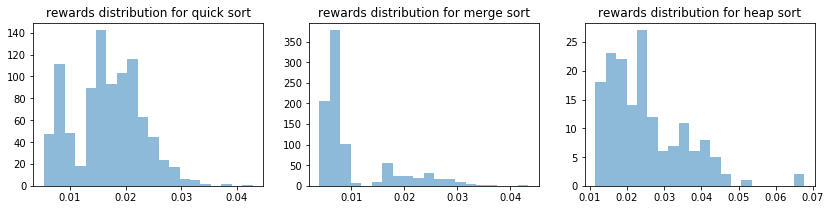

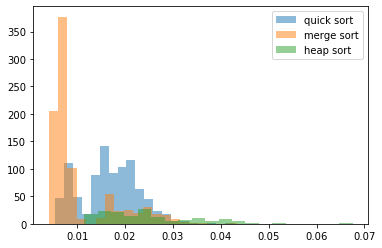

In [41]:
plot_rewards_distribution(arm_rewards_1)
plot_rewards_distribution_together(arm_rewards_1)

Restart at iteration: 50
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01602717692283197, 'merge_sort': 0.018532900002485673, 'heap_sort': 0.02563673999684397}
Count per chosen algo {'quick_sort': 39, 'merge_sort': 7, 'heap_sort': 5}


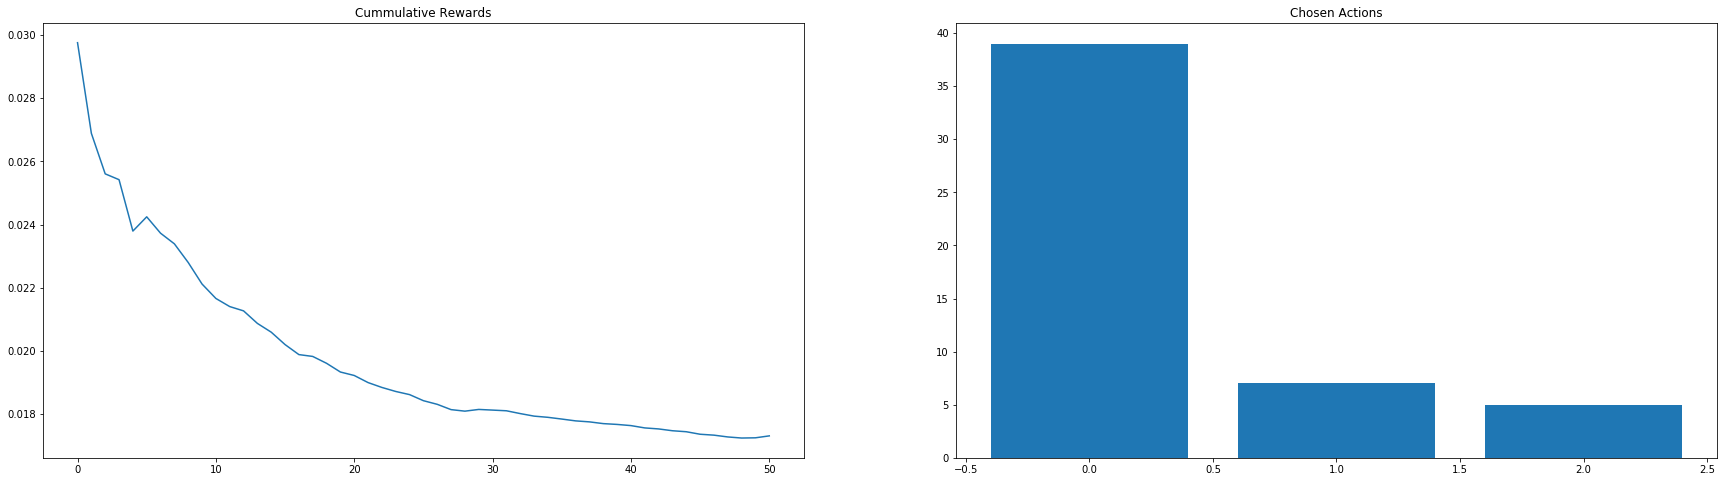

Restart at iteration: 85
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01572219999742139, 'merge_sort': 0.016869385714276826, 'heap_sort': 0.024276950003695674}
Count per chosen algo {'quick_sort': 26, 'merge_sort': 7, 'heap_sort': 2}


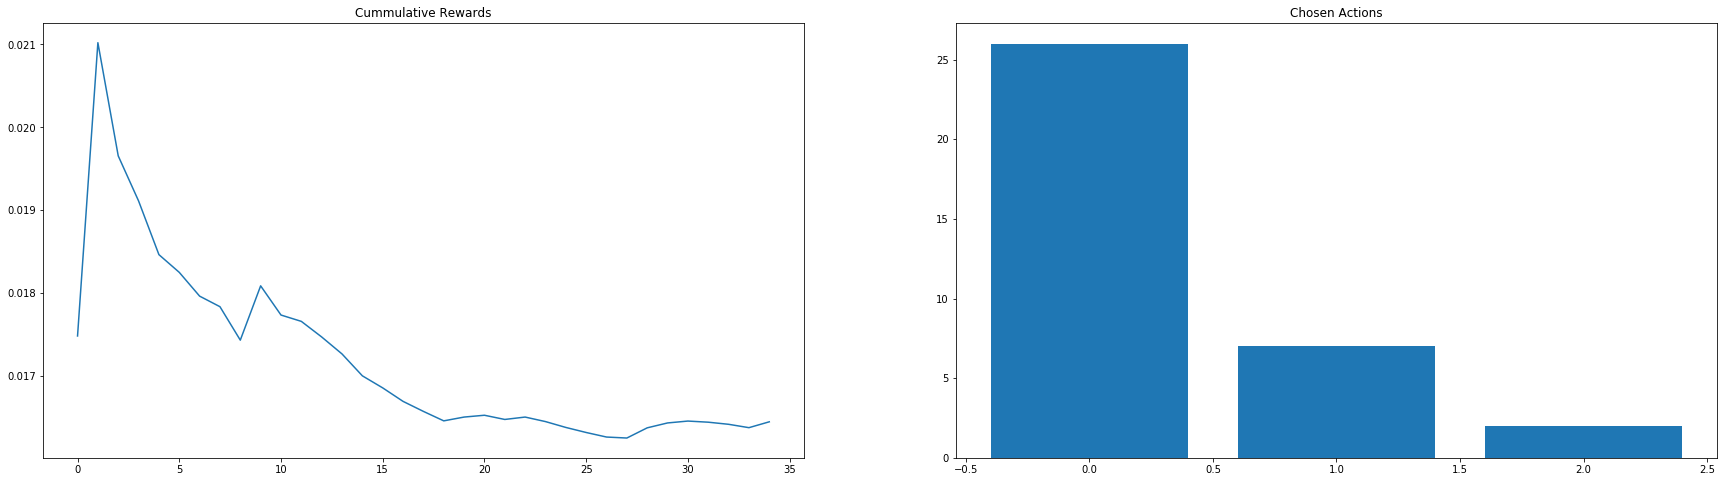

Restart at iteration: 117
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.018802825001330348, 'merge_sort': 0.0180038124993492, 'heap_sort': 0.026654400004190393}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 24, 'heap_sort': 4}


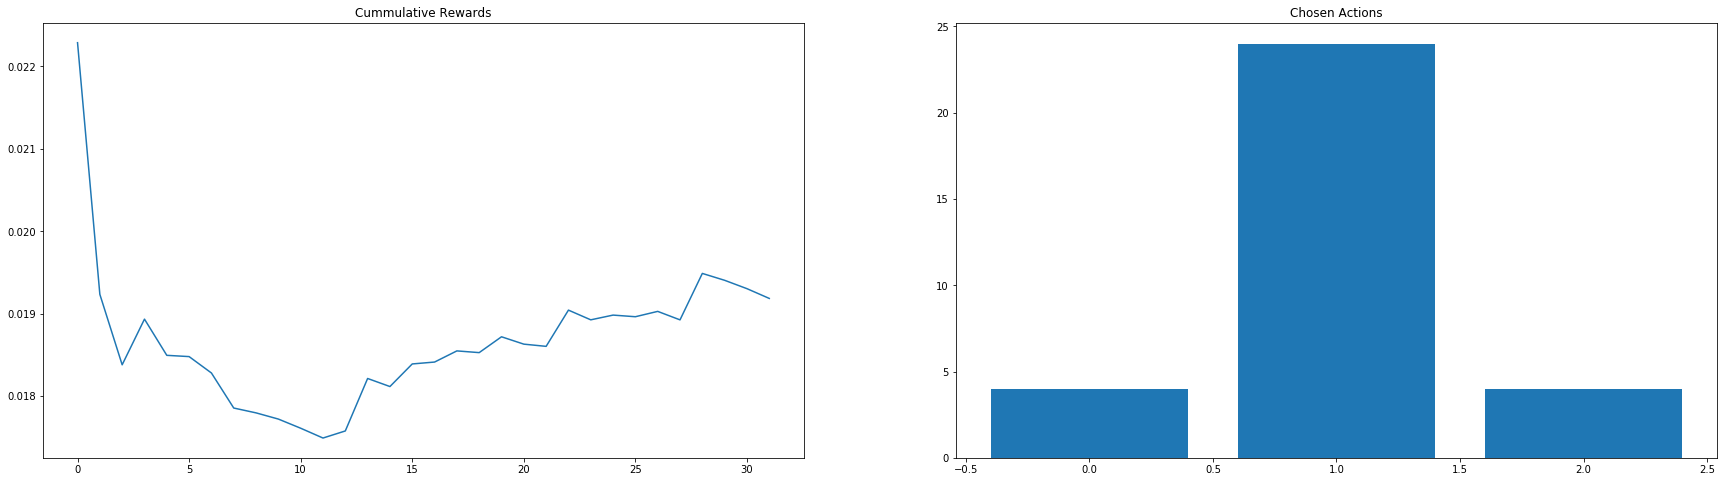

Restart at iteration: 149
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01585039999918081, 'merge_sort': 0.018406049998399492, 'heap_sort': 0.025331649994768668}
Count per chosen algo {'quick_sort': 24, 'merge_sort': 6, 'heap_sort': 2}


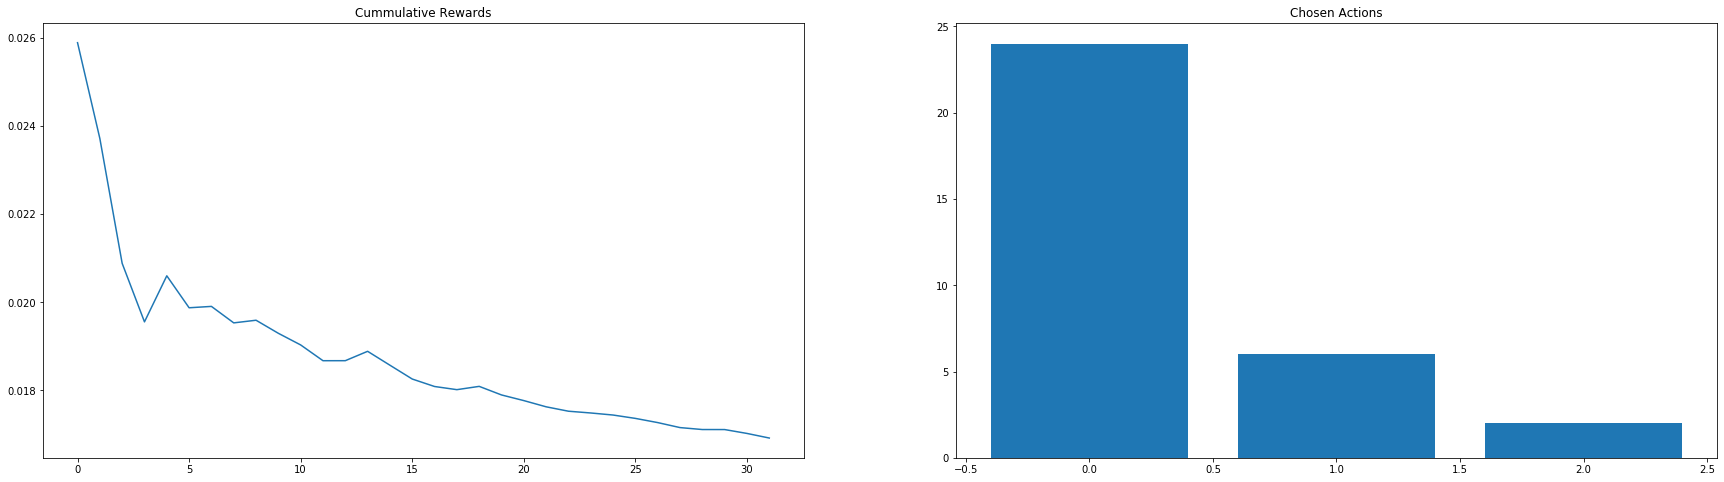

Restart at iteration: 179
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015240700000504148, 'merge_sort': 0.017030299999169073, 'heap_sort': 0.024248199988505803}
Count per chosen algo {'quick_sort': 24, 'merge_sort': 5, 'heap_sort': 1}


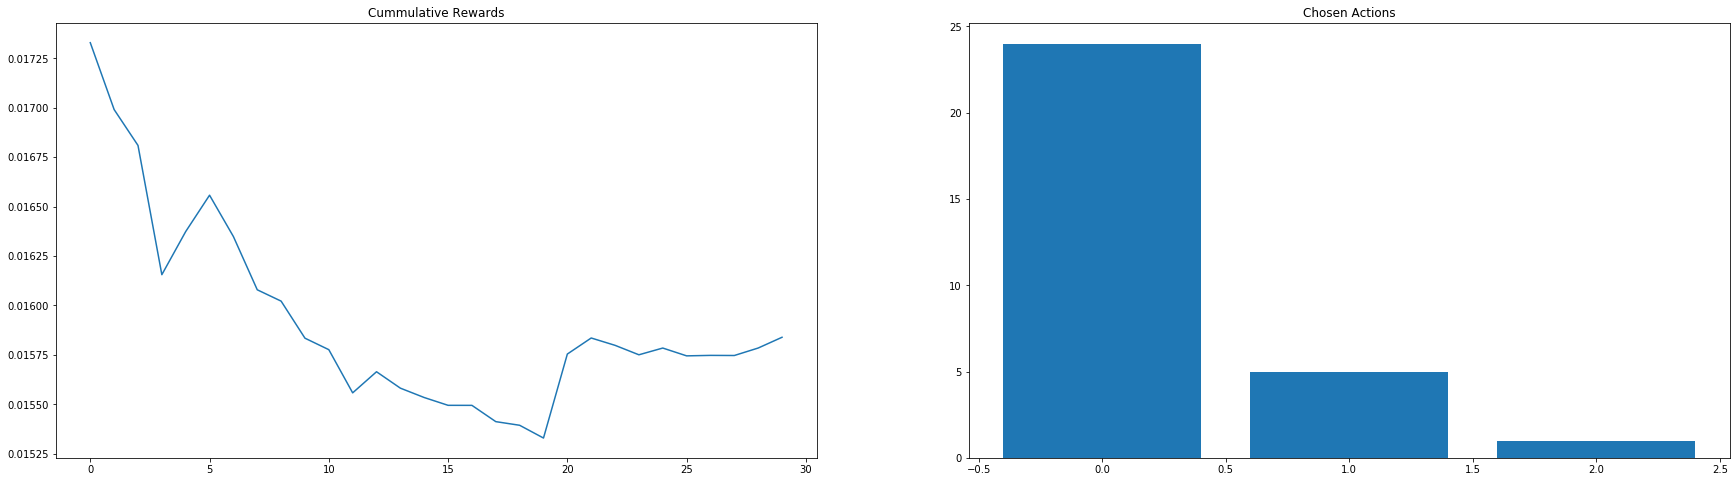

Restart at iteration: 211
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01673704166751122, 'merge_sort': 0.021228874997177627, 'heap_sort': 0.026643550005246652}
Count per chosen algo {'quick_sort': 24, 'merge_sort': 4, 'heap_sort': 4}


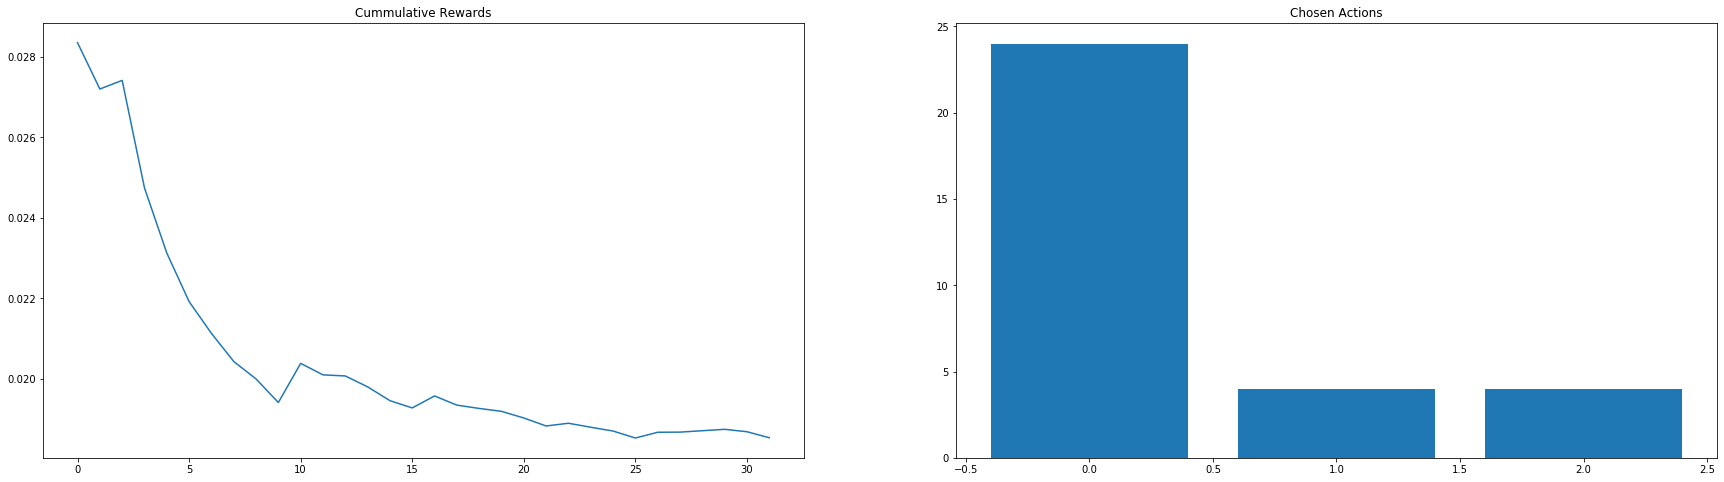

Restart at iteration: 246
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015025353332263573, 'merge_sort': 0.017956499999854714, 'heap_sort': 0.025128633332011912}
Count per chosen algo {'quick_sort': 30, 'merge_sort': 2, 'heap_sort': 3}


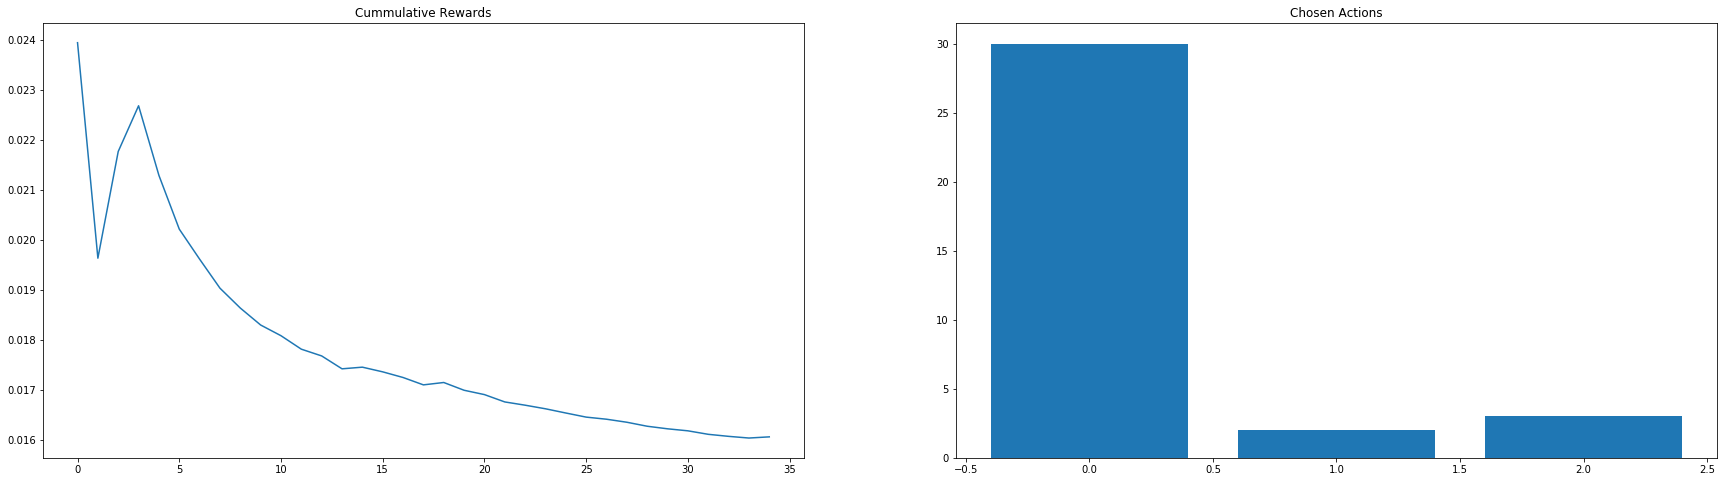

Restart at iteration: 293
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0147634344837821, 'merge_sort': 0.016688133332839545, 'heap_sort': 0.02441838888787768}
Count per chosen algo {'quick_sort': 29, 'merge_sort': 9, 'heap_sort': 9}


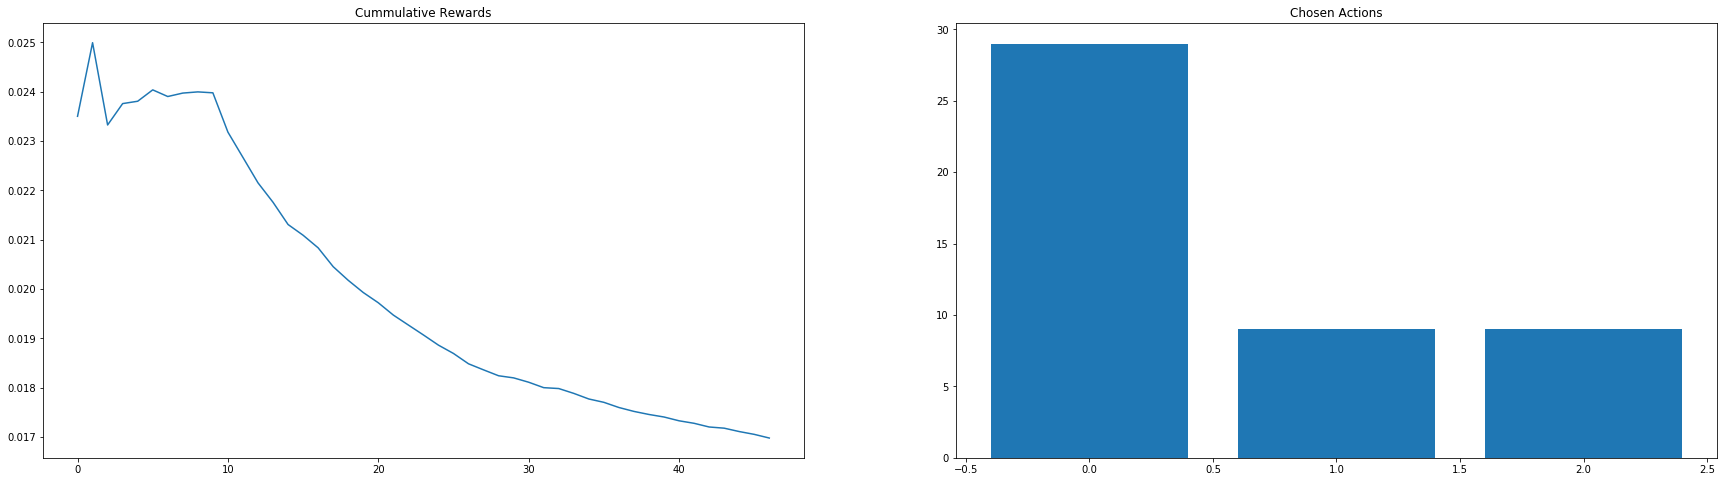

Restart at iteration: 341
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015829363637418613, 'merge_sort': 0.019041326085520584, 'heap_sort': 0.027472266665427014}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 23, 'heap_sort': 3}


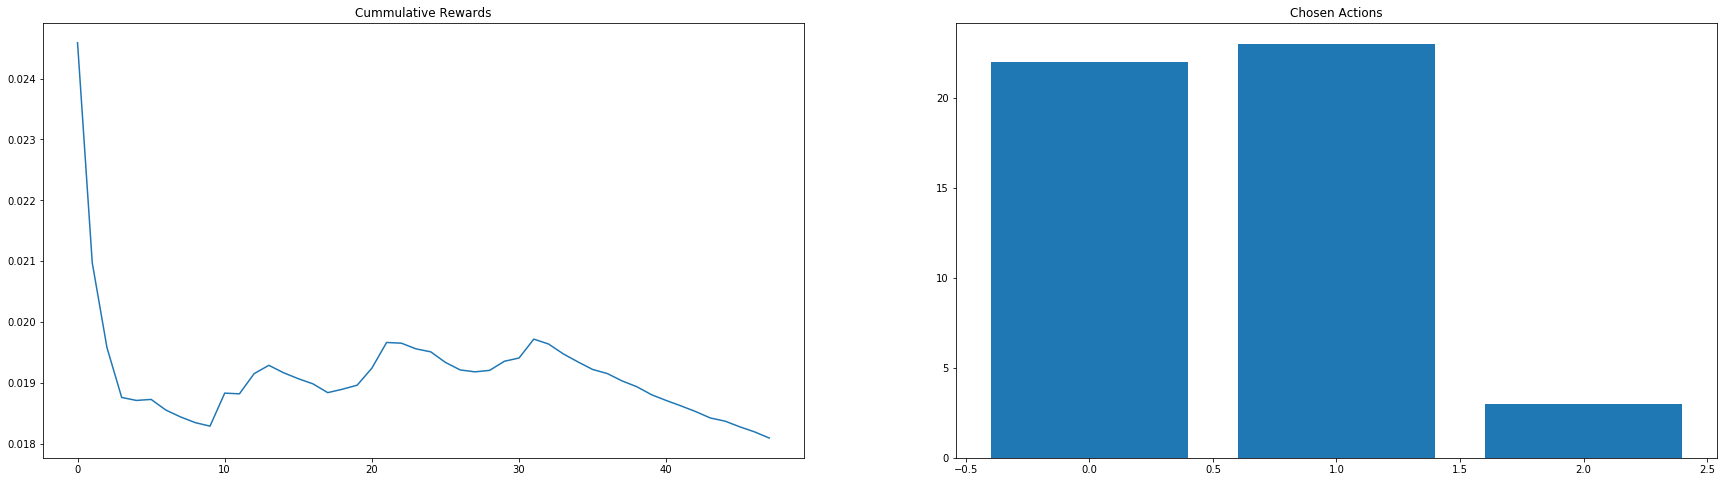

Restart at iteration: 373
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015770663634281267, 'merge_sort': 0.016680362499755574, 'heap_sort': 0.023707099993771408}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 8, 'heap_sort': 2}


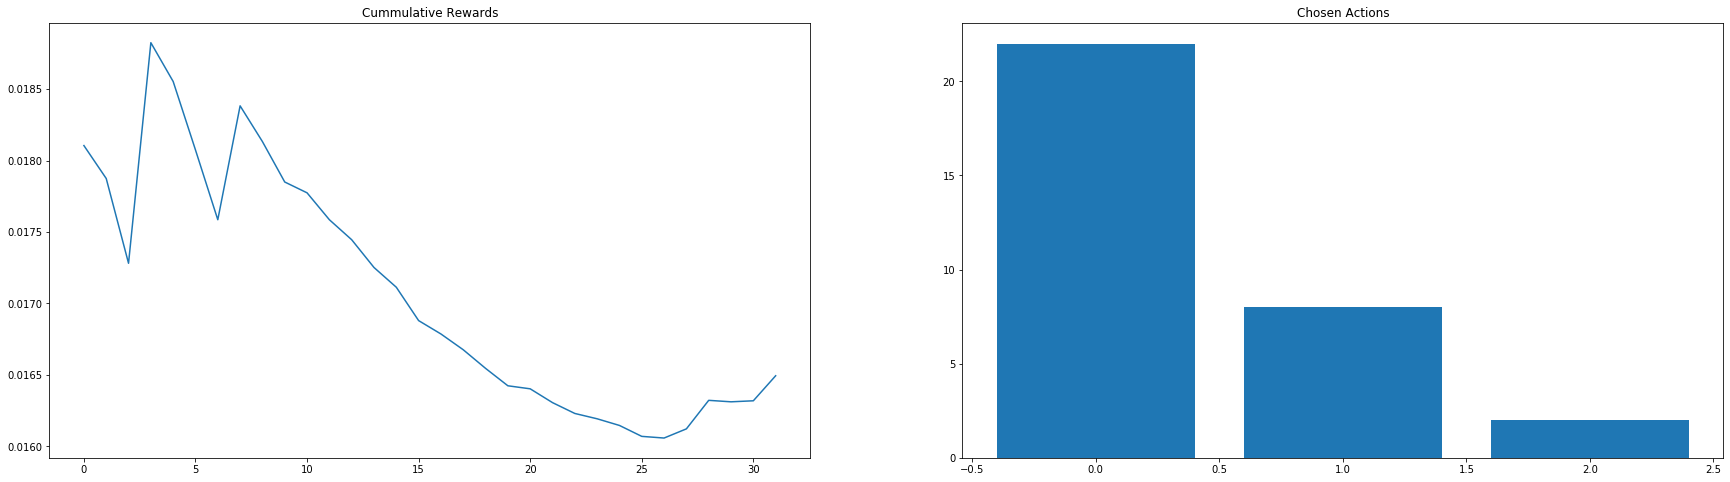

Restart at iteration: 406
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.016979729628440476, 'merge_sort': 0.0201300250046188, 'heap_sort': 0.023976749995199498}
Count per chosen algo {'quick_sort': 27, 'merge_sort': 4, 'heap_sort': 2}


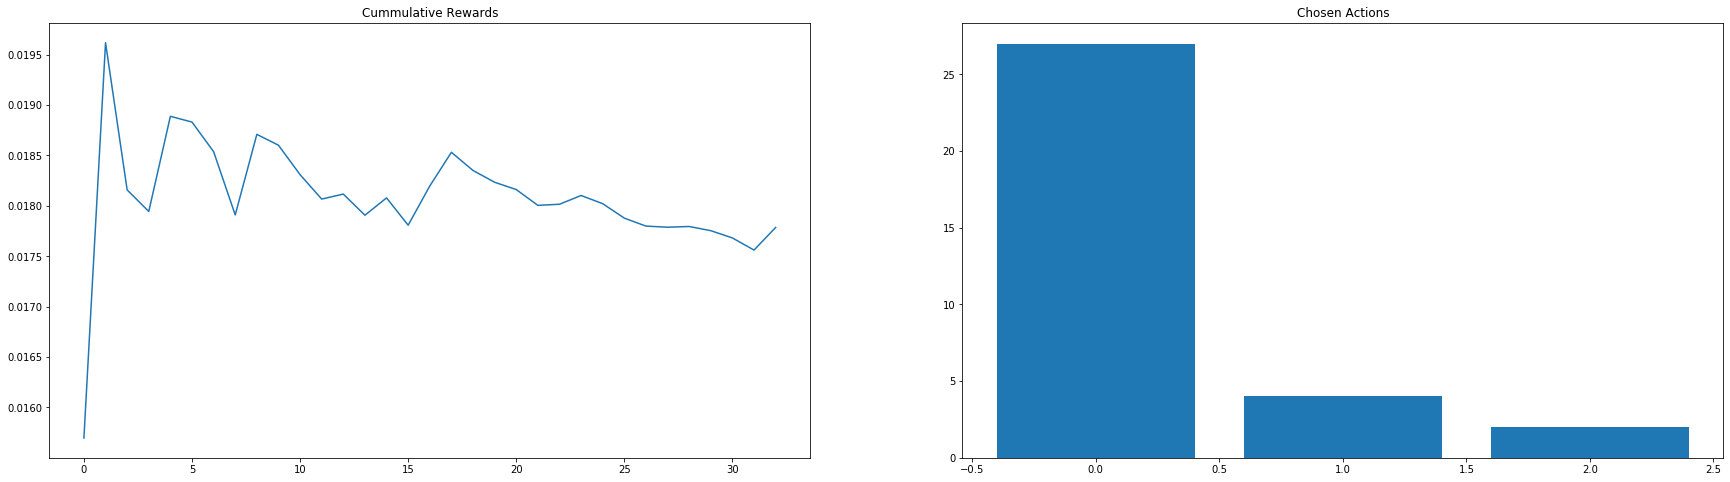

Restart at iteration: 441
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.017235500000533647, 'merge_sort': 0.01867742857055938, 'heap_sort': 0.0267061333336945}
Count per chosen algo {'quick_sort': 25, 'merge_sort': 7, 'heap_sort': 3}


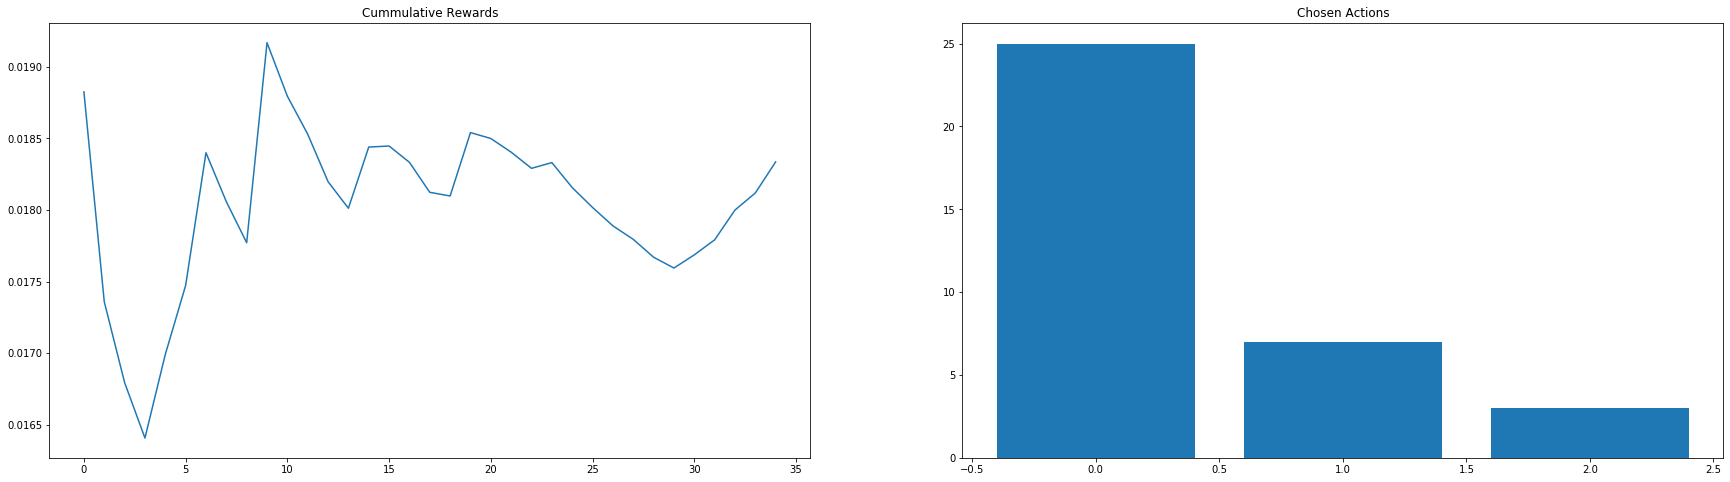

Restart at iteration: 471
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01969506363754838, 'merge_sort': 0.02606050000031246, 'heap_sort': 0.031188724999083206}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 4, 'heap_sort': 4}


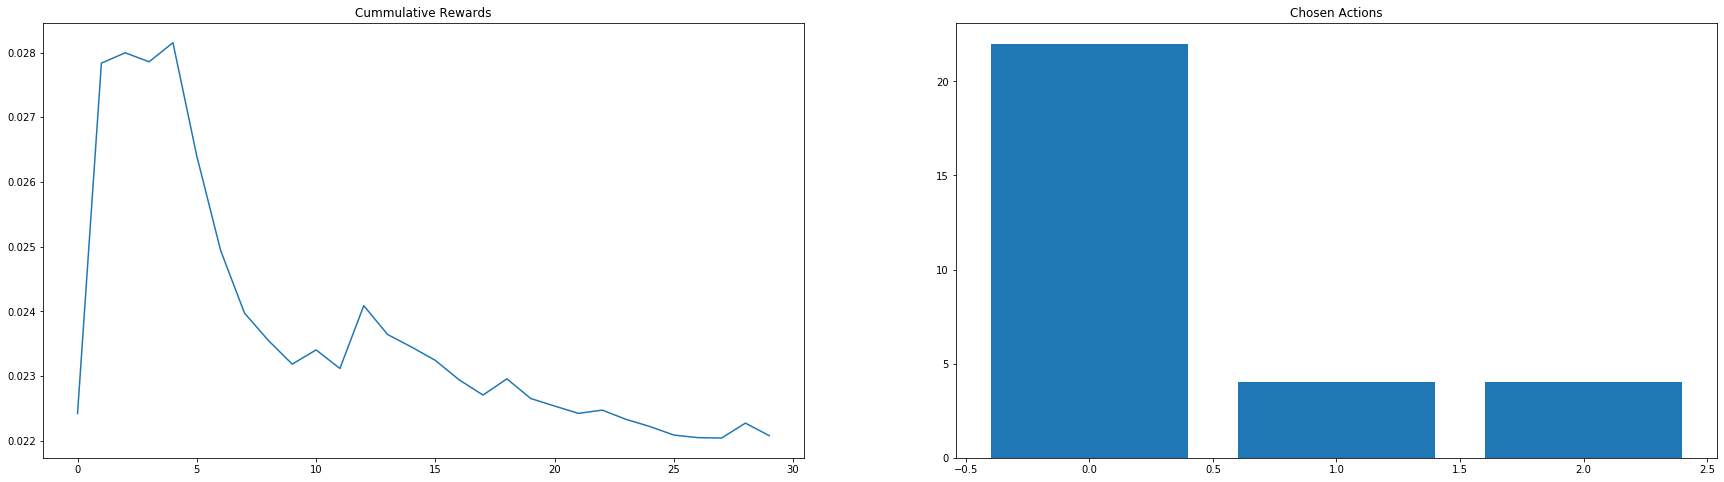

Restart at iteration: 500
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.020526430433560366, 'merge_sort': 0.02405670000007376, 'heap_sort': 0.034638466662727296}
Count per chosen algo {'quick_sort': 23, 'merge_sort': 3, 'heap_sort': 3}


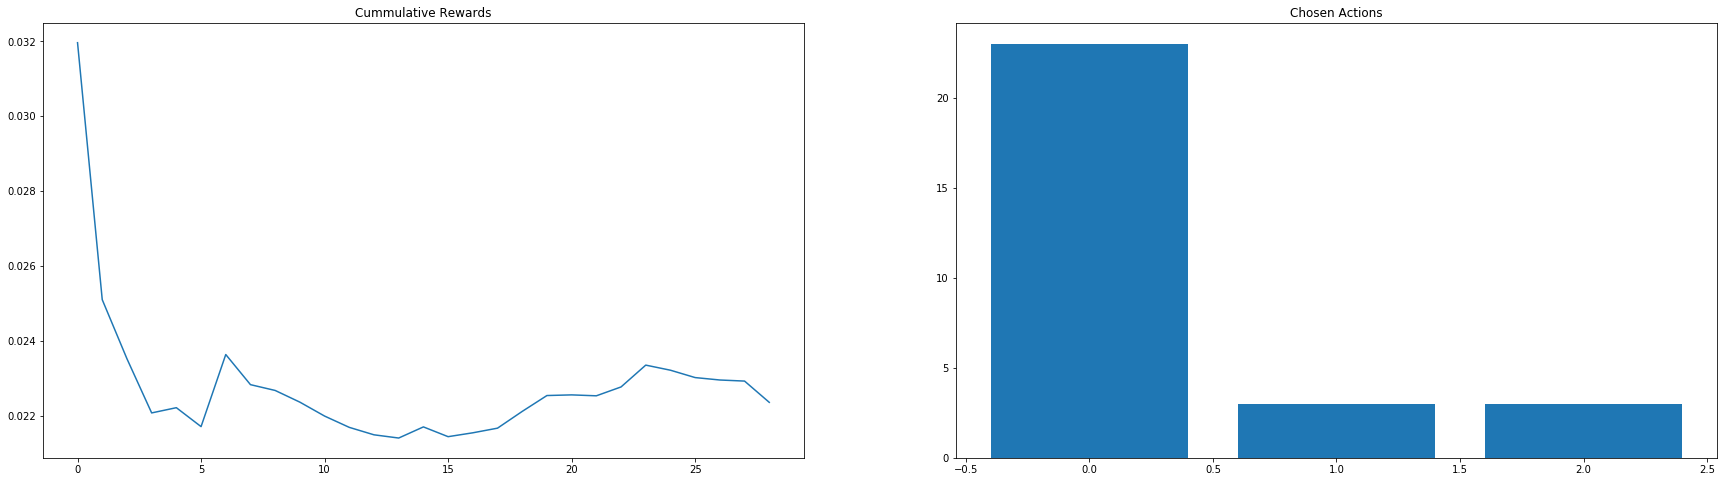

Restart at iteration: 546
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008289800010970794, 'merge_sort': 0.006298692856424688, 'heap_sort': 0.01576240000334413}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 42, 'heap_sort': 3}


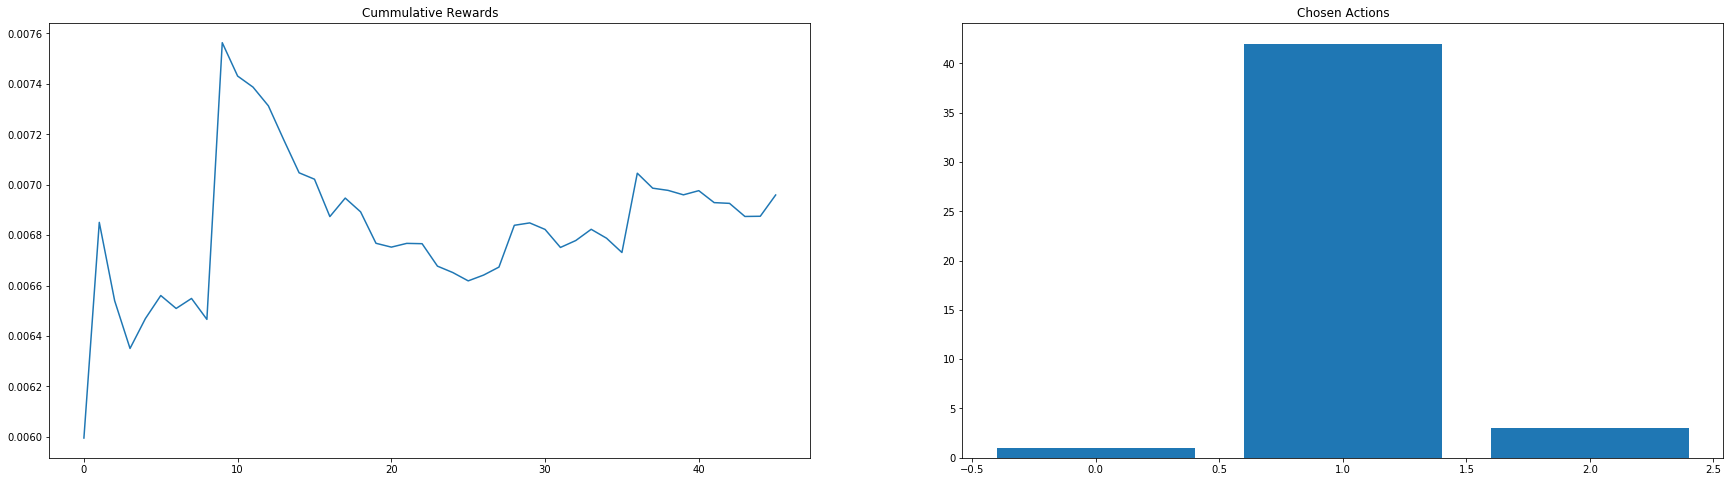

Restart at iteration: 569
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008698190909027207, 'merge_sort': 0.014065299998037517, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 1, 'heap_sort': 0}


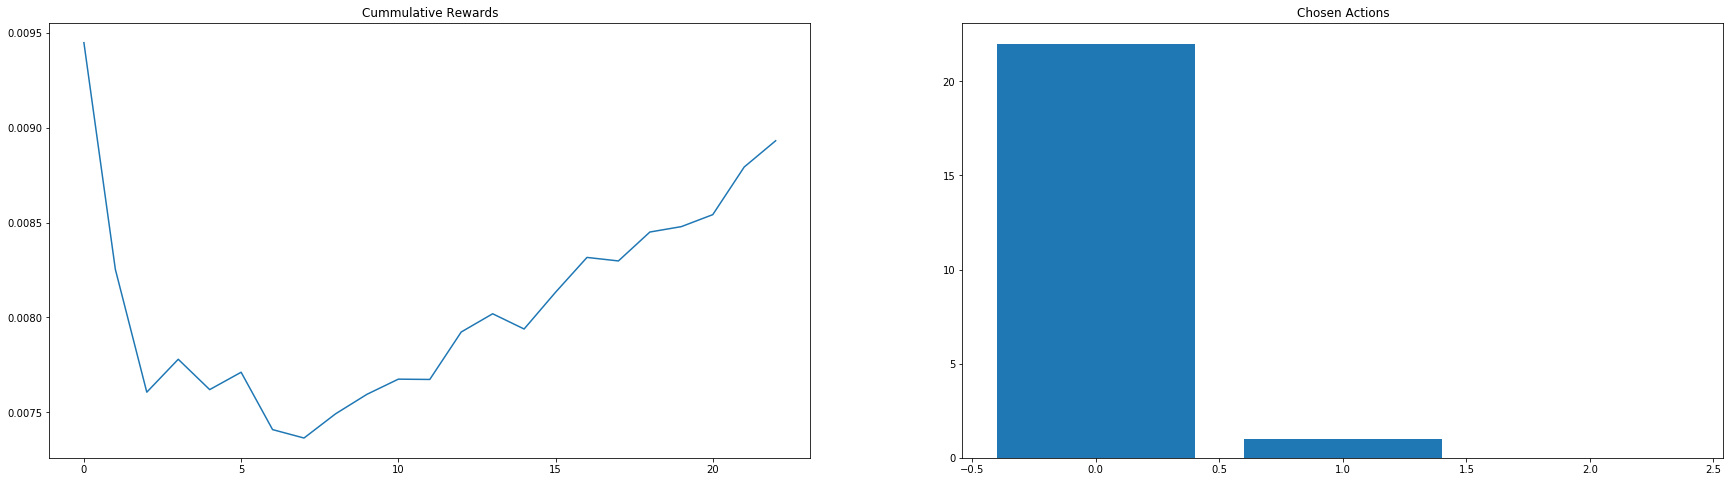

Restart at iteration: 601
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008479648276236196, 'merge_sort': 0.005361600007745437, 'heap_sort': 0.014193299997714348}
Count per chosen algo {'quick_sort': 29, 'merge_sort': 1, 'heap_sort': 2}


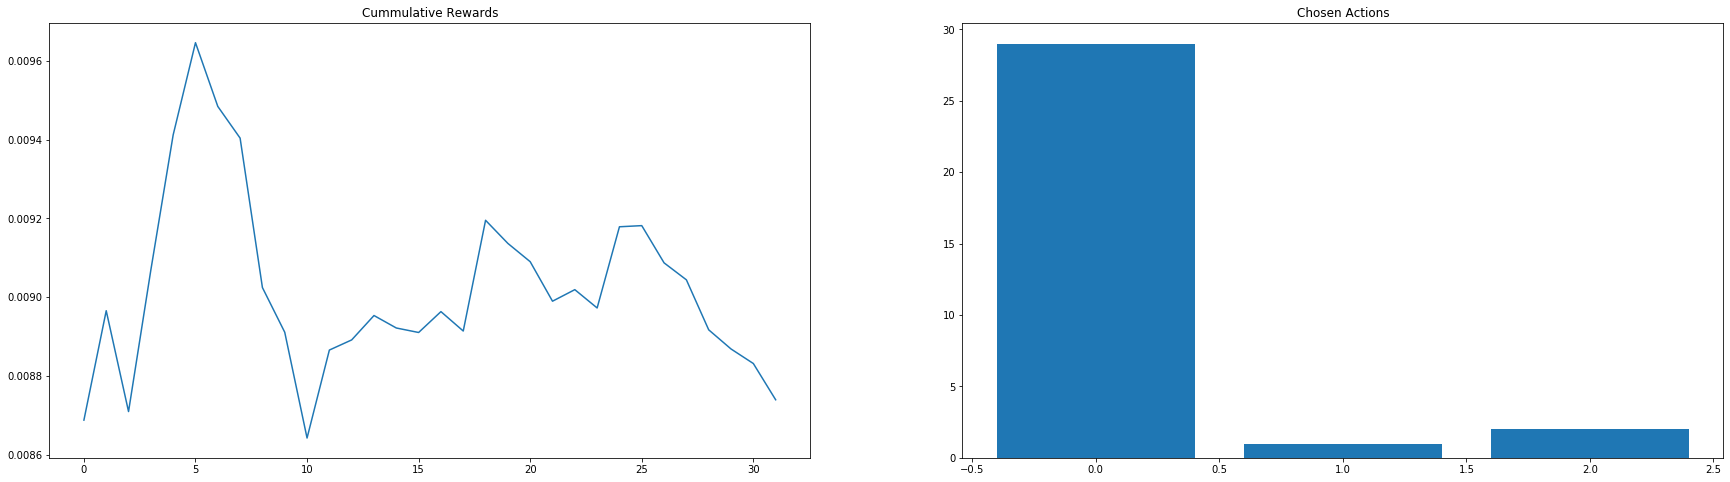

Restart at iteration: 626
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008731349997106008, 'merge_sort': 0.006833586362931369, 'heap_sort': 0.015277800004696473}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 22, 'heap_sort': 1}


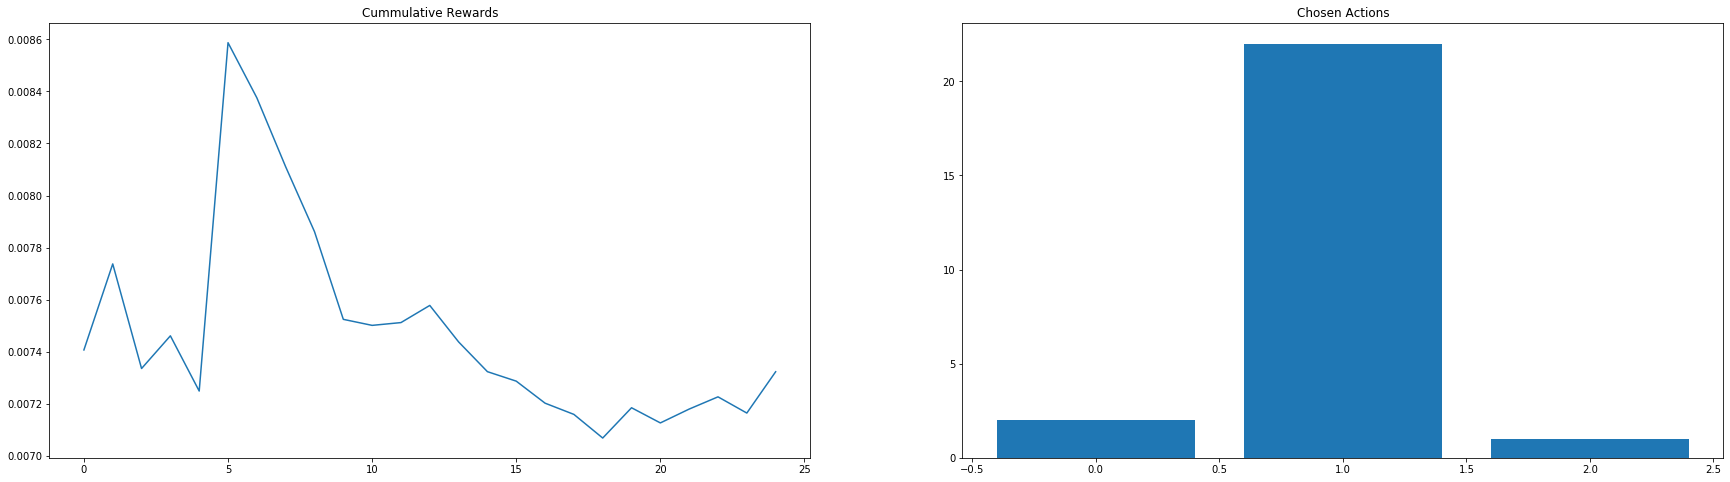

Restart at iteration: 659
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009311233333493065, 'merge_sort': 0.00666335714188227, 'heap_sort': 0.017210700001063135}
Count per chosen algo {'quick_sort': 9, 'merge_sort': 21, 'heap_sort': 3}


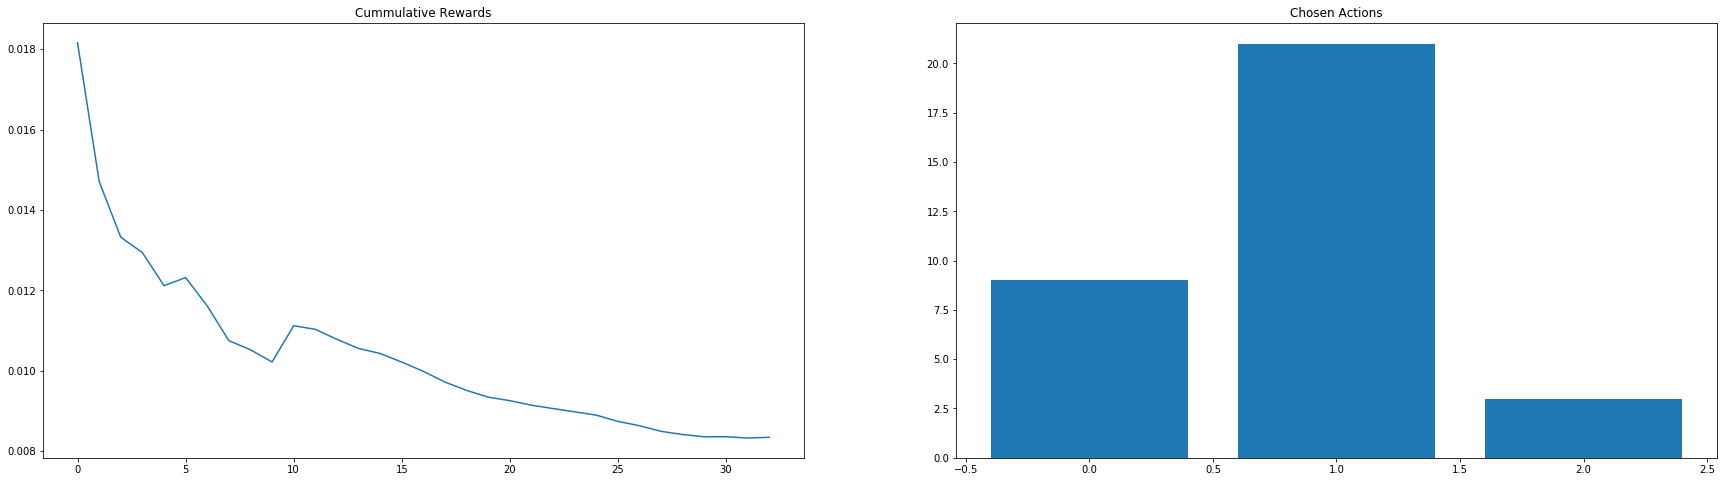

Restart at iteration: 721
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007876805555295303, 'merge_sort': 0.0066363146335522575, 'heap_sort': 0.013940733333583921}
Count per chosen algo {'quick_sort': 18, 'merge_sort': 41, 'heap_sort': 3}


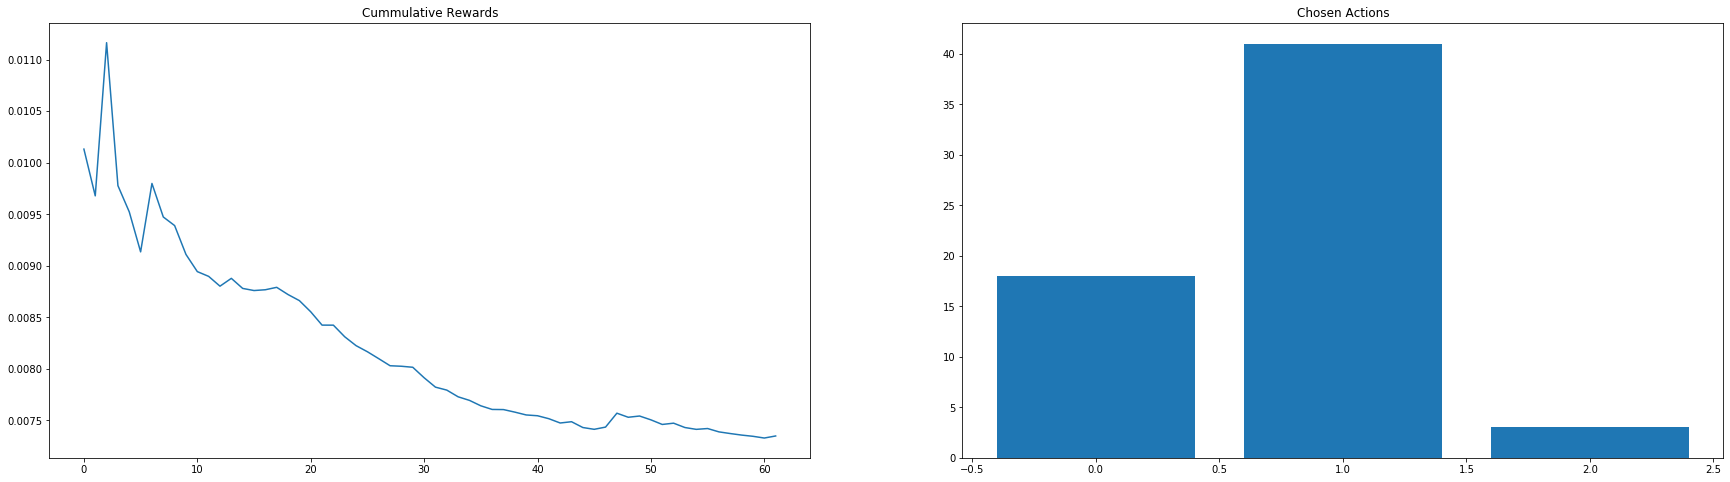

Restart at iteration: 749
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007399119233014062, 'merge_sort': 0.005860000004759058, 'heap_sort': 0.016678900006809272}
Count per chosen algo {'quick_sort': 26, 'merge_sort': 1, 'heap_sort': 1}


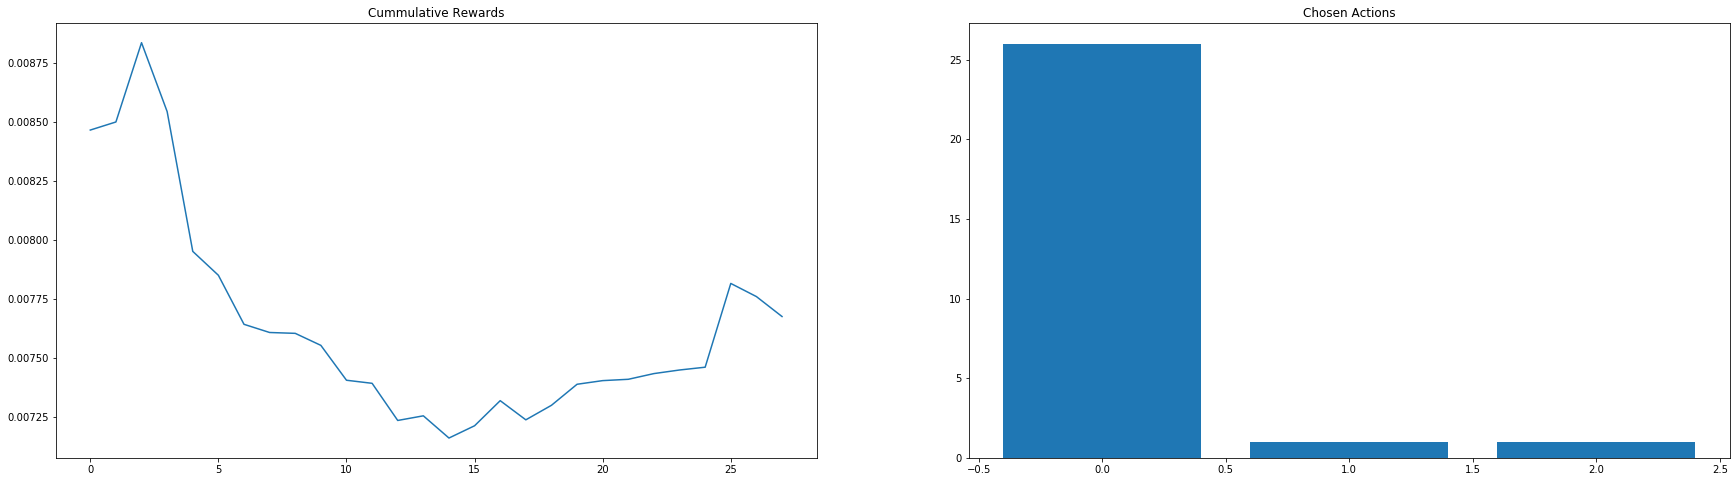

Restart at iteration: 785
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006596000006538816, 'merge_sort': 0.006711612902900895, 'heap_sort': 0.014690225005324464}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 31, 'heap_sort': 4}


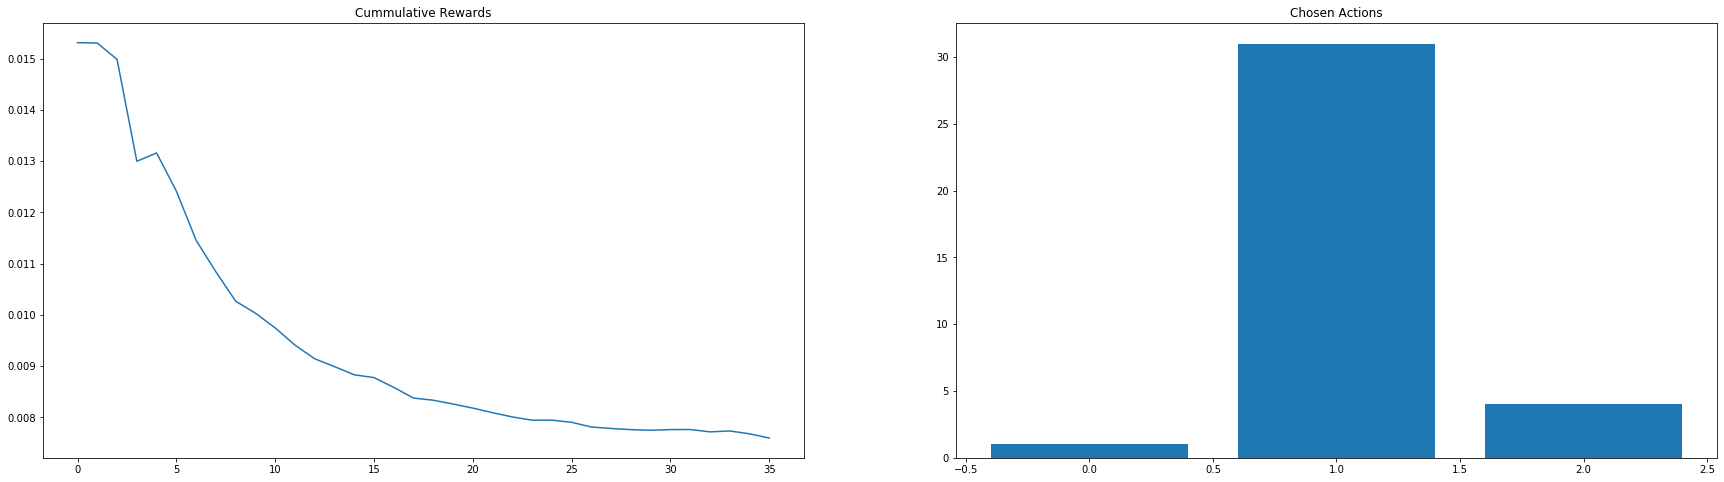

Restart at iteration: 815
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007325025006139185, 'merge_sort': 0.007061290476399119, 'heap_sort': 0.01652908000105526}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 21, 'heap_sort': 5}


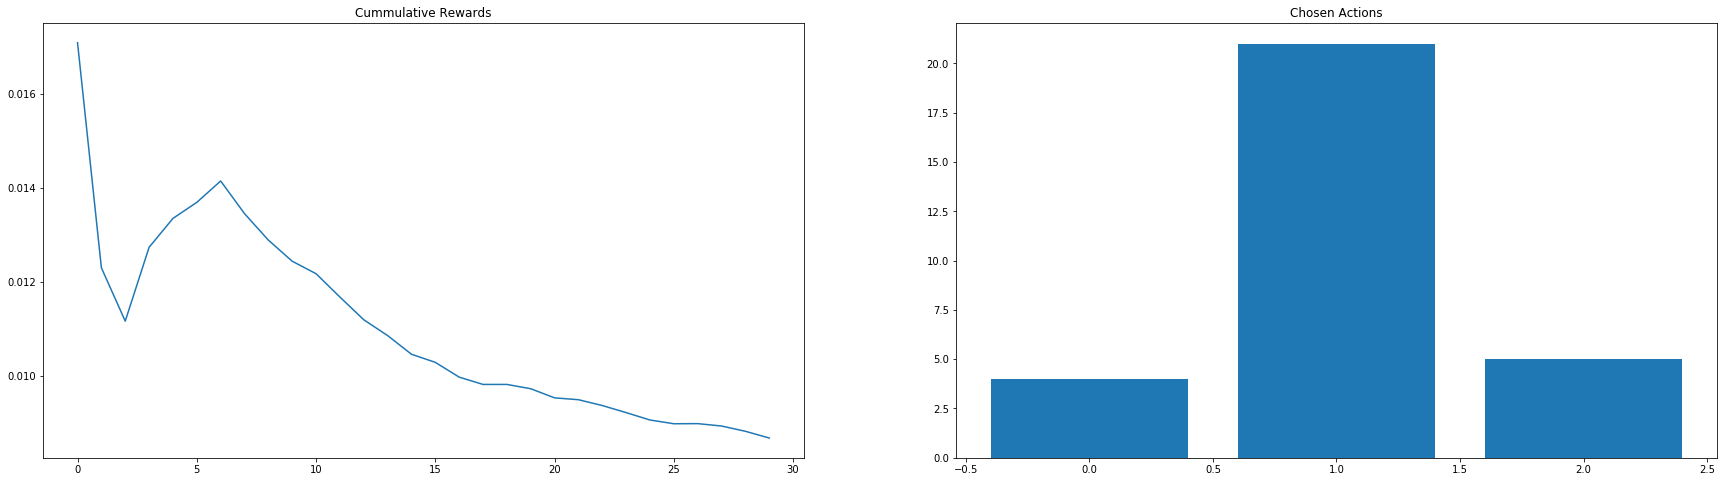

Restart at iteration: 877
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007883986485712985, 'merge_sort': 0.006233199999604205, 'heap_sort': 0.014744733338981556}
Count per chosen algo {'quick_sort': 37, 'merge_sort': 22, 'heap_sort': 3}


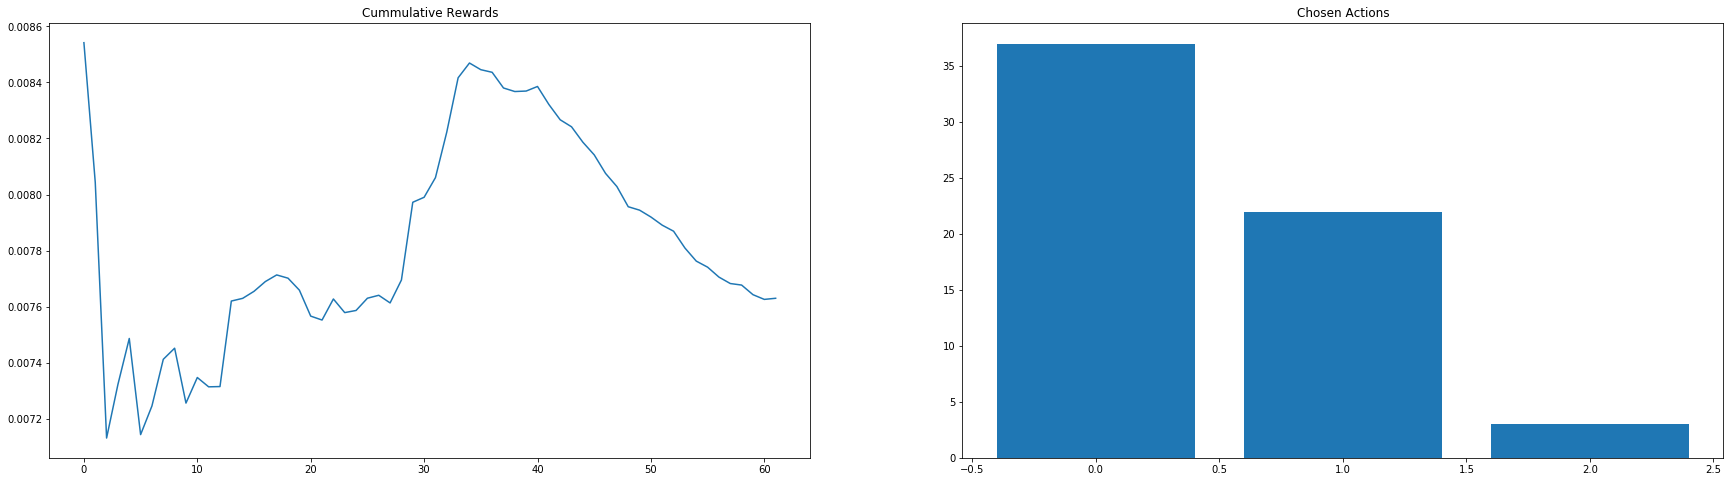

Restart at iteration: 912
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007148639997467399, 'merge_sort': 0.00626516296189813, 'heap_sort': 0.01378893333215577}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 27, 'heap_sort': 3}


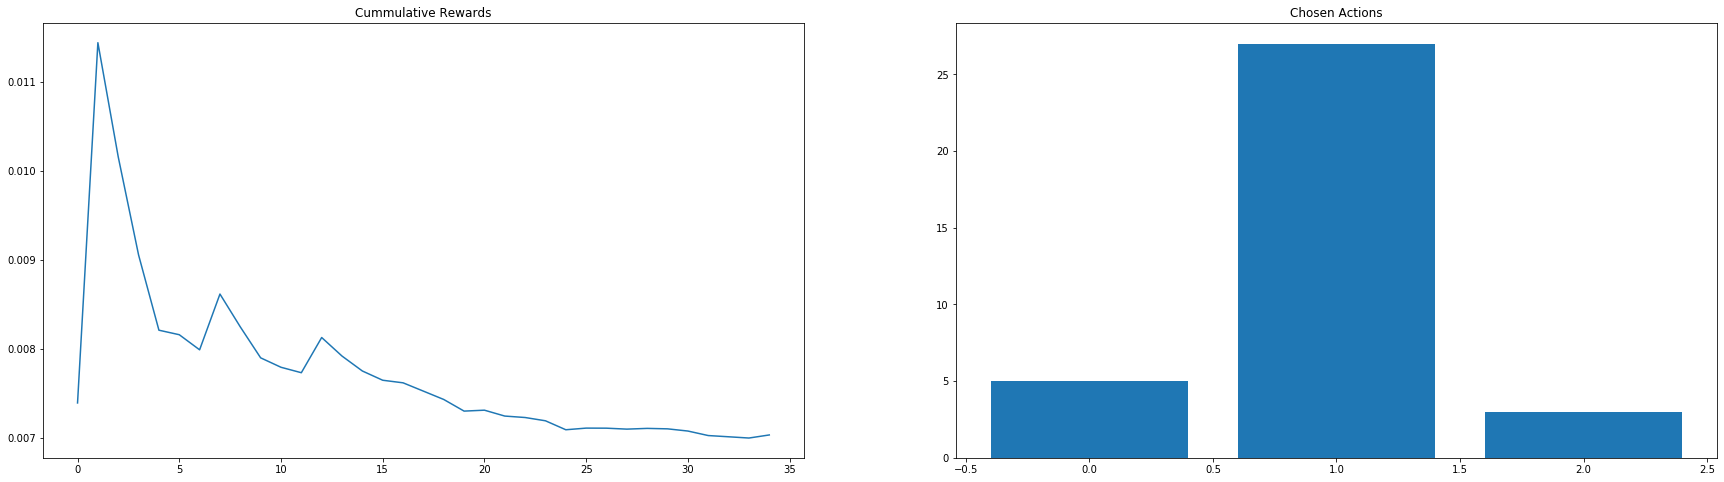

Restart at iteration: 958
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007677485002932372, 'merge_sort': 0.006270950001304631, 'heap_sort': 0.0150189500018314}
Count per chosen algo {'quick_sort': 20, 'merge_sort': 22, 'heap_sort': 4}


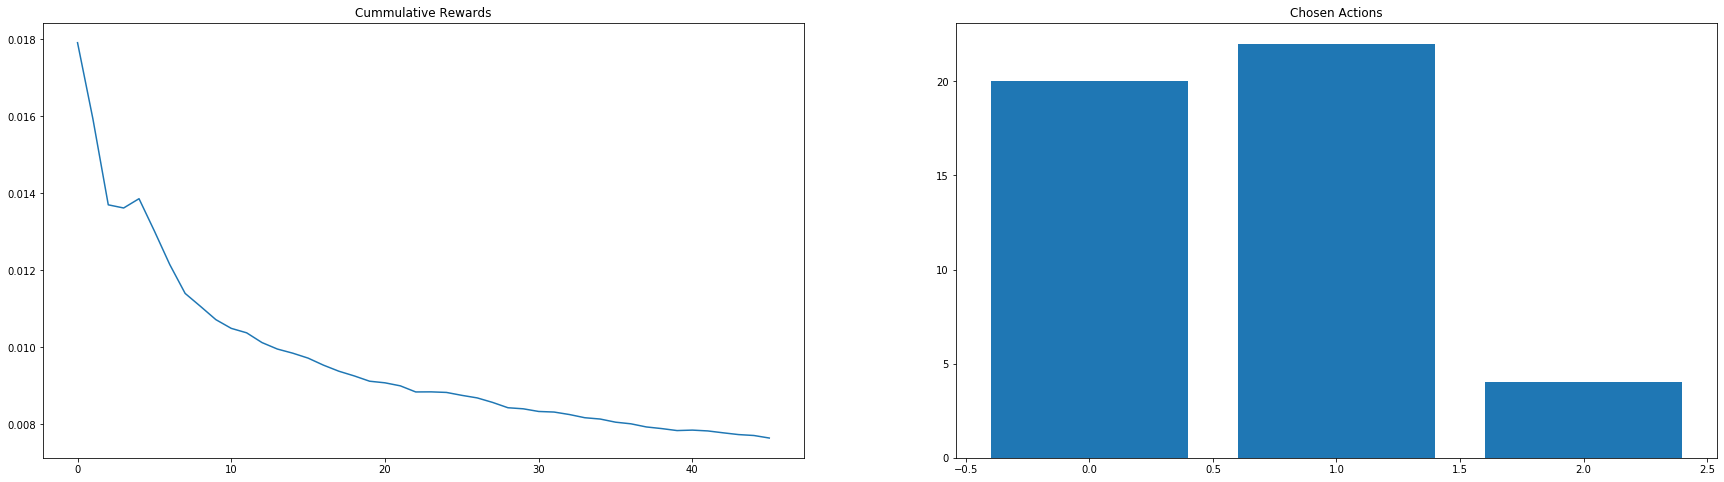

Restart at iteration: 983
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008214800007408485, 'merge_sort': 0.006251900005736388, 'heap_sort': 0.0171134173920702}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 1, 'heap_sort': 23}


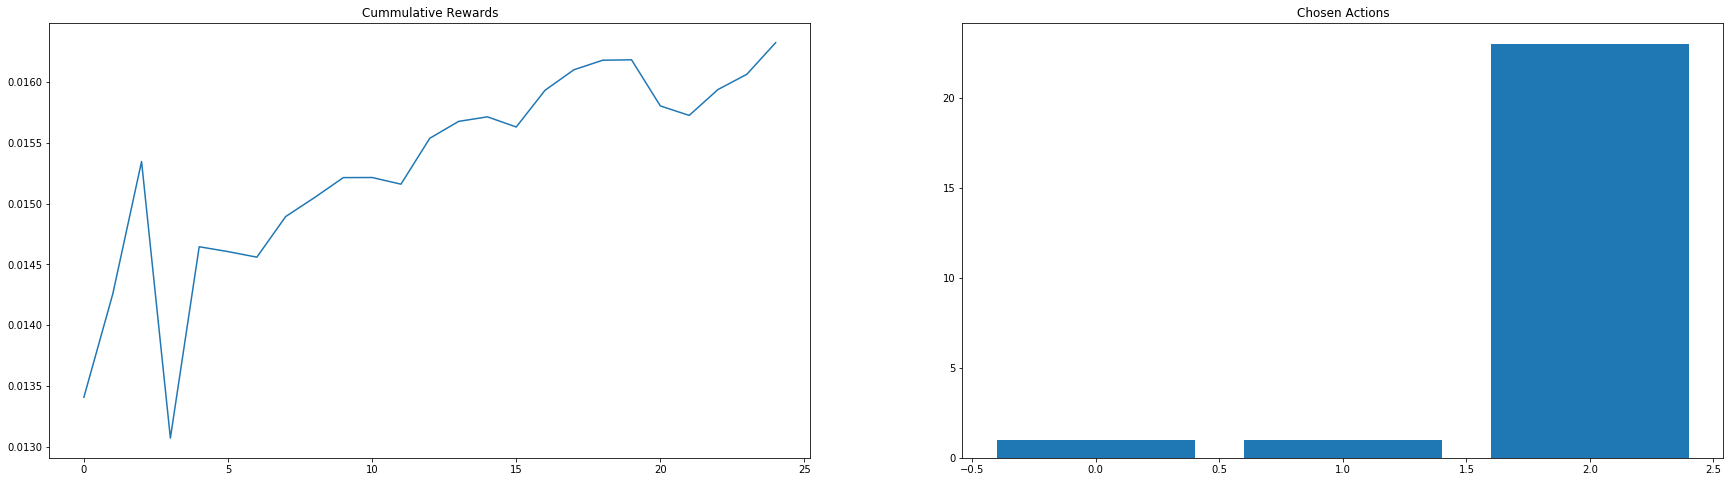

Restart at iteration: 1031
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01942220000117751, 'merge_sort': 0.019786955174038605, 'heap_sort': 0.03723049999971408}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 29, 'heap_sort': 5}


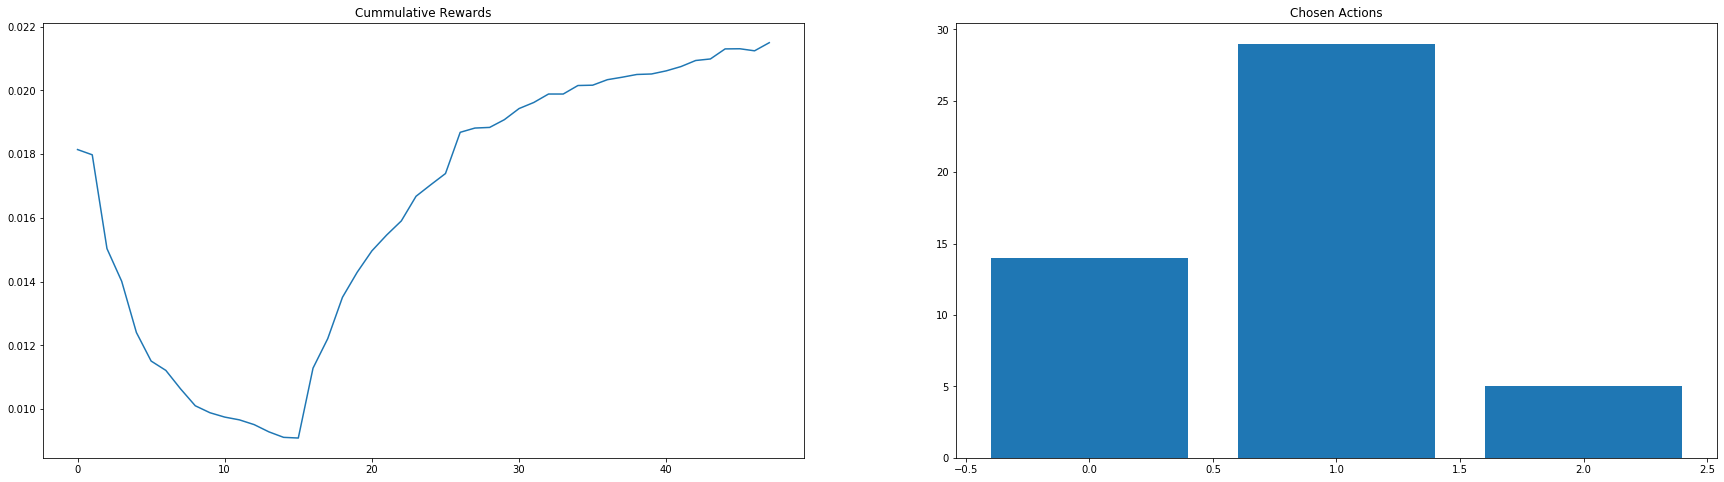

Restart at iteration: 1075
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02185452727214645, 'merge_sort': 0.023752016667761684, 'heap_sort': 0.03270697999978438}
Count per chosen algo {'quick_sort': 33, 'merge_sort': 6, 'heap_sort': 5}


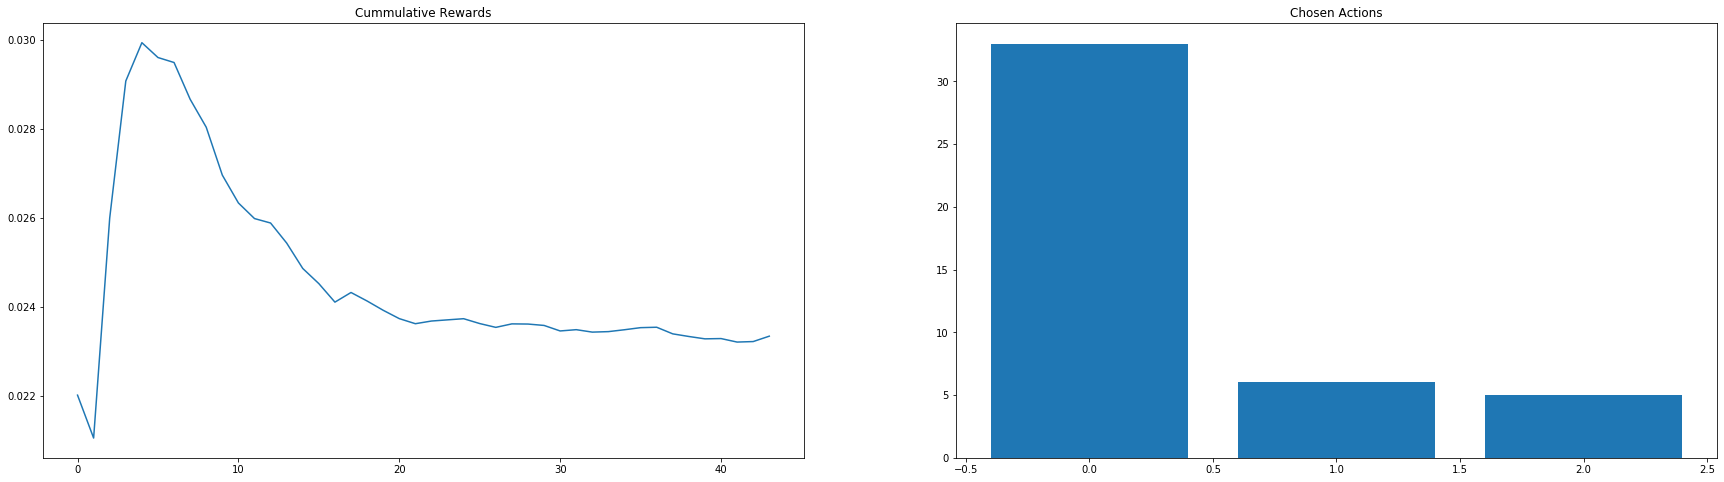

Restart at iteration: 1152
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.024000025372569962, 'merge_sort': 0.029413128571052636, 'heap_sort': 0.05860070000441434}
Count per chosen algo {'quick_sort': 67, 'merge_sort': 7, 'heap_sort': 3}


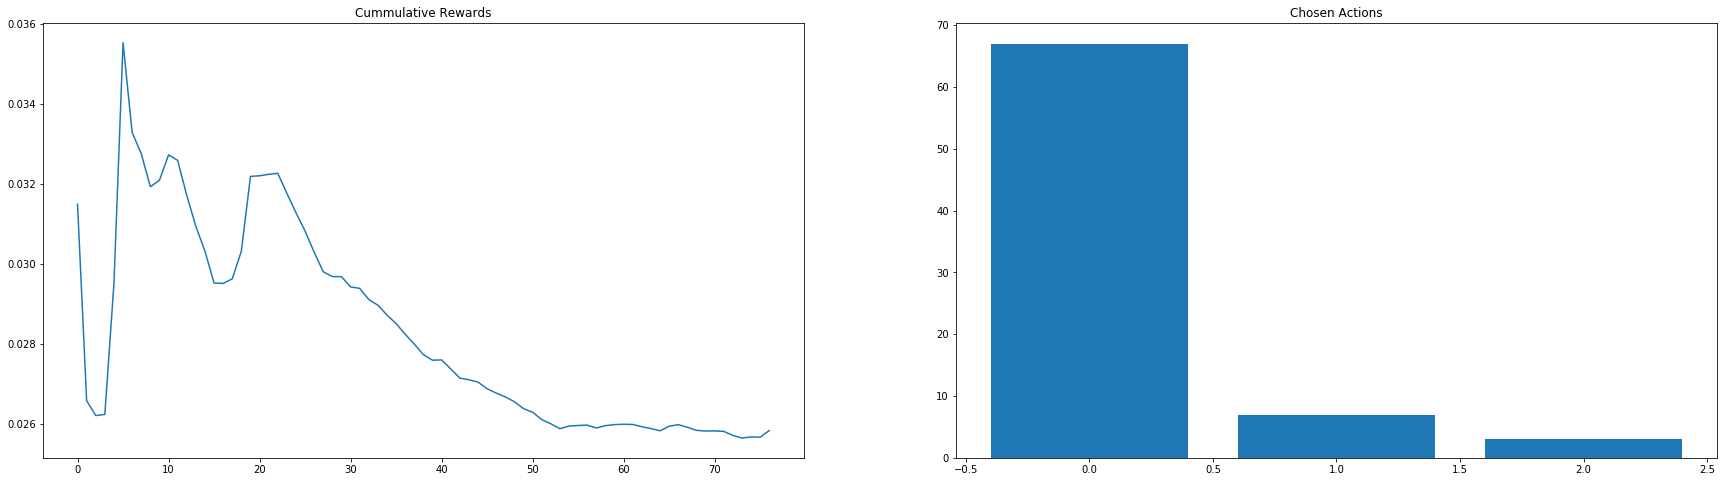

Restart at iteration: 1185
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.021304773078344833, 'merge_sort': 0.02859872499902849, 'heap_sort': 0.04003589999532172}
Count per chosen algo {'quick_sort': 26, 'merge_sort': 4, 'heap_sort': 3}


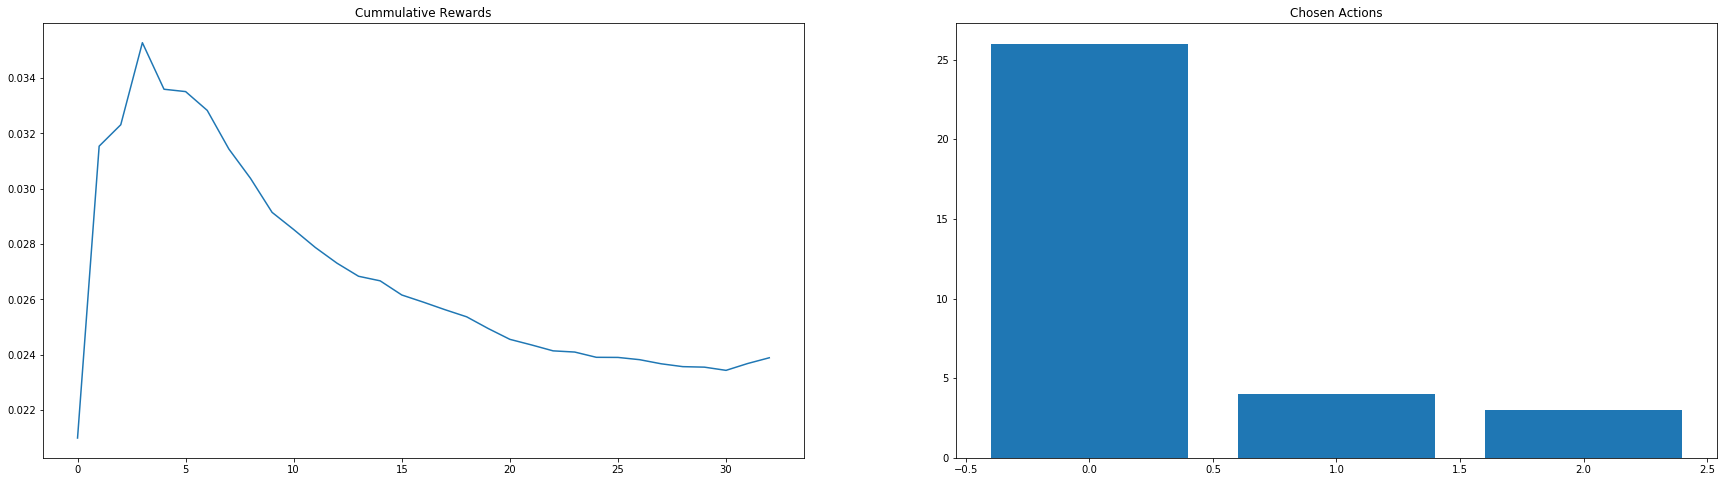

Restart at iteration: 1210
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02282814761773417, 'merge_sort': 0.02972964999207761, 'heap_sort': 0.04064564999862341}
Count per chosen algo {'quick_sort': 21, 'merge_sort': 2, 'heap_sort': 2}


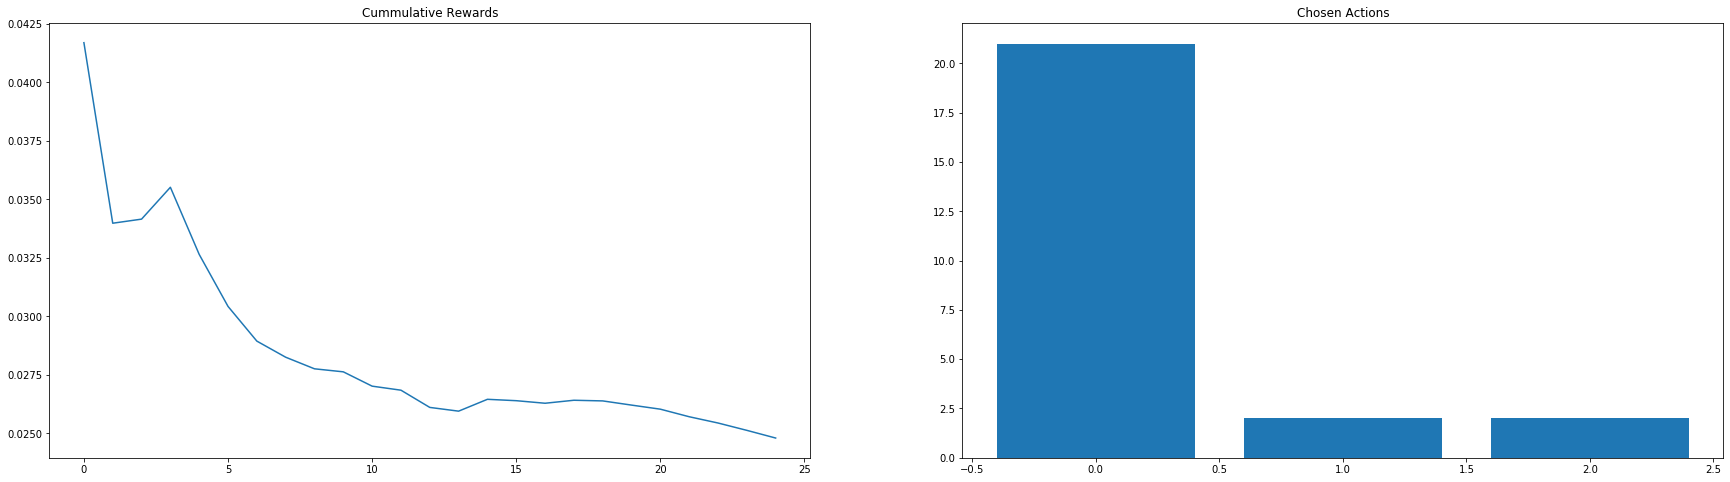

Restart at iteration: 1242
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.021793856522771934, 'merge_sort': 0.02423907142864274, 'heap_sort': 0.03895319999719504}
Count per chosen algo {'quick_sort': 23, 'merge_sort': 7, 'heap_sort': 2}


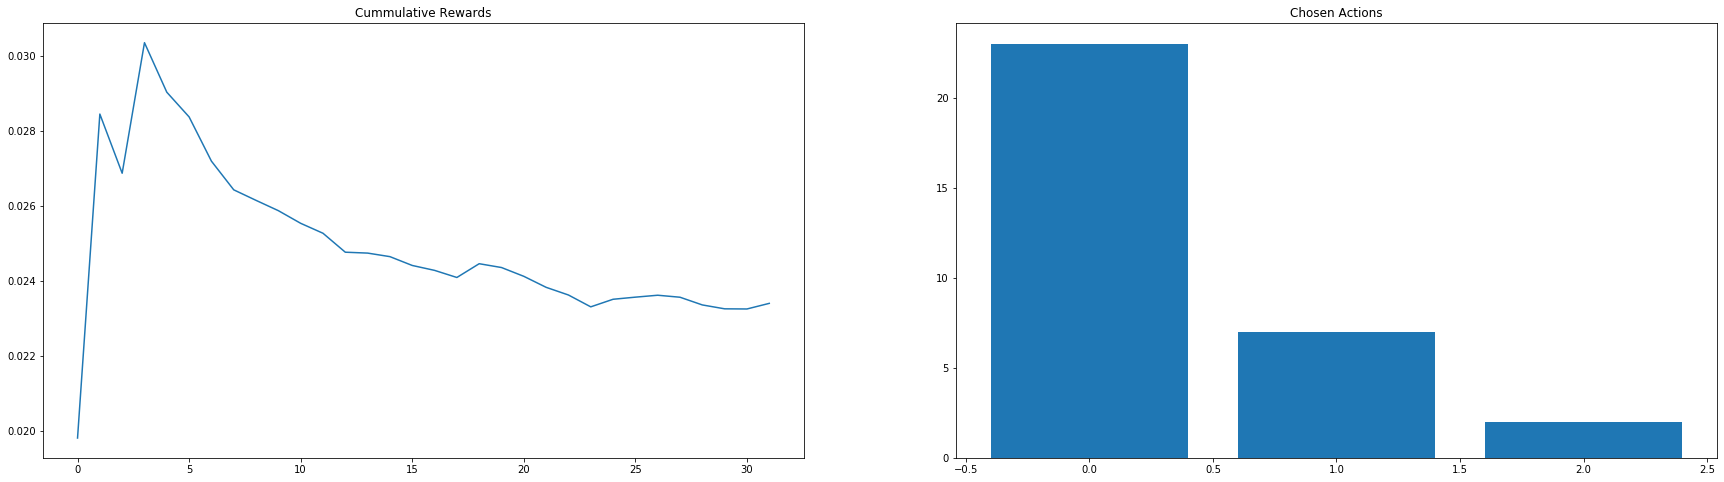

Restart at iteration: 1271
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02156670434709193, 'merge_sort': 0.023240266673383303, 'heap_sort': 0.03306080000281023}
Count per chosen algo {'quick_sort': 23, 'merge_sort': 3, 'heap_sort': 3}


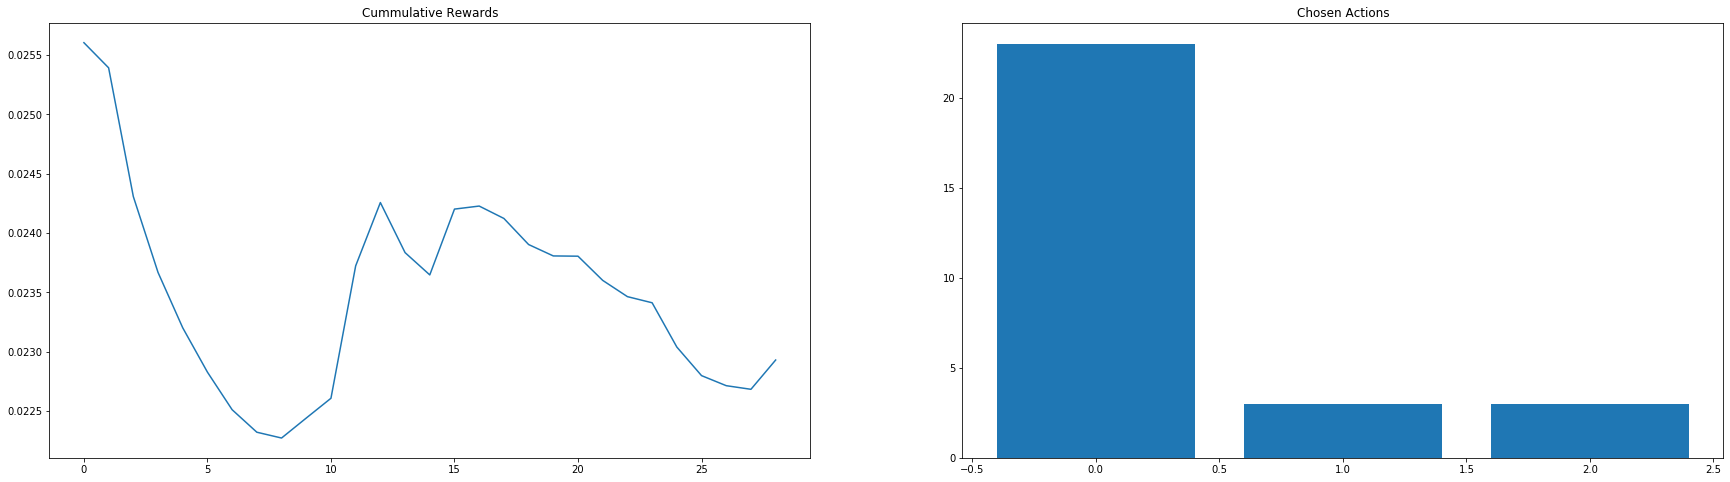

Restart at iteration: 1318
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.021551127998973244, 'merge_sort': 0.024313979998987635, 'heap_sort': 0.04174300000158837}
Count per chosen algo {'quick_sort': 25, 'merge_sort': 20, 'heap_sort': 2}


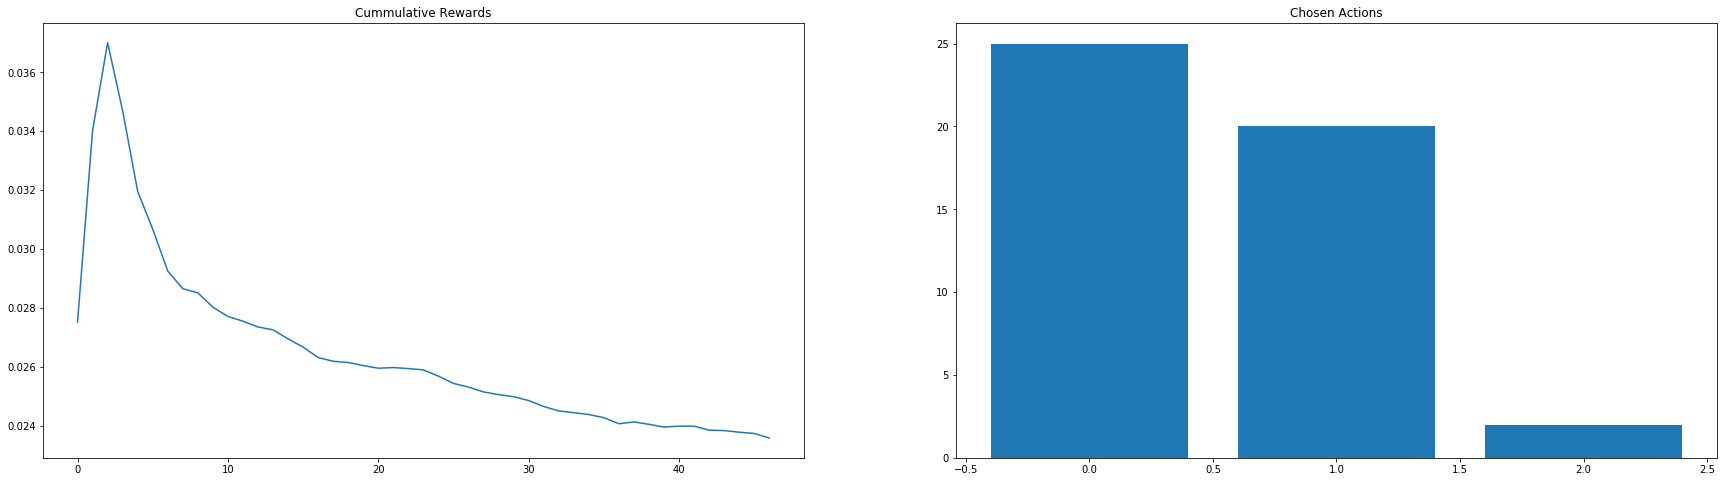

Restart at iteration: 1348
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.021450277273040476, 'merge_sort': 0.0250215800042497, 'heap_sort': 0.03158429999893997}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 5, 'heap_sort': 3}


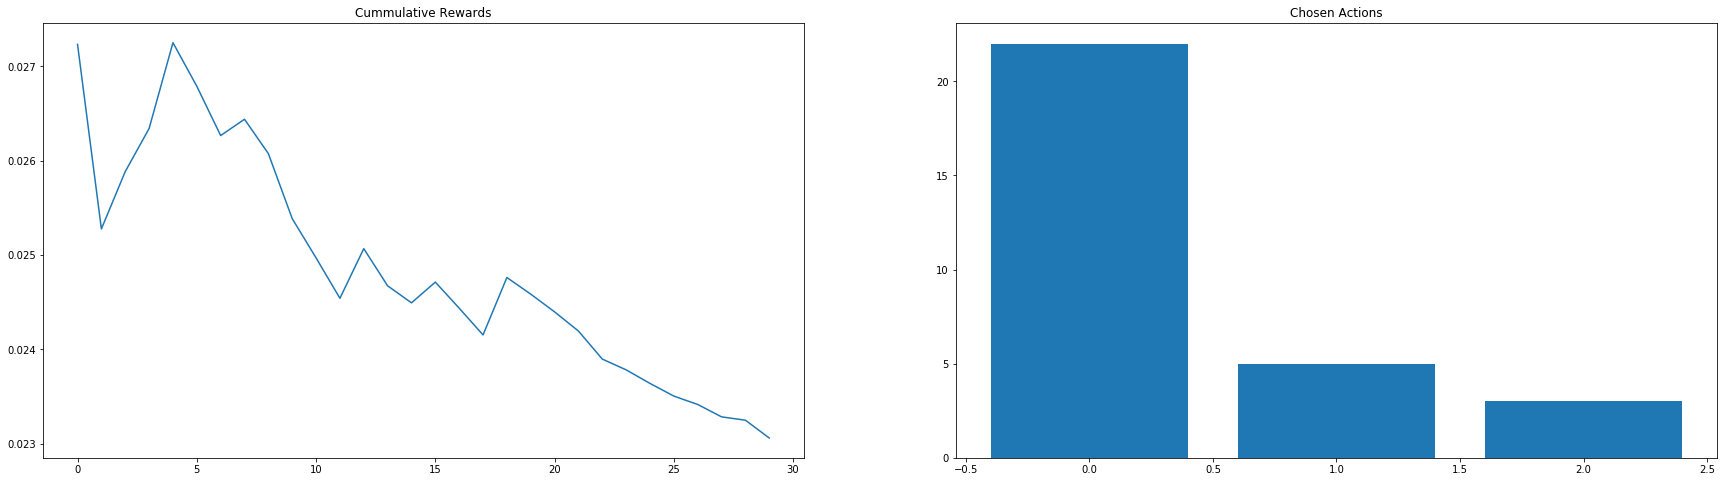

Restart at iteration: 1385
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.020928403571555725, 'merge_sort': 0.024149175002094125, 'heap_sort': 0.03553952000220306}
Count per chosen algo {'quick_sort': 28, 'merge_sort': 4, 'heap_sort': 5}


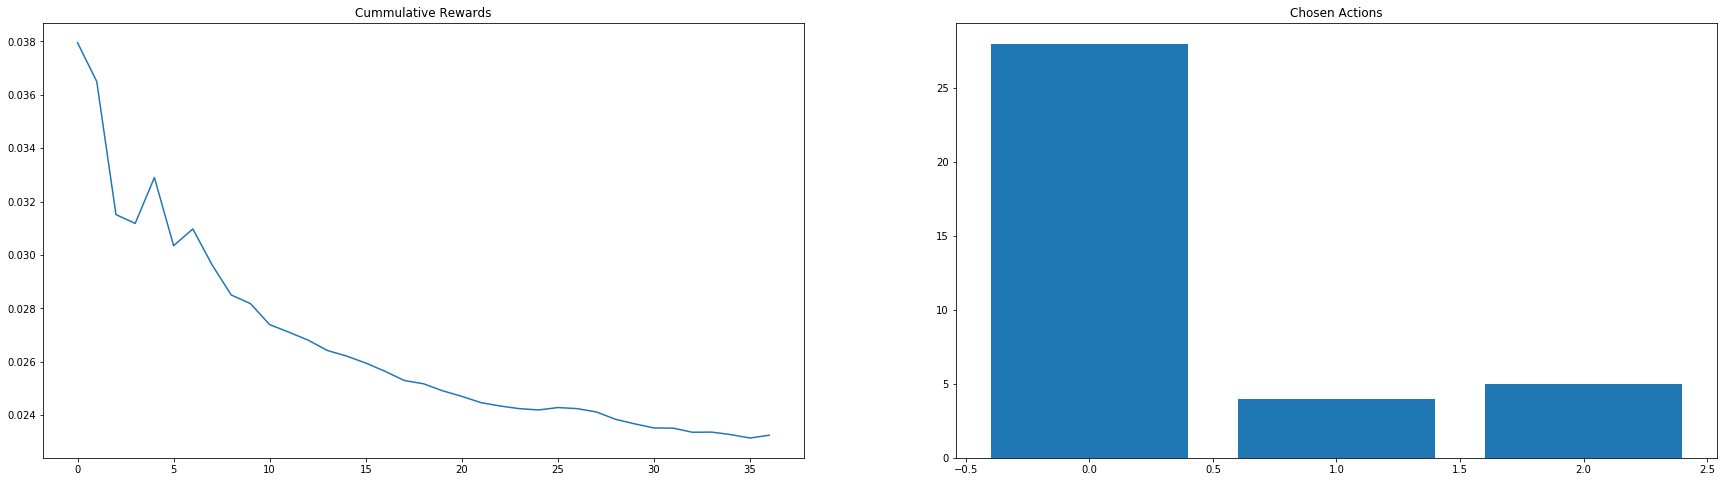

Restart at iteration: 1419
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.021618995998287573, 'merge_sort': 0.024030133337267518, 'heap_sort': 0.040736166663312666}
Count per chosen algo {'quick_sort': 25, 'merge_sort': 6, 'heap_sort': 3}


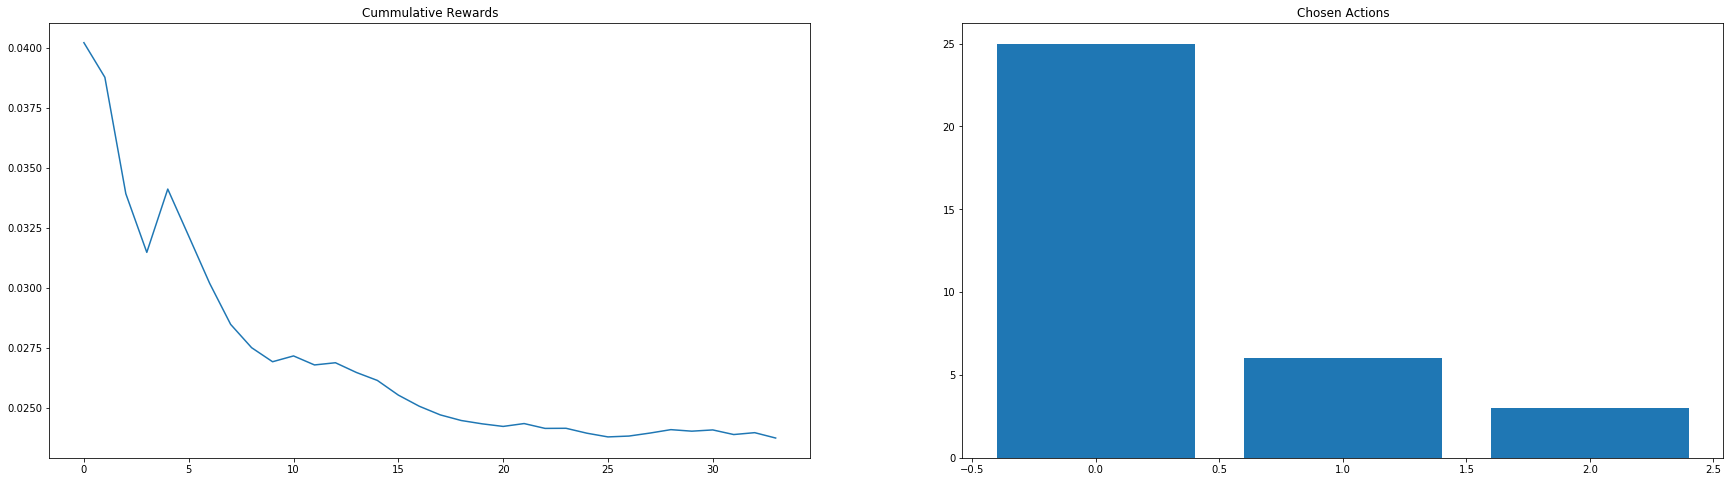

Restart at iteration: 1486
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02287688750012811, 'merge_sort': 0.025582800001656223, 'heap_sort': 0.044262149996939115}
Count per chosen algo {'quick_sort': 56, 'merge_sort': 9, 'heap_sort': 2}


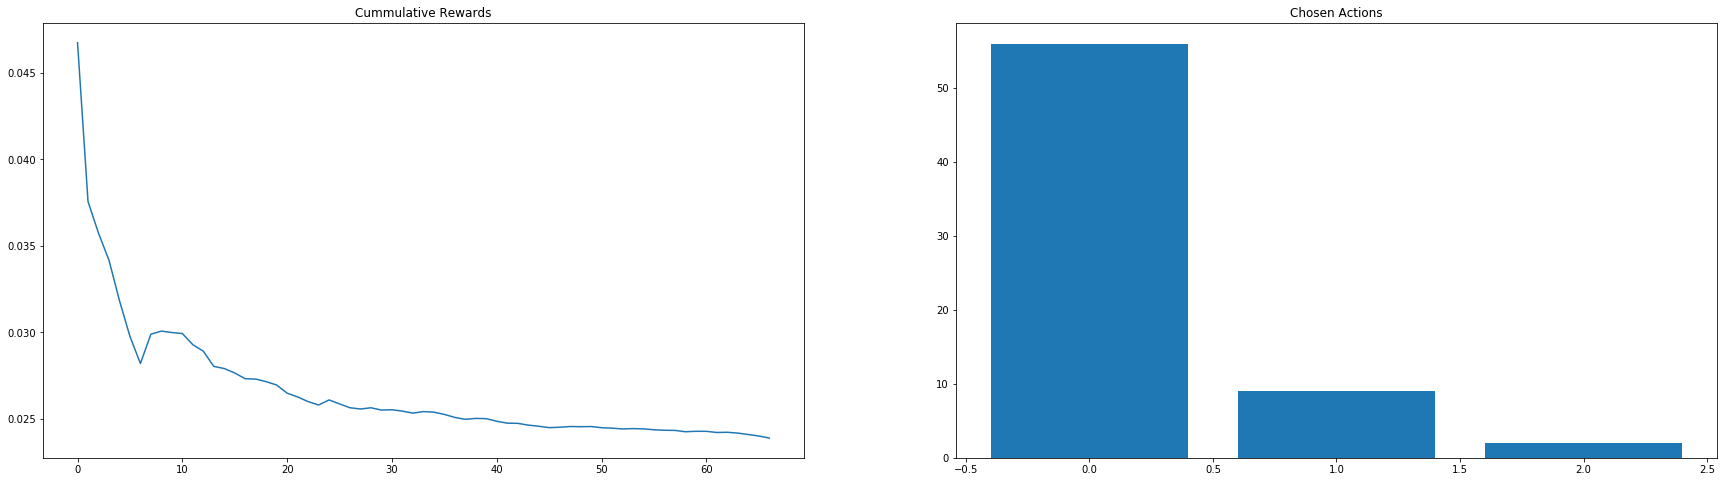

Restart at iteration: 1518
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.012636447826440892, 'merge_sort': 0.02894561666471418, 'heap_sort': 0.03902016666446192}
Count per chosen algo {'quick_sort': 23, 'merge_sort': 6, 'heap_sort': 3}


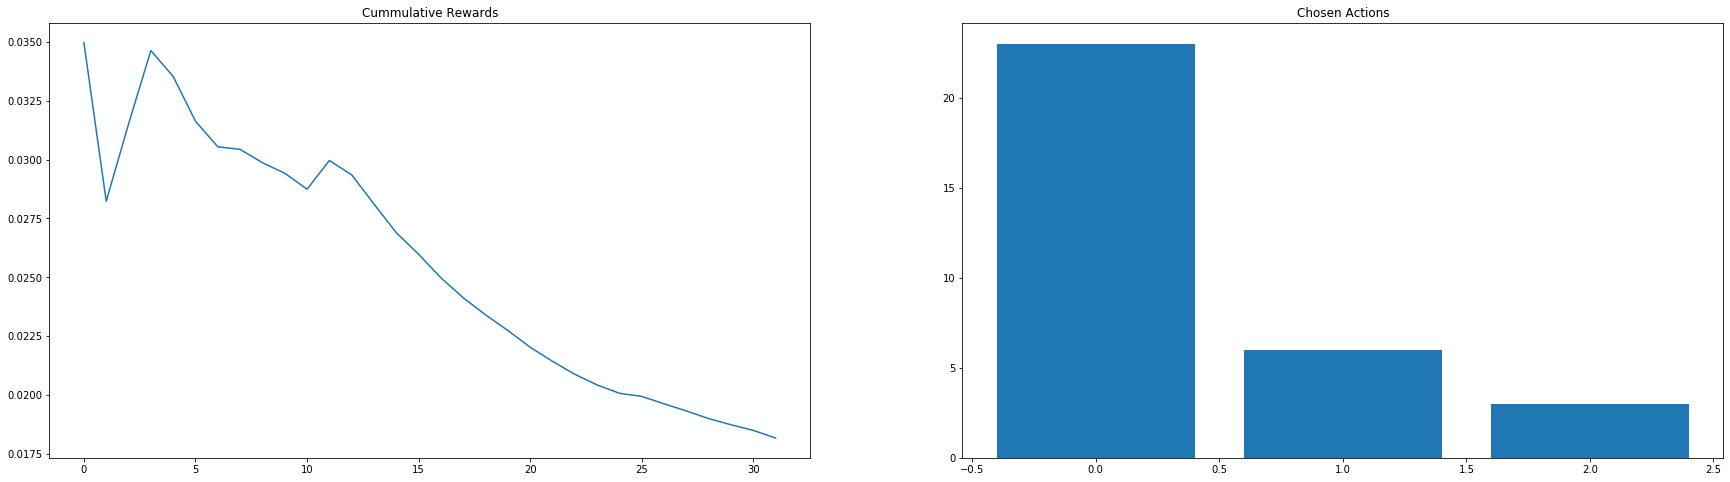

Restart at iteration: 1561
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.016847275001055095, 'merge_sort': 0.008142910810813584, 'heap_sort': 0.020958849992894102}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 37, 'heap_sort': 2}


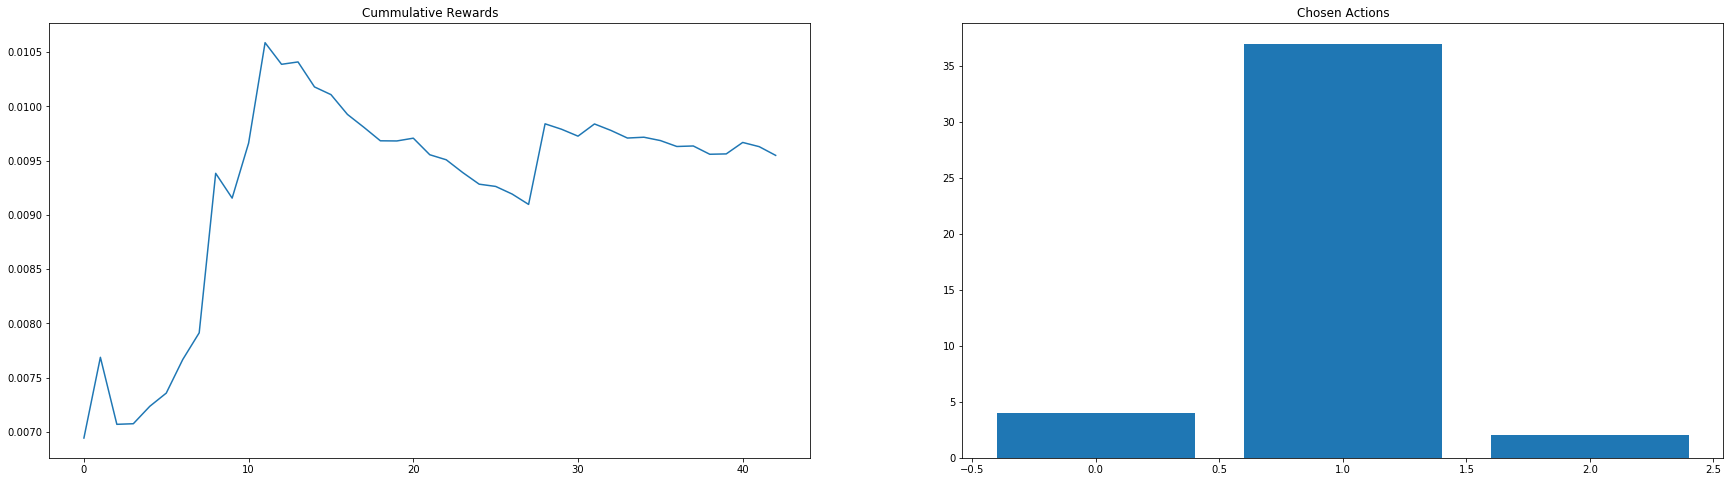

Restart at iteration: 1589
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009481850007432513, 'merge_sort': 0.0067446571414447615, 'heap_sort': 0.02123478000285104}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 21, 'heap_sort': 5}


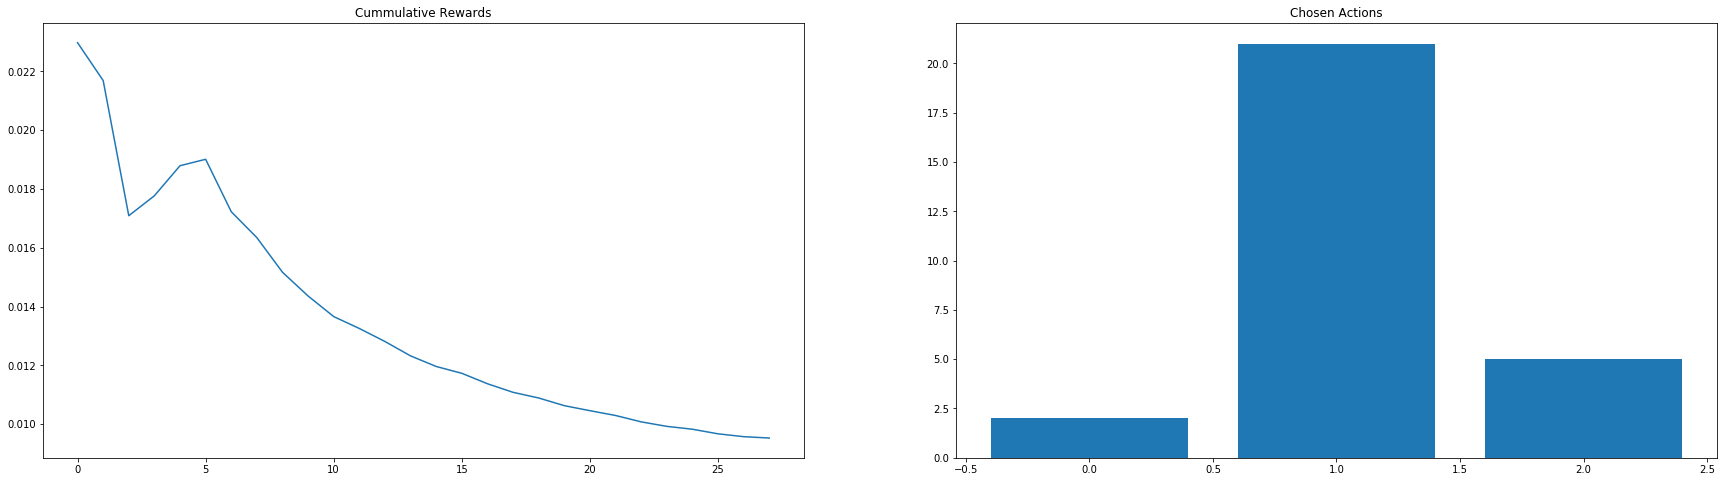

Restart at iteration: 1750
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009080287500182749, 'merge_sort': 0.006553133558688979, 'heap_sort': 0.017290425003011478}
Count per chosen algo {'quick_sort': 8, 'merge_sort': 149, 'heap_sort': 4}


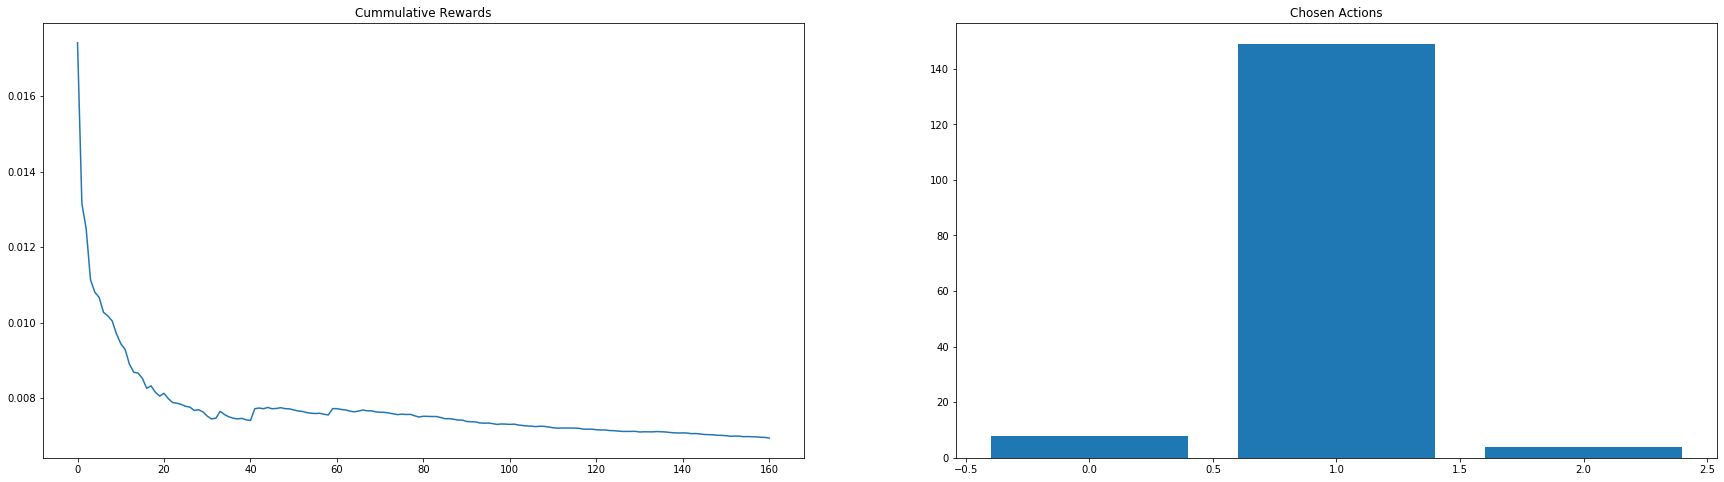

Restart at iteration: 1785
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008656499999536512, 'merge_sort': 0.006851056666346267, 'heap_sort': 0.01916959999653045}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 30, 'heap_sort': 2}


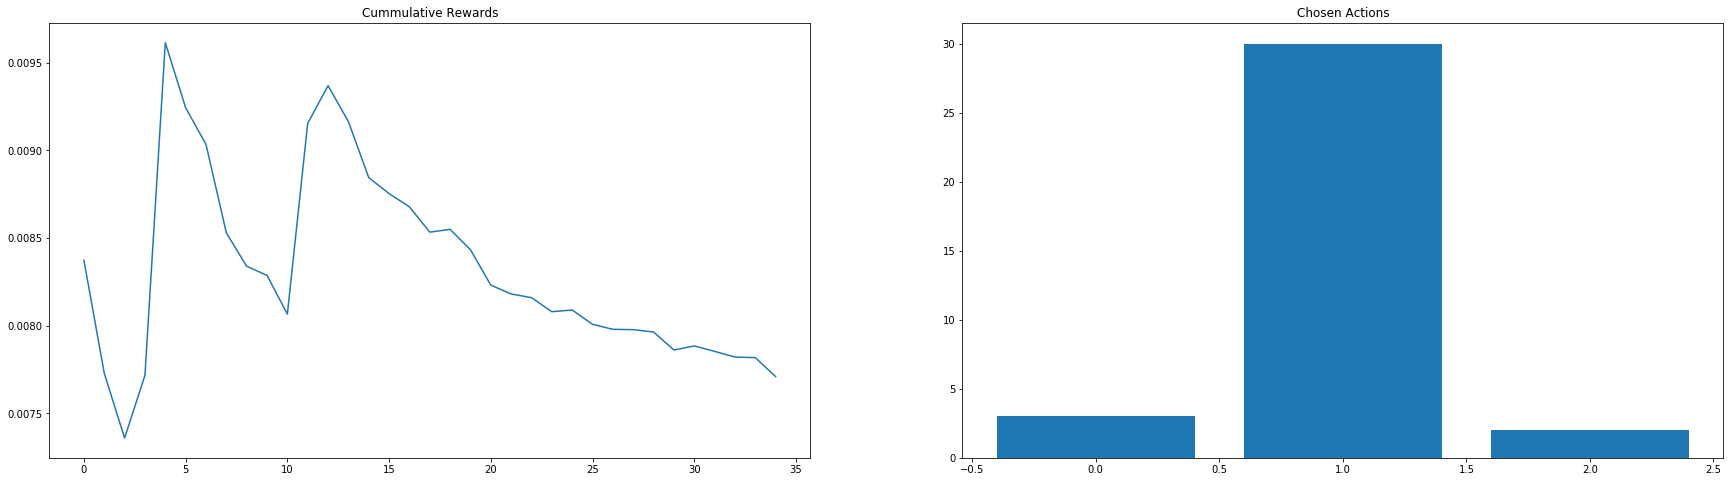

Restart at iteration: 1822
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008153325001330813, 'merge_sort': 0.006915142424545731, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 33, 'heap_sort': 0}


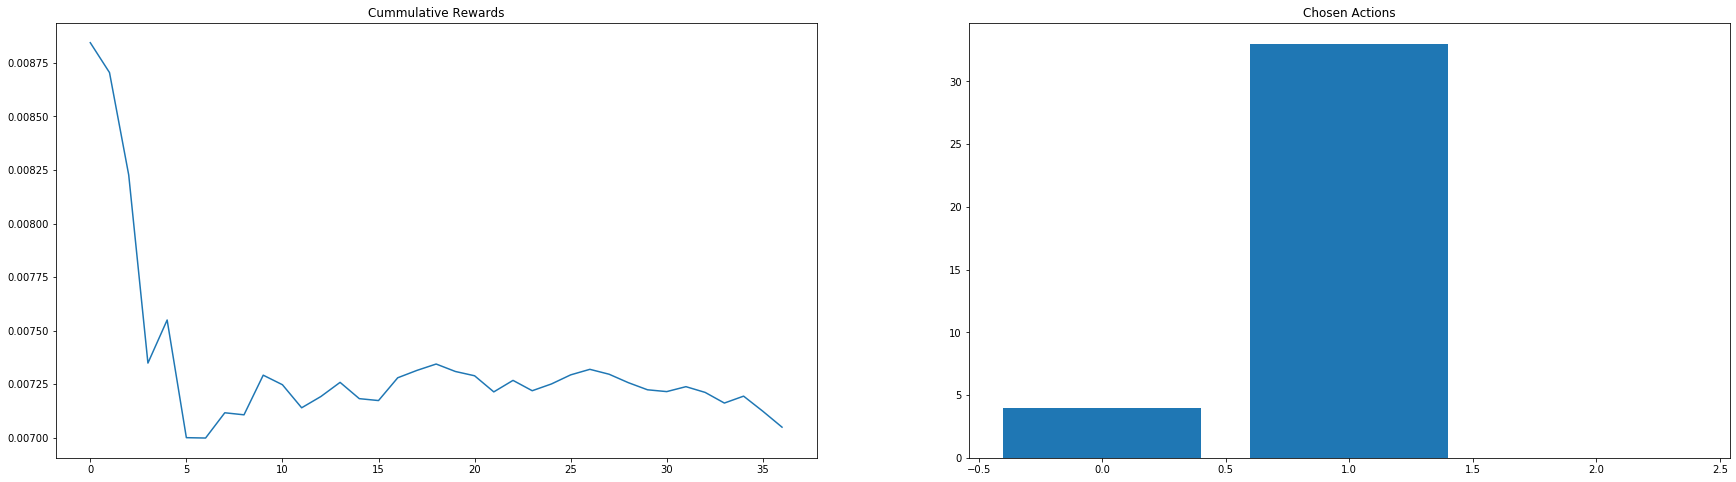

Restart at iteration: 1864
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.010161950005567633, 'merge_sort': 0.00714528157856732, 'heap_sort': 0.017107550003856886}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 38, 'heap_sort': 2}


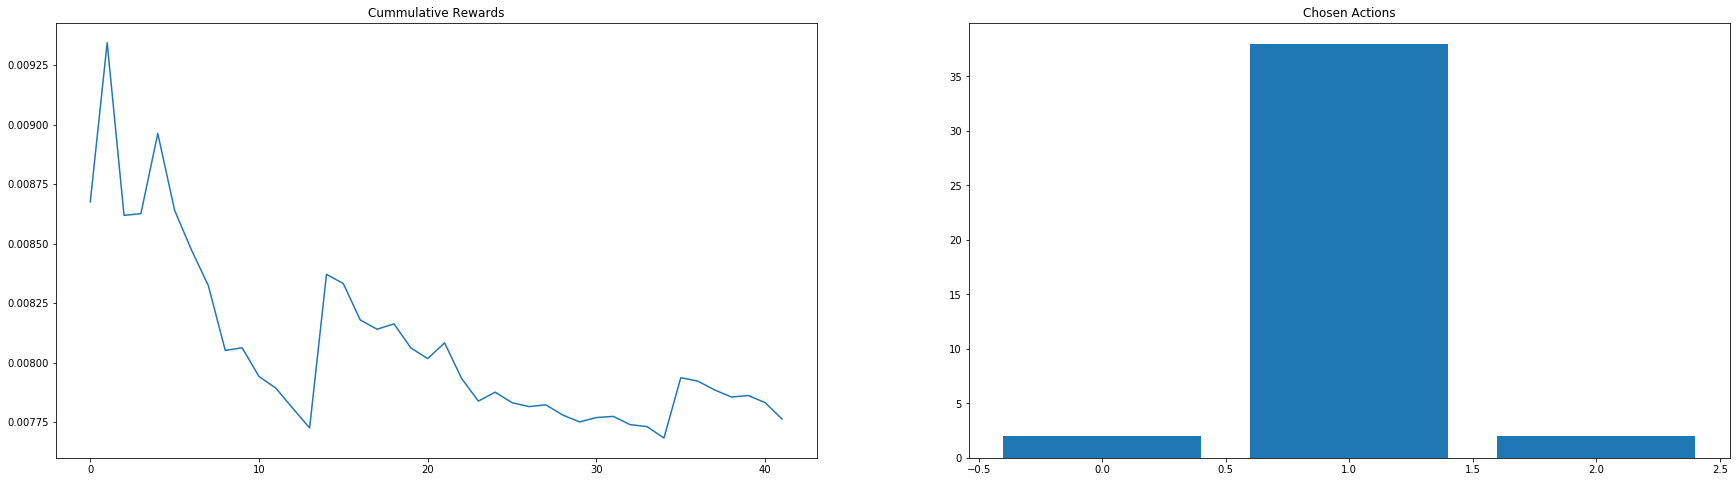

Restart at iteration: 1900
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009602549995179288, 'merge_sort': 0.006838946874722751, 'heap_sort': 0.01779605000774609}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 32, 'heap_sort': 2}


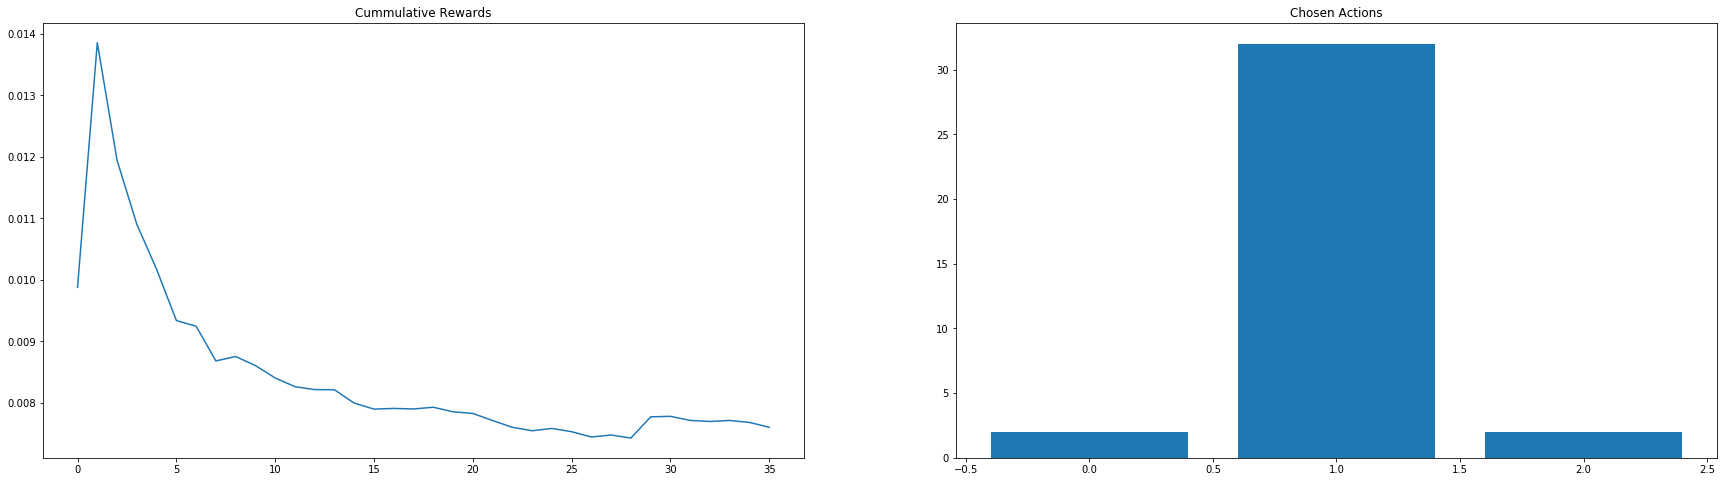

Restart at iteration: 1952
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.011043800002274414, 'merge_sort': 0.00674631458271809, 'heap_sort': 0.014194300005328842}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 48, 'heap_sort': 1}


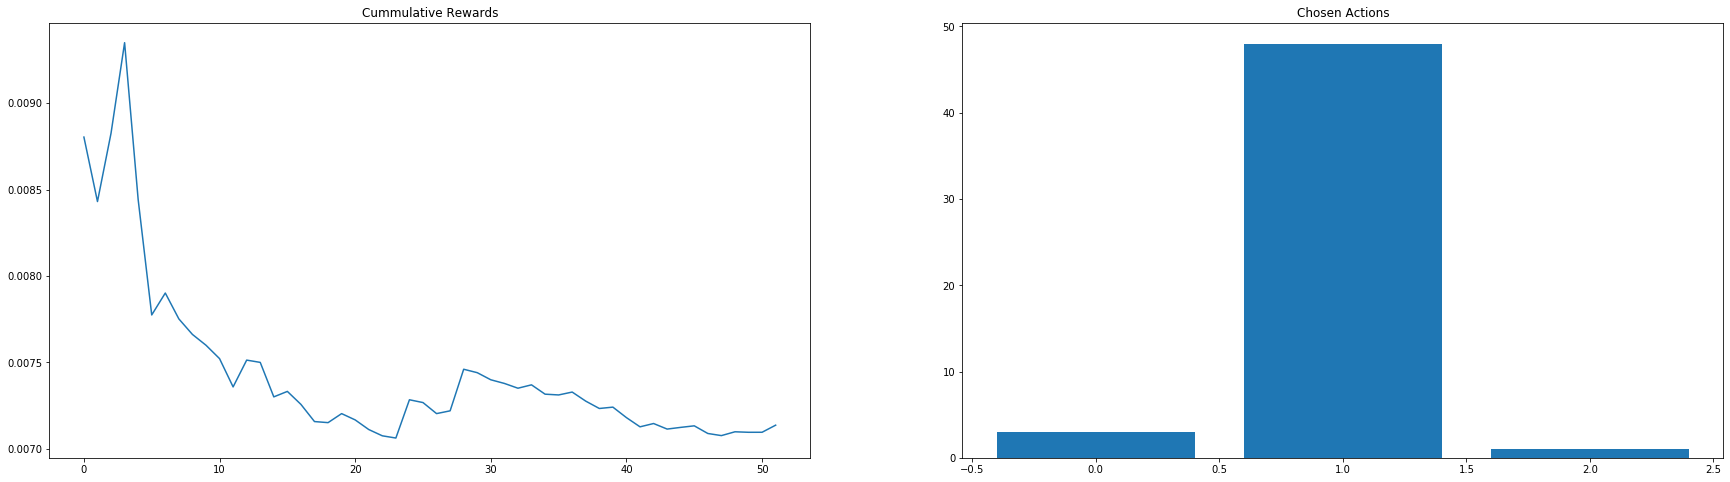

Restart at iteration: 1998
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009874600007606205, 'merge_sort': 0.006649514633619863, 'heap_sort': 0.017124933331312302}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 41, 'heap_sort': 3}


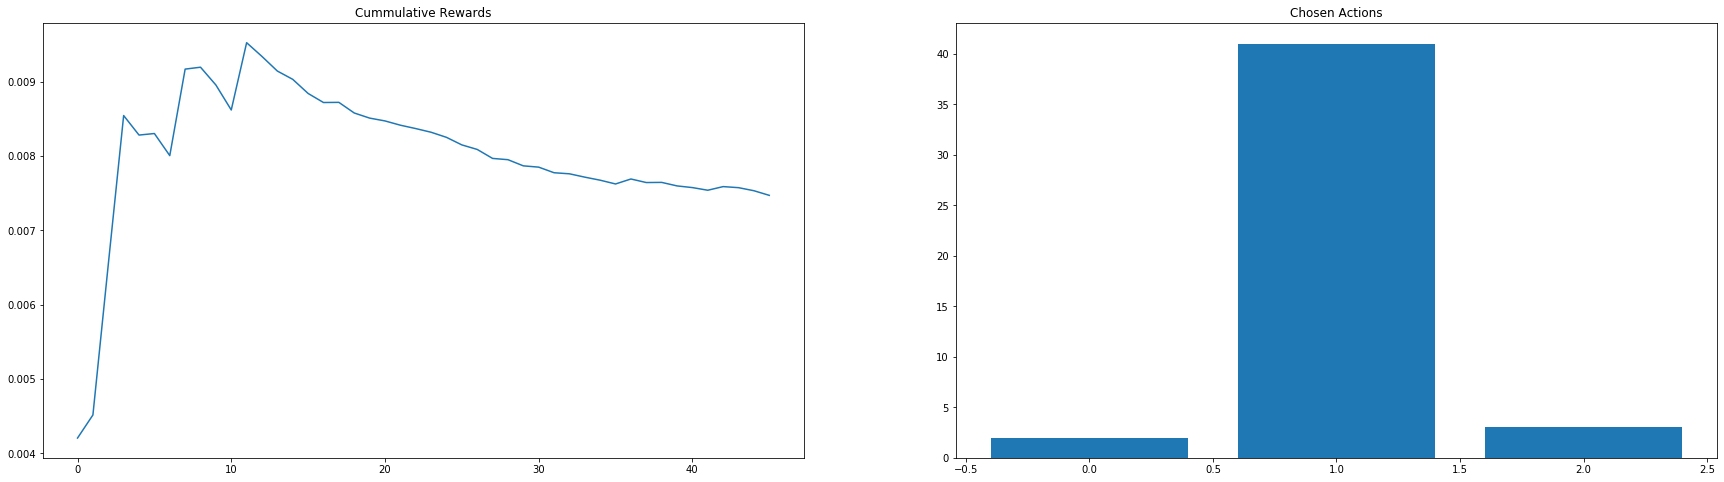

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.006505299999844283, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 1, 'heap_sort': 0}


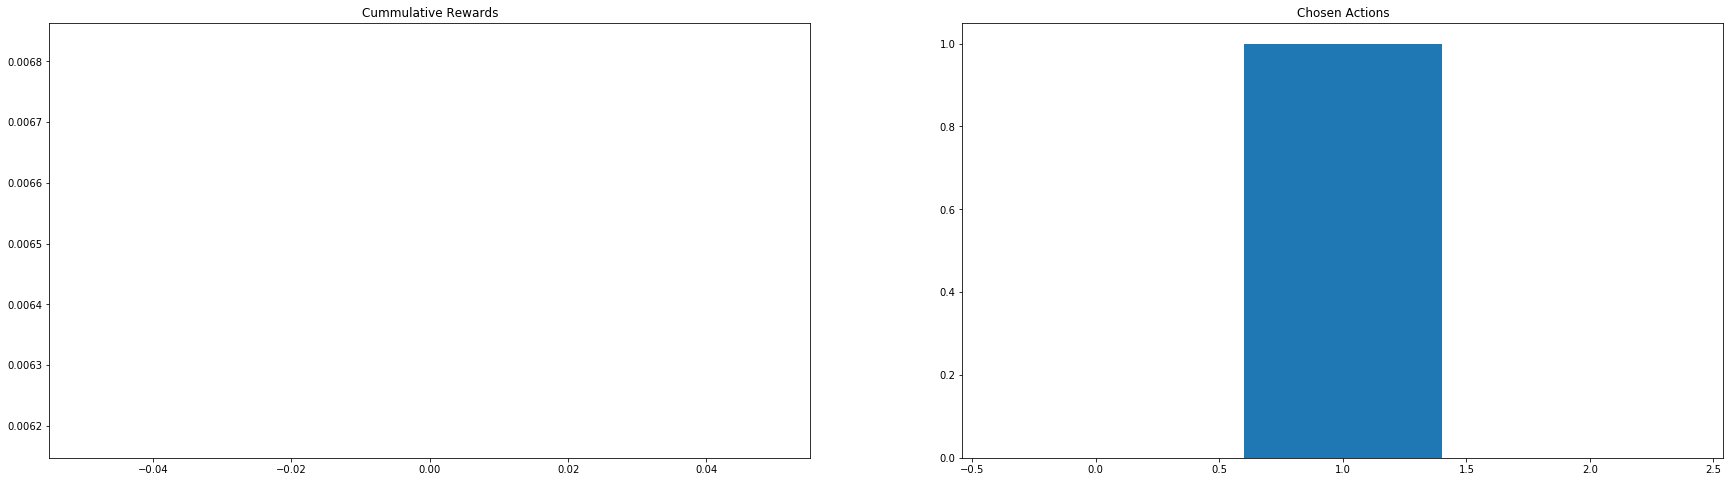

Total reward 29.0921


In [42]:
for elem in list_iteration_results_1:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_1,4))

## Two outliers in a row restart the expriment

In [43]:
list_iteration_results_2, total_reward_2, arm_rewards_2 = ts_quantile(list_distributions, n_samples, num_consec_elem=2)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.026924254567870023
Less than two values for merge_sort
merge_sort Theta 0.08139177135549286
Less than two values for heap_sort
heap_sort Theta 0.06417680252395859


Chosen algorithm is:  quick_sort with reward: 0.02107419999083504
Sample mean is:  0.02107419999083504 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.08427899235845102
Less than two values for merge_sort
merge_sort Theta 0.07625645519835086
Less than two values for heap_sort
heap_sort Theta 0.02193388385391386


Chosen algorithm is:  heap_sort with reward: 0.036344599997391924
Sample mean is:  0.036344599997391924 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.016592256507396763
Less than two values for merge_sort
merge_sort Theta 0.04323110504923847
Less than two values for heap_sort
heap_sort Theta 0.07610208717655986


Chosen algorithm is:  quick_sort with rew



Chosen algorithm is:  quick_sort with reward: 0.022309699998004362
Sample mean is:  0.021798325001145712 Sample variance is: 1.0057830321119344e-05


Iteration: 29
quick_sort Theta 0.02108129896945898
merge_sort Theta 0.02220800236022202
heap_sort Theta 0.04480905255471104


Chosen algorithm is:  quick_sort with reward: 0.023571300000185147
Sample mean is:  0.021882752382052353 Sample variance is: 9.721445673048754e-06


Iteration: 30
quick_sort Theta 0.02265852448556968
merge_sort Theta 0.021904193919733764
heap_sort Theta 0.041729936020275915


Chosen algorithm is:  merge_sort with reward: 0.03213110000069719
Sample mean is:  0.024780574995020288 Sample variance is: 2.4036239656111564e-05


Iteration: 31
quick_sort Theta 0.02202621978884657
merge_sort Theta 0.02515757724882955
heap_sort Theta 0.04151997390877217


Chosen algorithm is:  quick_sort with reward: 0.024234500000602566
Sample mean is:  0.021989650001077363 Sample variance is: 9.519530898836808e-06


Iteration: 32
quick_s



Chosen algorithm is:  quick_sort with reward: 0.023154799986514263
Sample mean is:  0.021239947917213915 Sample variance is: 1.534612105277896e-05


Iteration: 61
quick_sort Theta 0.020767760199368487
merge_sort Theta 0.02502723513710245
heap_sort Theta 0.03879747259382573


Chosen algorithm is:  quick_sort with reward: 0.01848809998773504
Sample mean is:  0.021183787755387817 Sample variance is: 1.518432517010871e-05


Iteration: 62
quick_sort Theta 0.02074663119766364
merge_sort Theta 0.028006701960497885
heap_sort Theta 0.020577443581350212


Chosen algorithm is:  heap_sort with reward: 0.030316999997012317
Sample mean is:  0.03548137500183657 Sample variance is: 3.472378572756208e-05


Iteration: 63
quick_sort Theta 0.02167159730820696
merge_sort Theta 0.02692093179584011
heap_sort Theta 0.03455596953541294


Chosen algorithm is:  quick_sort with reward: 0.02558409998891875
Sample mean is:  0.021271794000058436 Sample variance is: 1.5260148522656755e-05


Iteration: 64
quick_sort


Chosen algorithm is:  quick_sort with reward: 0.022734199999831617
Sample mean is:  0.020835334177775885 Sample variance is: 1.428192753612727e-05


Iteration: 93
quick_sort Theta 0.020905551502487258
merge_sort Theta 0.0279488256853989
heap_sort Theta 0.034103315676708615


Chosen algorithm is:  quick_sort with reward: 0.02279800000542309
Sample mean is:  0.020859867500621476 Sample variance is: 1.4150952272383515e-05


Iteration: 94
quick_sort Theta 0.02063513405120346
merge_sort Theta 0.02208840600130134
heap_sort Theta 0.03401179534582556


Chosen algorithm is:  quick_sort with reward: 0.01820370000496041
Sample mean is:  0.020827075309317017 Sample variance is: 1.4062275382753493e-05


Iteration: 95
quick_sort Theta 0.020563118466516952
merge_sort Theta 0.025458593827229755
heap_sort Theta 0.02794954919579188


Chosen algorithm is:  quick_sort with reward: 0.01756589999422431
Sample mean is:  0.020787304878645156 Sample variance is: 1.4018900879171043e-05


Iteration: 96
quick_so

merge_sort Theta 0.09643182262199115
heap_sort Theta 0.0380092110417442


Chosen algorithm is:  quick_sort with reward: 0.025617800012696534
Sample mean is:  0.023315911113362137 Sample variance is: 1.0461675988409443e-05


Iteration: 122
quick_sort Theta 0.023675078126451934
Less than two values for merge_sort
merge_sort Theta 0.03215499330132319
heap_sort Theta 0.03358218221602444


Chosen algorithm is:  quick_sort with reward: 0.029907400006777607
Sample mean is:  0.023975060002703684 Sample variance is: 1.3325803714450251e-05


Iteration: 123
quick_sort Theta 0.024815803116092133
Less than two values for merge_sort
merge_sort Theta 0.04351257997922575
heap_sort Theta 0.0518974492136493


Chosen algorithm is:  quick_sort with reward: 0.02546279999660328
Sample mean is:  0.024110309093058193 Sample variance is: 1.2297290177553814e-05


Iteration: 124
quick_sort Theta 0.024118746175551695
Less than two values for merge_sort
merge_sort Theta 0.01799245808475767
heap_sort Theta 0.032970


Chosen algorithm is:  quick_sort with reward: 0.024510100003681146
Sample mean is:  0.022778611538972024 Sample variance is: 1.0971741627265176e-05


Iteration: 151
quick_sort Theta 0.023128906735783616
merge_sort Theta 0.023297962167435668
heap_sort Theta 0.03482747215057615


Chosen algorithm is:  quick_sort with reward: 0.02125499999965541
Sample mean is:  0.0227221814819603 Sample variance is: 1.0648173960948367e-05


Iteration: 152
quick_sort Theta 0.023079087841154124
merge_sort Theta 0.024204427982053744
heap_sort Theta 0.03661976588068457


Chosen algorithm is:  quick_sort with reward: 0.020355500004370697
Sample mean is:  0.022637657143474956 Sample variance is: 1.046077985627403e-05


Iteration: 153
quick_sort Theta 0.0220762098733685
merge_sort Theta 0.02524329873157918
heap_sort Theta 0.042634956106431005


Chosen algorithm is:  quick_sort with reward: 0.021610099996905774
Sample mean is:  0.022602224138420845 Sample variance is: 1.0135217249226569e-05


Iteration: 154
qui



Iteration: 182
quick_sort Theta 0.021247101732091524
merge_sort Theta 0.02353223013009457
heap_sort Theta 0.03847763432262542


Chosen algorithm is:  quick_sort with reward: 0.019260100001702085
Sample mean is:  0.02143972068959807 Sample variance is: 7.0661642101719746e-06


Iteration: 183
quick_sort Theta 0.021342315620358834
merge_sort Theta 0.02368311629321263
heap_sort Theta 0.03589881256531827


Chosen algorithm is:  quick_sort with reward: 0.021820499998284504
Sample mean is:  0.021446174576185976 Sample variance is: 6.94881456890551e-06


Iteration: 184
quick_sort Theta 0.02175287314150264
merge_sort Theta 0.023992607917595724
heap_sort Theta 0.03322317275207358


Chosen algorithm is:  quick_sort with reward: 0.0215543000085745
Sample mean is:  0.021447976666725783 Sample variance is: 6.833192597045592e-06


Iteration: 185
quick_sort Theta 0.021782576536767757
merge_sort Theta 0.024697832551785093
heap_sort Theta 0.036971292336912605


Chosen algorithm is:  quick_sort with re


Chosen algorithm is:  quick_sort with reward: 0.022294499998679385
Sample mean is:  0.021328906895794864 Sample variance is: 5.447287863711206e-06


Iteration: 213
quick_sort Theta 0.021327762258487478
merge_sort Theta 0.024711434118282888
heap_sort Theta 0.035849757364121375


Chosen algorithm is:  quick_sort with reward: 0.02301360000274144
Sample mean is:  0.02134805113564653 Sample variance is: 5.417272532256277e-06


Iteration: 214
quick_sort Theta 0.02097801111213042
merge_sort Theta 0.0246246693798837
heap_sort Theta 0.03616408059412836


Chosen algorithm is:  quick_sort with reward: 0.018873799999710172
Sample mean is:  0.021320250561085444 Sample variance is: 5.4244170327982846e-06


Iteration: 215
quick_sort Theta 0.021420228542958986
merge_sort Theta 0.025234163916412082
heap_sort Theta 0.03230545124173616


Chosen algorithm is:  quick_sort with reward: 0.0197908000118332
Sample mean is:  0.021303256666093753 Sample variance is: 5.389848261995848e-06


Iteration: 216
quick_


Chosen algorithm is:  quick_sort with reward: 0.025904399997671135
Sample mean is:  0.02190580672206369 Sample variance is: 7.194206536510055e-06


Iteration: 245
quick_sort Theta 0.02213195862105828
merge_sort Theta 0.02474805021955322
heap_sort Theta 0.034370006789331456


Chosen algorithm is:  quick_sort with reward: 0.026531499999691732
Sample mean is:  0.02194435416604392 Sample variance is: 7.311077562424173e-06


Iteration: 246
quick_sort Theta 0.021852354173507896
merge_sort Theta 0.023652848093346786
heap_sort Theta 0.034916271414253304


Chosen algorithm is:  quick_sort with reward: 0.027960999999777414
Sample mean is:  0.021994078511777256 Sample variance is: 7.547356700842081e-06


Iteration: 247
quick_sort Theta 0.02224346668647119
merge_sort Theta 0.024113192932989854
heap_sort Theta 0.03599422644640999


Chosen algorithm is:  quick_sort with reward: 0.02571689999604132
Sample mean is:  0.022024593441976142 Sample variance is: 7.598163598097169e-06


Iteration: 248
quick


Chosen algorithm is:  quick_sort with reward: 0.020053500003996305
Sample mean is:  0.01836030000122264 Sample variance is: 2.8898289135889166e-06


Iteration: 275
quick_sort Theta 0.020363016875065146
merge_sort Theta 0.0199869780038908
heap_sort Theta 0.02658314677064102


Chosen algorithm is:  merge_sort with reward: 0.02273669998976402
Sample mean is:  0.021458774994243868 Sample variance is: 9.809769155174643e-07


Iteration: 276
quick_sort Theta 0.01815436733321642
merge_sort Theta 0.02068000887764859
heap_sort Theta 0.02936393559444691


Chosen algorithm is:  quick_sort with reward: 0.020096099993679672
Sample mean is:  0.018649599999965478 Sample variance is: 2.8266632076871292e-06


Iteration: 277
quick_sort Theta 0.01919465123092789
merge_sort Theta 0.023067101775973067
heap_sort Theta 0.02728962223115835


Chosen algorithm is:  quick_sort with reward: 0.021496200002729893
Sample mean is:  0.01905625714321754 Sample variance is: 3.4150743709650942e-06


Iteration: 278
quick_


Chosen algorithm is:  quick_sort with reward: 0.019449100000201724
Sample mean is:  0.01931798378260479 Sample variance is: 4.527558529760902e-06


Iteration: 309
quick_sort Theta 0.01966665823994553
merge_sort Theta 0.021291438902314736
heap_sort Theta 0.02914050171555541


Chosen algorithm is:  quick_sort with reward: 0.020694799997727387
Sample mean is:  0.019354215788265912 Sample variance is: 4.456984307328348e-06


Iteration: 310
quick_sort Theta 0.019474865041812603
merge_sort Theta 0.021396265402277143
heap_sort Theta 0.029782260955052424


Chosen algorithm is:  quick_sort with reward: 0.019262100002379157
Sample mean is:  0.019351853845038045 Sample variance is: 4.342914651903336e-06


Iteration: 311
quick_sort Theta 0.019621060985952173
merge_sort Theta 0.020723401327376028
heap_sort Theta 0.025121497009608865


Chosen algorithm is:  quick_sort with reward: 0.02105199999641627
Sample mean is:  0.0193943574988225 Sample variance is: 4.304797648421878e-06


Iteration: 312
quic


Iteration: 339
quick_sort Theta 0.02211333532256226
merge_sort Theta 0.02206870908266665
heap_sort Theta 0.036243823122228506


Chosen algorithm is:  merge_sort with reward: 0.022909000006620772
Sample mean is:  0.022144916667457437 Sample variance is: 6.490615917214902e-06


Iteration: 340
quick_sort Theta 0.020992389232172854
merge_sort Theta 0.023271879498525397
heap_sort Theta 0.029843138533839773


Chosen algorithm is:  quick_sort with reward: 0.017176900000777096
Sample mean is:  0.020952025000951835 Sample variance is: 5.381813274996843e-06


Iteration: 341
quick_sort Theta 0.021989056402921193
merge_sort Theta 0.022380766484798306
heap_sort Theta 0.033670296463770455


Chosen algorithm is:  quick_sort with reward: 0.017895299999509007
Sample mean is:  0.020612388889680408 Sample variance is: 5.706655526856024e-06


Iteration: 342
quick_sort Theta 0.020501499070786293
merge_sort Theta 0.02081434686478932
heap_sort Theta 0.0331781793822928


Chosen algorithm is:  quick_sort with


Iteration: 372
quick_sort Theta 0.019076730838557744
merge_sort Theta 0.022606831694187045
heap_sort Theta 0.03263986623351582


Chosen algorithm is:  quick_sort with reward: 0.022162900000694208
Sample mean is:  0.019665087501198285 Sample variance is: 4.733951987403967e-06


Iteration: 373
quick_sort Theta 0.018996975305441397
merge_sort Theta 0.022329392089918538
heap_sort Theta 0.030057404172872136


Chosen algorithm is:  quick_sort with reward: 0.01717530000314582
Sample mean is:  0.019604360976855542 Sample variance is: 4.765998174158739e-06


Iteration: 374
quick_sort Theta 0.01938386668393901
merge_sort Theta 0.02239754014105543
heap_sort Theta 0.03130146837178037


Chosen algorithm is:  quick_sort with reward: 0.02006529999198392
Sample mean is:  0.01961533571531098 Sample variance is: 4.657460267405735e-06


Iteration: 375
quick_sort Theta 0.019258941112141593
merge_sort Theta 0.021991834409006577
heap_sort Theta 0.03125010803726101


Chosen algorithm is:  quick_sort with re


Chosen algorithm is:  quick_sort with reward: 0.02130350000516046
Sample mean is:  0.019659315068466104 Sample variance is: 6.72582818829094e-06


Iteration: 406
quick_sort Theta 0.019937734451144145
merge_sort Theta 0.022235379310442525
heap_sort Theta 0.02823993436179663


Chosen algorithm is:  quick_sort with reward: 0.018287799990503117
Sample mean is:  0.019640781080926064 Sample variance is: 6.660014752850707e-06


Iteration: 407
quick_sort Theta 0.0197671306736224
merge_sort Theta 0.020070890369209584
heap_sort Theta 0.029457596547628404


Chosen algorithm is:  quick_sort with reward: 0.01619929999287706
Sample mean is:  0.019594894666418745 Sample variance is: 6.727026220835014e-06


Iteration: 408
quick_sort Theta 0.020080586237180717
merge_sort Theta 0.02125461874989613
heap_sort Theta 0.031087541135535458


Chosen algorithm is:  quick_sort with reward: 0.020696500010672025
Sample mean is:  0.019609389473579972 Sample variance is: 6.654270175527379e-06


Iteration: 409
quick


Iteration: 439
quick_sort Theta 0.020010762277299282
merge_sort Theta 0.021252187375997867
heap_sort Theta 0.03147316654254962


Chosen algorithm is:  quick_sort with reward: 0.017010299998219125
Sample mean is:  0.019589069811599812 Sample variance is: 6.990157071455271e-06


Iteration: 440
quick_sort Theta 0.019923149016915973
merge_sort Theta 0.022088771083681572
heap_sort Theta 0.03129178581649658


Chosen algorithm is:  quick_sort with reward: 0.02111739999963902
Sample mean is:  0.019603353271301114 Sample variance is: 6.946454326124109e-06


Iteration: 441
quick_sort Theta 0.019949492477450963
merge_sort Theta 0.022611817000521565
heap_sort Theta 0.030701535112782546


Chosen algorithm is:  quick_sort with reward: 0.023817799999960698
Sample mean is:  0.01964237592619611 Sample variance is: 7.045071437256696e-06


Iteration: 442
quick_sort Theta 0.01926100616937533
merge_sort Theta 0.021535047934783193
heap_sort Theta 0.02844568425082386


Chosen algorithm is:  quick_sort with 


Chosen algorithm is:  quick_sort with reward: 0.02434069999435451
Sample mean is:  0.01963450434761952 Sample variance is: 7.652223589805212e-06


Iteration: 472
quick_sort Theta 0.020026565440920335
merge_sort Theta 0.022450286547664386
heap_sort Theta 0.036766461787314964


Chosen algorithm is:  quick_sort with reward: 0.017212999999173917
Sample mean is:  0.019617083453026384 Sample variance is: 7.639052905975893e-06


Iteration: 473
quick_sort Theta 0.01945116443877491
merge_sort Theta 0.020442216741379127
heap_sort Theta 0.03202939965538293


Chosen algorithm is:  quick_sort with reward: 0.017839899999671616
Sample mean is:  0.019604389285502424 Sample variance is: 7.606886964950349e-06


Iteration: 474
quick_sort Theta 0.019128221411410577
merge_sort Theta 0.022890332294649606
heap_sort Theta 0.031070122808821054


Chosen algorithm is:  quick_sort with reward: 0.020445999994990416
Sample mean is:  0.01961035815578248 Sample variance is: 7.557925249746259e-06


Iteration: 475
qui



Chosen algorithm is:  heap_sort with reward: 0.017424100005882792
Sample mean is:  0.017424100005882792 Sample variance is: 0.0


Iteration: 503
Less than two values for quick_sort
quick_sort Theta 0.08817061138795201
Less than two values for merge_sort
merge_sort Theta 0.038306100185679974
Less than two values for heap_sort
heap_sort Theta 0.03955029839867011


Chosen algorithm is:  merge_sort with reward: 0.005506200002855621
Sample mean is:  0.005506200002855621 Sample variance is: 0.0


Iteration: 504
Less than two values for quick_sort
quick_sort Theta 0.07957213791653212
Less than two values for merge_sort
merge_sort Theta 0.02619266401697369
Less than two values for heap_sort
heap_sort Theta 0.013447989949822582


Chosen algorithm is:  heap_sort with reward: 0.01279729999077972
Sample mean is:  0.015110699998331256 Sample variance is: 5.351819594939447e-06


Iteration: 505
Less than two values for quick_sort
quick_sort Theta 0.03174267137802794
Less than two values for merge_s



Chosen algorithm is:  merge_sort with reward: 0.0068802000023424625
Sample mean is:  0.006411334781897376 Sample variance is: 1.9154192289401593e-06


Iteration: 535
quick_sort Theta 0.009574348956736025
merge_sort Theta 0.006244937059079399
heap_sort Theta 0.015162533642514716


Chosen algorithm is:  merge_sort with reward: 0.006411500013200566
Sample mean is:  0.006411341666535009 Sample variance is: 1.835610095491145e-06


Iteration: 536
quick_sort Theta 0.009506863643296708
merge_sort Theta 0.006094284183858122
heap_sort Theta 0.015325627152938615


Chosen algorithm is:  merge_sort with reward: 0.007529700000304729
Sample mean is:  0.006456075999885798 Sample variance is: 1.8102135455996472e-06


Iteration: 537
quick_sort Theta 0.00880622786302851
merge_sort Theta 0.006725962832183898
heap_sort Theta 0.013232811606644173


Chosen algorithm is:  merge_sort with reward: 0.004923100001178682
Sample mean is:  0.006397115384550909 Sample variance is: 1.8274988017086873e-06


Iteration


Chosen algorithm is:  merge_sort with reward: 0.005375499997171573
Sample mean is:  0.006682918868291209 Sample variance is: 8.402935715857222e-06


Iteration: 566
quick_sort Theta 0.009243361538040458
merge_sort Theta 0.006362442069214326
heap_sort Theta 0.01480673894812273


Chosen algorithm is:  merge_sort with reward: 0.007928800012450665
Sample mean is:  0.006705990741331199 Sample variance is: 8.27553829544859e-06


Iteration: 567
quick_sort Theta 0.009110097047911662
merge_sort Theta 0.0067654971741546305
heap_sort Theta 0.01476501096680878


Chosen algorithm is:  merge_sort with reward: 0.0064578000019537285
Sample mean is:  0.006701478182433427 Sample variance is: 8.126173574945586e-06


Iteration: 568
quick_sort Theta 0.008310458976213336
merge_sort Theta 0.006656326661449956
heap_sort Theta 0.013513248462554089


Chosen algorithm is:  merge_sort with reward: 0.006607400006032549
Sample mean is:  0.0066997982149976975 Sample variance is: 7.981218558518025e-06


Iteration: 56


Iteration: 598
quick_sort Theta 0.007866841057953914
merge_sort Theta 0.006563244740680081
heap_sort Theta 0.015454545759519395


Chosen algorithm is:  merge_sort with reward: 0.0069900000089546666
Sample mean is:  0.006850841861092323 Sample variance is: 5.969102306879826e-06


Iteration: 599
quick_sort Theta 0.008994121116915848
merge_sort Theta 0.006709764208120118
heap_sort Theta 0.014733594196966984


Chosen algorithm is:  merge_sort with reward: 0.010699399994337
Sample mean is:  0.006895078161474446 Sample variance is: 6.068781058885157e-06


Iteration: 600
quick_sort Theta 0.009457496584639262
merge_sort Theta 0.006629995457370631
heap_sort Theta 0.014567724239877197


Chosen algorithm is:  merge_sort with reward: 0.004009099997347221
Sample mean is:  0.006862282955063909 Sample variance is: 6.093388361786805e-06


Iteration: 601
quick_sort Theta 0.008255835176447741
merge_sort Theta 0.007160672657067428
heap_sort Theta 0.01415582368739779


Chosen algorithm is:  merge_sort wi


Chosen algorithm is:  merge_sort with reward: 0.008023799993679859
Sample mean is:  0.006818730833523053 Sample variance is: 5.156438507342536e-06


Iteration: 633
quick_sort Theta 0.0098942561989504
merge_sort Theta 0.007059481328028696
heap_sort Theta 0.01475674071442892


Chosen algorithm is:  merge_sort with reward: 0.0056065999960992485
Sample mean is:  0.00680871322329641 Sample variance is: 5.125865614825329e-06


Iteration: 634
quick_sort Theta 0.008246155593337644
merge_sort Theta 0.0069134123428806465
heap_sort Theta 0.013984223666323207


Chosen algorithm is:  merge_sort with reward: 0.005975699998089112
Sample mean is:  0.006801885246040613 Sample variance is: 5.0894914969826215e-06


Iteration: 635
quick_sort Theta 0.008958296204310396
merge_sort Theta 0.006992137236259654
heap_sort Theta 0.014541254011887552


Chosen algorithm is:  merge_sort with reward: 0.007850299996789545
Sample mean is:  0.006810408943201173 Sample variance is: 5.056977233753119e-06


Iteration: 636



Iteration: 666
quick_sort Theta 0.007883007917772036
merge_sort Theta 0.006716071031439292
heap_sort Theta 0.016398054542599405


Chosen algorithm is:  merge_sort with reward: 0.006442500001867302
Sample mean is:  0.006691051948027135 Sample variance is: 4.383271517150956e-06


Iteration: 667
quick_sort Theta 0.00989787005293453
merge_sort Theta 0.00696280661979474
heap_sort Theta 0.014416952587330755


Chosen algorithm is:  merge_sort with reward: 0.006635400000959635
Sample mean is:  0.006690692903207345 Sample variance is: 4.355012198702686e-06


Iteration: 668
quick_sort Theta 0.008654519197141202
merge_sort Theta 0.006667774967799014
heap_sort Theta 0.014779317802079282


Chosen algorithm is:  merge_sort with reward: 0.005598000003374182
Sample mean is:  0.006683688461541748 Sample variance is: 4.334700095311453e-06


Iteration: 669
quick_sort Theta 0.009436952002929783
merge_sort Theta 0.0067066819298636764
heap_sort Theta 0.01582667295904129


Chosen algorithm is:  merge_sort 


Iteration: 699
quick_sort Theta 0.008999218677881306
merge_sort Theta 0.006657396992746409
heap_sort Theta 0.015094236301272556


Chosen algorithm is:  merge_sort with reward: 0.0059674000076483935
Sample mean is:  0.006638326203104427 Sample variance is: 3.938710675779159e-06


Iteration: 700
quick_sort Theta 0.008692848673885194
merge_sort Theta 0.006451779724275926
heap_sort Theta 0.014811163319503507


Chosen algorithm is:  merge_sort with reward: 0.005899300012970343
Sample mean is:  0.006634395212731374 Sample variance is: 3.920649739231744e-06


Iteration: 701
quick_sort Theta 0.009498159289303372
merge_sort Theta 0.006764346176254007
heap_sort Theta 0.01428198707771965


Chosen algorithm is:  merge_sort with reward: 0.008079000006546266
Sample mean is:  0.0066420386243388595 Sample variance is: 3.9108888480255655e-06


Iteration: 702
quick_sort Theta 0.008801887852792475
merge_sort Theta 0.006836329719996147
heap_sort Theta 0.015375336740122935


Chosen algorithm is:  merge_so


Iteration: 725
Less than two values for quick_sort
quick_sort Theta 0.09846272784615039
merge_sort Theta 0.006201535699277342
Less than two values for heap_sort
heap_sort Theta 0.06121228658351651


Chosen algorithm is:  merge_sort with reward: 0.006015000006300397
Sample mean is:  0.006493792858756413 Sample variance is: 5.012198336672876e-07


Iteration: 726
Less than two values for quick_sort
quick_sort Theta 0.03236732250188125
merge_sort Theta 0.006321438463970558
Less than two values for heap_sort
heap_sort Theta 0.01210200997326526


Chosen algorithm is:  merge_sort with reward: 0.006353599994326942
Sample mean is:  0.006484446667794449 Sample variance is: 4.6902809608643345e-07


Iteration: 727
Less than two values for quick_sort
quick_sort Theta 0.08668992056761426
merge_sort Theta 0.006052084691369808
Less than two values for heap_sort
heap_sort Theta 0.06841977621069997


Chosen algorithm is:  merge_sort with reward: 0.008263700001407415
Sample mean is:  0.00659565000114525



Iteration: 752
quick_sort Theta 0.009007247563588857
merge_sort Theta 0.0068075476877997605
Less than two values for heap_sort
heap_sort Theta 0.046554312232963205


Chosen algorithm is:  merge_sort with reward: 0.00644050000119023
Sample mean is:  0.006578021430219191 Sample variance is: 1.9139266068579895e-06


Iteration: 753
quick_sort Theta 0.006295534243222483
merge_sort Theta 0.007021982487101552
Less than two values for heap_sort
heap_sort Theta 0.07467524146272239


Chosen algorithm is:  quick_sort with reward: 0.007638700000825338
Sample mean is:  0.008394500003002273 Sample variance is: 7.555689337278044e-07


Iteration: 754
quick_sort Theta 0.007067316716219064
merge_sort Theta 0.006303219557154278
Less than two values for heap_sort
heap_sort Theta 0.008366806574270635


Chosen algorithm is:  merge_sort with reward: 0.006877200008602813
Sample mean is:  0.006597966668778099 Sample variance is: 1.791900875310528e-06


Iteration: 755
quick_sort Theta 0.008333345886405859
mer


Iteration: 780
quick_sort Theta 0.008851189760611024
merge_sort Theta 0.006521436073857107
heap_sort Theta 0.01870398214404854


Chosen algorithm is:  merge_sort with reward: 0.006794300003093667
Sample mean is:  0.006289733333128074 Sample variance is: 1.621489213858568e-06


Iteration: 781
quick_sort Theta 0.008486030920153067
merge_sort Theta 0.0065028477780282885
heap_sort Theta 0.01861547023859453


Chosen algorithm is:  merge_sort with reward: 0.007781200009048916
Sample mean is:  0.0063270200000260955 Sample variance is: 1.6351735091182991e-06


Iteration: 782
quick_sort Theta 0.0077565771628252955
merge_sort Theta 0.006240045051796374
heap_sort Theta 0.01846069565471879


Chosen algorithm is:  merge_sort with reward: 0.0057997999974759296
Sample mean is:  0.006314160975573652 Sample variance is: 1.6019054088028377e-06


Iteration: 783
quick_sort Theta 0.007781921877506461
merge_sort Theta 0.006638477718578425
heap_sort Theta 0.01846246438586031


Chosen algorithm is:  merge_so


Iteration: 814
quick_sort Theta 0.008363915788539143
merge_sort Theta 0.00633733185036378
heap_sort Theta 0.01848067258242989


Chosen algorithm is:  merge_sort with reward: 0.007016900010057725
Sample mean is:  0.006180209721909098 Sample variance is: 1.5229243854459113e-06


Iteration: 815
quick_sort Theta 0.007734065118369428
merge_sort Theta 0.006228352418110764
heap_sort Theta 0.018461829783630323


Chosen algorithm is:  merge_sort with reward: 0.006651399991824292
Sample mean is:  0.006186664383140814 Sample variance is: 1.5050621184794575e-06


Iteration: 816
quick_sort Theta 0.008085433842052576
merge_sort Theta 0.006206072943618486
heap_sort Theta 0.018471715678731196


Chosen algorithm is:  merge_sort with reward: 0.00369289999071043
Sample mean is:  0.006152964864324187 Sample variance is: 1.5676264437011774e-06


Iteration: 817
quick_sort Theta 0.007953736933698854
merge_sort Theta 0.006335736151602384
heap_sort Theta 0.01840786325350058


Chosen algorithm is:  merge_sort 

merge_sort Theta 0.006197504202112498
heap_sort Theta 0.018478742385232633


Chosen algorithm is:  merge_sort with reward: 0.006401100006769411
Sample mean is:  0.006300106796224655 Sample variance is: 1.752492634566308e-06


Iteration: 846
quick_sort Theta 0.007825837435998408
merge_sort Theta 0.006043375578122867
heap_sort Theta 0.018411595544322316


Chosen algorithm is:  merge_sort with reward: 0.004241699993144721
Sample mean is:  0.006280314423118118 Sample variance is: 1.7759907612677292e-06


Iteration: 847
quick_sort Theta 0.008227981689468214
merge_sort Theta 0.0061667101568551
heap_sort Theta 0.01841388619193183


Chosen algorithm is:  merge_sort with reward: 0.00736430000688415
Sample mean is:  0.006290638095344461 Sample variance is: 1.770160697198015e-06


Iteration: 848
quick_sort Theta 0.008652397755971226
merge_sort Theta 0.00628725814405488
heap_sort Theta 0.018472656793090618


Chosen algorithm is:  merge_sort with reward: 0.004560699991998263
Sample mean is:  0.0062


Iteration: 875
quick_sort Theta 0.008370021398809716
merge_sort Theta 0.00621515702907296
heap_sort Theta 0.018437929128412477


Chosen algorithm is:  merge_sort with reward: 0.007481799999368377
Sample mean is:  0.006425609774283603 Sample variance is: 2.006301339548435e-06


Iteration: 876
quick_sort Theta 0.008127060604755288
merge_sort Theta 0.006312302156593995
heap_sort Theta 0.018466624164801212


Chosen algorithm is:  merge_sort with reward: 0.008254000000306405
Sample mean is:  0.0064392544774628776 Sample variance is: 2.016090605497221e-06


Iteration: 877
quick_sort Theta 0.008112016148008045
merge_sort Theta 0.006613696858823486
heap_sort Theta 0.018389463678472915


Chosen algorithm is:  merge_sort with reward: 0.007163899994338863
Sample mean is:  0.006444622222032329 Sample variance is: 2.0050175003682817e-06


Iteration: 878
quick_sort Theta 0.0071567792301543715
merge_sort Theta 0.006209597777034255
heap_sort Theta 0.01849458751108111


Chosen algorithm is:  merge_sor


Chosen algorithm is:  merge_sort with reward: 0.00741909998760093
Sample mean is:  0.006556401863117176 Sample variance is: 1.9540923242825166e-06


Iteration: 905
quick_sort Theta 0.008232101504998021
merge_sort Theta 0.0066219003324232955
heap_sort Theta 0.018412295488734617


Chosen algorithm is:  merge_sort with reward: 0.006515800007036887
Sample mean is:  0.006556151234375939 Sample variance is: 1.9420401391617924e-06


Iteration: 906
quick_sort Theta 0.008088618780493842
merge_sort Theta 0.006521258656240866
heap_sort Theta 0.01845650539519998


Chosen algorithm is:  merge_sort with reward: 0.006185000005643815
Sample mean is:  0.006553874232972675 Sample variance is: 1.930965709613074e-06


Iteration: 907
quick_sort Theta 0.008093049796500653
merge_sort Theta 0.006615296373054995
heap_sort Theta 0.018480275986412994


Chosen algorithm is:  merge_sort with reward: 0.008912400007830001
Sample mean is:  0.006568255487697415 Sample variance is: 1.952903267912526e-06


Iteration: 9

Chosen algorithm is:  merge_sort with reward: 0.007896499999333173
Sample mean is:  0.0066473642486289935 Sample variance is: 2.251473834894336e-06


Iteration: 938
quick_sort Theta 0.0084861742047668
merge_sort Theta 0.006748501034188794
heap_sort Theta 0.018451753551916365


Chosen algorithm is:  merge_sort with reward: 0.006369199996697716
Sample mean is:  0.006645930412278832 Sample variance is: 2.2402650857919773e-06


Iteration: 939
quick_sort Theta 0.008110185088646743
merge_sort Theta 0.006683240537001356
heap_sort Theta 0.018465461876568157


Chosen algorithm is:  merge_sort with reward: 0.00403369999548886
Sample mean is:  0.006632534358859397 Sample variance is: 2.2635906708504576e-06


Iteration: 940
quick_sort Theta 0.008908919250669604
merge_sort Theta 0.006788828079072603
heap_sort Theta 0.018500305772260466


Chosen algorithm is:  merge_sort with reward: 0.00882429999182932
Sample mean is:  0.006643716836578631 Sample variance is: 2.2764260614048503e-06


Iteration: 941

Iteration: 967
quick_sort Theta 0.007971427678258263
merge_sort Theta 0.006575134313003233
heap_sort Theta 0.018581018315655024


Chosen algorithm is:  merge_sort with reward: 0.009663899996667169
Sample mean is:  0.006729183407816744 Sample variance is: 2.2103218490011306e-06


Iteration: 968
quick_sort Theta 0.00800188128985591
merge_sort Theta 0.006647937341456887
heap_sort Theta 0.01849770460193957


Chosen algorithm is:  merge_sort with reward: 0.00867320000543259
Sample mean is:  0.006737862053341814 Sample variance is: 2.2172504528040733e-06


Iteration: 969
quick_sort Theta 0.008040773964388202
merge_sort Theta 0.006478361751745913
heap_sort Theta 0.01846965752563989


Chosen algorithm is:  merge_sort with reward: 0.006561599991982803
Sample mean is:  0.006737078666402441 Sample variance is: 2.207533474048845e-06


Iteration: 970
quick_sort Theta 0.008227290296083269
merge_sort Theta 0.00669289323232573
heap_sort Theta 0.01850539567597974


Chosen algorithm is:  merge_sort with


Iteration: 997
Less than two values for quick_sort
quick_sort Theta 0.049079163373525116
merge_sort Theta 0.007100886714979417
heap_sort Theta 0.013997539483417082


Chosen algorithm is:  merge_sort with reward: 0.008644700006698258
Sample mean is:  0.007221771431172134 Sample variance is: 4.78932201616009e-06


Iteration: 998
Less than two values for quick_sort
quick_sort Theta 0.014088473225116905
merge_sort Theta 0.007593739986026593
heap_sort Theta 0.015176637716226966


Chosen algorithm is:  merge_sort with reward: 0.00654279999434948
Sample mean is:  0.00717650666871729 Sample variance is: 4.4987184638307246e-06


Iteration: 999
Less than two values for quick_sort
quick_sort Theta 0.04452805309028699
merge_sort Theta 0.00642187975416857
heap_sort Theta 0.008071766492202339


Chosen algorithm is:  merge_sort with reward: 0.00757549999980256
Sample mean is:  0.007201443751910119 Sample variance is: 4.226876431613797e-06


Iteration: 1000
Less than two values for quick_sort
quick_s


Chosen algorithm is:  merge_sort with reward: 0.02318649999506306
Sample mean is:  0.022541033332042087 Sample variance is: 1.0541437230755736e-05


Iteration: 1026
Less than two values for quick_sort
quick_sort Theta 0.062053845241542005
merge_sort Theta 0.02325706827959881
Less than two values for heap_sort
heap_sort Theta 0.04836408845351911


Chosen algorithm is:  merge_sort with reward: 0.026722700000391342
Sample mean is:  0.023138414284663407 Sample variance is: 1.117670164169061e-05


Iteration: 1027
Less than two values for quick_sort
quick_sort Theta 0.059641165578130206
merge_sort Theta 0.022231369114665868
Less than two values for heap_sort
heap_sort Theta 0.052251891414577645


Chosen algorithm is:  merge_sort with reward: 0.023470100000849925
Sample mean is:  0.023179874999186723 Sample variance is: 9.79164687242077e-06


Iteration: 1028
Less than two values for quick_sort
quick_sort Theta 0.03240878470601144
merge_sort Theta 0.02297125788412613
Less than two values for 



Chosen algorithm is:  quick_sort with reward: 0.026170299999648705
Sample mean is:  0.02094146817994029 Sample variance is: 1.0481559259523783e-05


Iteration: 1055
quick_sort Theta 0.021662790637450084
merge_sort Theta 0.022906431110962328
heap_sort Theta 0.036243609666593894


Chosen algorithm is:  quick_sort with reward: 0.02946700000029523
Sample mean is:  0.02131214347647746 Sample variance is: 1.304864315190264e-05


Iteration: 1056
quick_sort Theta 0.02009891719955283
merge_sort Theta 0.02259720075975329
heap_sort Theta 0.03364639479980871


Chosen algorithm is:  quick_sort with reward: 0.028269600006751716
Sample mean is:  0.02160203749857222 Sample variance is: 1.4437836200304413e-05
RESTART EXPERIMENT


Iteration: 1057
Less than two values for quick_sort
quick_sort Theta 0.012768824039857962
Less than two values for merge_sort
merge_sort Theta 0.0914294001348902
Less than two values for heap_sort
heap_sort Theta 0.0793883482504877


Chosen algorithm is:  quick_sort with rew


Chosen algorithm is:  merge_sort with reward: 0.02510749999783002
Sample mean is:  0.022907600001557372 Sample variance is: 1.0231453402355522e-05


Iteration: 1086
quick_sort Theta 0.02527247944598829
merge_sort Theta 0.022995291313499644
heap_sort Theta 0.03897185051462696


Chosen algorithm is:  merge_sort with reward: 0.023736799994367175
Sample mean is:  0.02296682857247236 Sample variance is: 9.546239609151481e-06


Iteration: 1087
quick_sort Theta 0.0244527881574832
merge_sort Theta 0.022622192224720554
heap_sort Theta 0.031812875149618114


Chosen algorithm is:  merge_sort with reward: 0.021774000008008443
Sample mean is:  0.022887306668174765 Sample variance is: 8.99835590089167e-06


Iteration: 1088
quick_sort Theta 0.024719077023786586
merge_sort Theta 0.022234255499060405
heap_sort Theta 0.037265473994225945


Chosen algorithm is:  merge_sort with reward: 0.0210611000075005
Sample mean is:  0.022773168751882622 Sample variance is: 8.631370616118618e-06


Iteration: 1089
qu

Sample mean is:  0.026367800001753493 Sample variance is: 9.451152744730933e-06


Iteration: 1114
quick_sort Theta 0.019341708518625877
merge_sort Theta 0.02544938417579298
heap_sort Theta 0.0626898417118988


Chosen algorithm is:  quick_sort with reward: 0.0154294999956619
Sample mean is:  0.022982722217825033 Sample variance is: 3.560882291375313e-05


Iteration: 1115
quick_sort Theta 0.025789522168559856
merge_sort Theta 0.026701564540059973
heap_sort Theta 0.048650829158572696


Chosen algorithm is:  quick_sort with reward: 0.023448699997970834
Sample mean is:  0.023029319995839615 Sample variance is: 3.206748279862088e-05


Iteration: 1116
quick_sort Theta 0.022551500637434503
merge_sort Theta 0.026961252199908876
heap_sort Theta 0.04502938348860958


Chosen algorithm is:  quick_sort with reward: 0.017764699994586408
Sample mean is:  0.02255071817754387 Sample variance is: 3.14428540944153e-05


Iteration: 1117
quick_sort Theta 0.023696162680225365
merge_sort Theta 0.0253479099170


Chosen algorithm is:  quick_sort with reward: 0.01976749999448657
Sample mean is:  0.02053909999813186 Sample variance is: 5.95366565625411e-07


Iteration: 1142
quick_sort Theta 0.016435972712239948
merge_sort Theta 0.026546216502445732
Less than two values for heap_sort
heap_sort Theta 0.005744391010832884


Chosen algorithm is:  heap_sort with reward: 0.03231270000105724
Sample mean is:  0.032032800001616124 Sample variance is: 7.834400968713524e-08


Iteration: 1143
quick_sort Theta 0.020211915485706528
merge_sort Theta 0.024930085600055427
heap_sort Theta 0.03211036879411889


Chosen algorithm is:  quick_sort with reward: 0.024563300001318567
Sample mean is:  0.021880499999194097 Sample variance is: 3.995618969449804e-06


Iteration: 1144
quick_sort Theta 0.005467157608970798
merge_sort Theta 0.022763902411267842
heap_sort Theta 0.031640062339227316


Chosen algorithm is:  quick_sort with reward: 0.020386599993798882
Sample mean is:  0.021507024997845292 Sample variance is: 3.415


Chosen algorithm is:  quick_sort with reward: 0.027050100004998967
Sample mean is:  0.023032368964150323 Sample variance is: 3.705409403619695e-05


Iteration: 1173
quick_sort Theta 0.022477311207581195
merge_sort Theta 0.02527928648655375
heap_sort Theta 0.032022544366632086


Chosen algorithm is:  quick_sort with reward: 0.024926899990532547
Sample mean is:  0.023095519998363064 Sample variance is: 3.593461110886574e-05


Iteration: 1174
quick_sort Theta 0.02454522673665686
merge_sort Theta 0.02630575348721077
heap_sort Theta 0.030082000205960063


Chosen algorithm is:  quick_sort with reward: 0.02485490000981372
Sample mean is:  0.023152274192280827 Sample variance is: 3.4872061261171585e-05


Iteration: 1175
quick_sort Theta 0.02280282536844576
merge_sort Theta 0.026620559614966323
heap_sort Theta 0.032386660892488435


Chosen algorithm is:  quick_sort with reward: 0.025030600008904003
Sample mean is:  0.0232109718740503 Sample variance is: 3.3889117299958416e-05


Iteration: 1176


Iteration: 1202
quick_sort Theta 0.02121510536344885
merge_sort Theta 0.0212458309860102
heap_sort Theta 0.03211986435311777


Chosen algorithm is:  quick_sort with reward: 0.020896300004096702
Sample mean is:  0.022073909999453464 Sample variance is: 2.5160231294428048e-05


Iteration: 1203
quick_sort Theta 0.02362962301737314
merge_sort Theta 0.02282555559578497
heap_sort Theta 0.03208374811867652


Chosen algorithm is:  merge_sort with reward: 0.026111500003025867
Sample mean is:  0.022801144445515495 Sample variance is: 1.8490651111293822e-05


Iteration: 1204
quick_sort Theta 0.02304400273742168
merge_sort Theta 0.024206508240030105
heap_sort Theta 0.0320824989849169


Chosen algorithm is:  quick_sort with reward: 0.015464899988728575
Sample mean is:  0.02194432156787062 Sample variance is: 2.5506551505914887e-05


Iteration: 1205
quick_sort Theta 0.021439365072120405
merge_sort Theta 0.022013116380419608
heap_sort Theta 0.03391994698220997


Chosen algorithm is:  quick_sort with

quick_sort Theta 0.022060104202788377
merge_sort Theta 0.02405657555246227
heap_sort Theta 0.03212029267487147


Chosen algorithm is:  quick_sort with reward: 0.016201000005821697
Sample mean is:  0.02084005308620643 Sample variance is: 2.0264580951632864e-05


Iteration: 1235
quick_sort Theta 0.020685527088617574
merge_sort Theta 0.0226106185327408
heap_sort Theta 0.03164347705290541


Chosen algorithm is:  quick_sort with reward: 0.020269000000553206
Sample mean is:  0.02083308902418627 Sample variance is: 2.0021380266582813e-05


Iteration: 1236
quick_sort Theta 0.020945347641804956
merge_sort Theta 0.022386944154289525
heap_sort Theta 0.032575731362740584


Chosen algorithm is:  quick_sort with reward: 0.015405000012833625
Sample mean is:  0.02076769036139889 Sample variance is: 2.01308715953268e-05


Iteration: 1237
quick_sort Theta 0.0202979760196262
merge_sort Theta 0.022887387375530407
heap_sort Theta 0.03205036364221463


Chosen algorithm is:  quick_sort with reward: 0.0140616


Iteration: 1266
quick_sort Theta 0.021099734224910658
merge_sort Theta 0.023067771007510073
heap_sort Theta 0.03177511466576228


Chosen algorithm is:  quick_sort with reward: 0.017765399999916553
Sample mean is:  0.020309213393115248 Sample variance is: 1.6880929201542758e-05


Iteration: 1267
quick_sort Theta 0.02012816483996857
merge_sort Theta 0.019157703391379604
heap_sort Theta 0.03193107508065856


Chosen algorithm is:  merge_sort with reward: 0.019809699995676056
Sample mean is:  0.02231639500023448 Sample variance is: 1.910091638381949e-05


Iteration: 1268
quick_sort Theta 0.020426261769045707
merge_sort Theta 0.02040441979084795
heap_sort Theta 0.032243701142945315


Chosen algorithm is:  merge_sort with reward: 0.025397900011739694
Sample mean is:  0.02246313333411568 Sample variance is: 1.862199170957556e-05


Iteration: 1269
quick_sort Theta 0.020127691432730334
merge_sort Theta 0.02265930300576432
heap_sort Theta 0.03136239128192409


Chosen algorithm is:  quick_sort wi


Chosen algorithm is:  quick_sort with reward: 0.02073010000458453
Sample mean is:  0.020084500709731886 Sample variance is: 1.5701597582931646e-05


Iteration: 1298
quick_sort Theta 0.02032473569804516
merge_sort Theta 0.02282169320205072
heap_sort Theta 0.03139426762755245


Chosen algorithm is:  quick_sort with reward: 0.021340899998904206
Sample mean is:  0.02009334859205 Sample variance is: 1.5602061140099572e-05


Iteration: 1299
quick_sort Theta 0.01987809965083691
merge_sort Theta 0.02245494233874187
heap_sort Theta 0.03253636076490683


Chosen algorithm is:  quick_sort with reward: 0.02105229999870062
Sample mean is:  0.020100054545942662 Sample variance is: 1.5499341531542222e-05


Iteration: 1300
quick_sort Theta 0.019914776514275673
merge_sort Theta 0.02181861739660036
heap_sort Theta 0.0320906350630827


Chosen algorithm is:  quick_sort with reward: 0.018805200001224875
Sample mean is:  0.020091062500493233 Sample variance is: 1.54032697493861e-05


Iteration: 1301
quick_s


Chosen algorithm is:  quick_sort with reward: 0.015043299994431436
Sample mean is:  0.01875836666828642 Sample variance is: 3.6839562772940233e-06


Iteration: 1325
quick_sort Theta 0.018712449254792624
merge_sort Theta 0.023813115055068158
heap_sort Theta 0.020466217723729977


Chosen algorithm is:  quick_sort with reward: 0.021801199996843934
Sample mean is:  0.018948543751321267 Sample variance is: 3.996218853637779e-06


Iteration: 1326
quick_sort Theta 0.01844673004797149
merge_sort Theta 0.020790608429893134
heap_sort Theta 0.027786390099019193


Chosen algorithm is:  quick_sort with reward: 0.020602500007953495
Sample mean is:  0.019045835295829046 Sample variance is: 3.912597470488312e-06


Iteration: 1327
quick_sort Theta 0.01922952393633174
merge_sort Theta 0.023173338021869928
heap_sort Theta 0.027337392670309935


Chosen algorithm is:  quick_sort with reward: 0.015164000011282042
Sample mean is:  0.018830177780020878 Sample variance is: 4.485869734467418e-06


Iteration: 1


Iteration: 1356
quick_sort Theta 0.01855975155689113
merge_sort Theta 0.02266027421290997
heap_sort Theta 0.02754330656627851


Chosen algorithm is:  quick_sort with reward: 0.018970200006151572
Sample mean is:  0.018653000000631435 Sample variance is: 4.744199996099509e-06


Iteration: 1357
quick_sort Theta 0.018629862797203932
merge_sort Theta 0.022415180282470755
heap_sort Theta 0.027205100780476305


Chosen algorithm is:  quick_sort with reward: 0.018319199996767566
Sample mean is:  0.01864574347880831 Sample variance is: 4.643434783479235e-06


Iteration: 1358
quick_sort Theta 0.018531107470423618
merge_sort Theta 0.022423501032594922
heap_sort Theta 0.02830364278018592


Chosen algorithm is:  quick_sort with reward: 0.021090200010803528
Sample mean is:  0.018697753192255015 Sample variance is: 4.669068772193552e-06


Iteration: 1359
quick_sort Theta 0.018232180375220817
merge_sort Theta 0.022625169895324256
heap_sort Theta 0.02775729243449358


Chosen algorithm is:  quick_sort w


Iteration: 1389
quick_sort Theta 0.018263757266959866
merge_sort Theta 0.021686849686318847
heap_sort Theta 0.027510931428847626


Chosen algorithm is:  quick_sort with reward: 0.020474899996770546
Sample mean is:  0.018539623077137943 Sample variance is: 5.1583852056805495e-06


Iteration: 1390
quick_sort Theta 0.018723659594448328
merge_sort Theta 0.021342689627581905
heap_sort Theta 0.029134927072083452


Chosen algorithm is:  quick_sort with reward: 0.01703099999576807
Sample mean is:  0.01852052658243706 Sample variance is: 5.121533926987924e-06


Iteration: 1391
quick_sort Theta 0.018297534844747283
merge_sort Theta 0.021964457243250007
heap_sort Theta 0.02806754451366056


Chosen algorithm is:  quick_sort with reward: 0.019411700006457977
Sample mean is:  0.018531666250237323 Sample variance is: 5.067318036597887e-06


Iteration: 1392
quick_sort Theta 0.018466605932917865
merge_sort Theta 0.022350399549247953
heap_sort Theta 0.026640796635099506


Chosen algorithm is:  quick_so



Chosen algorithm is:  quick_sort with reward: 0.016146800000569783
Sample mean is:  0.01846039009021977 Sample variance is: 4.905237681002708e-06


Iteration: 1423
quick_sort Theta 0.018287599073745463
merge_sort Theta 0.023083085324923973
heap_sort Theta 0.027739642900381525


Chosen algorithm is:  quick_sort with reward: 0.021814099993207492
Sample mean is:  0.018490333928639302 Sample variance is: 4.9609672299755135e-06


Iteration: 1424
quick_sort Theta 0.018506162861780563
merge_sort Theta 0.019771565065150667
heap_sort Theta 0.027498193314701772


Chosen algorithm is:  quick_sort with reward: 0.021720100005040877
Sample mean is:  0.018518915929315424 Sample variance is: 5.008561110525243e-06


Iteration: 1425
quick_sort Theta 0.0185094493831187
merge_sort Theta 0.022354512494469243
heap_sort Theta 0.0270625741698062


Chosen algorithm is:  quick_sort with reward: 0.016725499997846782
Sample mean is:  0.018503184210618327 Sample variance is: 4.992592391909274e-06


Iteration: 14


Chosen algorithm is:  quick_sort with reward: 0.018095400009769946
Sample mean is:  0.018459904195872703 Sample variance is: 4.676647762352536e-06


Iteration: 1456
quick_sort Theta 0.018193645359929456
merge_sort Theta 0.02343642614478654
heap_sort Theta 0.028249299652391643


Chosen algorithm is:  quick_sort with reward: 0.019271700002718717
Sample mean is:  0.018465541666753578 Sample variance is: 4.64871573592502e-06


Iteration: 1457
quick_sort Theta 0.018463623396109498
merge_sort Theta 0.020641420135236475
heap_sort Theta 0.028414615148793843


Chosen algorithm is:  quick_sort with reward: 0.01987139999982901
Sample mean is:  0.01847523724146444 Sample variance is: 4.63019222773365e-06


Iteration: 1458
quick_sort Theta 0.01845293817790957
merge_sort Theta 0.021410680357515786
heap_sort Theta 0.02931990959006905


Chosen algorithm is:  quick_sort with reward: 0.01571680000051856
Sample mean is:  0.01845634383570454 Sample variance is: 4.6502378956134245e-06


Iteration: 1459
qu



Chosen algorithm is:  quick_sort with reward: 0.019007900002179667
Sample mean is:  0.018473497674486406 Sample variance is: 4.6574266181779196e-06


Iteration: 1486
quick_sort Theta 0.018554224706328754
merge_sort Theta 0.021727888018744874
heap_sort Theta 0.028172508259461847


Chosen algorithm is:  quick_sort with reward: 0.020959900008165278
Sample mean is:  0.01848786994231114 Sample variance is: 4.666033755209631e-06


Iteration: 1487
quick_sort Theta 0.018296229615082767
merge_sort Theta 0.02390170829574975
heap_sort Theta 0.02858390334801138


Chosen algorithm is:  quick_sort with reward: 0.021392399998148903
Sample mean is:  0.01850456264378147 Sample variance is: 4.687423276111479e-06


Iteration: 1488
quick_sort Theta 0.018435922620327158
merge_sort Theta 0.02231712280546534
heap_sort Theta 0.02498424758100593


Chosen algorithm is:  quick_sort with reward: 0.013565000001108274
Sample mean is:  0.018476336571537622 Sample variance is: 4.799265741098772e-06


Iteration: 148

merge_sort Theta 0.006528538880214296
Less than two values for heap_sort
heap_sort Theta 0.031066846430474405


Chosen algorithm is:  merge_sort with reward: 0.006330799995339476
Sample mean is:  0.006585333334644222 Sample variance is: 2.5588919532441175e-06


Iteration: 1517
quick_sort Theta 0.007691430652710736
merge_sort Theta 0.006957404958548191
Less than two values for heap_sort
heap_sort Theta 0.008566046813361561


Chosen algorithm is:  merge_sort with reward: 0.00448399999004323
Sample mean is:  0.006375200000184123 Sample variance is: 2.7004069221815843e-06


Iteration: 1518
quick_sort Theta 0.00838595194691816
merge_sort Theta 0.00507762758548398
Less than two values for heap_sort
heap_sort Theta 0.05448637220083979


Chosen algorithm is:  merge_sort with reward: 0.008907399998861365
Sample mean is:  0.006605400000063872 Sample variance is: 2.9848357832478064e-06


Iteration: 1519
quick_sort Theta 0.008754296352276189
merge_sort Theta 0.006477103405323273
Less than two valu


Iteration: 1544
quick_sort Theta 0.008283728189679027
merge_sort Theta 0.006461957530627657
Less than two values for heap_sort
heap_sort Theta 0.005344676643735436


Chosen algorithm is:  heap_sort with reward: 0.011650300002656877
Sample mean is:  0.011650300002656877 Sample variance is: 0.0


Iteration: 1545
quick_sort Theta 0.008643237585917474
merge_sort Theta 0.006201368232629888
Less than two values for heap_sort
heap_sort Theta 0.0021405301228275666


Chosen algorithm is:  heap_sort with reward: 0.013520100008463487
Sample mean is:  0.012585200005560182 Sample variance is: 8.740380154285997e-07


Iteration: 1546
quick_sort Theta 0.009263792831502835
merge_sort Theta 0.006535249251262693
heap_sort Theta 0.014115478003105114


Chosen algorithm is:  merge_sort with reward: 0.006548100005602464
Sample mean is:  0.006311805406742654 Sample variance is: 1.860078384319975e-06


Iteration: 1547
quick_sort Theta 0.007572273728142375
merge_sort Theta 0.006405111526521823
heap_sort Theta 



Chosen algorithm is:  merge_sort with reward: 0.008437600001343526
Sample mean is:  0.0062137808828779005 Sample variance is: 1.4900715300233247e-06


Iteration: 1578
quick_sort Theta 0.00878178817823162
merge_sort Theta 0.00623218902893865
heap_sort Theta 0.014016185600318178


Chosen algorithm is:  merge_sort with reward: 0.008575100000598468
Sample mean is:  0.006248002899076749 Sample variance is: 1.5481142451623395e-06


Iteration: 1579
quick_sort Theta 0.008337812901582847
merge_sort Theta 0.006073068267533569
heap_sort Theta 0.01417789158845619


Chosen algorithm is:  merge_sort with reward: 0.004492599997320212
Sample mean is:  0.0062229257147659416 Sample variance is: 1.5693900243084233e-06


Iteration: 1580
quick_sort Theta 0.00924868472878673
merge_sort Theta 0.006062939485356128
heap_sort Theta 0.011535846983417085


Chosen algorithm is:  merge_sort with reward: 0.0054681000037817284
Sample mean is:  0.00621229436672391 Sample variance is: 1.5551977287423646e-06


Iterati


Iteration: 1611
quick_sort Theta 0.0094120936513788
merge_sort Theta 0.006223915766097331
heap_sort Theta 0.01259851396569837


Chosen algorithm is:  merge_sort with reward: 0.007659399998374283
Sample mean is:  0.006224333663934399 Sample variance is: 1.4869753727651646e-06


Iteration: 1612
quick_sort Theta 0.009448269257178222
merge_sort Theta 0.006086700634944352
heap_sort Theta 0.012639091302576304


Chosen algorithm is:  merge_sort with reward: 0.005413799997768365
Sample mean is:  0.006216387255442575 Sample variance is: 1.4787748690359065e-06


Iteration: 1613
quick_sort Theta 0.007561250647624755
merge_sort Theta 0.006355555308338336
heap_sort Theta 0.011168644398573109


Chosen algorithm is:  merge_sort with reward: 0.005758400002378039
Sample mean is:  0.006211940777257482 Sample variance is: 1.4664344906340023e-06


Iteration: 1614
quick_sort Theta 0.008906735117138563
merge_sort Theta 0.006445301485403466
heap_sort Theta 0.01152103599143072


Chosen algorithm is:  merge_s



Iteration: 1645
quick_sort Theta 0.008514429268689372
merge_sort Theta 0.006237907076485375
heap_sort Theta 0.012349960758751048


Chosen algorithm is:  merge_sort with reward: 0.006694300012895837
Sample mean is:  0.006159937778526607 Sample variance is: 1.4882504732760792e-06


Iteration: 1646
quick_sort Theta 0.008508100292845827
merge_sort Theta 0.0062388458924848055
heap_sort Theta 0.01417785517751229


Chosen algorithm is:  merge_sort with reward: 0.006542499992065132
Sample mean is:  0.006162750735979096 Sample variance is: 1.47837567359021e-06


Iteration: 1647
quick_sort Theta 0.007484001490681626
merge_sort Theta 0.006262826472511491
heap_sort Theta 0.012988452114179452


Chosen algorithm is:  merge_sort with reward: 0.00745019999158103
Sample mean is:  0.006172148175801008 Sample variance is: 1.4795950253074107e-06


Iteration: 1648
quick_sort Theta 0.00807554805573727
merge_sort Theta 0.0061647157976566945
heap_sort Theta 0.012874051248323219


Chosen algorithm is:  merge

Sample mean is:  0.006146369048240429 Sample variance is: 1.552625602211377e-06


Iteration: 1679
quick_sort Theta 0.008593418782011182
merge_sort Theta 0.006206806258963728
heap_sort Theta 0.012326131245584172


Chosen algorithm is:  merge_sort with reward: 0.005942799994954839
Sample mean is:  0.006145164497629271 Sample variance is: 1.543682226755854e-06


Iteration: 1680
quick_sort Theta 0.00842737419490644
merge_sort Theta 0.006237886581112006
heap_sort Theta 0.019076931936107905


Chosen algorithm is:  merge_sort with reward: 0.00549160000809934
Sample mean is:  0.006141320000632036 Sample variance is: 1.5370995896293903e-06


Iteration: 1681
quick_sort Theta 0.00893843700444109
merge_sort Theta 0.006120679968787796
heap_sort Theta 0.012282821412895151


Chosen algorithm is:  merge_sort with reward: 0.005168800009414554
Sample mean is:  0.006135632749221407 Sample variance is: 1.5336093240036382e-06


Iteration: 1682
quick_sort Theta 0.009068831557725643
merge_sort Theta 0.006070


Iteration: 1712
quick_sort Theta 0.007994136269774235
merge_sort Theta 0.006260575210489006
heap_sort Theta 0.013580398838639646


Chosen algorithm is:  merge_sort with reward: 0.008370600000489503
Sample mean is:  0.006177517327339974 Sample variance is: 1.4643112888075985e-06


Iteration: 1713
quick_sort Theta 0.008823320869186017
merge_sort Theta 0.006282931116270421
heap_sort Theta 0.013131090827238059


Chosen algorithm is:  merge_sort with reward: 0.008206400001654401
Sample mean is:  0.0061875118232725575 Sample variance is: 1.477275702392276e-06


Iteration: 1714
quick_sort Theta 0.007829753330592272
merge_sort Theta 0.006149191444715601
heap_sort Theta 0.01325312280646406


Chosen algorithm is:  merge_sort with reward: 0.005929300008574501
Sample mean is:  0.006186246079082861 Sample variance is: 1.4703593828273409e-06


Iteration: 1715
quick_sort Theta 0.00903804840432621
merge_sort Theta 0.006127981294997385
heap_sort Theta 0.012844015848360393


Chosen algorithm is:  merge



Iteration: 1745
quick_sort Theta 0.00854564697684199
merge_sort Theta 0.006382044992155164
heap_sort Theta 0.013018087239668607


Chosen algorithm is:  merge_sort with reward: 0.0080733000067994
Sample mean is:  0.006293619575073071 Sample variance is: 1.6498686977003482e-06


Iteration: 1746
quick_sort Theta 0.007820460923790153
merge_sort Theta 0.006278544645683258
heap_sort Theta 0.012570063844182125


Chosen algorithm is:  merge_sort with reward: 0.007966899996972643
Sample mean is:  0.006300709746352306 Sample variance is: 1.6546913029029863e-06


Iteration: 1747
quick_sort Theta 0.009127999045483644
merge_sort Theta 0.006295718871494045
heap_sort Theta 0.01296718091954888


Chosen algorithm is:  merge_sort with reward: 0.006181900011142716
Sample mean is:  0.006300208439452688 Sample variance is: 1.6477687918909085e-06


Iteration: 1748
quick_sort Theta 0.008978913532968617
merge_sort Theta 0.006245917772887584
heap_sort Theta 0.012688481388817702


Chosen algorithm is:  merge_


Iteration: 1772
Less than two values for quick_sort
quick_sort Theta 0.06079170208402654
merge_sort Theta 0.007294801436592976
heap_sort Theta 0.024612910411241418


Chosen algorithm is:  merge_sort with reward: 0.0107022999873152
Sample mean is:  0.0070849250005267095 Sample variance is: 1.8055512315375368e-06


Iteration: 1773
Less than two values for quick_sort
quick_sort Theta 0.01478625881021941
merge_sort Theta 0.007293592527629727
heap_sort Theta 0.01758066825045827


Chosen algorithm is:  merge_sort with reward: 0.009737700005644001
Sample mean is:  0.007240970589063021 Sample variance is: 2.0889459467910407e-06


Iteration: 1774
Less than two values for quick_sort
quick_sort Theta 0.08732587764326942
merge_sort Theta 0.006831743604500702
heap_sort Theta 0.020397802689071064


Chosen algorithm is:  merge_sort with reward: 0.015550700001767837
Sample mean is:  0.0077026222231021775 Sample variance is: 5.595971324778932e-06


Iteration: 1775
Less than two values for quick_sort
q



Iteration: 1804
quick_sort Theta 0.005399061918011299
merge_sort Theta 0.008109423063852777
heap_sort Theta 0.027809057622986567


Chosen algorithm is:  quick_sort with reward: 0.00905629999761004
Sample mean is:  0.01294305000192253 Sample variance is: 6.102199794398816e-05


Iteration: 1805
quick_sort Theta 0.01752977087970608
merge_sort Theta 0.007604879562112319
heap_sort Theta 0.027834498168297937


Chosen algorithm is:  merge_sort with reward: 0.008282200011308305
Sample mean is:  0.0076030523812819625 Sample variance is: 4.552106812717158e-06


Iteration: 1806
quick_sort Theta 0.0065592877326959495
merge_sort Theta 0.007688717163787832
heap_sort Theta 0.02744249077929512


Chosen algorithm is:  quick_sort with reward: 0.009447899996303022
Sample mean is:  0.012443742858262599 Sample variance is: 5.380041540853458e-05


Iteration: 1807
quick_sort Theta 0.01247344359716614
merge_sort Theta 0.007902828527739426
heap_sort Theta 0.0289890162456568


Chosen algorithm is:  merge_sort


Iteration: 1835
quick_sort Theta 0.01225963329612265
merge_sort Theta 0.00794863170784056
heap_sort Theta 0.028283189401042186


Chosen algorithm is:  merge_sort with reward: 0.009220899999490939
Sample mean is:  0.007800591304776785 Sample variance is: 5.368063268895921e-06


Iteration: 1836
quick_sort Theta 0.015170461186657422
merge_sort Theta 0.007833061031472431
heap_sort Theta 0.025757313655782203


Chosen algorithm is:  merge_sort with reward: 0.005963799994788133
Sample mean is:  0.007774351428919805 Sample variance is: 5.338885295633131e-06


Iteration: 1837
quick_sort Theta 0.013135255177701548
merge_sort Theta 0.007607480503156331
heap_sort Theta 0.030839773921956946


Chosen algorithm is:  merge_sort with reward: 0.006469999992987141
Sample mean is:  0.0077559802819348374 Sample variance is: 5.287314660997029e-06


Iteration: 1838
quick_sort Theta 0.01988239338419671
merge_sort Theta 0.007698449981892919
heap_sort Theta 0.024741308632847753


Chosen algorithm is:  merge_so



Iteration: 1865
quick_sort Theta 0.016052644451012843
merge_sort Theta 0.0074325978524934925
heap_sort Theta 0.03264926454059429


Chosen algorithm is:  merge_sort with reward: 0.009789100004127249
Sample mean is:  0.007706373738156716 Sample variance is: 4.259780107033982e-06


Iteration: 1866
quick_sort Theta 0.013766554008988432
merge_sort Theta 0.007535317583251223
heap_sort Theta 0.026693379996550515


Chosen algorithm is:  merge_sort with reward: 0.006263900009798817
Sample mean is:  0.0076919490008731375 Sample variance is: 4.237781537487969e-06


Iteration: 1867
quick_sort Theta 0.016404837693088474
merge_sort Theta 0.007654792332114669
heap_sort Theta 0.016698705131101388


Chosen algorithm is:  merge_sort with reward: 0.005982899994705804
Sample mean is:  0.007675027723584351 Sample variance is: 4.2244562669519315e-06


Iteration: 1868
quick_sort Theta 0.016745496139773622
merge_sort Theta 0.007856272957936557
heap_sort Theta 0.026792722508275125


Chosen algorithm is:  mer



Chosen algorithm is:  merge_sort with reward: 0.008028800002648495
Sample mean is:  0.007630000781887247 Sample variance is: 3.8006275301645516e-06


Iteration: 1897
quick_sort Theta 0.010957770035275526
merge_sort Theta 0.007619406197820108
heap_sort Theta 0.0112912030741012


Chosen algorithm is:  merge_sort with reward: 0.006501900003058836
Sample mean is:  0.007621255814609508 Sample variance is: 3.780954031192706e-06


Iteration: 1898
quick_sort Theta 0.010755577420780486
merge_sort Theta 0.00796904422637254
heap_sort Theta 0.02588409988987667


Chosen algorithm is:  merge_sort with reward: 0.00864079999155365
Sample mean is:  0.007629098462124463 Sample variance is: 3.7598041878999548e-06


Iteration: 1899
quick_sort Theta 0.013057791293988154
merge_sort Theta 0.007429919724391834
heap_sort Theta 0.023221344496412995


Chosen algorithm is:  merge_sort with reward: 0.006889900003443472
Sample mean is:  0.007623455725798653 Sample variance is: 3.7352426540940124e-06


Iteration: 


Iteration: 1928
quick_sort Theta 0.012923176665943377
merge_sort Theta 0.007702905371968832
heap_sort Theta 0.030783712686188333


Chosen algorithm is:  merge_sort with reward: 0.009989099999074824
Sample mean is:  0.007596026875216921 Sample variance is: 3.4038543745879082e-06


Iteration: 1929
quick_sort Theta 0.009687465965069902
merge_sort Theta 0.007838127139052279
heap_sort Theta 0.03269577401381222


Chosen algorithm is:  merge_sort with reward: 0.004073999996762723
Sample mean is:  0.007574150931872485 Sample variance is: 3.459281525504152e-06


Iteration: 1930
quick_sort Theta 0.011217356516110485
merge_sort Theta 0.0074847214756551895
heap_sort Theta 0.035743714186944886


Chosen algorithm is:  merge_sort with reward: 0.004919800005154684
Sample mean is:  0.007557766049608795 Sample variance is: 3.4811506988945383e-06
RESTART EXPERIMENT


Iteration: 1931
Less than two values for quick_sort
quick_sort Theta 0.09213936716952731
Less than two values for merge_sort
merge_sort Th


Chosen algorithm is:  merge_sort with reward: 0.004204799988656305
Sample mean is:  0.007526190909133716 Sample variance is: 2.8431773798145e-06


Iteration: 1956
quick_sort Theta 0.012664088135688097
merge_sort Theta 0.006928055931091063
Less than two values for heap_sort
heap_sort Theta 0.009877505982619196


Chosen algorithm is:  merge_sort with reward: 0.008391499999561347
Sample mean is:  0.007563813043500135 Sample variance is: 2.7507003218707456e-06


Iteration: 1957
quick_sort Theta 0.01303587404993745
merge_sort Theta 0.007231476054089188
Less than two values for heap_sort
heap_sort Theta 0.03582840349345281


Chosen algorithm is:  merge_sort with reward: 0.009029799999552779
Sample mean is:  0.007624895833335661 Sample variance is: 2.7219032743835606e-06


Iteration: 1958
quick_sort Theta 0.011467367631992326
merge_sort Theta 0.007585602617141679
Less than two values for heap_sort
heap_sort Theta 0.05269548984333179


Chosen algorithm is:  merge_sort with reward: 0.005846700



Chosen algorithm is:  merge_sort with reward: 0.0073087999917333946
Sample mean is:  0.007344830611647031 Sample variance is: 2.505210825500787e-06


Iteration: 1984
quick_sort Theta 0.005797978494088536
merge_sort Theta 0.0077661678214947134
Less than two values for heap_sort
heap_sort Theta 0.06189138930872398


Chosen algorithm is:  quick_sort with reward: 0.01243590000376571
Sample mean is:  0.012128725000366103 Sample variance is: 2.4701621089351717e-06


Iteration: 1985
quick_sort Theta 0.012304375492274377
merge_sort Theta 0.006649580687787703
Less than two values for heap_sort
heap_sort Theta 0.0790947009212126


Chosen algorithm is:  merge_sort with reward: 0.006045200003427453
Sample mean is:  0.007318837999482639 Sample variance is: 2.488211787460066e-06


Iteration: 1986
quick_sort Theta 0.016590998980412032
merge_sort Theta 0.007219434544425751
Less than two values for heap_sort
heap_sort Theta 0.049028428043980846


Chosen algorithm is:  merge_sort with reward: 0.006411

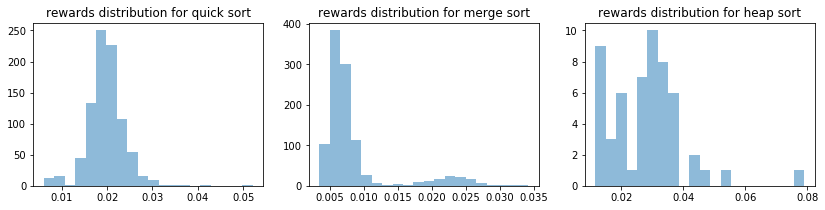

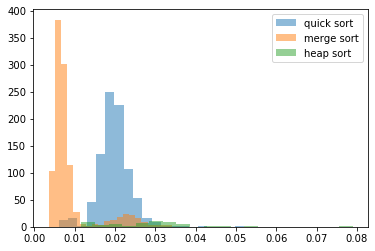

In [44]:
plot_rewards_distribution(arm_rewards_2)
plot_rewards_distribution_together(arm_rewards_2)

Restart at iteration: 108
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02115685052719384, 'merge_sort': 0.02522748999617761, 'heap_sort': 0.03548137500183657}
Count per chosen algo {'quick_sort': 95, 'merge_sort': 10, 'heap_sort': 4}


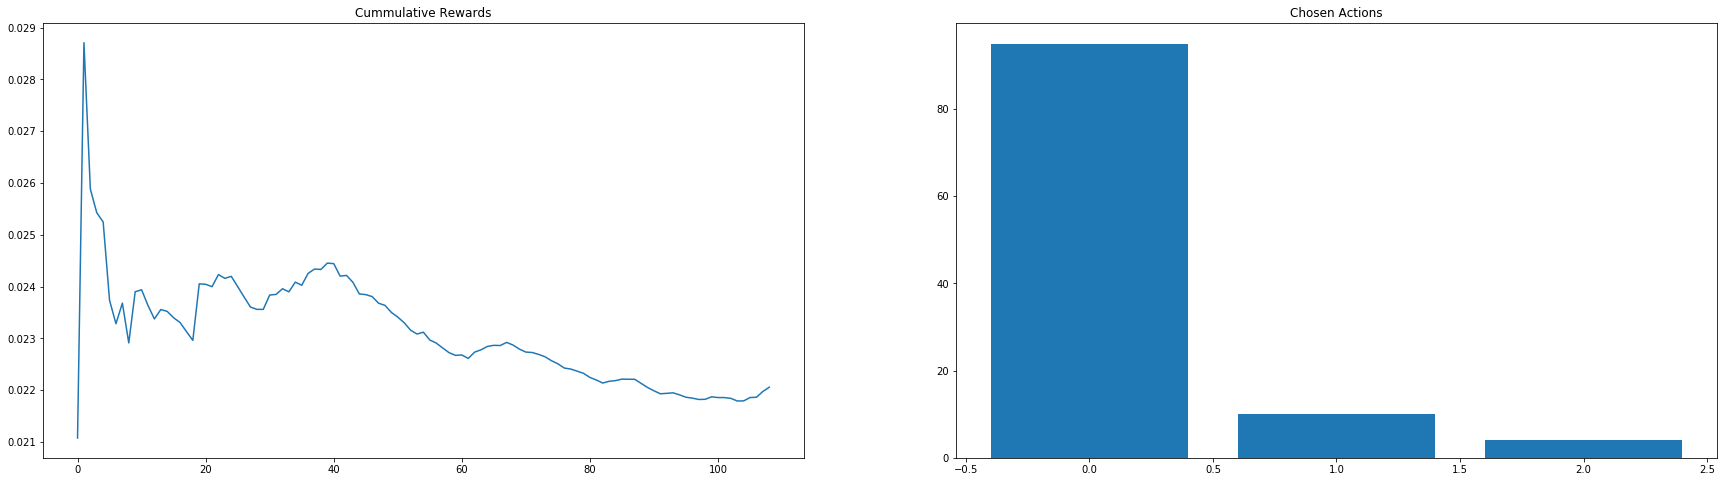

Restart at iteration: 264
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.021975180575236338, 'merge_sort': 0.02390818461516084, 'heap_sort': 0.03574342499996419}
Count per chosen algo {'quick_sort': 139, 'merge_sort': 13, 'heap_sort': 4}


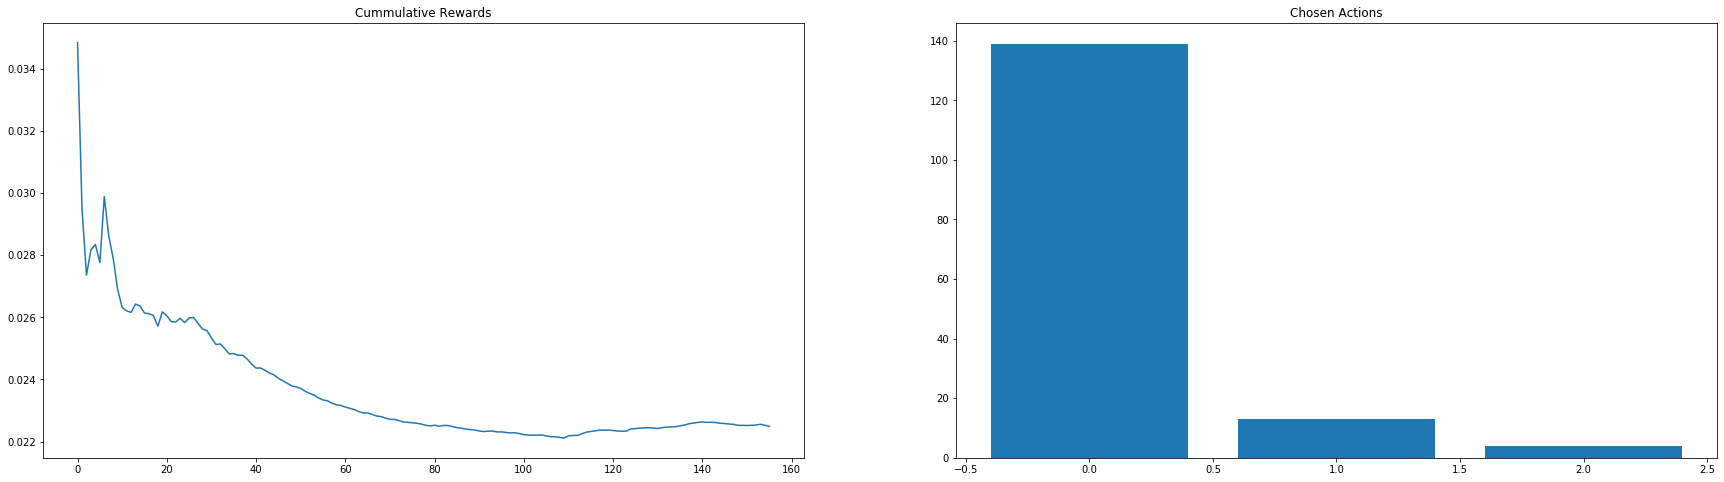

Restart at iteration: 315
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.019695154544354988, 'merge_sort': 0.021458774994243868, 'heap_sort': 0.028417333334800787}
Count per chosen algo {'quick_sort': 44, 'merge_sort': 4, 'heap_sort': 3}


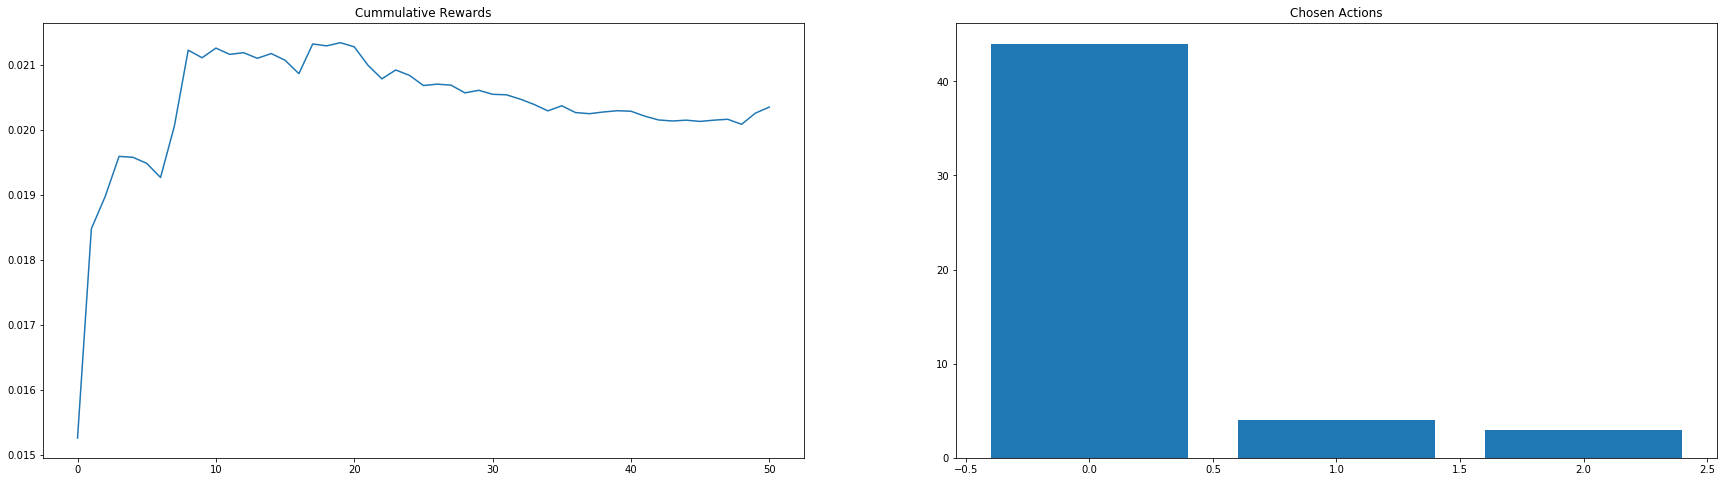

Restart at iteration: 501
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.019346376190480356, 'merge_sort': 0.02232650769292377, 'heap_sort': 0.03052293999644462}
Count per chosen algo {'quick_sort': 168, 'merge_sort': 13, 'heap_sort': 5}


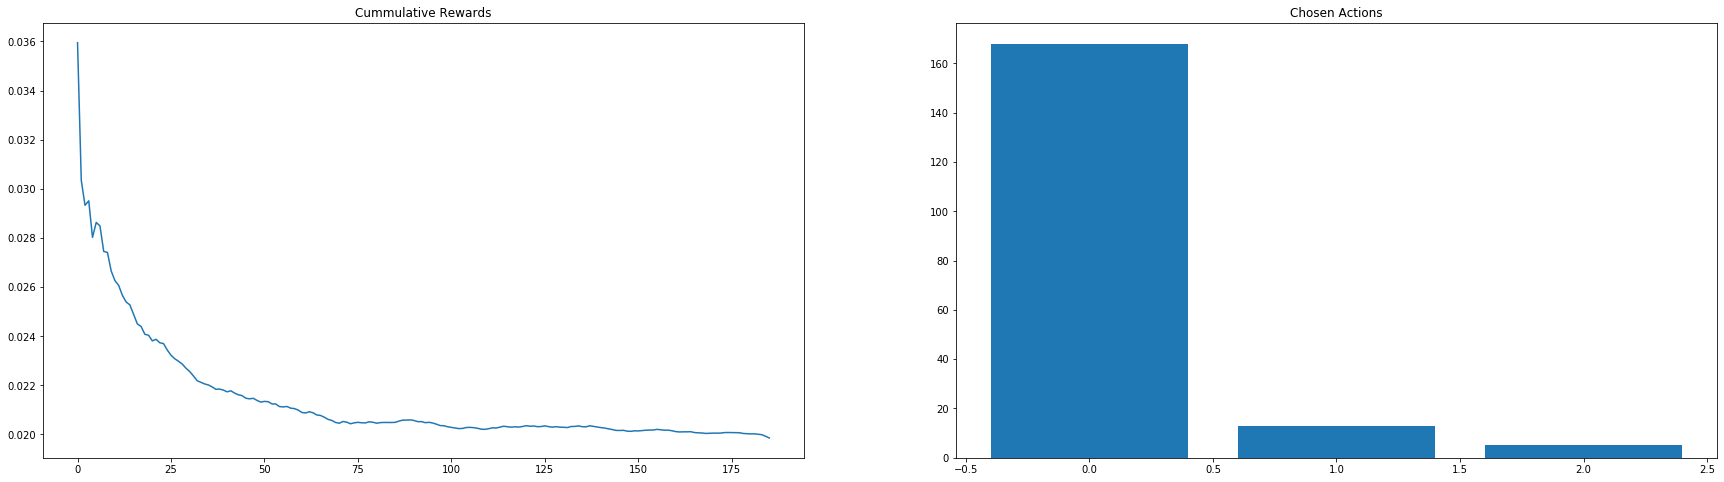

Restart at iteration: 710
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00884435000261874, 'merge_sort': 0.006685261616017082, 'heap_sort': 0.014633842856190833}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 198, 'heap_sort': 7}


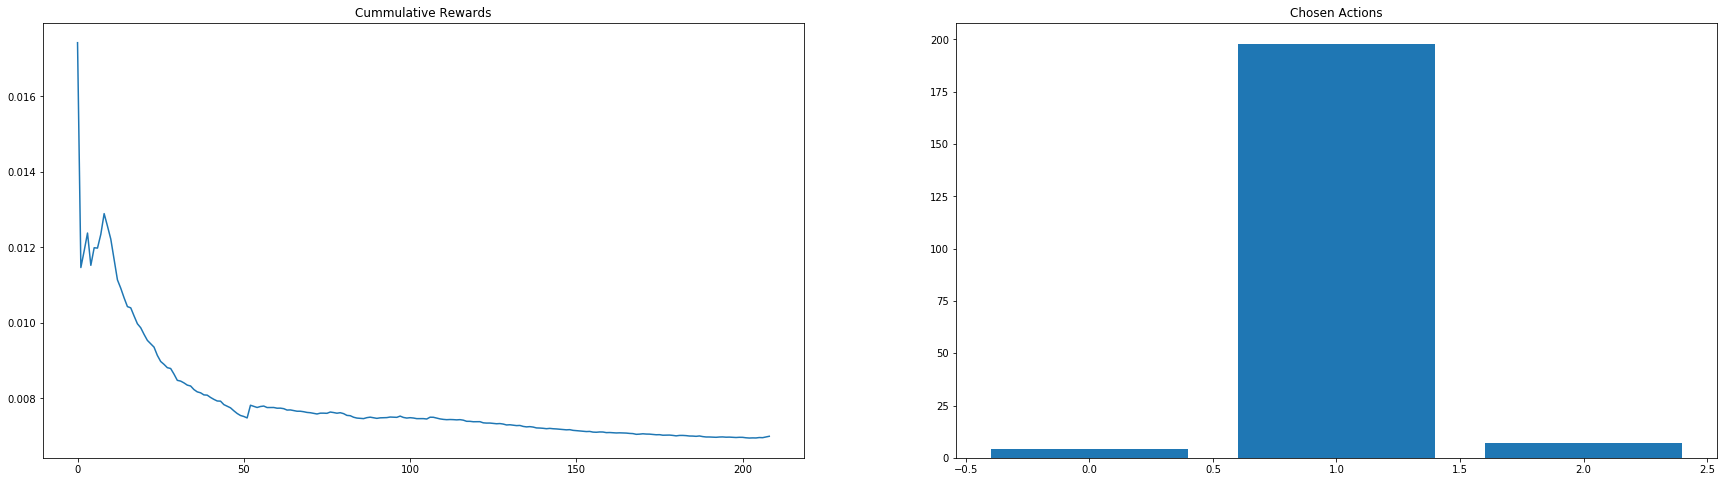

Restart at iteration: 735
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.0066544791655663476, 'heap_sort': 0.01628999999957159}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 24, 'heap_sort': 1}


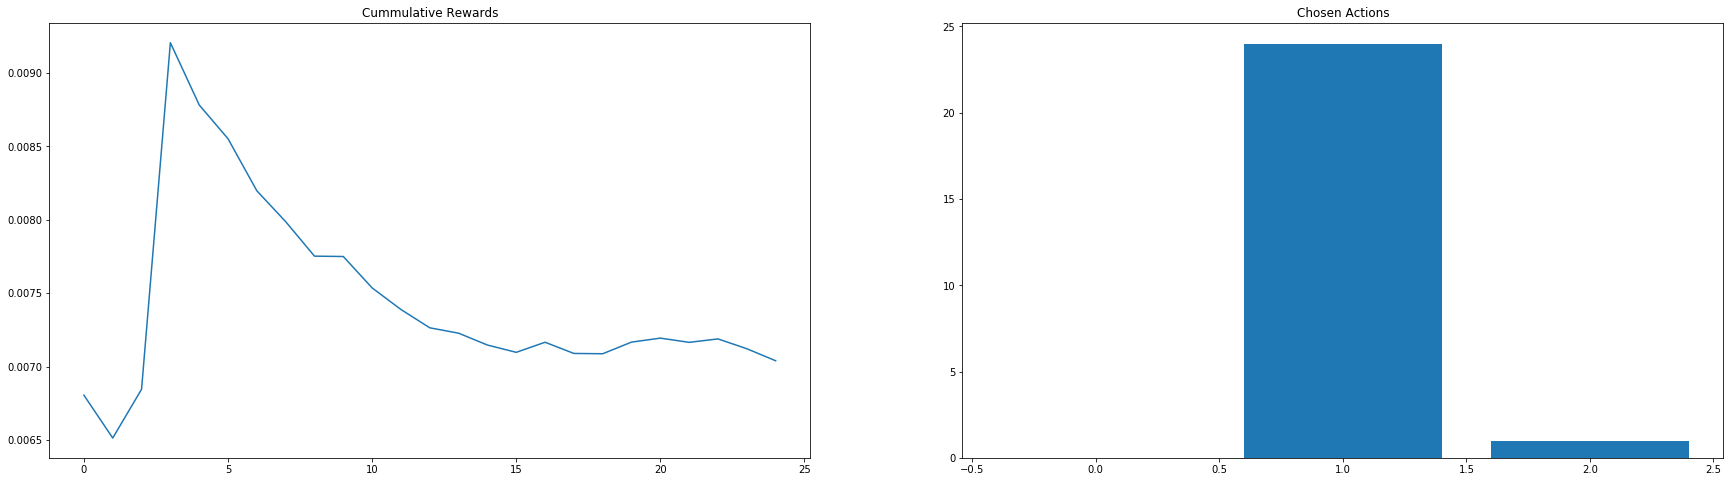

Restart at iteration: 981
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008132728573400527, 'merge_sort': 0.006701891138960061, 'heap_sort': 0.018461899999238085}
Count per chosen algo {'quick_sort': 7, 'merge_sort': 237, 'heap_sort': 2}


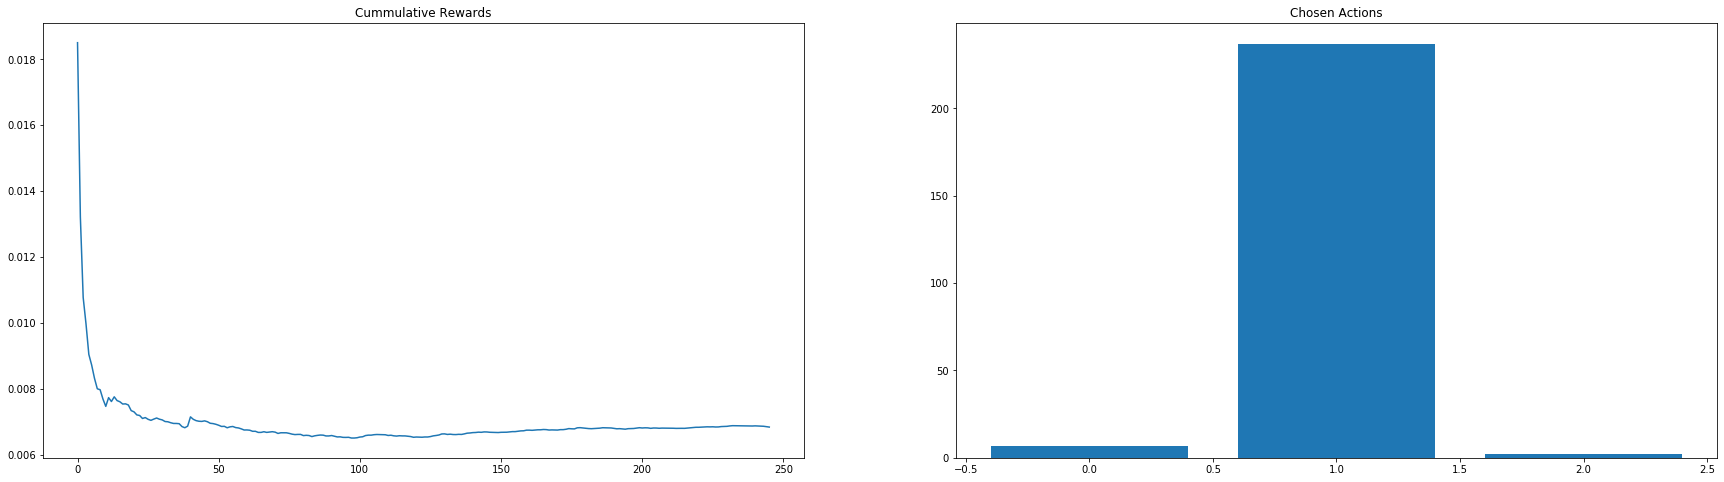

Restart at iteration: 1017
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.015763909091633235, 'heap_sort': 0.022849966670037247}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 33, 'heap_sort': 3}


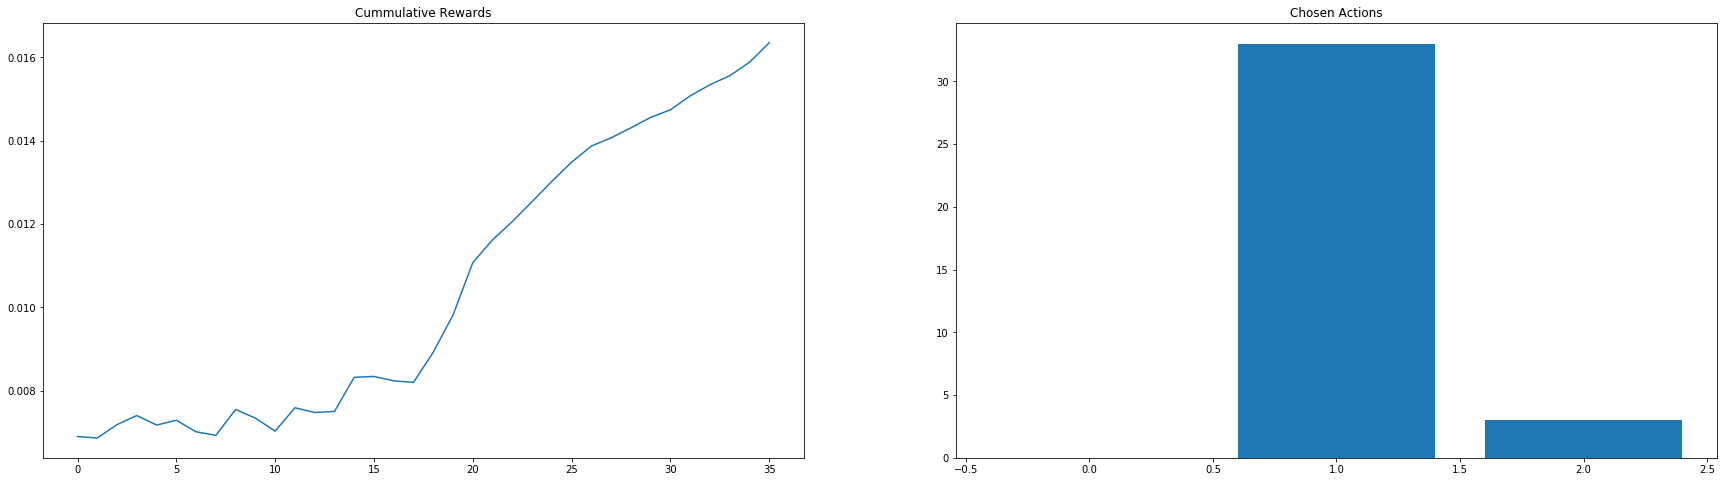

Restart at iteration: 1056
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02160203749857222, 'merge_sort': 0.02334950833513479, 'heap_sort': 0.03411893333638242}
Count per chosen algo {'quick_sort': 24, 'merge_sort': 12, 'heap_sort': 3}


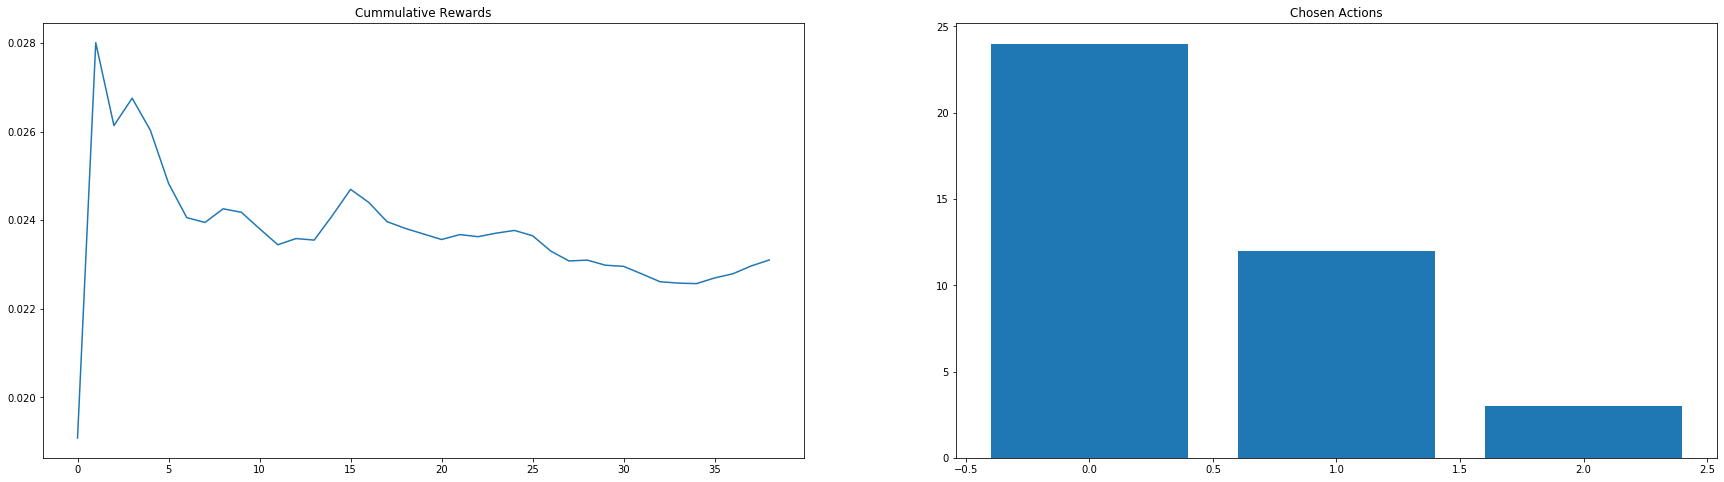

Restart at iteration: 1097
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.023441239999374374, 'merge_sort': 0.023854613637509334, 'heap_sort': 0.0350160500020138}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 22, 'heap_sort': 4}


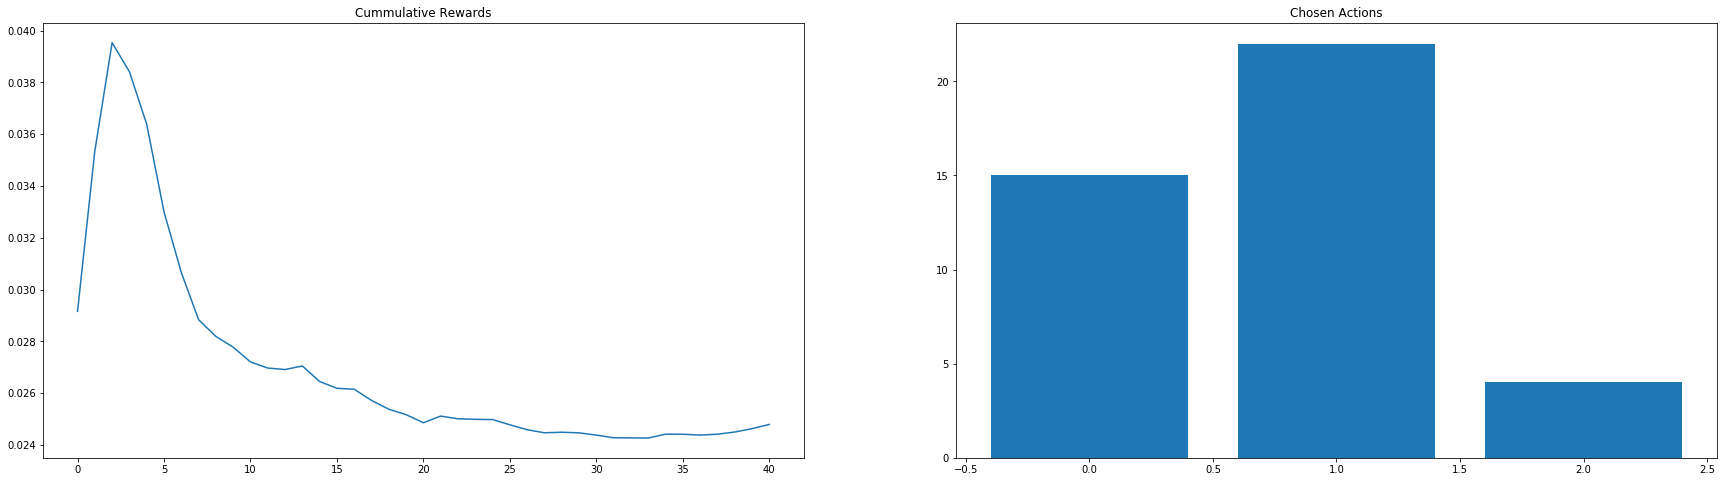

Restart at iteration: 1133
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02183374230494687, 'merge_sort': 0.026367800001753493, 'heap_sort': 0.047472079997533}
Count per chosen algo {'quick_sort': 26, 'merge_sort': 5, 'heap_sort': 5}


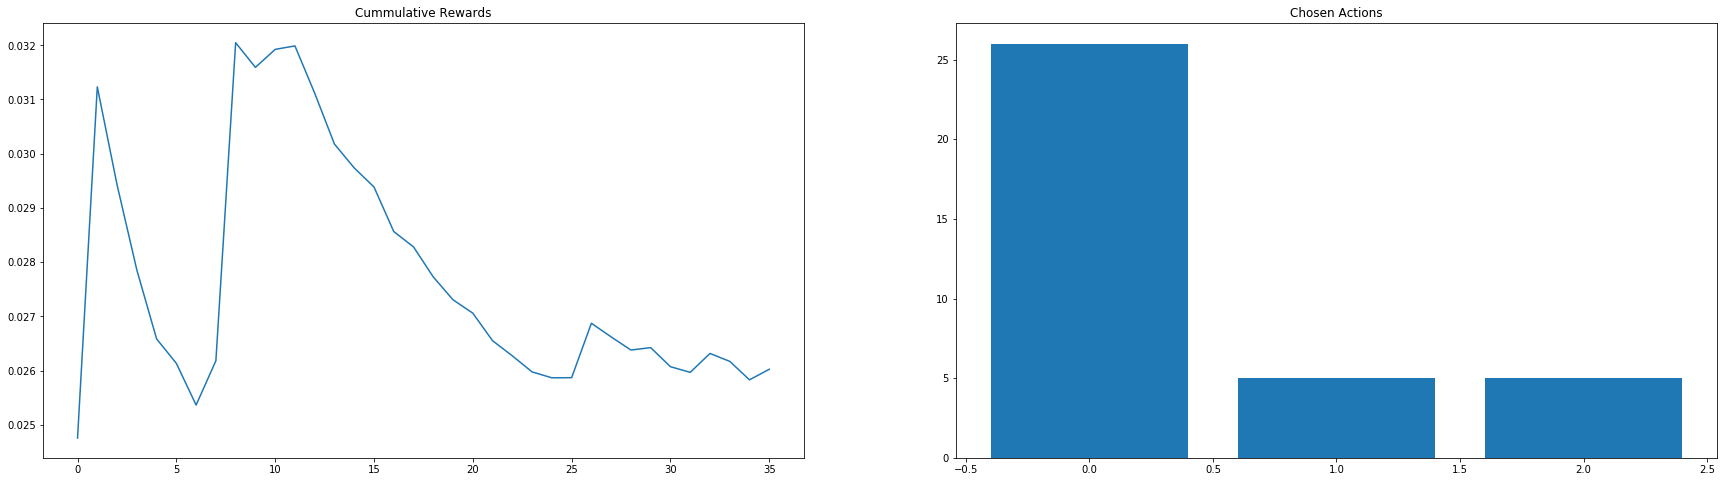

Restart at iteration: 1303
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.020040197279320104, 'merge_sort': 0.02246313333411568, 'heap_sort': 0.032032800001616124}
Count per chosen algo {'quick_sort': 147, 'merge_sort': 21, 'heap_sort': 2}


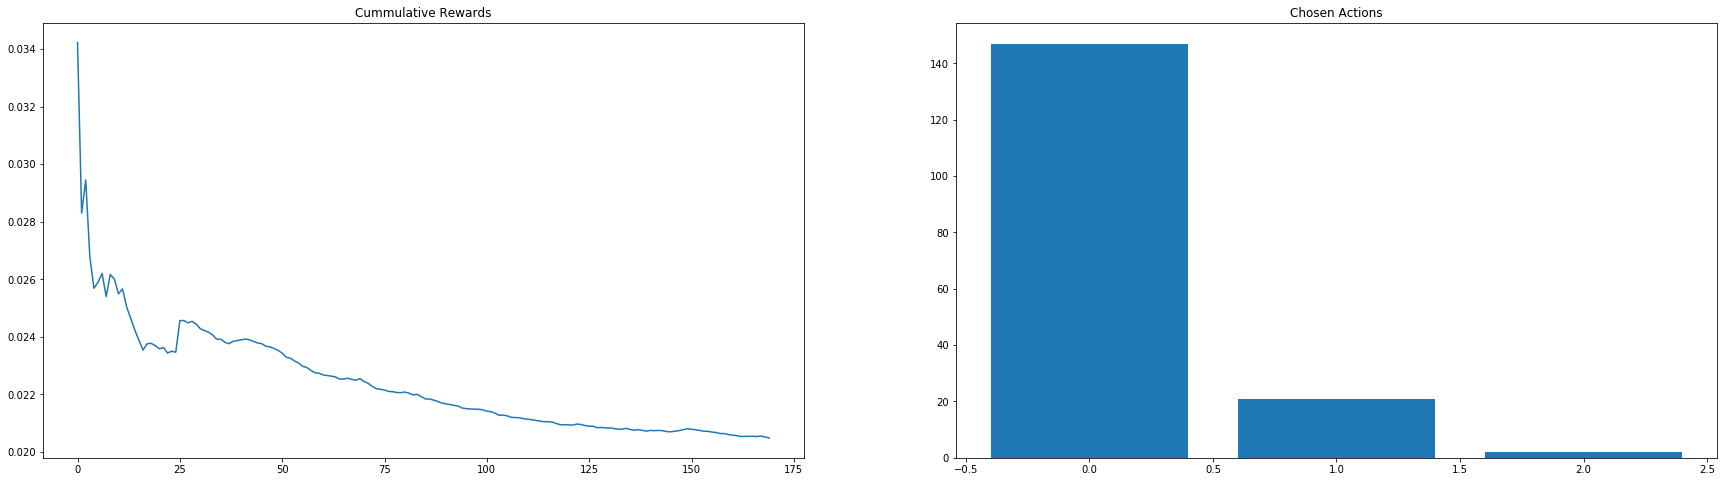

Restart at iteration: 1501
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01845687127647676, 'merge_sort': 0.02172820000435292, 'heap_sort': 0.028319033328443766}
Count per chosen algo {'quick_sort': 188, 'merge_sort': 7, 'heap_sort': 3}


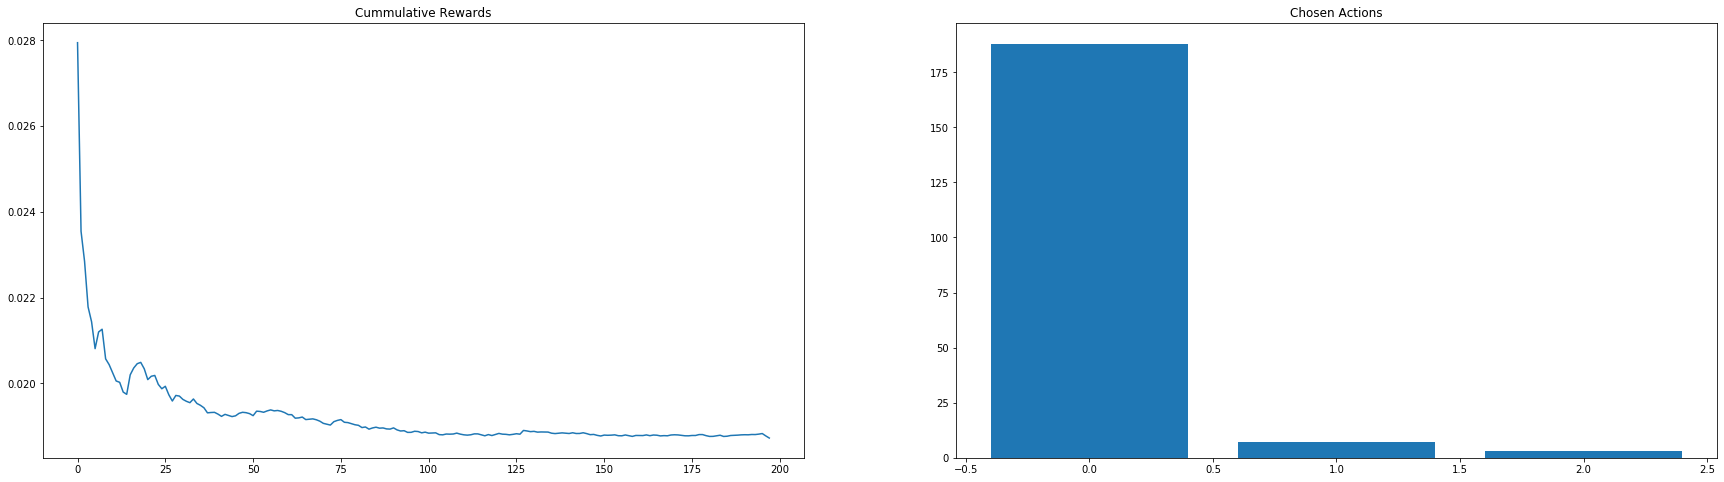

Restart at iteration: 1753
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008505766668046514, 'merge_sort': 0.006367200823623396, 'heap_sort': 0.012838366674259305}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 243, 'heap_sort': 3}


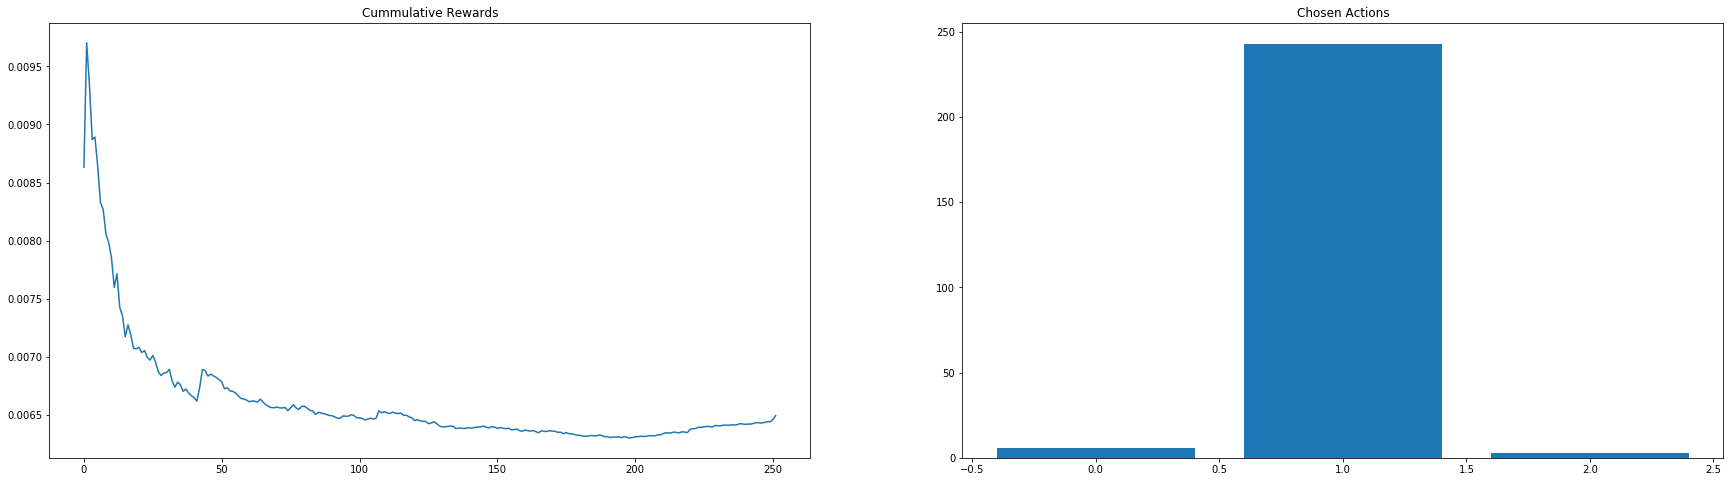

Restart at iteration: 1930
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.012406954548416914, 'merge_sort': 0.007557766049608795, 'heap_sort': 0.02565162500468432}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 162, 'heap_sort': 4}


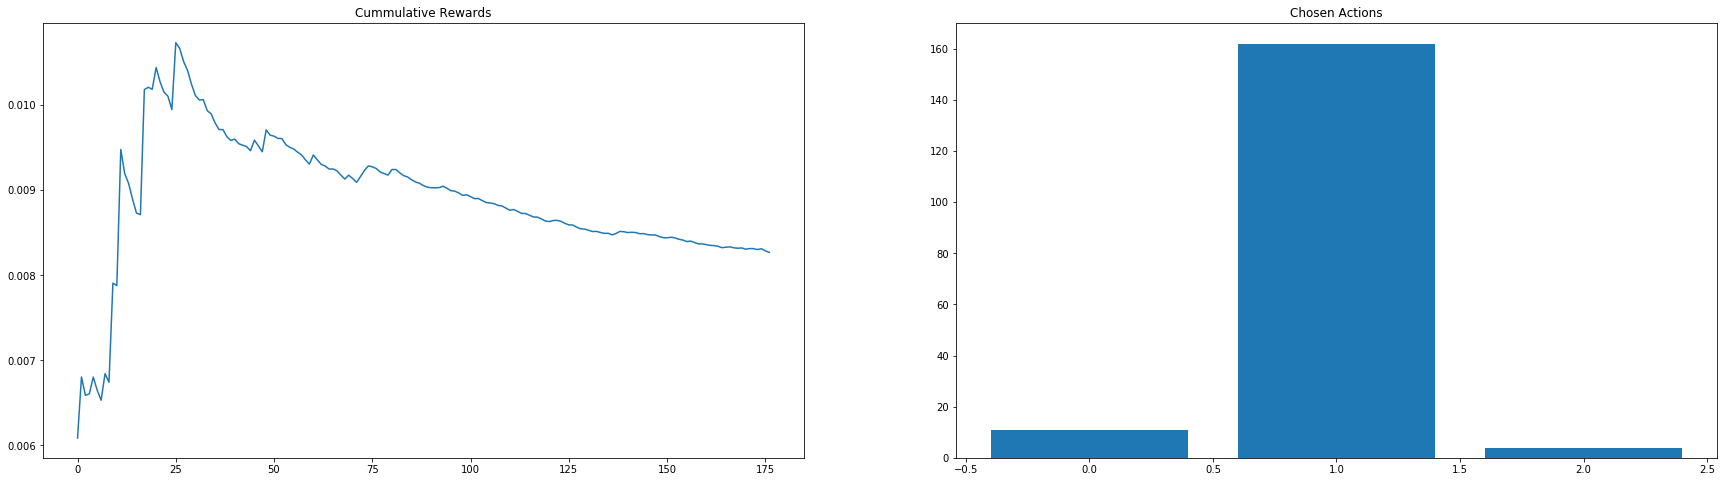

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.012128725000366103, 'merge_sort': 0.007289841269431193, 'heap_sort': 0.01895284999773139}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 63, 'heap_sort': 2}


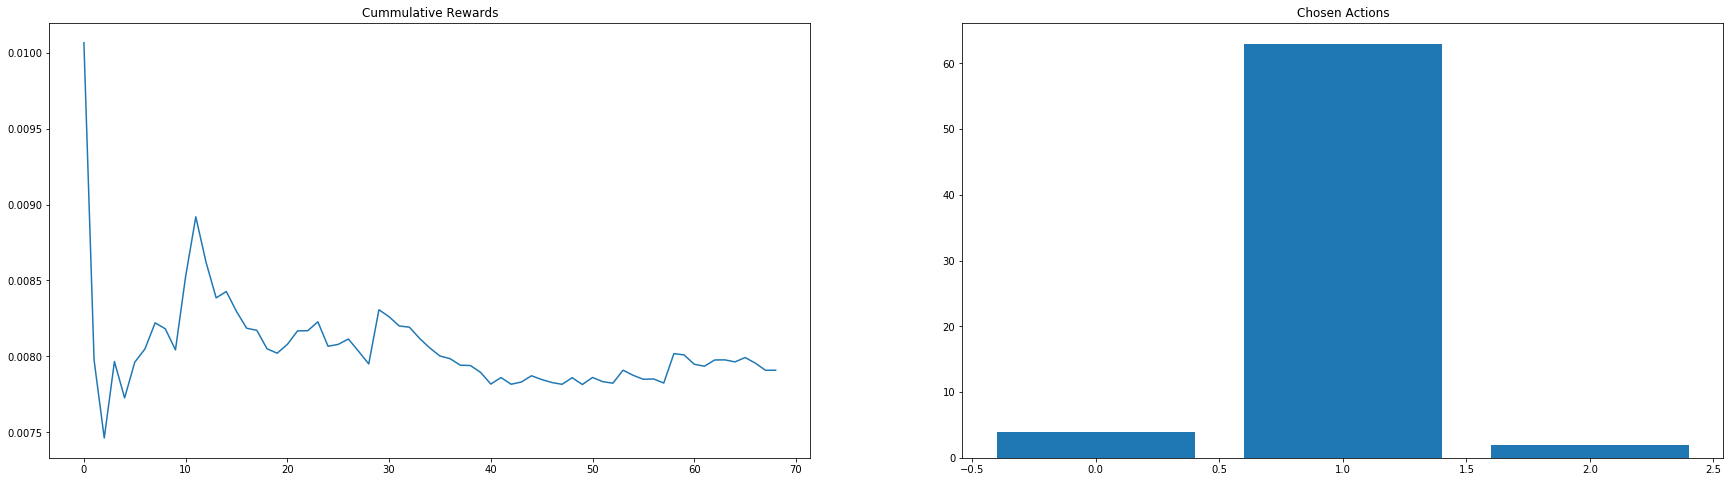

Total reward 28.2405


In [45]:
for elem in list_iteration_results_2:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_2,4))

## Three outliers in a row restart the expriment

In [46]:
list_iteration_results_3, total_reward_3, arm_rewards_3 = ts_quantile(list_distributions, n_samples, num_consec_elem=3)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.021690461605722845
Less than two values for merge_sort
merge_sort Theta 0.04173095050019852
Less than two values for heap_sort
heap_sort Theta 0.06630572972431886


Chosen algorithm is:  quick_sort with reward: 0.017448099999455735
Sample mean is:  0.017448099999455735 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.0777282835516026
Less than two values for merge_sort
merge_sort Theta 0.03206661258844983
Less than two values for heap_sort
heap_sort Theta 0.05654716563439735


Chosen algorithm is:  merge_sort with reward: 0.031110299998545088
Sample mean is:  0.031110299998545088 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.04732704365776691
Less than two values for merge_sort
merge_sort Theta 0.006232172024771643
Less than two values for heap_sort
heap_sort Theta 0.08545922413135347


Chosen algorithm is:  merge_sort with r


Iteration: 28
quick_sort Theta 0.026510480967017403
merge_sort Theta 0.03539269366441053
heap_sort Theta 0.03243891539175474


Chosen algorithm is:  quick_sort with reward: 0.019603499997174367
Sample mean is:  0.02327595238013947 Sample variance is: 0.00018659893621134844


Iteration: 29
quick_sort Theta 0.020903098359632024
merge_sort Theta 0.030369217924052366
heap_sort Theta 0.03378932044298838


Chosen algorithm is:  quick_sort with reward: 0.018679700006032363
Sample mean is:  0.023067031817680054 Sample variance is: 0.00017903377021334543


Iteration: 30
quick_sort Theta 0.024255564992891995
merge_sort Theta 0.03102783656199855
heap_sort Theta 0.03372207806940134


Chosen algorithm is:  quick_sort with reward: 0.022152399993501604
Sample mean is:  0.023027265216628817 Sample variance is: 0.00017128448366384954


Iteration: 31
quick_sort Theta 0.023469006690123223
merge_sort Theta 0.03503207764306535
heap_sort Theta 0.033552547999485455


Chosen algorithm is:  quick_sort with re



Chosen algorithm is:  quick_sort with reward: 0.04688790001091547
Sample mean is:  0.02402364166755433 Sample variance is: 0.00010649778915957759


Iteration: 60
quick_sort Theta 0.024354727834098113
merge_sort Theta 0.023923625029936696
heap_sort Theta 0.03243299951814554


Chosen algorithm is:  merge_sort with reward: 0.025275199994212016
Sample mean is:  0.029362336363357663 Sample variance is: 0.0001509312781089566


Iteration: 61
quick_sort Theta 0.023438715893157734
merge_sort Theta 0.02263849122058493
heap_sort Theta 0.033437802394596046


Chosen algorithm is:  merge_sort with reward: 0.03256140000303276
Sample mean is:  0.029628924999997253 Sample variance is: 0.00013913543611291586


Iteration: 62
quick_sort Theta 0.02426384173352591
merge_sort Theta 0.03583007924775659
heap_sort Theta 0.033413982109840576


Chosen algorithm is:  quick_sort with reward: 0.024254999996628612
Sample mean is:  0.024028363266106866 Sample variance is: 0.00010432543497867358


Iteration: 63
quick


Chosen algorithm is:  quick_sort with reward: 0.02030559998820536
Sample mean is:  0.02385517605682868 Sample variance is: 8.06378505739851e-05


Iteration: 90
quick_sort Theta 0.023445454131015456
merge_sort Theta 0.02709605826892778
heap_sort Theta 0.05495605161907348


Chosen algorithm is:  quick_sort with reward: 0.024965899996459484
Sample mean is:  0.02387060277821244 Sample variance is: 7.953477727214251e-05


Iteration: 91
quick_sort Theta 0.025105181758030184
merge_sort Theta 0.02994776031520811
heap_sort Theta 0.04319746524818007


Chosen algorithm is:  quick_sort with reward: 0.028115900000557303
Sample mean is:  0.023928757534682918 Sample variance is: 7.868876202567397e-05


Iteration: 92
quick_sort Theta 0.02237164713623857
merge_sort Theta 0.025455804574902843
heap_sort Theta 0.05192936684081174


Chosen algorithm is:  quick_sort with reward: 0.02041720000852365
Sample mean is:  0.023881304054599685 Sample variance is: 7.77897841690351e-05


Iteration: 93
quick_sort The


Chosen algorithm is:  heap_sort with reward: 0.0320606999885058
Sample mean is:  0.04202793332903335 Sample variance is: 0.00017193131190769366


Iteration: 124
quick_sort Theta 0.02307471024938003
merge_sort Theta 0.02888521267731709
heap_sort Theta 0.06298043254071133


Chosen algorithm is:  quick_sort with reward: 0.01972909999312833
Sample mean is:  0.023199379412165166 Sample variance is: 6.166636955549066e-05


Iteration: 125
quick_sort Theta 0.022929843314718208
merge_sort Theta 0.027213851707238428
heap_sort Theta 0.07158424732536162


Chosen algorithm is:  quick_sort with reward: 0.016331299993908033
Sample mean is:  0.023132699029463643 Sample variance is: 6.15211868290437e-05


Iteration: 126
quick_sort Theta 0.024991598839757573
merge_sort Theta 0.028437963878832857
heap_sort Theta 0.03709063801167335


Chosen algorithm is:  quick_sort with reward: 0.01611609999963548
Sample mean is:  0.02306523173109991 Sample variance is: 6.139847609958311e-05


Iteration: 127
quick_sort


Iteration: 157
quick_sort Theta 0.022992331734248275
merge_sort Theta 0.026530472047027194
heap_sort Theta 0.056698645030286286


Chosen algorithm is:  quick_sort with reward: 0.02434200000425335
Sample mean is:  0.022906070896020373 Sample variance is: 5.651789943151497e-05


Iteration: 158
quick_sort Theta 0.022775082646072996
merge_sort Theta 0.029534356890685034
heap_sort Theta 0.03938310755262603


Chosen algorithm is:  quick_sort with reward: 0.024965000004158355
Sample mean is:  0.02292132222274732 Sample variance is: 5.6130417122183764e-05


Iteration: 159
quick_sort Theta 0.02274342880753505
merge_sort Theta 0.027293292642617286
heap_sort Theta 0.04390108050639898


Chosen algorithm is:  quick_sort with reward: 0.019420999989961274
Sample mean is:  0.022895584559270956 Sample variance is: 5.5807121155238656e-05


Iteration: 160
quick_sort Theta 0.02271703319606026
merge_sort Theta 0.024218890580178128
heap_sort Theta 0.041178030816671304


Chosen algorithm is:  quick_sort wit


Chosen algorithm is:  quick_sort with reward: 0.02734289999352768
Sample mean is:  0.022560501212755105 Sample variance is: 4.845603470393721e-05


Iteration: 189
quick_sort Theta 0.022511784106874252
merge_sort Theta 0.02950364847632097
heap_sort Theta 0.04879082485987357


Chosen algorithm is:  quick_sort with reward: 0.020201299994369037
Sample mean is:  0.02254628915722266 Sample variance is: 4.819745799662498e-05


Iteration: 190
quick_sort Theta 0.02234897976334968
merge_sort Theta 0.030603212165184274
heap_sort Theta 0.041710695797940095


Chosen algorithm is:  quick_sort with reward: 0.016060199995990843
Sample mean is:  0.022507450299969773 Sample variance is: 4.815925429794092e-05


Iteration: 191
quick_sort Theta 0.022607116049058882
merge_sort Theta 0.02757678146705188
heap_sort Theta 0.039286511256156204


Chosen algorithm is:  quick_sort with reward: 0.02033139999548439
Sample mean is:  0.022494497619585933 Sample variance is: 4.790060998214101e-05


Iteration: 192
quick


Chosen algorithm is:  quick_sort with reward: 0.019667300002765842
Sample mean is:  0.022177001538996894 Sample variance is: 4.4297331345834836e-05


Iteration: 221
quick_sort Theta 0.02163252054196199
merge_sort Theta 0.027204575229241492
heap_sort Theta 0.03534394839950386


Chosen algorithm is:  quick_sort with reward: 0.020296499991673045
Sample mean is:  0.022167407143347282 Sample variance is: 4.408927477669089e-05


Iteration: 222
quick_sort Theta 0.022098929209369483
merge_sort Theta 0.02646192083733423
heap_sort Theta 0.03725968914380221


Chosen algorithm is:  quick_sort with reward: 0.021340999999665655
Sample mean is:  0.022163212183227074 Sample variance is: 4.38689204987489e-05


Iteration: 223
quick_sort Theta 0.021473870006341305
merge_sort Theta 0.02754047778286189
heap_sort Theta 0.04855512970967223


Chosen algorithm is:  quick_sort with reward: 0.022170399999595247
Sample mean is:  0.022163248485329943 Sample variance is: 4.3647360553824777e-05


Iteration: 224
qui


Iteration: 252
quick_sort Theta 0.022300282077085724
merge_sort Theta 0.028400115812354774
heap_sort Theta 0.046413264821224376


Chosen algorithm is:  quick_sort with reward: 0.018170099996495992
Sample mean is:  0.02201985022072867 Sample variance is: 3.956259506911525e-05


Iteration: 253
quick_sort Theta 0.02171865271632104
merge_sort Theta 0.028724505028324368
heap_sort Theta 0.0299688608021901


Chosen algorithm is:  quick_sort with reward: 0.019734400004381314
Sample mean is:  0.022009826316271006 Sample variance is: 3.9411883571254166e-05


Iteration: 254
quick_sort Theta 0.022029055702398423
merge_sort Theta 0.027097301906563506
heap_sort Theta 0.04782962423745966


Chosen algorithm is:  quick_sort with reward: 0.016792800000985153
Sample mean is:  0.021987044541968447 Sample variance is: 3.935811338298817e-05


Iteration: 255
quick_sort Theta 0.022588425714569902
merge_sort Theta 0.029428814571630796
heap_sort Theta 0.05296706420328198


Chosen algorithm is:  quick_sort with


Chosen algorithm is:  quick_sort with reward: 0.02426430000923574
Sample mean is:  0.021947376062416177 Sample variance is: 3.654166573236699e-05


Iteration: 286
quick_sort Theta 0.02240445780473488
merge_sort Theta 0.02649018120491106
heap_sort Theta 0.0366161870757961


Chosen algorithm is:  quick_sort with reward: 0.021130599998286925
Sample mean is:  0.02194423461601568 Sample variance is: 3.640367685370676e-05


Iteration: 287
quick_sort Theta 0.02136265667458298
merge_sort Theta 0.026303098576682445
heap_sort Theta 0.04909739025048927


Chosen algorithm is:  quick_sort with reward: 0.020737600003485568
Sample mean is:  0.021939611494894873 Sample variance is: 3.626975620932548e-05


Iteration: 288
quick_sort Theta 0.022753375051370345
merge_sort Theta 0.029227532037905866
heap_sort Theta 0.038215054629361235


Chosen algorithm is:  quick_sort with reward: 0.018319599999813363
Sample mean is:  0.02192579465712739 Sample variance is: 3.618114823185851e-05


Iteration: 289
quick_s



Iteration: 318
quick_sort Theta 0.021166672914178536
merge_sort Theta 0.025149442907746407
heap_sort Theta 0.039836643815296585


Chosen algorithm is:  quick_sort with reward: 0.019530400008079596
Sample mean is:  0.021760890411489327 Sample variance is: 3.3491508126966666e-05


Iteration: 319
quick_sort Theta 0.021520073513093728
merge_sort Theta 0.03016406746855821
heap_sort Theta 0.04304003284340646


Chosen algorithm is:  quick_sort with reward: 0.021416100003989413
Sample mean is:  0.02175971365241936 Sample variance is: 3.337760698895608e-05


Iteration: 320
quick_sort Theta 0.021737582451696914
merge_sort Theta 0.02555314910320317
heap_sort Theta 0.04554765238090415


Chosen algorithm is:  quick_sort with reward: 0.018915600012405775
Sample mean is:  0.021750039796500947 Sample variance is: 3.329149767556419e-05


Iteration: 321
quick_sort Theta 0.022027277291333528
merge_sort Theta 0.027138780686086692
heap_sort Theta 0.04035321688656909


Chosen algorithm is:  quick_sort wit


Iteration: 351
quick_sort Theta 0.02135195553626612
merge_sort Theta 0.027113723347864598
heap_sort Theta 0.03196786503676145


Chosen algorithm is:  quick_sort with reward: 0.01938440000230912
Sample mean is:  0.021519672615910306 Sample variance is: 3.099482859515257e-05


Iteration: 352
quick_sort Theta 0.02147244667584662
merge_sort Theta 0.027883659126200565
heap_sort Theta 0.03277652910106219


Chosen algorithm is:  quick_sort with reward: 0.018445399997290224
Sample mean is:  0.02151024233180411 Sample variance is: 3.0928654767772905e-05


Iteration: 353
quick_sort Theta 0.021623238095830333
merge_sort Theta 0.028219340005936303
heap_sort Theta 0.0440072527574461


Chosen algorithm is:  quick_sort with reward: 0.017936599993845448
Sample mean is:  0.02149931376196326 Sample variance is: 3.087300709190747e-05


Iteration: 354
quick_sort Theta 0.020947001293852695
merge_sort Theta 0.02715172125568612
heap_sort Theta 0.04085910879925233


Chosen algorithm is:  quick_sort with rewa


Chosen algorithm is:  quick_sort with reward: 0.015601899998728186
Sample mean is:  0.021279228492035118 Sample variance is: 2.9174963059292794e-05


Iteration: 385
quick_sort Theta 0.021036178885929274
merge_sort Theta 0.028931135128168514
heap_sort Theta 0.048593622494563345


Chosen algorithm is:  quick_sort with reward: 0.020741400003316812
Sample mean is:  0.021277730362540083 Sample variance is: 2.9094499245051187e-05


Iteration: 386
quick_sort Theta 0.02179913919129868
merge_sort Theta 0.028206151430138517
heap_sort Theta 0.04187888254042493


Chosen algorithm is:  quick_sort with reward: 0.0162315000052331
Sample mean is:  0.021263713055992006 Sample variance is: 2.9084219264540428e-05


Iteration: 387
quick_sort Theta 0.02124842970331614
merge_sort Theta 0.02137829509124249
heap_sort Theta 0.03963807863102958


Chosen algorithm is:  quick_sort with reward: 0.018751000010524876
Sample mean is:  0.021256752632043345 Sample variance is: 2.9021094660762754e-05


Iteration: 388
q

Sample mean is:  0.02113740971912463 Sample variance is: 2.7499138626074675e-05


Iteration: 418
quick_sort Theta 0.020624504757632625
merge_sort Theta 0.02628792507560153
heap_sort Theta 0.03926949884461593


Chosen algorithm is:  quick_sort with reward: 0.022305899998173118
Sample mean is:  0.021140390561673224 Sample variance is: 2.7432461962351752e-05


Iteration: 419
quick_sort Theta 0.021220434538826008
merge_sort Theta 0.026727627741197534
heap_sort Theta 0.04443830527279381


Chosen algorithm is:  quick_sort with reward: 0.016903000010643154
Sample mean is:  0.02112960839742124 Sample variance is: 2.7408231246012528e-05


Iteration: 420
quick_sort Theta 0.021728285144426717
merge_sort Theta 0.025047774942533695
heap_sort Theta 0.03431117640937127


Chosen algorithm is:  quick_sort with reward: 0.01799770000798162
Sample mean is:  0.021121659391356674 Sample variance is: 2.7363499579400975e-05


Iteration: 421
quick_sort Theta 0.02114302024211302
merge_sort Theta 0.0281367086033



Chosen algorithm is:  quick_sort with reward: 0.03991259999747854
Sample mean is:  0.021192294588613818 Sample variance is: 2.6810522468569645e-05


Iteration: 452
quick_sort Theta 0.021244098849413272
merge_sort Theta 0.029158570792119726
heap_sort Theta 0.04724166352818882


Chosen algorithm is:  quick_sort with reward: 0.020210200003930368
Sample mean is:  0.021189989202264795 Sample variance is: 2.674984576245989e-05


Iteration: 453
quick_sort Theta 0.021447920837230006
merge_sort Theta 0.030321014582718346
heap_sort Theta 0.038653385305627466


Chosen algorithm is:  quick_sort with reward: 0.023632800002815202
Sample mean is:  0.02119571007065016 Sample variance is: 2.6701142024393725e-05


Iteration: 454
quick_sort Theta 0.020843410031215794
merge_sort Theta 0.03176103616239684
heap_sort Theta 0.03920054726662752


Chosen algorithm is:  quick_sort with reward: 0.022710000004735775
Sample mean is:  0.02119924813124382 Sample variance is: 2.664410131021273e-05


Iteration: 455
q

merge_sort Theta 0.026670795186103435
heap_sort Theta 0.039317150713610624


Chosen algorithm is:  quick_sort with reward: 0.017437400005292147
Sample mean is:  0.02123326000032798 Sample variance is: 2.547693413027292e-05


Iteration: 482
quick_sort Theta 0.021217386521385988
merge_sort Theta 0.025111701497714134
heap_sort Theta 0.043992637973697166


Chosen algorithm is:  quick_sort with reward: 0.017895400000270456
Sample mean is:  0.021225940131906804 Sample variance is: 2.544544277622402e-05


Iteration: 483
quick_sort Theta 0.02112115210833625
merge_sort Theta 0.025220471399722597
heap_sort Theta 0.0696791518620872


Chosen algorithm is:  quick_sort with reward: 0.018277800001669675
Sample mean is:  0.021219489059411754 Sample variance is: 2.5408740519737342e-05


Iteration: 484
quick_sort Theta 0.02173952510042501
merge_sort Theta 0.026750015199372458
heap_sort Theta 0.03917442072841785


Chosen algorithm is:  quick_sort with reward: 0.019932399998651817
Sample mean is:  0.02121


Iteration: 509
quick_sort Theta 0.01008836047002467
Less than two values for merge_sort
merge_sort Theta 0.032913969607523796
Less than two values for heap_sort
heap_sort Theta 0.09575508846312297


Chosen algorithm is:  quick_sort with reward: 0.010022400005254894
Sample mean is:  0.008650600000692066 Sample variance is: 1.8247407510955282e-06


Iteration: 510
quick_sort Theta 0.008582787172351385
Less than two values for merge_sort
merge_sort Theta 0.0049944658534666125
Less than two values for heap_sort
heap_sort Theta 0.014348347089996417


Chosen algorithm is:  merge_sort with reward: 0.005205800000112504
Sample mean is:  0.004921449995890725 Sample variance is: 8.085492490092537e-08


Iteration: 511
quick_sort Theta 0.008914914548088935
merge_sort Theta 0.005288078689227991
Less than two values for heap_sort
heap_sort Theta 0.02766597642650518


Chosen algorithm is:  merge_sort with reward: 0.00625239999499172
Sample mean is:  0.0053650999955910566 Sample variance is: 4.47553927

quick_sort Theta 0.008715328520938979
merge_sort Theta 0.00642904442378048
Less than two values for heap_sort
heap_sort Theta 0.037954983501330725


Chosen algorithm is:  merge_sort with reward: 0.00825690000783652
Sample mean is:  0.006463325807295229 Sample variance is: 1.5266800527903942e-06


Iteration: 540
quick_sort Theta 0.008817059523298117
merge_sort Theta 0.006428554739123653
Less than two values for heap_sort
heap_sort Theta 0.025339737655122676


Chosen algorithm is:  merge_sort with reward: 0.007086800003889948
Sample mean is:  0.006482809375938814 Sample variance is: 1.4907391940004621e-06


Iteration: 541
quick_sort Theta 0.008598372266317145
merge_sort Theta 0.0062223499364566
Less than two values for heap_sort
heap_sort Theta 4.573703167910504e-05


Chosen algorithm is:  heap_sort with reward: 0.01454350000130944
Sample mean is:  0.01454350000130944 Sample variance is: 0.0


Iteration: 542
quick_sort Theta 0.007839684500980297
merge_sort Theta 0.006562890356258186
Less


Iteration: 568
quick_sort Theta 0.009023032347569687
merge_sort Theta 0.006610995899540796
heap_sort Theta 0.0172541700809065


Chosen algorithm is:  merge_sort with reward: 0.005288000000291504
Sample mean is:  0.006610949123952244 Sample variance is: 1.5471047914240165e-06


Iteration: 569
quick_sort Theta 0.009732890879575951
merge_sort Theta 0.006527486274600451
heap_sort Theta 0.01680374134095796


Chosen algorithm is:  merge_sort with reward: 0.006823199990321882
Sample mean is:  0.006614608621648272 Sample variance is: 1.5211939105152953e-06


Iteration: 570
quick_sort Theta 0.008042906116836036
merge_sort Theta 0.0066639679314491685
heap_sort Theta 0.018152598822543817


Chosen algorithm is:  merge_sort with reward: 0.007097400011844002
Sample mean is:  0.006622791526566843 Sample variance is: 1.4992946389880136e-06


Iteration: 571
quick_sort Theta 0.008487600391413318
merge_sort Theta 0.0066455899629849205
heap_sort Theta 0.015151084637552938


Chosen algorithm is:  merge_so


Iteration: 599
quick_sort Theta 0.008138356581907445
merge_sort Theta 0.006516429508329968
heap_sort Theta 0.015646524842387842


Chosen algorithm is:  merge_sort with reward: 0.009262000006856397
Sample mean is:  0.006509297728453847 Sample variance is: 1.6775626078125115e-06


Iteration: 600
quick_sort Theta 0.008617629848211121
merge_sort Theta 0.006662284628402533
heap_sort Theta 0.015190179888549085


Chosen algorithm is:  merge_sort with reward: 0.005430199991678819
Sample mean is:  0.006497173034782218 Sample variance is: 1.6716503110507172e-06


Iteration: 601
quick_sort Theta 0.008655400210814665
merge_sort Theta 0.006454333698117534
heap_sort Theta 0.018429168668623933


Chosen algorithm is:  merge_sort with reward: 0.005684600007953122
Sample mean is:  0.006488144445595228 Sample variance is: 1.6603312913266707e-06


Iteration: 602
quick_sort Theta 0.008979647403832164
merge_sort Theta 0.006523242330658425
heap_sort Theta 0.016620452640181596


Chosen algorithm is:  merge_s



Iteration: 630
quick_sort Theta 0.008303346681979186
merge_sort Theta 0.006936528652373008
heap_sort Theta 0.01718723277435691


Chosen algorithm is:  merge_sort with reward: 0.006289800003287382
Sample mean is:  0.007051509322960648 Sample variance is: 6.129220735700892e-06


Iteration: 631
quick_sort Theta 0.009336173827419424
merge_sort Theta 0.0069943844599886906
heap_sort Theta 0.013219322092010408


Chosen algorithm is:  merge_sort with reward: 0.0041573999915272
Sample mean is:  0.007027189076478014 Sample variance is: 6.147508656997538e-06


Iteration: 632
quick_sort Theta 0.008376564099475377
merge_sort Theta 0.007233844674409923
heap_sort Theta 0.015531842702797501


Chosen algorithm is:  merge_sort with reward: 0.006006700001307763
Sample mean is:  0.007018685000851595 Sample variance is: 6.1048854151581494e-06


Iteration: 633
quick_sort Theta 0.009196158601779894
merge_sort Theta 0.006936228297729218
heap_sort Theta 0.016365693367761013


Chosen algorithm is:  merge_sort


Iteration: 663
quick_sort Theta 0.008889124849319273
merge_sort Theta 0.006696263349443509
heap_sort Theta 0.016443662067019766


Chosen algorithm is:  merge_sort with reward: 0.010304299998097122
Sample mean is:  0.007089113908267075 Sample variance is: 5.474407153739206e-06


Iteration: 664
quick_sort Theta 0.008936633564475775
merge_sort Theta 0.006871528169855084
heap_sort Theta 0.01591964352197476


Chosen algorithm is:  merge_sort with reward: 0.0061907999916002154
Sample mean is:  0.007083203948289003 Sample variance is: 5.443665388869751e-06


Iteration: 665
quick_sort Theta 0.00863529087054965
merge_sort Theta 0.007127708001747191
heap_sort Theta 0.015966359836191844


Chosen algorithm is:  merge_sort with reward: 0.007483299996238202
Sample mean is:  0.007085818955138344 Sample variance is: 5.4091252921691545e-06


Iteration: 666
quick_sort Theta 0.008006048050767479
merge_sort Theta 0.007129635121253714
heap_sort Theta 0.015815769243509394


Chosen algorithm is:  merge_sort



Iteration: 695
quick_sort Theta 0.008374847053688123
merge_sort Theta 0.007274488926085702
heap_sort Theta 0.016638935951602537


Chosen algorithm is:  merge_sort with reward: 0.009070000000065193
Sample mean is:  0.007175581968043386 Sample variance is: 5.297440220414871e-06


Iteration: 696
quick_sort Theta 0.008470102961458592
merge_sort Theta 0.007192409142003689
heap_sort Theta 0.009674192056128909


Chosen algorithm is:  merge_sort with reward: 0.007160599998314865
Sample mean is:  0.007175500544294861 Sample variance is: 5.268650997692665e-06


Iteration: 697
quick_sort Theta 0.008834770990800928
merge_sort Theta 0.00732621891247341
heap_sort Theta 0.014845172836504356


Chosen algorithm is:  merge_sort with reward: 0.00853099999949336
Sample mean is:  0.007182827568377016 Sample variance is: 5.2500498949802285e-06


Iteration: 698
quick_sort Theta 0.008972188314987075
merge_sort Theta 0.007153444002120673
heap_sort Theta 0.016197897700069925


Chosen algorithm is:  merge_sort


Iteration: 725
quick_sort Theta 0.00942782566666987
merge_sort Theta 0.007011320242563209
heap_sort Theta 0.01571555047144458


Chosen algorithm is:  merge_sort with reward: 0.010934700010693632
Sample mean is:  0.007285054245928548 Sample variance is: 4.984764969898064e-06


Iteration: 726
quick_sort Theta 0.00966423275273102
merge_sort Theta 0.007380027711427539
heap_sort Theta 0.016563320813765322


Chosen algorithm is:  merge_sort with reward: 0.005763300010585226
Sample mean is:  0.007277909859847124 Sample variance is: 4.972183274983082e-06


Iteration: 727
quick_sort Theta 0.008652255550949606
merge_sort Theta 0.007290251774765256
heap_sort Theta 0.01870715001281516


Chosen algorithm is:  merge_sort with reward: 0.006615200007217936
Sample mean is:  0.007274813084834839 Sample variance is: 4.950991446994655e-06


Iteration: 728
quick_sort Theta 0.00865181115707667
merge_sort Theta 0.007231886526516159
heap_sort Theta 0.014747718727963446


Chosen algorithm is:  merge_sort with


Iteration: 759
quick_sort Theta 0.008219181888688963
merge_sort Theta 0.007441988034409664
heap_sort Theta 0.02084037808420422


Chosen algorithm is:  merge_sort with reward: 0.006622200002311729
Sample mean is:  0.0072863987809434205 Sample variance is: 4.625264537002351e-06


Iteration: 760
quick_sort Theta 0.008038879497858456
merge_sort Theta 0.007473219219632351
heap_sort Theta 0.017063488963478566


Chosen algorithm is:  merge_sort with reward: 0.004568299991660751
Sample mean is:  0.007275394332403815 Sample variance is: 4.636328850010632e-06


Iteration: 761
quick_sort Theta 0.008847840020133942
merge_sort Theta 0.007328874110432012
heap_sort Theta 0.016284212820287865


Chosen algorithm is:  merge_sort with reward: 0.00621089999913238
Sample mean is:  0.007271102016543849 Sample variance is: 4.622184697549531e-06


Iteration: 762
quick_sort Theta 0.007715233275824944
merge_sort Theta 0.007250197292398897
heap_sort Theta 0.015405983875296247


Chosen algorithm is:  merge_sort 

Sample mean is:  0.007206772826422188 Sample variance is: 4.2995184809055115e-06


Iteration: 790
quick_sort Theta 0.008967648270583632
merge_sort Theta 0.00700349711394302
heap_sort Theta 0.01747755606186313


Chosen algorithm is:  merge_sort with reward: 0.004401999991387129
Sample mean is:  0.007196647292721701 Sample variance is: 4.31229404896826e-06


Iteration: 791
quick_sort Theta 0.010243295116972684
merge_sort Theta 0.007211284634109296
heap_sort Theta 0.016951546611661254


Chosen algorithm is:  merge_sort with reward: 0.007948300000862218
Sample mean is:  0.00719935107944163 Sample variance is: 4.298807198018895e-06


Iteration: 792
quick_sort Theta 0.008989142477390728
merge_sort Theta 0.007301932234270614
heap_sort Theta 0.01830114435365101


Chosen algorithm is:  merge_sort with reward: 0.007153899990953505
Sample mean is:  0.007199188172314433 Sample variance is: 4.283406664682406e-06


Iteration: 793
quick_sort Theta 0.008535544749822616
merge_sort Theta 0.0071079204418


Iteration: 823
quick_sort Theta 0.010600623401651533
merge_sort Theta 0.00735176287963294
heap_sort Theta 0.018172992269111683


Chosen algorithm is:  merge_sort with reward: 0.008146399995894171
Sample mean is:  0.00723847378662058 Sample variance is: 4.373815381634539e-06


Iteration: 824
quick_sort Theta 0.009425362936460067
merge_sort Theta 0.007233307811173133
heap_sort Theta 0.015919306853677876


Chosen algorithm is:  merge_sort with reward: 0.007232300005853176
Sample mean is:  0.00723845387119875 Sample variance is: 4.359706422315121e-06


Iteration: 825
quick_sort Theta 0.009759780585722758
merge_sort Theta 0.007193066110742436
heap_sort Theta 0.014804684263554368


Chosen algorithm is:  merge_sort with reward: 0.005618399998638779
Sample mean is:  0.00723324469475965 Sample variance is: 4.354100084634153e-06


Iteration: 826
quick_sort Theta 0.008902001411905471
merge_sort Theta 0.007340857650275143
heap_sort Theta 0.017953279627525416


Chosen algorithm is:  merge_sort wit


Iteration: 853
quick_sort Theta 0.008647890644080019
merge_sort Theta 0.007155478865132584
heap_sort Theta 0.02180398291665949


Chosen algorithm is:  merge_sort with reward: 0.006197900002007373
Sample mean is:  0.007236882596009529 Sample variance is: 4.153934723720818e-06


Iteration: 854
quick_sort Theta 0.008716214393135944
merge_sort Theta 0.0071366919110930575
heap_sort Theta 0.01708191233478251


Chosen algorithm is:  merge_sort with reward: 0.010079600004246458
Sample mean is:  0.007245243529563167 Sample variance is: 4.165415134803203e-06


Iteration: 855
quick_sort Theta 0.011238953318154627
merge_sort Theta 0.007193977999833707
heap_sort Theta 0.0158034898524143


Chosen algorithm is:  merge_sort with reward: 0.007900299999164417
Sample mean is:  0.00724716451627754 Sample variance is: 4.154454505738064e-06


Iteration: 856
quick_sort Theta 0.009564490131294161
merge_sort Theta 0.007301808546910988
heap_sort Theta 0.01701712862039192


Chosen algorithm is:  merge_sort with


Iteration: 886
quick_sort Theta 0.009860473517268117
merge_sort Theta 0.0071029045113107404
heap_sort Theta 0.01727976601729131


Chosen algorithm is:  merge_sort with reward: 0.006100200000219047
Sample mean is:  0.0072179750002428055 Sample variance is: 3.983342139332914e-06


Iteration: 887
quick_sort Theta 0.00906735697506665
merge_sort Theta 0.007188067041766795
heap_sort Theta 0.01696662072760907


Chosen algorithm is:  merge_sort with reward: 0.007743999987724237
Sample mean is:  0.007219385254900933 Sample variance is: 3.973402778257667e-06


Iteration: 888
quick_sort Theta 0.009278452102005041
merge_sort Theta 0.007132859865196008
heap_sort Theta 0.019768318918595047


Chosen algorithm is:  merge_sort with reward: 0.007096900008036755
Sample mean is:  0.007219057754240868 Sample variance is: 3.962818713400562e-06


Iteration: 889
quick_sort Theta 0.009912803453653477
merge_sort Theta 0.007059327657581821
heap_sort Theta 0.01618095412483677


Chosen algorithm is:  merge_sort w


Iteration: 916
quick_sort Theta 0.00781373470119727
merge_sort Theta 0.00716479048426008
heap_sort Theta 0.017975108922419082


Chosen algorithm is:  merge_sort with reward: 0.0060135999956401065
Sample mean is:  0.007193431592316469 Sample variance is: 3.817490928730114e-06


Iteration: 917
quick_sort Theta 0.010318248037883514
merge_sort Theta 0.00723738075830246
heap_sort Theta 0.016657020164552692


Chosen algorithm is:  merge_sort with reward: 0.0075019000069005415
Sample mean is:  0.00719419702262561 Sample variance is: 3.808253771715205e-06


Iteration: 918
quick_sort Theta 0.008042391449324626
merge_sort Theta 0.007196234100176913
heap_sort Theta 0.017063234115942714


Chosen algorithm is:  merge_sort with reward: 0.006402599989087321
Sample mean is:  0.007192237624027743 Sample variance is: 3.8003746158678628e-06


Iteration: 919
quick_sort Theta 0.0105377443467816
merge_sort Theta 0.0070724218738551295
heap_sort Theta 0.016673362177244636


Chosen algorithm is:  merge_sort w


Iteration: 946
quick_sort Theta 0.008663104779643636
merge_sort Theta 0.007034575366433486
heap_sort Theta 0.016017150703127266


Chosen algorithm is:  merge_sort with reward: 0.006452300003729761
Sample mean is:  0.007172985615098272 Sample variance is: 3.7009167719524216e-06


Iteration: 947
quick_sort Theta 0.008369638396571804
merge_sort Theta 0.0071326032768503946
heap_sort Theta 0.017952811653910574


Chosen algorithm is:  merge_sort with reward: 0.0072610999923199415
Sample mean is:  0.0071731895835640625 Sample variance is: 3.6923677659315104e-06


Iteration: 948
quick_sort Theta 0.008162363650789588
merge_sort Theta 0.007230791289956981
heap_sort Theta 0.016458877409767415


Chosen algorithm is:  merge_sort with reward: 0.005708299999241717
Sample mean is:  0.007169806466741147 Sample variance is: 3.6887848048130996e-06


Iteration: 949
quick_sort Theta 0.01019191056894539
merge_sort Theta 0.007098614885078157
heap_sort Theta 0.016392837412887287


Chosen algorithm is:  merge

merge_sort Theta 0.006996545772412756
heap_sort Theta 0.016914356579405126


Chosen algorithm is:  merge_sort with reward: 0.006164399994304404
Sample mean is:  0.007136380477295027 Sample variance is: 3.581628279000988e-06


Iteration: 977
quick_sort Theta 0.009591869318056445
merge_sort Theta 0.007228907733107915
heap_sort Theta 0.015958498871947654


Chosen algorithm is:  merge_sort with reward: 0.010204399994108826
Sample mean is:  0.007143021212179905 Sample variance is: 3.59420564171163e-06


Iteration: 978
quick_sort Theta 0.007796562150140962
merge_sort Theta 0.007200203565423057
heap_sort Theta 0.01821227480955835


Chosen algorithm is:  merge_sort with reward: 0.007114899999578483
Sample mean is:  0.0071429604752196426 Sample variance is: 3.5864444828625793e-06


Iteration: 979
quick_sort Theta 0.009722762315192143
merge_sort Theta 0.0072788252088252835
heap_sort Theta 0.015767875945490967


Chosen algorithm is:  merge_sort with reward: 0.007366699996055104
Sample mean is:  0


Iteration: 1005
Less than two values for quick_sort
quick_sort Theta 0.039404443077995545
Less than two values for merge_sort
merge_sort Theta 0.05504132673025111
Less than two values for heap_sort
heap_sort Theta 0.0382782791433275


Chosen algorithm is:  heap_sort with reward: 0.03988300000492018
Sample mean is:  0.03988300000492018 Sample variance is: 0.0


Iteration: 1006
Less than two values for quick_sort
quick_sort Theta 0.06529714096491891
Less than two values for merge_sort
merge_sort Theta 0.03363915853930989
Less than two values for heap_sort
heap_sort Theta 0.05485336291308021


Chosen algorithm is:  merge_sort with reward: 0.02764509999542497
Sample mean is:  0.024538749996281695 Sample variance is: 9.649410317177433e-06


Iteration: 1007
Less than two values for quick_sort
quick_sort Theta 0.03437414749260026
merge_sort Theta 0.02457330223084937
Less than two values for heap_sort
heap_sort Theta 0.026455824888059545


Chosen algorithm is:  merge_sort with reward: 0.01884


Iteration: 1034
quick_sort Theta 0.019590382121532357
merge_sort Theta 0.02227181669937728
heap_sort Theta 0.03575589828851317


Chosen algorithm is:  quick_sort with reward: 0.02852560000610538
Sample mean is:  0.020625907692122452 Sample variance is: 8.180005728508255e-06


Iteration: 1035
quick_sort Theta 0.020581388761026786
merge_sort Theta 0.02051907470379407
heap_sort Theta 0.03665259475651009


Chosen algorithm is:  merge_sort with reward: 0.02817499999946449
Sample mean is:  0.02436081999912858 Sample variance is: 1.3240085359393014e-05


Iteration: 1036
quick_sort Theta 0.020540880774449478
merge_sort Theta 0.024429128367808136
heap_sort Theta 0.03579539557323082


Chosen algorithm is:  quick_sort with reward: 0.02026099999784492
Sample mean is:  0.020612392592334397 Sample variance is: 7.88179165935763e-06


Iteration: 1037
quick_sort Theta 0.020237491519285174
merge_sort Theta 0.021908984774167715
heap_sort Theta 0.03619800286212153


Chosen algorithm is:  quick_sort with 


Chosen algorithm is:  quick_sort with reward: 0.018735200006631203
Sample mean is:  0.020203216666467832 Sample variance is: 7.119531891709973e-06


Iteration: 1065
quick_sort Theta 0.020182800088088797
merge_sort Theta 0.023172567663993983
heap_sort Theta 0.04448642125028925


Chosen algorithm is:  quick_sort with reward: 0.02210430000559427
Sample mean is:  0.020237781818088312 Sample variance is: 7.054602341468774e-06


Iteration: 1066
quick_sort Theta 0.019684466436098957
merge_sort Theta 0.025358378562126586
heap_sort Theta 0.06004588393084527


Chosen algorithm is:  quick_sort with reward: 0.023753499990561977
Sample mean is:  0.02030056249973963 Sample variance is: 7.145405069030042e-06


Iteration: 1067
quick_sort Theta 0.020626434840763357
merge_sort Theta 0.024784175897670502
heap_sort Theta 1.064681464997186


Chosen algorithm is:  quick_sort with reward: 0.022424800001317635
Sample mean is:  0.020337829824328718 Sample variance is: 7.097822880356439e-06


Iteration: 1068
q


Iteration: 1094
quick_sort Theta 0.020149883951746828
merge_sort Theta 0.023607136533088255
heap_sort Theta 0.03334501942495788


Chosen algorithm is:  quick_sort with reward: 0.02245299999776762
Sample mean is:  0.020283524691124367 Sample variance is: 6.461524552930457e-06


Iteration: 1095
quick_sort Theta 0.020158851921116154
merge_sort Theta 0.023828873739674884
heap_sort Theta 0.03817347662796954


Chosen algorithm is:  quick_sort with reward: 0.020000899996375665
Sample mean is:  0.02028007804850548 Sample variance is: 6.383687699989399e-06


Iteration: 1096
quick_sort Theta 0.02013731090938069
merge_sort Theta 0.02584911518828088
heap_sort Theta 0.034335095146623675


Chosen algorithm is:  quick_sort with reward: 0.020213399999192916
Sample mean is:  0.02027927469851376 Sample variance is: 6.306828720428679e-06


Iteration: 1097
quick_sort Theta 0.02045500047969942
merge_sort Theta 0.02537414583603812
heap_sort Theta 0.03277696093985999


Chosen algorithm is:  quick_sort with 


Chosen algorithm is:  quick_sort with reward: 0.024973599996883422
Sample mean is:  0.020404869026171696 Sample variance is: 7.143607788302425e-06


Iteration: 1127
quick_sort Theta 0.020733101373992136
merge_sort Theta 0.023179105533477844
heap_sort Theta 0.03546690877805792


Chosen algorithm is:  quick_sort with reward: 0.02715179999358952
Sample mean is:  0.020464052631149043 Sample variance is: 7.476749560176232e-06
RESTART EXPERIMENT


Iteration: 1128
Less than two values for quick_sort
quick_sort Theta 0.09768488935676756
Less than two values for merge_sort
merge_sort Theta 0.00806822059025526
Less than two values for heap_sort
heap_sort Theta 0.03724160841920643


Chosen algorithm is:  merge_sort with reward: 0.024527899993699975
Sample mean is:  0.024527899993699975 Sample variance is: 0.0


Iteration: 1129
Less than two values for quick_sort
quick_sort Theta 0.08337595476816025
Less than two values for merge_sort
merge_sort Theta 0.012466492746109404
Less than two values for

Iteration: 1155
quick_sort Theta 0.0212764468032547
merge_sort Theta 0.023173901986998095
Less than two values for heap_sort
heap_sort Theta 0.03956943524913081


Chosen algorithm is:  quick_sort with reward: 0.017826399998739362
Sample mean is:  0.02072687777642083 Sample variance is: 7.0677287476335555e-06


Iteration: 1156
quick_sort Theta 0.021566158384415633
merge_sort Theta 0.02447438023553922
Less than two values for heap_sort
heap_sort Theta 0.027759585843475845


Chosen algorithm is:  quick_sort with reward: 0.0190673000033712
Sample mean is:  0.020639531577839272 Sample variance is: 6.8330714753935805e-06


Iteration: 1157
quick_sort Theta 0.020282026545169436
merge_sort Theta 0.02164278327079916
Less than two values for heap_sort
heap_sort Theta 0.08273080030210843


Chosen algorithm is:  quick_sort with reward: 0.022508900001412258
Sample mean is:  0.02073299999901792 Sample variance is: 6.657408471018859e-06


Iteration: 1158
quick_sort Theta 0.020120887084593652
merge_sor


Chosen algorithm is:  quick_sort with reward: 0.02919139999721665
Sample mean is:  0.021887859089805384 Sample variance is: 1.9614829317471818e-05


Iteration: 1185
quick_sort Theta 0.021754280481681626
merge_sort Theta 0.024106224948469406
heap_sort Theta 0.039094605154053094


Chosen algorithm is:  quick_sort with reward: 0.022550599998794496
Sample mean is:  0.0219025866655607 Sample variance is: 1.9188487886983655e-05


Iteration: 1186
quick_sort Theta 0.021674541943203143
merge_sort Theta 0.025852764635486816
heap_sort Theta 0.035683340634872183


Chosen algorithm is:  quick_sort with reward: 0.03302800000528805
Sample mean is:  0.022144443477293902 Sample variance is: 2.1403609128141025e-05


Iteration: 1187
quick_sort Theta 0.021701948593184354
merge_sort Theta 0.023969133103700174
heap_sort Theta 0.03275255769767529


Chosen algorithm is:  quick_sort with reward: 0.022633400003542192
Sample mean is:  0.02215484680763961 Sample variance is: 2.095319173622938e-05


Iteration: 11



Chosen algorithm is:  quick_sort with reward: 0.03810570000496227
Sample mean is:  0.022257186111245473 Sample variance is: 2.136318675769537e-05


Iteration: 1215
quick_sort Theta 0.02149435814746524
merge_sort Theta 0.025503500913394116
heap_sort Theta 0.035889332738959445


Chosen algorithm is:  quick_sort with reward: 0.027907800002139993
Sample mean is:  0.022334591780983754 Sample variance is: 2.1501938278703834e-05


Iteration: 1216
quick_sort Theta 0.022549809896162315
merge_sort Theta 0.028092001187055713
heap_sort Theta 0.03542181528393656


Chosen algorithm is:  quick_sort with reward: 0.02470280000125058
Sample mean is:  0.022366594594771142 Sample variance is: 2.1286136691800486e-05


Iteration: 1217
quick_sort Theta 0.022789499970621067
merge_sort Theta 0.02496944536112339
heap_sort Theta 0.03614284122246188


Chosen algorithm is:  quick_sort with reward: 0.027153900009579957
Sample mean is:  0.022430425333635262 Sample variance is: 2.1303824414481312e-05


Iteration: 1



Iteration: 1244
quick_sort Theta 0.022779428951017814
merge_sort Theta 0.02715288206664541
heap_sort Theta 0.0399410109103978


Chosen algorithm is:  quick_sort with reward: 0.022819599995273165
Sample mean is:  0.022553862375668296 Sample variance is: 1.9614220759513394e-05


Iteration: 1245
quick_sort Theta 0.022495054207158784
merge_sort Theta 0.026717426680269277
heap_sort Theta 0.035541446975314646


Chosen algorithm is:  quick_sort with reward: 0.017685500002698973
Sample mean is:  0.02250613333279605 Sample variance is: 1.965200869244098e-05


Iteration: 1246
quick_sort Theta 0.02235395631787057
merge_sort Theta 0.025742361271921043
heap_sort Theta 0.035892754347234164


Chosen algorithm is:  quick_sort with reward: 0.016858100003446452
Sample mean is:  0.022451298057753817 Sample variance is: 1.9767917045217093e-05


Iteration: 1247
quick_sort Theta 0.02199060018212268
merge_sort Theta 0.026227733403687187
heap_sort Theta 0.035699946678506046


Chosen algorithm is:  quick_sor


Iteration: 1276
quick_sort Theta 0.022913735225270623
merge_sort Theta 0.025202478294882858
heap_sort Theta 0.03164981281776492


Chosen algorithm is:  quick_sort with reward: 0.01947799998742994
Sample mean is:  0.022238246615997104 Sample variance is: 1.9933873978203414e-05


Iteration: 1277
quick_sort Theta 0.021814440687446597
merge_sort Theta 0.026734028249146793
heap_sort Theta 0.03221348577425605


Chosen algorithm is:  quick_sort with reward: 0.022447399998782203
Sample mean is:  0.02223980746213729 Sample variance is: 1.9785437744644282e-05


Iteration: 1278
quick_sort Theta 0.02192672404784628
merge_sort Theta 0.027533758690178996
heap_sort Theta 0.01607046799022234


Chosen algorithm is:  heap_sort with reward: 0.035655699990456924
Sample mean is:  0.03545697999652475 Sample variance is: 1.4508515434086172e-05


Iteration: 1279
quick_sort Theta 0.022391850704534953
merge_sort Theta 0.02343809590508428
heap_sort Theta 0.03433810443711563


Chosen algorithm is:  quick_sort wi

quick_sort Theta 0.021757542585645568
merge_sort Theta 0.025479435708103744
heap_sort Theta 0.04168234758682972


Chosen algorithm is:  quick_sort with reward: 0.02355090000492055
Sample mean is:  0.021816101851589248 Sample variance is: 1.8191850282454318e-05


Iteration: 1307
quick_sort Theta 0.022019418821404634
merge_sort Theta 0.025319267240440514
heap_sort Theta 0.03579172676698206


Chosen algorithm is:  quick_sort with reward: 0.02131490000465419
Sample mean is:  0.021813026993632592 Sample variance is: 1.8081775508739164e-05


Iteration: 1308
quick_sort Theta 0.021895460171488072
merge_sort Theta 0.024049790322128565
heap_sort Theta 0.03408793308208352


Chosen algorithm is:  quick_sort with reward: 0.023597600011271425
Sample mean is:  0.021823908536423072 Sample variance is: 1.799082127970801e-05


Iteration: 1309
quick_sort Theta 0.021372263981973033
merge_sort Theta 0.023377881198253184
heap_sort Theta 0.033112117595930066


Chosen algorithm is:  quick_sort with reward: 0.

Sample mean is:  0.025592315385718115 Sample variance is: 2.997024067457327e-05


Iteration: 1337
quick_sort Theta 0.02135597433485575
merge_sort Theta 0.027127801384636583
heap_sort Theta 0.034951980203525634


Chosen algorithm is:  quick_sort with reward: 0.017737900008796714
Sample mean is:  0.02145612552089915 Sample variance is: 1.6589752540147246e-05


Iteration: 1338
quick_sort Theta 0.0214660794494255
merge_sort Theta 0.02739495479056682
heap_sort Theta 0.03434519098798477


Chosen algorithm is:  quick_sort with reward: 0.01746229999116622
Sample mean is:  0.021435432124372038 Sample variance is: 1.6586012871786895e-05


Iteration: 1339
quick_sort Theta 0.021343636315969743
merge_sort Theta 0.02589051167038235
heap_sort Theta 0.03648178751515352


Chosen algorithm is:  quick_sort with reward: 0.023631400006706826
Sample mean is:  0.021446751546445927 Sample variance is: 1.6525246918081422e-05


Iteration: 1340
quick_sort Theta 0.021821308119937603
merge_sort Theta 0.02663938875


Chosen algorithm is:  quick_sort with reward: 0.02087779999419581
Sample mean is:  0.021216040454535026 Sample variance is: 1.5639317409716793e-05


Iteration: 1367
quick_sort Theta 0.021644629066790023
merge_sort Theta 0.022389429505175494
heap_sort Theta 0.03747845741451843


Chosen algorithm is:  quick_sort with reward: 0.025141999998595566
Sample mean is:  0.021233804977358828 Sample variance is: 1.563797848724601e-05


Iteration: 1368
quick_sort Theta 0.021149190368214943
merge_sort Theta 0.02599802852930752
heap_sort Theta 0.03731007685667516


Chosen algorithm is:  quick_sort with reward: 0.020860699994955212
Sample mean is:  0.021232124324284937 Sample variance is: 1.5568161378149675e-05


Iteration: 1369
quick_sort Theta 0.021443344268794712
merge_sort Theta 0.025033564422862482
heap_sort Theta 0.03476398392757516


Chosen algorithm is:  quick_sort with reward: 0.017337299999780953
Sample mean is:  0.021214658744354426 Sample variance is: 1.5566069314360627e-05


Iteration: 1

Chosen algorithm is:  quick_sort with reward: 0.014355799998156726
Sample mean is:  0.021052621513875516 Sample variance is: 1.450233543855478e-05


Iteration: 1398
quick_sort Theta 0.02154425934623529
merge_sort Theta 0.02770144881101134
heap_sort Theta 0.0349875170925034


Chosen algorithm is:  quick_sort with reward: 0.01960529999632854
Sample mean is:  0.02104687817452017 Sample variance is: 1.4453065961086403e-05


Iteration: 1399
quick_sort Theta 0.021348387718397536
merge_sort Theta 0.02499250999861185
heap_sort Theta 0.03181259422876601


Chosen algorithm is:  quick_sort with reward: 0.01912469998933375
Sample mean is:  0.021039280632286234 Sample variance is: 1.4410485325452318e-05


Iteration: 1400
quick_sort Theta 0.020870319808624686
merge_sort Theta 0.024138119878632607
heap_sort Theta 0.03368622545806753


Chosen algorithm is:  quick_sort with reward: 0.020136800012551248
Sample mean is:  0.02103572755898019 Sample variance is: 1.4356945086726908e-05


Iteration: 1401
qui


Iteration: 1430
quick_sort Theta 0.02070117211562512
merge_sort Theta 0.02448941654639127
heap_sort Theta 0.03250668774801383


Chosen algorithm is:  quick_sort with reward: 0.023227400000905618
Sample mean is:  0.021173896126590118 Sample variance is: 1.4012736259767597e-05


Iteration: 1431
quick_sort Theta 0.02130326145481414
merge_sort Theta 0.025623312477753176
heap_sort Theta 0.0327106919722439


Chosen algorithm is:  quick_sort with reward: 0.0192661000037333
Sample mean is:  0.02116720210510641 Sample variance is: 1.3976294782428603e-05


Iteration: 1432
quick_sort Theta 0.021302200205984535
merge_sort Theta 0.026506457913092776
heap_sort Theta 0.03621039632284316


Chosen algorithm is:  quick_sort with reward: 0.024716300002182834
Sample mean is:  0.02117961153831297 Sample variance is: 1.3971314918118486e-05


Iteration: 1433
quick_sort Theta 0.02123025138489879
merge_sort Theta 0.02581573666116562
heap_sort Theta 0.03381662518597504


Chosen algorithm is:  quick_sort with r


Iteration: 1460
quick_sort Theta 0.02155695305651288
merge_sort Theta 0.024819199654220175
heap_sort Theta 0.03686627645577978


Chosen algorithm is:  quick_sort with reward: 0.023890399999800138
Sample mean is:  0.021123688853248303 Sample variance is: 1.3560005216393661e-05


Iteration: 1461
quick_sort Theta 0.02145400963861166
merge_sort Theta 0.02400265188348809
heap_sort Theta 0.0390762496876743


Chosen algorithm is:  quick_sort with reward: 0.025786199999856763
Sample mean is:  0.02113849047593595 Sample variance is: 1.3585751223520916e-05


Iteration: 1462
quick_sort Theta 0.021172718530093834
merge_sort Theta 0.0256899146202154
heap_sort Theta 0.034614482428045046


Chosen algorithm is:  quick_sort with reward: 0.02236319999792613
Sample mean is:  0.021142366138980222 Sample variance is: 1.3547489880572491e-05


Iteration: 1463
quick_sort Theta 0.021183409064783273
merge_sort Theta 0.025050013046214913
heap_sort Theta 0.03620760592903188


Chosen algorithm is:  quick_sort wit


Iteration: 1490
quick_sort Theta 0.020971402852918996
merge_sort Theta 0.025736719476851334
heap_sort Theta 0.038669407980064165


Chosen algorithm is:  quick_sort with reward: 0.02409389999229461
Sample mean is:  0.021080973546198693 Sample variance is: 1.2989597364321693e-05


Iteration: 1491
quick_sort Theta 0.021293988921089815
merge_sort Theta 0.027136861584105294
heap_sort Theta 0.033596573951889766


Chosen algorithm is:  quick_sort with reward: 0.01848910000990145
Sample mean is:  0.02107346086928189 Sample variance is: 1.2971361825641544e-05


Iteration: 1492
quick_sort Theta 0.021258265024511128
merge_sort Theta 0.023606472115076275
heap_sort Theta 0.036069957100831135


Chosen algorithm is:  quick_sort with reward: 0.021156600007088855
Sample mean is:  0.021073701155807343 Sample variance is: 1.2933892260073274e-05


Iteration: 1493
quick_sort Theta 0.020542899122707434
merge_sort Theta 0.024311922337382958
heap_sort Theta 0.03358320613392406


Chosen algorithm is:  quick_s


Iteration: 1519
Less than two values for quick_sort
quick_sort Theta 0.02611516480033782
Less than two values for merge_sort
merge_sort Theta 0.08324129506190611
heap_sort Theta 0.01953758495597475


Chosen algorithm is:  heap_sort with reward: 0.017498400004114956
Sample mean is:  0.018622307693406653 Sample variance is: 5.396613881441932e-06


Iteration: 1520
Less than two values for quick_sort
quick_sort Theta 0.08356059364883199
Less than two values for merge_sort
merge_sort Theta 0.05165757515022066
heap_sort Theta 0.018230748937334555


Chosen algorithm is:  heap_sort with reward: 0.015353099995991215
Sample mean is:  0.01838879285787698 Sample variance is: 5.720020780700797e-06


Iteration: 1521
Less than two values for quick_sort
quick_sort Theta 0.09497498790376696
Less than two values for merge_sort
merge_sort Theta 0.025009637761874582
heap_sort Theta 0.018137347679979706


Chosen algorithm is:  heap_sort with reward: 0.02093779999995604
Sample mean is:  0.01855872666734891


Iteration: 1551
quick_sort Theta 0.011621782711652701
merge_sort Theta 0.006952465062837184
heap_sort Theta 0.018643250790216327


Chosen algorithm is:  merge_sort with reward: 0.009212300006765872
Sample mean is:  0.006856588462072138 Sample variance is: 1.2511679146242392e-06


Iteration: 1552
quick_sort Theta 0.011625993560514932
merge_sort Theta 0.006849188392144055
heap_sort Theta 0.018057048744276268


Chosen algorithm is:  merge_sort with reward: 0.006092900002840906
Sample mean is:  0.0068283037043228335 Sample variance is: 1.225629077775107e-06


Iteration: 1553
quick_sort Theta -0.06958450294245518
merge_sort Theta 0.006835099624781466
heap_sort Theta 0.018918637094186713


Chosen algorithm is:  quick_sort with reward: 0.009460899993428029
Sample mean is:  0.010973799997979464 Sample variance is: 1.1483910140271723e-06


Iteration: 1554
quick_sort Theta 0.011454605564867812
merge_sort Theta 0.006807141473755149
heap_sort Theta 0.018776901711820632


Chosen algorithm is:  mer


Chosen algorithm is:  merge_sort with reward: 0.005469399999128655
Sample mean is:  0.006631819642539735 Sample variance is: 1.4933935764696441e-06


Iteration: 1583
quick_sort Theta 0.011471245046912775
merge_sort Theta 0.006560580355880931
heap_sort Theta 0.01686720790179003


Chosen algorithm is:  merge_sort with reward: 0.0058394999941810966
Sample mean is:  0.006617919297831689 Sample variance is: 1.4780139858112997e-06


Iteration: 1584
quick_sort Theta 0.010865778535562304
merge_sort Theta 0.00683031801685
heap_sort Theta 0.017932704939751364


Chosen algorithm is:  merge_sort with reward: 0.008023899994441308
Sample mean is:  0.006642160344324958 Sample variance is: 1.4860258011559963e-06


Iteration: 1585
quick_sort Theta 0.010981210881753625
merge_sort Theta 0.006356347513190014
heap_sort Theta 0.01816815774127729


Chosen algorithm is:  merge_sort with reward: 0.006442099998821504
Sample mean is:  0.00663876949101134 Sample variance is: 1.4615058005695813e-06


Iteration: 1


Iteration: 1614
quick_sort Theta 0.010410675298378969
merge_sort Theta 0.006663214867259304
heap_sort Theta 0.018710150617234834


Chosen algorithm is:  merge_sort with reward: 0.007545499989646487
Sample mean is:  0.006640568181286322 Sample variance is: 1.375643493928602e-06


Iteration: 1615
quick_sort Theta 0.011471223620279901
merge_sort Theta 0.006527754658557566
heap_sort Theta 0.018491133467021113


Chosen algorithm is:  merge_sort with reward: 0.006219600007170811
Sample mean is:  0.006635838201801879 Sample variance is: 1.362155623578741e-06


Iteration: 1616
quick_sort Theta 0.011593897053141948
merge_sort Theta 0.006753566374785926
heap_sort Theta 0.01849240193903596


Chosen algorithm is:  merge_sort with reward: 0.0057699000026332214
Sample mean is:  0.00662621666625556 Sample variance is: 1.3552596423124799e-06


Iteration: 1617
quick_sort Theta 0.01112483884812976
merge_sort Theta 0.006528903196024155
heap_sort Theta 0.018231111529475402


Chosen algorithm is:  merge_s



Iteration: 1646
quick_sort Theta 0.011433311394932283
merge_sort Theta 0.006547347366356723
heap_sort Theta 0.018587313920543174


Chosen algorithm is:  merge_sort with reward: 0.007246200009831227
Sample mean is:  0.006690564999371418 Sample variance is: 1.4610118359548311e-06


Iteration: 1647
quick_sort Theta 0.011644109385016425
merge_sort Theta 0.006538501375008249
heap_sort Theta 0.018269399065079066


Chosen algorithm is:  merge_sort with reward: 0.007719000001088716
Sample mean is:  0.006699064462195528 Sample variance is: 1.457606262167544e-06


Iteration: 1648
quick_sort Theta 0.010400386675183896
merge_sort Theta 0.006763747989835582
heap_sort Theta 0.01809579513565726


Chosen algorithm is:  merge_sort with reward: 0.0068349999928614125
Sample mean is:  0.006700178687856723 Sample variance is: 1.4458088912124079e-06


Iteration: 1649
quick_sort Theta 0.011175922977319034
merge_sort Theta 0.006863411702093152
heap_sort Theta 0.01789134079628486


Chosen algorithm is:  merg

quick_sort Theta 0.011111614267837118
merge_sort Theta 0.006822597460443187
heap_sort Theta 0.01824634159101311


Chosen algorithm is:  merge_sort with reward: 0.012130100003560074
Sample mean is:  0.006886959332623519 Sample variance is: 2.3583310670307914e-06


Iteration: 1677
quick_sort Theta 0.009025001478375493
merge_sort Theta 0.006849438437939459
heap_sort Theta 0.01834982067809514


Chosen algorithm is:  merge_sort with reward: 0.010448399989400059
Sample mean is:  0.006910545032337271 Sample variance is: 2.4261557651422546e-06


Iteration: 1678
quick_sort Theta 0.010594209366074771
merge_sort Theta 0.006777878252219654
heap_sort Theta 0.018910878830075934


Chosen algorithm is:  merge_sort with reward: 0.005587100007687695
Sample mean is:  0.006901838157175102 Sample variance is: 2.4216414749943194e-06


Iteration: 1679
quick_sort Theta 0.01137399412788511
merge_sort Theta 0.006844007551262989
heap_sort Theta 0.018498944368761507


Chosen algorithm is:  merge_sort with reward:

Chosen algorithm is:  merge_sort with reward: 0.007427899996400811
Sample mean is:  0.0068790267751701025 Sample variance is: 2.481216990398538e-06


Iteration: 1710
quick_sort Theta 0.011260043441996697
merge_sort Theta 0.006896312731860353
heap_sort Theta 0.01777333014133073


Chosen algorithm is:  merge_sort with reward: 0.008146199994371273
Sample mean is:  0.006885913586144022 Sample variance is: 2.4764114697171804e-06


Iteration: 1711
quick_sort Theta 0.010212065036363608
merge_sort Theta 0.006623295370914801
heap_sort Theta 0.01816894168089607


Chosen algorithm is:  merge_sort with reward: 0.006405599997378886
Sample mean is:  0.006883317296475021 Sample variance is: 2.4642657542611093e-06


Iteration: 1712
quick_sort Theta 0.00890002017072091
merge_sort Theta 0.0067070044874937935
heap_sort Theta 0.017837224293242523


Chosen algorithm is:  merge_sort with reward: 0.007294100010767579
Sample mean is:  0.006885525805691648 Sample variance is: 2.451919353544389e-06


Iteration:



Iteration: 1739
quick_sort Theta 0.010204202609668167
merge_sort Theta 0.006918855426180482
heap_sort Theta 0.018561029640402026


Chosen algorithm is:  merge_sort with reward: 0.006452100002206862
Sample mean is:  0.006917604716123469 Sample variance is: 2.3664075429295208e-06


Iteration: 1740
quick_sort Theta 0.01034793072305944
merge_sort Theta 0.007073606233629415
heap_sort Theta 0.017969603818732614


Chosen algorithm is:  merge_sort with reward: 0.007893300004070625
Sample mean is:  0.006922185445174863 Sample variance is: 2.3597460610339433e-06


Iteration: 1741
quick_sort Theta 0.010297442937570858
merge_sort Theta 0.0068556904060621746
heap_sort Theta 0.01820867405355455


Chosen algorithm is:  merge_sort with reward: 0.004823800001759082
Sample mean is:  0.006912379905719649 Sample variance is: 2.369198862935101e-06


Iteration: 1742
quick_sort Theta 0.01138360177606922
merge_sort Theta 0.006870003399665988
heap_sort Theta 0.017734407778281967


Chosen algorithm is:  merge



Iteration: 1769
quick_sort Theta 0.01093498955541597
merge_sort Theta 0.006811402790851669
heap_sort Theta 0.01831983419707508


Chosen algorithm is:  merge_sort with reward: 0.008177299998351373
Sample mean is:  0.006869714049233243 Sample variance is: 2.3354451091099323e-06


Iteration: 1770
quick_sort Theta 0.010633462932396415
merge_sort Theta 0.006961263807403619
heap_sort Theta 0.017914811837911493


Chosen algorithm is:  merge_sort with reward: 0.01084160000027623
Sample mean is:  0.006886059258908317 Sample variance is: 2.390488366683214e-06


Iteration: 1771
quick_sort Theta 0.011249707490623156
merge_sort Theta 0.006890805423207248
heap_sort Theta 0.01847076032483765


Chosen algorithm is:  merge_sort with reward: 0.007081799994921312
Sample mean is:  0.0068868614750395175 Sample variance is: 2.380847666038442e-06


Iteration: 1772
quick_sort Theta 0.011439068965598929
merge_sort Theta 0.006899146608987
heap_sort Theta 0.018635985287153167


Chosen algorithm is:  merge_sort


Chosen algorithm is:  merge_sort with reward: 0.007128299999749288
Sample mean is:  0.006857152029107723 Sample variance is: 2.342313819758045e-06


Iteration: 1800
quick_sort Theta 0.008245578248588788
merge_sort Theta 0.006955238449412406
heap_sort Theta 0.017784645218794866


Chosen algorithm is:  merge_sort with reward: 0.00903860000835266
Sample mean is:  0.006865172058443183 Sample variance is: 2.351133327808069e-06


Iteration: 1801
quick_sort Theta 0.00969499468074045
merge_sort Theta 0.006847870706913697
heap_sort Theta 0.019050781421858468


Chosen algorithm is:  merge_sort with reward: 0.0063341000059153885
Sample mean is:  0.006863226739569454 Sample variance is: 2.343550438037669e-06


Iteration: 1802
quick_sort Theta 0.008881068134083632
merge_sort Theta 0.006867873776677895
heap_sort Theta 0.018564599429421205


Chosen algorithm is:  merge_sort with reward: 0.007555899996077642
Sample mean is:  0.006865754744155251 Sample variance is: 2.3367420246109365e-06


Iteration:


Iteration: 1830
quick_sort Theta 0.011135726307587936
merge_sort Theta 0.006853387318483715
heap_sort Theta 0.01896047228368317


Chosen algorithm is:  merge_sort with reward: 0.0074908999959006906
Sample mean is:  0.0068421920527575305 Sample variance is: 2.2283754622335662e-06


Iteration: 1831
quick_sort Theta 0.009186665053313253
merge_sort Theta 0.006964068021047745
heap_sort Theta 0.0188440750459077


Chosen algorithm is:  merge_sort with reward: 0.006110399990575388
Sample mean is:  0.006839776897436798 Sample variance is: 2.222782646288175e-06


Iteration: 1832
quick_sort Theta 0.010966627653708403
merge_sort Theta 0.006815365434138228
heap_sort Theta 0.01931595810331463


Chosen algorithm is:  merge_sort with reward: 0.006118899997090921
Sample mean is:  0.006837405591843555 Sample variance is: 2.217174657603104e-06


Iteration: 1833
quick_sort Theta 0.009985319232922082
merge_sort Theta 0.006969133125249614
heap_sort Theta 0.018879215168467554


Chosen algorithm is:  merge_s


Iteration: 1860
quick_sort Theta 0.010027394278699834
merge_sort Theta 0.006779010994460456
heap_sort Theta 0.01835756428416077


Chosen algorithm is:  merge_sort with reward: 0.01144009998824913
Sample mean is:  0.00688648640444211 Sample variance is: 2.215685722644114e-06


Iteration: 1861
quick_sort Theta 0.009387716943475833
merge_sort Theta 0.006931731082712621
heap_sort Theta 0.018145592340946343


Chosen algorithm is:  merge_sort with reward: 0.006435799994505942
Sample mean is:  0.006885128915255555 Sample variance is: 2.209621929618599e-06


Iteration: 1862
quick_sort Theta 0.01024486251222782
merge_sort Theta 0.006888358942080956
heap_sort Theta 0.019053510285292258


Chosen algorithm is:  merge_sort with reward: 0.005928899990976788
Sample mean is:  0.006882257356924388 Sample variance is: 2.2057240496152197e-06


Iteration: 1863
quick_sort Theta 0.009896632742142567
merge_sort Theta 0.006867767897299418
heap_sort Theta 0.017599220573932872


Chosen algorithm is:  merge_sor


Iteration: 1892
quick_sort Theta 0.007918994930043178
merge_sort Theta 0.006930049498833994
heap_sort Theta 0.0180808341709182


Chosen algorithm is:  merge_sort with reward: 0.0069404999958351254
Sample mean is:  0.006888417905790169 Sample variance is: 2.1820727877514448e-06


Iteration: 1893
quick_sort Theta 0.008816488408696997
merge_sort Theta 0.006903150179356423
heap_sort Theta 0.017950512055261197


Chosen algorithm is:  merge_sort with reward: 0.004799200003617443
Sample mean is:  0.006882678296168816 Sample variance is: 2.1880364343443984e-06


Iteration: 1894
quick_sort Theta 0.009618006882518914
merge_sort Theta 0.006804334956132879
heap_sort Theta 0.019003759298303235


Chosen algorithm is:  merge_sort with reward: 0.006985900006839074
Sample mean is:  0.006882961095376131 Sample variance is: 2.1820709250188953e-06


Iteration: 1895
quick_sort Theta 0.010931643547477485
merge_sort Theta 0.006879708262045259
heap_sort Theta 0.018327807764027808


Chosen algorithm is:  merg


Chosen algorithm is:  merge_sort with reward: 0.009445500007132068
Sample mean is:  0.006931668181141963 Sample variance is: 2.203034116101358e-06


Iteration: 1926
quick_sort Theta 0.009610888405239082
merge_sort Theta 0.006904983418992147
heap_sort Theta 0.01835189731325449


Chosen algorithm is:  merge_sort with reward: 0.008656700010760687
Sample mean is:  0.006936013349478534 Sample variance is: 2.2049615849764478e-06


Iteration: 1927
quick_sort Theta 0.009287432875074754
merge_sort Theta 0.006947818185766005
heap_sort Theta 0.018924746202665085


Chosen algorithm is:  merge_sort with reward: 0.0070183000061661005
Sample mean is:  0.0069362200998722215 Sample variance is: 2.1994384505445227e-06


Iteration: 1928
quick_sort Theta 0.00943248361498058
merge_sort Theta 0.006980715457191523
heap_sort Theta 0.01816562891313325


Chosen algorithm is:  merge_sort with reward: 0.008579400004236959
Sample mean is:  0.006940338345246569 Sample variance is: 2.2006761315708967e-06


Iteratio

quick_sort Theta 0.011084306868199844
merge_sort Theta 0.006940657479032025
heap_sort Theta 0.018018972353901163


Chosen algorithm is:  merge_sort with reward: 0.008584700000938028
Sample mean is:  0.006984710537991269 Sample variance is: 2.2120630694683924e-06


Iteration: 1957
quick_sort Theta 0.008549039742985967
merge_sort Theta 0.006978812402889881
heap_sort Theta 0.01840646498109261


Chosen algorithm is:  merge_sort with reward: 0.009554999996908009
Sample mean is:  0.006990715887194345 Sample variance is: 2.2222941193454868e-06


Iteration: 1958
quick_sort Theta 0.01012932524351613
merge_sort Theta 0.007149635142046581
heap_sort Theta 0.01818667309942155


Chosen algorithm is:  merge_sort with reward: 0.009829399990849197
Sample mean is:  0.006997332866456944 Sample variance is: 2.235853676005511e-06


Iteration: 1959
quick_sort Theta 0.009671265025127478
merge_sort Theta 0.007004224707423901
heap_sort Theta 0.01826884759809971


Chosen algorithm is:  merge_sort with reward: 0


Iteration: 1989
quick_sort Theta 0.010683814322079927
merge_sort Theta 0.006998652914734124
heap_sort Theta 0.018104730748094013


Chosen algorithm is:  merge_sort with reward: 0.005651499988744035
Sample mean is:  0.007007179564464857 Sample variance is: 2.2780842163924987e-06


Iteration: 1990
quick_sort Theta 0.009720255718867362
merge_sort Theta 0.006900618080961845
heap_sort Theta 0.018130816126876725


Chosen algorithm is:  merge_sort with reward: 0.003980599998612888
Sample mean is:  0.00700061431594891 Sample variance is: 2.2929697465552687e-06


Iteration: 1991
quick_sort Theta 0.008964942091372377
merge_sort Theta 0.006966086377581399
heap_sort Theta 0.01863419074465192


Chosen algorithm is:  merge_sort with reward: 0.0055914999975357205
Sample mean is:  0.006997564284956673 Sample variance is: 2.292295148229422e-06


Iteration: 1992
quick_sort Theta 0.010464589954313756
merge_sort Theta 0.006927323632953128
heap_sort Theta 0.01832994640610166


Chosen algorithm is:  merge_

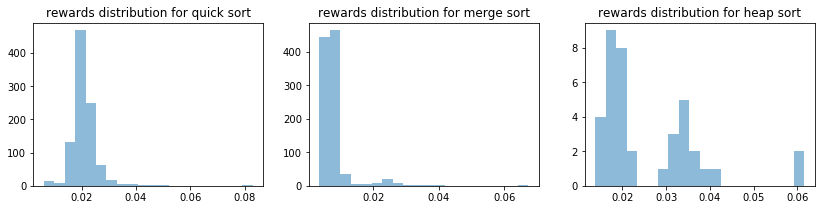

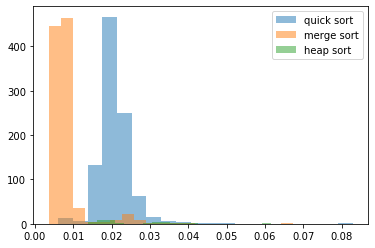

In [47]:
plot_rewards_distribution(arm_rewards_3)
plot_rewards_distribution_together(arm_rewards_3)

Restart at iteration: 502
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.021094286737160906, 'merge_sort': 0.027146666667595992, 'heap_sort': 0.04084128570892582}
Count per chosen algo {'quick_sort': 475, 'merge_sort': 21, 'heap_sort': 7}


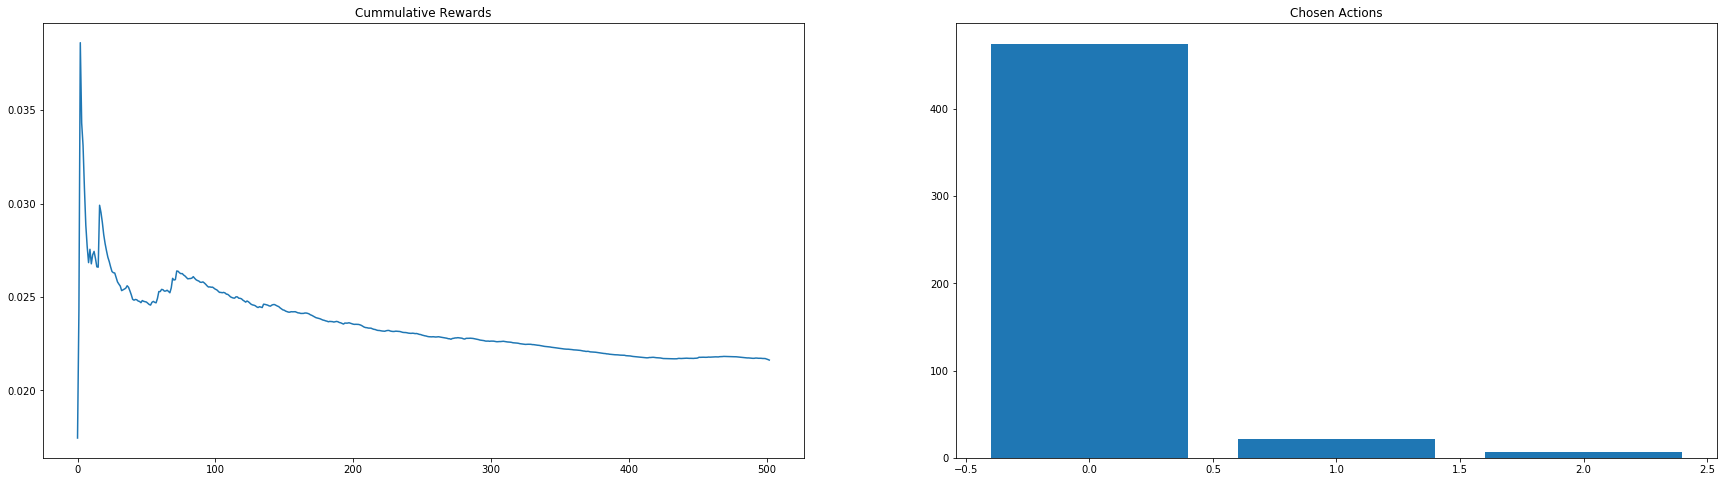

Restart at iteration: 1002
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009367555557724295, 'merge_sort': 0.007233997741228857, 'heap_sort': 0.01654824999786797}
Count per chosen algo {'quick_sort': 9, 'merge_sort': 487, 'heap_sort': 4}


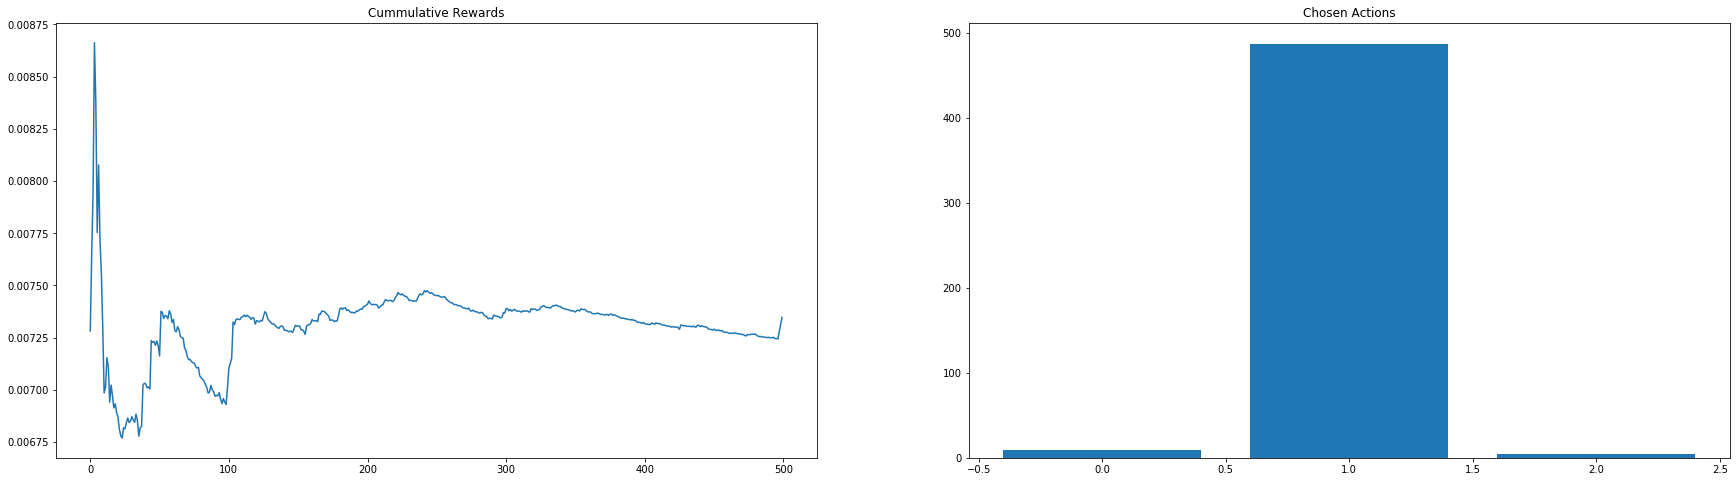

Restart at iteration: 1127
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.020464052631149043, 'merge_sort': 0.02403342499746941, 'heap_sort': 0.035681866667194605}
Count per chosen algo {'quick_sort': 114, 'merge_sort': 8, 'heap_sort': 3}


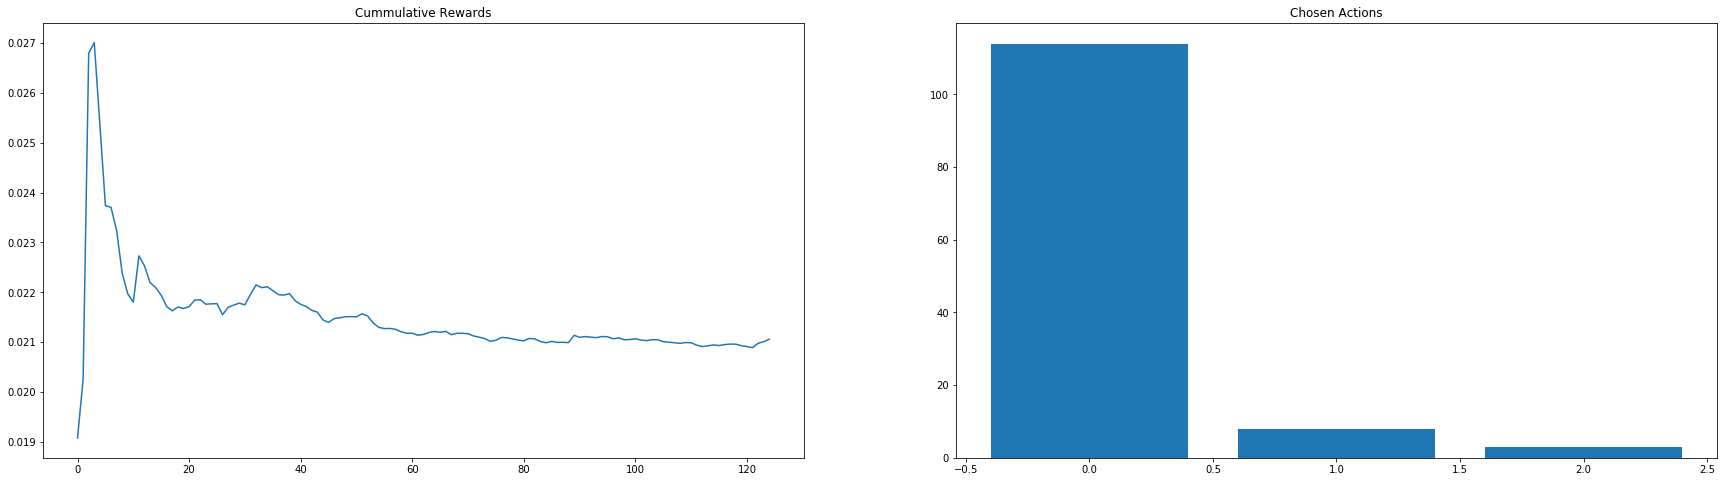

Restart at iteration: 1504
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02094630055838751, 'merge_sort': 0.025102271429204848, 'heap_sort': 0.03545697999652475}
Count per chosen algo {'quick_sort': 358, 'merge_sort': 14, 'heap_sort': 5}


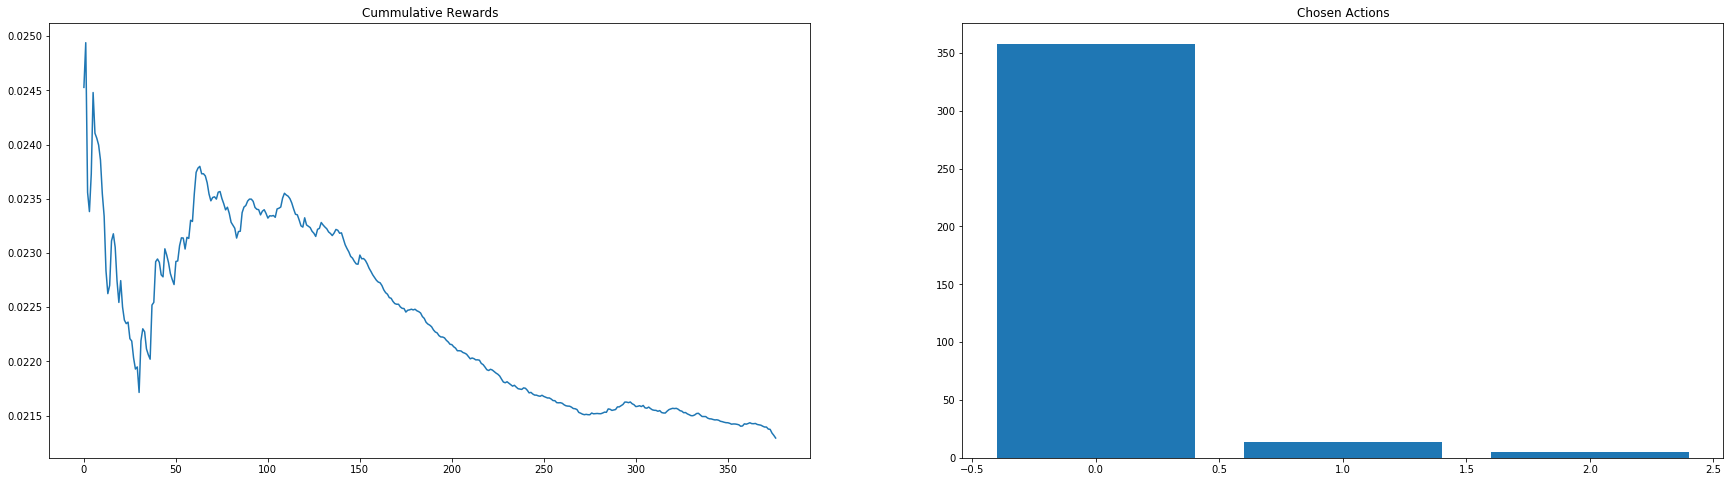

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009732533331164936, 'merge_sort': 0.0070009195736852135, 'heap_sort': 0.018496252633141058}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 470, 'heap_sort': 19}


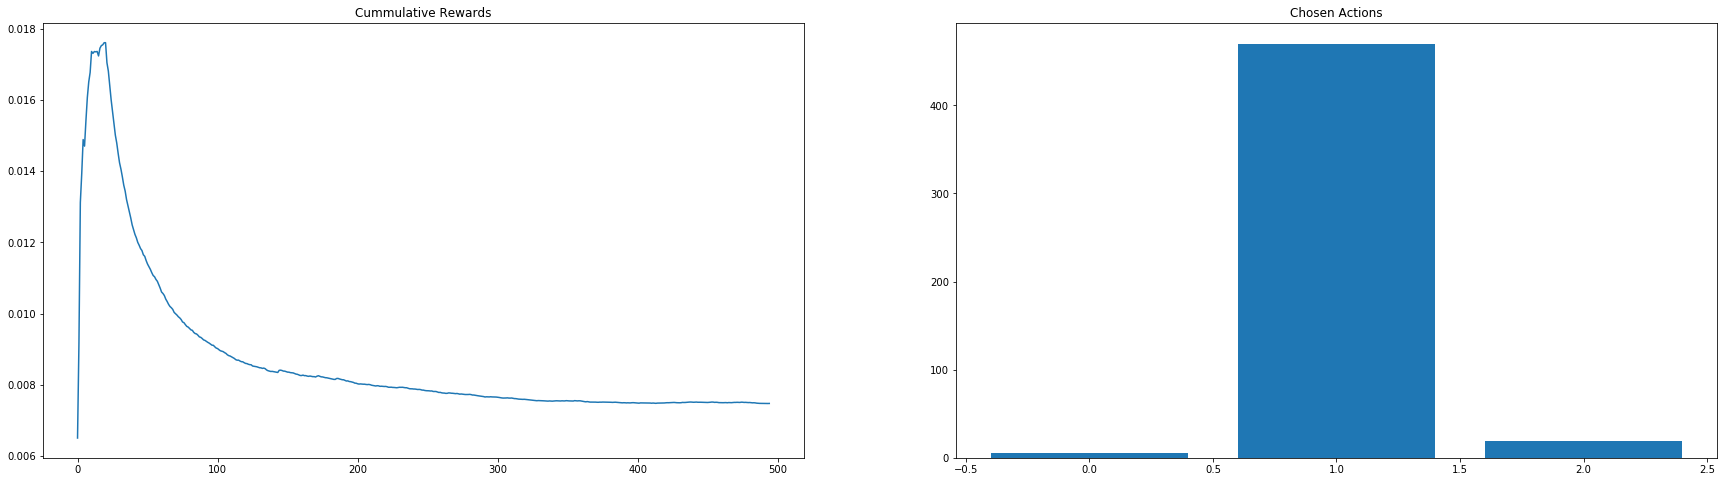

Total reward 28.9092


In [48]:
for elem in list_iteration_results_3:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_3,4))

## Four outliers in a row restart the expriment

In [49]:
list_iteration_results_4, total_reward_4, arm_rewards_4 = ts_quantile(list_distributions, n_samples, num_consec_elem=4)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.09873012241663986
Less than two values for merge_sort
merge_sort Theta 0.02784231014621068
Less than two values for heap_sort
heap_sort Theta 0.019077970090522846


Chosen algorithm is:  heap_sort with reward: 0.0358808000019053
Sample mean is:  0.0358808000019053 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.07988416600421173
Less than two values for merge_sort
merge_sort Theta 0.09164323021157059
Less than two values for heap_sort
heap_sort Theta 0.0747561474203237


Chosen algorithm is:  heap_sort with reward: 0.029393999997409992
Sample mean is:  0.032637399999657646 Sample variance is: 1.0519643574580081e-05


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.024717134287918642
Less than two values for merge_sort
merge_sort Theta 0.07475743417018235
heap_sort Theta 0.028893601763031615


Chosen algorithm is:  quick_sort with reward: 0.016988599993


Iteration: 30
quick_sort Theta 0.01954597447790732
merge_sort Theta 0.018523010157142496
heap_sort Theta 0.034908219212801295


Chosen algorithm is:  merge_sort with reward: 0.024462999994284473
Sample mean is:  0.02324705999926664 Sample variance is: 4.392255877257559e-06


Iteration: 31
quick_sort Theta 0.01966796493707838
merge_sort Theta 0.022103116808867958
heap_sort Theta 0.03505917934441859


Chosen algorithm is:  quick_sort with reward: 0.018597100002807565
Sample mean is:  0.019393772222328052 Sample variance is: 2.7375015075715453e-06


Iteration: 32
quick_sort Theta 0.019452848015335297
merge_sort Theta 0.022489348094181315
heap_sort Theta 0.03433780525455555


Chosen algorithm is:  quick_sort with reward: 0.017709299994749017
Sample mean is:  0.019305115789297576 Sample variance is: 2.7349018169756232e-06


Iteration: 33
quick_sort Theta 0.019593787963990753
merge_sort Theta 0.02325860912462632
heap_sort Theta 0.03246635911255788


Chosen algorithm is:  quick_sort with rew


Iteration: 63
quick_sort Theta 0.019673697746738564
merge_sort Theta 0.023303779366853575
heap_sort Theta 0.03451651879553646


Chosen algorithm is:  quick_sort with reward: 0.021839599998202175
Sample mean is:  0.019884487999079284 Sample variance is: 6.12562837086388e-06


Iteration: 64
quick_sort Theta 0.019923025399605044
merge_sort Theta 0.023025001087438584
heap_sort Theta 0.03391398118181323


Chosen algorithm is:  quick_sort with reward: 0.021621300009428523
Sample mean is:  0.019918543136537112 Sample variance is: 6.063505630014442e-06


Iteration: 65
quick_sort Theta 0.01979213346616357
merge_sort Theta 0.02308684655832048
heap_sort Theta 0.03415894437064045


Chosen algorithm is:  quick_sort with reward: 0.019291699994937517
Sample mean is:  0.01990648846073712 Sample variance is: 5.9543108281549535e-06


Iteration: 66
quick_sort Theta 0.019927412111421752
merge_sort Theta 0.023603423076817353
heap_sort Theta 0.030831962851700687


Chosen algorithm is:  quick_sort with rewa


Iteration: 96
quick_sort Theta 0.020177765530869966
merge_sort Theta 0.023793070065148685
heap_sort Theta 0.03184206836483554


Chosen algorithm is:  quick_sort with reward: 0.01979120000032708
Sample mean is:  0.01983201084307855 Sample variance is: 5.831460645125936e-06


Iteration: 97
quick_sort Theta 0.019749726973891733
merge_sort Theta 0.02315982966651833
heap_sort Theta 0.03594479231713241


Chosen algorithm is:  quick_sort with reward: 0.024820200007525273
Sample mean is:  0.019891394047417202 Sample variance is: 6.0547267860633845e-06


Iteration: 98
quick_sort Theta 0.01982462166952517
merge_sort Theta 0.02260952852274176
heap_sort Theta 0.032873022762901674


Chosen algorithm is:  quick_sort with reward: 0.02070709998952225
Sample mean is:  0.019900990587912556 Sample variance is: 5.991230567743577e-06


Iteration: 99
quick_sort Theta 0.01977888202261244
merge_sort Theta 0.022223525648396924
heap_sort Theta 0.033822611047724


Chosen algorithm is:  quick_sort with reward: 0


Chosen algorithm is:  quick_sort with reward: 0.021844400005647913
Sample mean is:  0.020053135087277553 Sample variance is: 5.212594402256479e-06


Iteration: 128
quick_sort Theta 0.01990873414643003
merge_sort Theta 0.02356940282182555
heap_sort Theta 0.036731995765553714


Chosen algorithm is:  quick_sort with reward: 0.018296800000825897
Sample mean is:  0.020037862608264928 Sample variance is: 5.193857836542545e-06


Iteration: 129
quick_sort Theta 0.020326334528748567
merge_sort Theta 0.022666253682947998
heap_sort Theta 0.03334357090508138


Chosen algorithm is:  quick_sort with reward: 0.018831300010788254
Sample mean is:  0.020027461206562545 Sample variance is: 5.161524953118682e-06


Iteration: 130
quick_sort Theta 0.019849225700689352
merge_sort Theta 0.023573462343306133
heap_sort Theta 0.033027860332016316


Chosen algorithm is:  quick_sort with reward: 0.02530039999692235
Sample mean is:  0.020072529059471603 Sample variance is: 5.3530182736653486e-06


Iteration: 131
q


Iteration: 158
quick_sort Theta 0.020184468779380734
merge_sort Theta 0.023325623531145416
heap_sort Theta 0.03525732172531194


Chosen algorithm is:  quick_sort with reward: 0.02109049999853596
Sample mean is:  0.020340303447828147 Sample variance is: 6.1515836170841196e-06


Iteration: 159
quick_sort Theta 0.019948078352712298
merge_sort Theta 0.022439853567584638
heap_sort Theta 0.03480790564103614


Chosen algorithm is:  quick_sort with reward: 0.021297400002367795
Sample mean is:  0.020346858903681157 Sample variance is: 6.115680712929443e-06


Iteration: 160
quick_sort Theta 0.02004640656061515
merge_sort Theta 0.024565408368252918
heap_sort Theta 0.03455887786046931


Chosen algorithm is:  quick_sort with reward: 0.02527080000436399
Sample mean is:  0.020380355101644987 Sample variance is: 6.237888753366135e-06


Iteration: 161
quick_sort Theta 0.020453495185173375
merge_sort Theta 0.02361893346116237
heap_sort Theta 0.034073037387055034


Chosen algorithm is:  quick_sort with 


Chosen algorithm is:  quick_sort with reward: 0.02227370000036899
Sample mean is:  0.020354534090570683 Sample variance is: 6.088396462320206e-06


Iteration: 191
quick_sort Theta 0.020573711116715788
merge_sort Theta 0.02288551725033933
heap_sort Theta 0.033601992131264226


Chosen algorithm is:  quick_sort with reward: 0.022646800003712997
Sample mean is:  0.020367484745447192 Sample variance is: 6.083517367458668e-06


Iteration: 192
quick_sort Theta 0.020878281875400487
merge_sort Theta 0.024125552203509874
heap_sort Theta 0.03290282987181328


Chosen algorithm is:  quick_sort with reward: 0.022054000000935048
Sample mean is:  0.020376959550253305 Sample variance is: 6.065229934518704e-06


Iteration: 193
quick_sort Theta 0.020260265261982907
merge_sort Theta 0.024162316726270297
heap_sort Theta 0.033693982149434955


Chosen algorithm is:  quick_sort with reward: 0.021124099992448464
Sample mean is:  0.020381133519204116 Sample variance is: 6.034447087394889e-06


Iteration: 194
q


Chosen algorithm is:  quick_sort with reward: 0.019395499999518506
Sample mean is:  0.020329018268967047 Sample variance is: 5.824542980040391e-06


Iteration: 223
quick_sort Theta 0.02049962035153152
merge_sort Theta 0.023621125706570077
heap_sort Theta 0.03395224741179875


Chosen algorithm is:  quick_sort with reward: 0.020840600001974963
Sample mean is:  0.020331466028455123 Sample variance is: 5.797920590856018e-06


Iteration: 224
quick_sort Theta 0.020328347062842728
merge_sort Theta 0.022370546975129642
heap_sort Theta 0.03320419923638023


Chosen algorithm is:  quick_sort with reward: 0.025907299990649335
Sample mean is:  0.020358017618751285 Sample variance is: 5.917653717161631e-06


Iteration: 225
quick_sort Theta 0.02042026486679719
merge_sort Theta 0.02326930314336214
heap_sort Theta 0.0339897628617881


Chosen algorithm is:  quick_sort with reward: 0.02443180000409484
Sample mean is:  0.02037732464427424 Sample variance is: 5.9678878242018445e-06


Iteration: 226
quick_


Chosen algorithm is:  quick_sort with reward: 0.02746369999658782
Sample mean is:  0.020638623529154427 Sample variance is: 6.843954155050302e-06


Iteration: 253
quick_sort Theta 0.020604243186246433
merge_sort Theta 0.023284950562378875
heap_sort Theta 0.03604554796388071


Chosen algorithm is:  quick_sort with reward: 0.022437599996919744
Sample mean is:  0.020646150627345913 Sample variance is: 6.828802778916435e-06


Iteration: 254
quick_sort Theta 0.020748394964532322
merge_sort Theta 0.021430258859373257
heap_sort Theta 0.035994776877469936


Chosen algorithm is:  quick_sort with reward: 0.019136999995680526
Sample mean is:  0.020639862499713977 Sample variance is: 6.8097996252429005e-06


Iteration: 255
quick_sort Theta 0.020498094394170628
merge_sort Theta 0.023773223090237553
heap_sort Theta 0.03276146680930197


Chosen algorithm is:  quick_sort with reward: 0.02143419999629259
Sample mean is:  0.020643158505923846 Sample variance is: 6.78415047292716e-06


Iteration: 256
qu


Chosen algorithm is:  quick_sort with reward: 0.024271200003568083
Sample mean is:  0.02064097003716093 Sample variance is: 7.426283613705265e-06


Iteration: 284
quick_sort Theta 0.02039516512483964
merge_sort Theta 0.02365013418830715
heap_sort Theta 0.03365637261615228


Chosen algorithm is:  quick_sort with reward: 0.020010799998999573
Sample mean is:  0.020638618656421522 Sample variance is: 7.400049840920193e-06


Iteration: 285
quick_sort Theta 0.020686455438420764
merge_sort Theta 0.024120866448431373
heap_sort Theta 0.0324098161246568


Chosen algorithm is:  quick_sort with reward: 0.018828800006303936
Sample mean is:  0.020631890706049337 Sample variance is: 7.384671466702098e-06


Iteration: 286
quick_sort Theta 0.02093246571457293
merge_sort Theta 0.023893373246240288
heap_sort Theta 0.03366707115463113


Chosen algorithm is:  quick_sort with reward: 0.024137500004144385
Sample mean is:  0.02064487444419043 Sample variance is: 7.40266816733557e-06


Iteration: 287
quick_so


Chosen algorithm is:  quick_sort with reward: 0.019185999990440905
Sample mean is:  0.02060429866200455 Sample variance is: 7.132819985392936e-06


Iteration: 316
quick_sort Theta 0.020692177003217113
merge_sort Theta 0.02285435380084399
heap_sort Theta 0.03452325944483174


Chosen algorithm is:  quick_sort with reward: 0.01871620000747498
Sample mean is:  0.020598004999822783 Sample variance is: 7.120887363688756e-06


Iteration: 317
quick_sort Theta 0.020525965808592454
merge_sort Theta 0.02344982035715339
heap_sort Theta 0.03543407693323053


Chosen algorithm is:  quick_sort with reward: 0.015210199999273755
Sample mean is:  0.020580105315435575 Sample variance is: 7.193349540935277e-06


Iteration: 318
quick_sort Theta 0.020812778916915863
merge_sort Theta 0.022803529928154206
heap_sort Theta 0.03403159585628369


Chosen algorithm is:  quick_sort with reward: 0.017574199999216944
Sample mean is:  0.020570151986573925 Sample variance is: 7.199350198104141e-06


Iteration: 319
quick


Chosen algorithm is:  quick_sort with reward: 0.01606500000343658
Sample mean is:  0.02045822312291355 Sample variance is: 7.008650663446598e-06


Iteration: 350
quick_sort Theta 0.02053001045053226
merge_sort Theta 0.022505486505149056
heap_sort Theta 0.033908634244327614


Chosen algorithm is:  quick_sort with reward: 0.019204500000341795
Sample mean is:  0.02045446946086992 Sample variance is: 6.992358642343981e-06


Iteration: 351
quick_sort Theta 0.020634273365798487
merge_sort Theta 0.02286971037575553
heap_sort Theta 0.035553602908454336


Chosen algorithm is:  quick_sort with reward: 0.02001580000796821
Sample mean is:  0.020453159999816485 Sample variance is: 6.972058635854433e-06


Iteration: 352
quick_sort Theta 0.020415215472803516
merge_sort Theta 0.024180753903158013
heap_sort Theta 0.03335310854890276


Chosen algorithm is:  quick_sort with reward: 0.021936799996183254
Sample mean is:  0.020457575595043766 Sample variance is: 6.957840117548712e-06


Iteration: 353
quick


Chosen algorithm is:  quick_sort with reward: 0.01863479999883566
Sample mean is:  0.02042090602730216 Sample variance is: 6.839241460874171e-06


Iteration: 382
quick_sort Theta 0.020392835107848103
merge_sort Theta 0.023155949132030743
heap_sort Theta 0.03576236591553838


Chosen algorithm is:  quick_sort with reward: 0.02117290000023786
Sample mean is:  0.020422960655643512 Sample variance is: 6.822095855426981e-06


Iteration: 383
quick_sort Theta 0.02054604777503363
merge_sort Theta 0.024479443751251308
heap_sort Theta 0.0333867244343302


Chosen algorithm is:  quick_sort with reward: 0.018438200000673532
Sample mean is:  0.02041755258846376 Sample variance is: 6.814211510149412e-06


Iteration: 384
quick_sort Theta 0.020700458839003875
merge_sort Theta 0.02464389595547621
heap_sort Theta 0.034810084895993146


Chosen algorithm is:  quick_sort with reward: 0.017004900000756606
Sample mean is:  0.02040827907599716 Sample variance is: 6.8272559093285386e-06


Iteration: 385
quick_s


Chosen algorithm is:  quick_sort with reward: 0.024020900003961287
Sample mean is:  0.020470389924286302 Sample variance is: 7.142974783123949e-06


Iteration: 414
quick_sort Theta 0.020291005997436495
merge_sort Theta 0.025805263742481453
heap_sort Theta 0.03467542392434646


Chosen algorithm is:  quick_sort with reward: 0.026690200000302866
Sample mean is:  0.020486017587793882 Sample variance is: 7.2219844853843615e-06


Iteration: 415
quick_sort Theta 0.020561186226838397
merge_sort Theta 0.02388542710794737
heap_sort Theta 0.03856437647813549


Chosen algorithm is:  quick_sort with reward: 0.027333600010024384
Sample mean is:  0.020503179448501226 Sample variance is: 7.321106999890986e-06


Iteration: 416
quick_sort Theta 0.020545348987432058
merge_sort Theta 0.022636753687177585
heap_sort Theta 0.0343930960666967


Chosen algorithm is:  quick_sort with reward: 0.019760800001677126
Sample mean is:  0.020501323499884164 Sample variance is: 7.304178605953657e-06


Iteration: 417
qu


Iteration: 446
quick_sort Theta 0.0205771911775765
merge_sort Theta 0.02462247819382393
heap_sort Theta 0.03281243899181553


Chosen algorithm is:  quick_sort with reward: 0.01649619999807328
Sample mean is:  0.02045591837187774 Sample variance is: 7.314393862353663e-06


Iteration: 447
quick_sort Theta 0.020535303364819107
merge_sort Theta 0.025674572244240086
heap_sort Theta 0.03494434130532014


Chosen algorithm is:  quick_sort with reward: 0.01936589999240823
Sample mean is:  0.020453389326913776 Sample variance is: 7.300173420357688e-06


Iteration: 448
quick_sort Theta 0.020503018765798155
merge_sort Theta 0.024042731198553137
heap_sort Theta 0.03421589472015413


Chosen algorithm is:  quick_sort with reward: 0.02277130000584293
Sample mean is:  0.020458754860892776 Sample variance is: 7.295682910326734e-06


Iteration: 449
quick_sort Theta 0.02045156891413785
merge_sort Theta 0.02173938892804167
heap_sort Theta 0.0367473032320612


Chosen algorithm is:  quick_sort with reward: 


Chosen algorithm is:  quick_sort with reward: 0.018745499997748993
Sample mean is:  0.0203788162337478 Sample variance is: 7.281311150070009e-06


Iteration: 479
quick_sort Theta 0.020629002105218616
merge_sort Theta 0.022933161025751096
heap_sort Theta 0.036130805843241395


Chosen algorithm is:  quick_sort with reward: 0.019155900008627214
Sample mean is:  0.02037617494600456 Sample variance is: 7.268807873331254e-06


Iteration: 480
quick_sort Theta 0.020402332954483796
merge_sort Theta 0.025430030721873567
heap_sort Theta 0.03254535623778774


Chosen algorithm is:  quick_sort with reward: 0.01781019999179989
Sample mean is:  0.020370644827568774 Sample variance is: 7.267301902311586e-06


Iteration: 481
quick_sort Theta 0.020187751448394773
merge_sort Theta 0.026940536145014685
heap_sort Theta 0.03530680563593445


Chosen algorithm is:  quick_sort with reward: 0.021212399995420128
Sample mean is:  0.020372455053736194 Sample variance is: 7.253193786382687e-06


Iteration: 482
quic


Iteration: 510
Less than two values for quick_sort
quick_sort Theta 0.03932079133194784
Less than two values for merge_sort
merge_sort Theta 0.0800550477534336
heap_sort Theta 0.01827273905253728


Chosen algorithm is:  heap_sort with reward: 0.018528700005845167
Sample mean is:  0.01866156666801544 Sample variance is: 1.4642962931118114e-05


Iteration: 511
Less than two values for quick_sort
quick_sort Theta 0.04946666841469698
Less than two values for merge_sort
merge_sort Theta 0.05024659837666734
heap_sort Theta 0.02111373167300024


Chosen algorithm is:  heap_sort with reward: 0.017528600001242012
Sample mean is:  0.018499714287047806 Sample variance is: 1.2708288243164876e-05


Iteration: 512
Less than two values for quick_sort
quick_sort Theta 0.08175649076800656
Less than two values for merge_sort
merge_sort Theta 0.02488678877792219
heap_sort Theta 0.014668711021180267


Chosen algorithm is:  heap_sort with reward: 0.012925800008815713
Sample mean is:  0.017802975002268795 S


Chosen algorithm is:  merge_sort with reward: 0.0060582000005524606
Sample mean is:  0.006827737499406794 Sample variance is: 1.1731441599922627e-06


Iteration: 538
quick_sort Theta 0.00743359294996403
merge_sort Theta 0.006663803703175332
heap_sort Theta 0.016516022146348324


Chosen algorithm is:  merge_sort with reward: 0.008039000007556751
Sample mean is:  0.006898988235180321 Sample variance is: 1.185362357565021e-06


Iteration: 539
quick_sort Theta 0.008460221842684221
merge_sort Theta 0.006317479526465721
heap_sort Theta 0.01769797635495001


Chosen algorithm is:  merge_sort with reward: 0.0068408000079216436
Sample mean is:  0.006895755555888172 Sample variance is: 1.119686546917753e-06


Iteration: 540
quick_sort Theta 0.009420402335500053
merge_sort Theta 0.00676998643876671
heap_sort Theta 0.017604721292346033


Chosen algorithm is:  merge_sort with reward: 0.006308799987891689
Sample mean is:  0.0068648631575725675 Sample variance is: 1.0779338009537643e-06


Iteration: 


Chosen algorithm is:  merge_sort with reward: 0.006482199998572469
Sample mean is:  0.006648447726712964 Sample variance is: 1.4057598654135227e-06


Iteration: 568
quick_sort Theta 0.009141566349082548
merge_sort Theta 0.006773536231088787
heap_sort Theta 0.016052009302851954


Chosen algorithm is:  merge_sort with reward: 0.007671100000152364
Sample mean is:  0.006671173332789396 Sample variance is: 1.3972446968410316e-06


Iteration: 569
quick_sort Theta 0.00886103042927536
merge_sort Theta 0.006719289936735641
heap_sort Theta 0.017989714567431005


Chosen algorithm is:  merge_sort with reward: 0.00682049999886658
Sample mean is:  0.006674419564660639 Sample variance is: 1.3673440230883802e-06


Iteration: 570
quick_sort Theta 0.009133825090040135
merge_sort Theta 0.006433645653795503
heap_sort Theta 0.016402541653489314


Chosen algorithm is:  merge_sort with reward: 0.006931099997018464
Sample mean is:  0.006679880850455486 Sample variance is: 1.3396235766217415e-06


Iteration: 



Chosen algorithm is:  merge_sort with reward: 0.0064134999993257225
Sample mean is:  0.006672192104528413 Sample variance is: 1.2219985008458481e-06


Iteration: 600
quick_sort Theta 0.00931079993644606
merge_sort Theta 0.006761080146167955
heap_sort Theta 0.016986782964578978


Chosen algorithm is:  merge_sort with reward: 0.007205200003227219
Sample mean is:  0.006679114285030995 Sample variance is: 1.2097700507464374e-06


Iteration: 601
quick_sort Theta 0.008116146061942846
merge_sort Theta 0.006832879882102801
heap_sort Theta 0.018070909084961926


Chosen algorithm is:  merge_sort with reward: 0.0039000999968266115
Sample mean is:  0.006643485896720682 Sample variance is: 1.2920025964274325e-06


Iteration: 602
quick_sort Theta 0.008623755869614436
merge_sort Theta 0.006624525607236156
heap_sort Theta 0.018017350971169802


Chosen algorithm is:  merge_sort with reward: 0.006235900000319816
Sample mean is:  0.006638326581576368 Sample variance is: 1.2777243787366673e-06


Iterati


Chosen algorithm is:  merge_sort with reward: 0.008259000009275042
Sample mean is:  0.006626252829726513 Sample variance is: 1.403089741856633e-06


Iteration: 631
quick_sort Theta 0.008657355442103953
merge_sort Theta 0.006598982128435156
heap_sort Theta 0.017310976244031415


Chosen algorithm is:  merge_sort with reward: 0.007177100007538684
Sample mean is:  0.0066314009341920475 Sample variance is: 1.3927860694513159e-06


Iteration: 632
quick_sort Theta 0.008857975090878654
merge_sort Theta 0.006688588759667836
heap_sort Theta 0.016112601761705213


Chosen algorithm is:  merge_sort with reward: 0.0069420000072568655
Sample mean is:  0.0066342768515352405 Sample variance is: 1.3807748885020234e-06


Iteration: 633
quick_sort Theta 0.008765751103266942
merge_sort Theta 0.006830798132019106
heap_sort Theta 0.017315893538255026


Chosen algorithm is:  merge_sort with reward: 0.009198300002026372
Sample mean is:  0.006657799999704884 Sample variance is: 1.4278677869540697e-06


Iterati


Iteration: 661
quick_sort Theta 0.0077786675671013515
merge_sort Theta 0.006645702818326114
heap_sort Theta 0.017630331394937034


Chosen algorithm is:  merge_sort with reward: 0.007088500002282672
Sample mean is:  0.006705309488588815 Sample variance is: 1.4656325493273075e-06


Iteration: 662
quick_sort Theta 0.009406875531304178
merge_sort Theta 0.006626033654268497
heap_sort Theta 0.016692147566954463


Chosen algorithm is:  merge_sort with reward: 0.005194299999857321
Sample mean is:  0.006694360144467572 Sample variance is: 1.471436698333443e-06


Iteration: 663
quick_sort Theta 0.008703762833716492
merge_sort Theta 0.006597495296478023
heap_sort Theta 0.016368357313656042


Chosen algorithm is:  merge_sort with reward: 0.007659299997612834
Sample mean is:  0.006701302157799552 Sample variance is: 1.4675012565818566e-06


Iteration: 664
quick_sort Theta 0.010566270641131017
merge_sort Theta 0.006785116688304244
heap_sort Theta 0.016217276123008783


Chosen algorithm is:  merge_s


Iteration: 691
quick_sort Theta 0.008614940731292953
merge_sort Theta 0.006672399712053007
heap_sort Theta 0.016402262405543277


Chosen algorithm is:  merge_sort with reward: 0.006698700002743863
Sample mean is:  0.0067449431135500415 Sample variance is: 1.60360628293988e-06


Iteration: 692
quick_sort Theta 0.009420409760502988
merge_sort Theta 0.0067229101718700585
heap_sort Theta 0.016834715028644916


Chosen algorithm is:  merge_sort with reward: 0.003961300011724234
Sample mean is:  0.0067283738093725075 Sample variance is: 1.6399094948811104e-06


Iteration: 693
quick_sort Theta 0.01002700425954396
merge_sort Theta 0.006711990767883418
heap_sort Theta 0.01748856589525298


Chosen algorithm is:  merge_sort with reward: 0.008180800010450184
Sample mean is:  0.006736968047248707 Sample variance is: 1.6426145237475369e-06


Iteration: 694
quick_sort Theta 0.008999444900448988
merge_sort Theta 0.006887466863255298
heap_sort Theta 0.017366396555434014


Chosen algorithm is:  merge_so


Iteration: 723
quick_sort Theta 0.008497972423502006
merge_sort Theta 0.006744977776660076
heap_sort Theta 0.01835129153556957


Chosen algorithm is:  merge_sort with reward: 0.0074751999927684665
Sample mean is:  0.006722002009827241 Sample variance is: 1.5994053552617822e-06


Iteration: 724
quick_sort Theta 0.008040998127745155
merge_sort Theta 0.006768223413504554
heap_sort Theta 0.01709606733505298


Chosen algorithm is:  merge_sort with reward: 0.005670700003975071
Sample mean is:  0.0067167454997979804 Sample variance is: 1.5969068771253297e-06


Iteration: 725
quick_sort Theta 0.008867079150083912
merge_sort Theta 0.0066476685314399665
heap_sort Theta 0.01654185298497113


Chosen algorithm is:  merge_sort with reward: 0.006767499988200143
Sample mean is:  0.006716998009690528 Sample variance is: 1.5889748190405396e-06


Iteration: 726
quick_sort Theta 0.00885661564691277
merge_sort Theta 0.0067415309553027014
heap_sort Theta 0.01714276783372542


Chosen algorithm is:  merge_so


Iteration: 753
quick_sort Theta 0.008660586973599081
merge_sort Theta 0.0066988132923876086
heap_sort Theta 0.01656847746529837


Chosen algorithm is:  merge_sort with reward: 0.007727499993052334
Sample mean is:  0.006702414410179644 Sample variance is: 1.6282188882281715e-06


Iteration: 754
quick_sort Theta 0.008464691453191982
merge_sort Theta 0.006705677114770109
heap_sort Theta 0.017425740327108655


Chosen algorithm is:  merge_sort with reward: 0.006693599993013777
Sample mean is:  0.006702376086626749 Sample variance is: 1.6211400120017452e-06


Iteration: 755
quick_sort Theta 0.008569610434498677
merge_sort Theta 0.006821362376370211
heap_sort Theta 0.017341799812560742


Chosen algorithm is:  merge_sort with reward: 0.005399299989221618
Sample mean is:  0.006696735064560059 Sample variance is: 1.6214409497619481e-06


Iteration: 756
quick_sort Theta 0.011935880003571382
merge_sort Theta 0.00679497811505145
heap_sort Theta 0.01803383586437179


Chosen algorithm is:  merge_sor



Iteration: 785
quick_sort Theta 0.008621574092747537
merge_sort Theta 0.006515926555064132
heap_sort Theta 0.01739257483973626


Chosen algorithm is:  merge_sort with reward: 0.006263899995246902
Sample mean is:  0.006798434614980719 Sample variance is: 2.791393410758353e-06


Iteration: 786
quick_sort Theta 0.00872112922306691
merge_sort Theta 0.006596979461506402
heap_sort Theta 0.01721593413940287


Chosen algorithm is:  merge_sort with reward: 0.008725100007723086
Sample mean is:  0.006805816474723027 Sample variance is: 2.794866298693729e-06


Iteration: 787
quick_sort Theta 0.009480393710649196
merge_sort Theta 0.006927403597840995
heap_sort Theta 0.01595212926315029


Chosen algorithm is:  merge_sort with reward: 0.005984100003843196
Sample mean is:  0.006802680152315089 Sample variance is: 2.786766201335106e-06


Iteration: 788
quick_sort Theta 0.008524147332842468
merge_sort Theta 0.006777292043199367
heap_sort Theta 0.016721500701039126


Chosen algorithm is:  merge_sort wi


Iteration: 818
quick_sort Theta 0.00900638891893241
merge_sort Theta 0.006929956081334566
heap_sort Theta 0.01804488954358417


Chosen algorithm is:  merge_sort with reward: 0.006290000004810281
Sample mean is:  0.006842422866711072 Sample variance is: 2.6900115851302856e-06


Iteration: 819
quick_sort Theta 0.007789652333738649
merge_sort Theta 0.00684535785356202
heap_sort Theta 0.01757886312813498


Chosen algorithm is:  merge_sort with reward: 0.006747599996742792
Sample mean is:  0.006842100339942472 Sample variance is: 2.6808923647514583e-06


Iteration: 820
quick_sort Theta 0.009245138679805868
merge_sort Theta 0.006698328569590246
heap_sort Theta 0.018427704084614346


Chosen algorithm is:  merge_sort with reward: 0.004966599997715093
Sample mean is:  0.0068357427116637354 Sample variance is: 2.683687908598683e-06


Iteration: 821
quick_sort Theta 0.008226684665563757
merge_sort Theta 0.006937760821712254
heap_sort Theta 0.01698076909360871


Chosen algorithm is:  merge_sort w


Iteration: 849
quick_sort Theta 0.010001901963416514
merge_sort Theta 0.006584114590570027
heap_sort Theta 0.016700753768357505


Chosen algorithm is:  merge_sort with reward: 0.00812210000003688
Sample mean is:  0.006824528703738771 Sample variance is: 2.6133531789926502e-06


Iteration: 850
quick_sort Theta 0.009803579070495979
merge_sort Theta 0.006918310246950141
heap_sort Theta 0.01665029903123136


Chosen algorithm is:  merge_sort with reward: 0.007140100002288818
Sample mean is:  0.0068254996923496946 Sample variance is: 2.605617565606002e-06


Iteration: 851
quick_sort Theta 0.009060443470577155
merge_sort Theta 0.006879135437506231
heap_sort Theta 0.017320146928758797


Chosen algorithm is:  merge_sort with reward: 0.007005900013609789
Sample mean is:  0.006826053067568284 Sample variance is: 2.5977243965300433e-06


Iteration: 852
quick_sort Theta 0.00897727590345092
merge_sort Theta 0.00691729280631507
heap_sort Theta 0.015943422213170067


Chosen algorithm is:  merge_sort 


Iteration: 879
quick_sort Theta 0.008259125718139844
merge_sort Theta 0.00693630272743449
heap_sort Theta 0.016356045653680873


Chosen algorithm is:  merge_sort with reward: 0.008776599992415868
Sample mean is:  0.006818895762681693 Sample variance is: 2.4882005090107677e-06


Iteration: 880
quick_sort Theta 0.00876064591052787
merge_sort Theta 0.006795972171942343
heap_sort Theta 0.01654488988759384


Chosen algorithm is:  merge_sort with reward: 0.006516300010844134
Sample mean is:  0.006818043380282151 Sample variance is: 2.4814486942297152e-06


Iteration: 881
quick_sort Theta 0.008527013405539451
merge_sort Theta 0.006732107476702467
heap_sort Theta 0.017466067127082215


Chosen algorithm is:  merge_sort with reward: 0.00681320000148844
Sample mean is:  0.006818029775285539 Sample variance is: 2.4744783984381265e-06


Iteration: 882
quick_sort Theta 0.009156750122226045
merge_sort Theta 0.006914307369800507
heap_sort Theta 0.016410638705028974


Chosen algorithm is:  merge_sort 


Iteration: 909
quick_sort Theta 0.008771938843245813
merge_sort Theta 0.006838563569361542
heap_sort Theta 0.01711413857078221


Chosen algorithm is:  merge_sort with reward: 0.008108699999866076
Sample mean is:  0.006820387239637664 Sample variance is: 2.392583850323046e-06


Iteration: 910
quick_sort Theta 0.008432200372431432
merge_sort Theta 0.00682319760511803
heap_sort Theta 0.015215809198762902


Chosen algorithm is:  merge_sort with reward: 0.007321700002648868
Sample mean is:  0.00682168935071042 Sample variance is: 2.3870204162220985e-06


Iteration: 911
quick_sort Theta 0.00836306839006346
merge_sort Theta 0.006771702167193737
heap_sort Theta 0.016542121672353312


Chosen algorithm is:  merge_sort with reward: 0.004996999996365048
Sample mean is:  0.006816962176217297 Sample variance is: 2.389439704301543e-06


Iteration: 912
quick_sort Theta 0.00909746428247388
merge_sort Theta 0.006762418997888028
heap_sort Theta 0.015510956914055716


Chosen algorithm is:  merge_sort wit


Iteration: 939
quick_sort Theta 0.009695945713890135
merge_sort Theta 0.006878595311377431
heap_sort Theta 0.017427157585092504


Chosen algorithm is:  merge_sort with reward: 0.008065999994869344
Sample mean is:  0.006815661352711554 Sample variance is: 2.332869079134371e-06


Iteration: 940
quick_sort Theta 0.008042961288145965
merge_sort Theta 0.006801107641837024
heap_sort Theta 0.019557871379690603


Chosen algorithm is:  merge_sort with reward: 0.006059000006644055
Sample mean is:  0.0068138380723595845 Sample variance is: 2.3286239892734867e-06


Iteration: 941
quick_sort Theta 0.008046209434990384
merge_sort Theta 0.00687676528142111
heap_sort Theta 0.016482932998720914


Chosen algorithm is:  merge_sort with reward: 0.007191900003817864
Sample mean is:  0.006814746875079436 Sample variance is: 2.3233690932423155e-06


Iteration: 942
quick_sort Theta 0.009297692062786467
merge_sort Theta 0.006936660446937279
heap_sort Theta 0.016503949482119577


Chosen algorithm is:  merge_so


Iteration: 969
quick_sort Theta 0.007140270126979716
merge_sort Theta 0.0068465739894604215
heap_sort Theta 0.016866224684425273


Chosen algorithm is:  merge_sort with reward: 0.007690799990086816
Sample mean is:  0.00681973490983338 Sample variance is: 2.253719326747736e-06


Iteration: 970
quick_sort Theta 0.009203423304386716
merge_sort Theta 0.006913622937437654
heap_sort Theta 0.016380318456163116


Chosen algorithm is:  merge_sort with reward: 0.00753469999472145
Sample mean is:  0.006821341572945488 Sample variance is: 2.249800915596799e-06


Iteration: 971
quick_sort Theta 0.008514940352263828
merge_sort Theta 0.006970800654250448
heap_sort Theta 0.01621265822658038


Chosen algorithm is:  merge_sort with reward: 0.005174899997655302
Sample mean is:  0.00681764999990672 Sample variance is: 2.250820850542803e-06


Iteration: 972
quick_sort Theta 0.008962375743844718
merge_sort Theta 0.006810794304925209
heap_sort Theta 0.015170196488783958


Chosen algorithm is:  merge_sort wi


Iteration: 1002
quick_sort Theta 0.008000941524440355
merge_sort Theta 0.007004452554365018
heap_sort Theta 0.016640227573817806


Chosen algorithm is:  merge_sort with reward: 0.023795800007064827
Sample mean is:  0.006918570440157855 Sample variance is: 4.15340622764656e-06


Iteration: 1003
quick_sort Theta 0.009023101367364022
merge_sort Theta 0.006772082522679771
heap_sort Theta 0.01758198233013201


Chosen algorithm is:  merge_sort with reward: 0.024338400005945005
Sample mean is:  0.006955013598245277 Sample variance is: 4.778222592229623e-06
RESTART EXPERIMENT


Iteration: 1004
Less than two values for quick_sort
quick_sort Theta 0.09205148943806557
Less than two values for merge_sort
merge_sort Theta 0.021089379559264668
Less than two values for heap_sort
heap_sort Theta 0.0835381937752051


Chosen algorithm is:  merge_sort with reward: 0.021594000005279668
Sample mean is:  0.021594000005279668 Sample variance is: 0.0


Iteration: 1005
Less than two values for quick_sort
quic


Chosen algorithm is:  quick_sort with reward: 0.022611299995332956
Sample mean is:  0.020579233333086852 Sample variance is: 8.330996388706738e-06


Iteration: 1031
quick_sort Theta 0.02095349009503137
merge_sort Theta 0.03450815784858473
heap_sort Theta 0.029837455954399496


Chosen algorithm is:  quick_sort with reward: 0.020489899994572625
Sample mean is:  0.02057453157842821 Sample variance is: 7.89292081150794e-06


Iteration: 1032
quick_sort Theta 0.019992590252145268
merge_sort Theta 0.03645132570284264
heap_sort Theta 0.030670240752884912


Chosen algorithm is:  quick_sort with reward: 0.01772960000380408
Sample mean is:  0.020432284999697004 Sample variance is: 7.882722464986475e-06


Iteration: 1033
quick_sort Theta 0.020674670071677434
merge_sort Theta 0.02923320630119309
heap_sort Theta 0.031085287951986673


Chosen algorithm is:  quick_sort with reward: 0.020135700004175305
Sample mean is:  0.02041816190467216 Sample variance is: 7.511343964820162e-06


Iteration: 1034
qu


Iteration: 1060
quick_sort Theta 0.020817866040869153
merge_sort Theta 0.024936064072321355
heap_sort Theta 0.03015214960071579


Chosen algorithm is:  quick_sort with reward: 0.02421370000229217
Sample mean is:  0.020796423912068585 Sample variance is: 6.024990362934757e-06


Iteration: 1061
quick_sort Theta 0.02112060837020828
merge_sort Theta 0.02567582277770604
heap_sort Theta 0.0292832089726667


Chosen algorithm is:  quick_sort with reward: 0.017066200001863763
Sample mean is:  0.020717057445894017 Sample variance is: 6.186554732456806e-06


Iteration: 1062
quick_sort Theta 0.020059877438234536
merge_sort Theta 0.0276274332716593
heap_sort Theta 0.031122650765133826


Chosen algorithm is:  quick_sort with reward: 0.020121499997912906
Sample mean is:  0.020704649999061076 Sample variance is: 6.064903578165495e-06


Iteration: 1063
quick_sort Theta 0.02028643529647661
merge_sort Theta 0.030954703792685116
heap_sort Theta 0.03317272697290622


Chosen algorithm is:  quick_sort with 


Chosen algorithm is:  quick_sort with reward: 0.021424099992145784
Sample mean is:  0.020386393242153793 Sample variance is: 5.9421501717251375e-06


Iteration: 1091
quick_sort Theta 0.020635248697933938
merge_sort Theta 0.02459261123833835
heap_sort Theta 0.0311856701160719


Chosen algorithm is:  quick_sort with reward: 0.01749060000292957
Sample mean is:  0.020347782665630802 Sample variance is: 5.973238972607188e-06


Iteration: 1092
quick_sort Theta 0.020312364112763454
merge_sort Theta 0.02939214923761134
heap_sort Theta 0.029353884799558888


Chosen algorithm is:  quick_sort with reward: 0.021614899989799596
Sample mean is:  0.020364455262001445 Sample variance is: 5.915491883197995e-06


Iteration: 1093
quick_sort Theta 0.02030347493027911
merge_sort Theta 0.026845153166603457
heap_sort Theta 0.030759327280669848


Chosen algorithm is:  quick_sort with reward: 0.019064300009631552
Sample mean is:  0.020347570128853784 Sample variance is: 5.860335500113815e-06


Iteration: 1094


Chosen algorithm is:  quick_sort with reward: 0.02292479999596253
Sample mean is:  0.020292495191405087 Sample variance is: 6.087099389576699e-06


Iteration: 1122
quick_sort Theta 0.01980340029296929
merge_sort Theta 0.027651411842313074
heap_sort Theta 0.02990964447215847


Chosen algorithm is:  quick_sort with reward: 0.02034470000944566
Sample mean is:  0.020292992380148332 Sample variance is: 6.0291527228891e-06


Iteration: 1123
quick_sort Theta 0.020451365388259108
merge_sort Theta 0.019439418017881023
heap_sort Theta 0.03143692289831098


Chosen algorithm is:  merge_sort with reward: 0.023719200005871244
Sample mean is:  0.02636247272576756 Sample variance is: 0.00010798531425885347


Iteration: 1124
quick_sort Theta 0.02006881830850557
merge_sort Theta 0.02316416736495045
heap_sort Theta 0.030123905172207886


Chosen algorithm is:  quick_sort with reward: 0.018626799996127374
Sample mean is:  0.020277273584072664 Sample variance is: 5.998217381373752e-06


Iteration: 1125
qui


Iteration: 1152
quick_sort Theta 0.02026204623076678
merge_sort Theta 0.028063223481250083
heap_sort Theta 0.030957563696984696


Chosen algorithm is:  quick_sort with reward: 0.02779809999628924
Sample mean is:  0.02041102727195142 Sample variance is: 6.222193952896294e-06


Iteration: 1153
quick_sort Theta 0.020935217488175277
merge_sort Theta 0.026085925418878657
heap_sort Theta 0.030867061452878073


Chosen algorithm is:  quick_sort with reward: 0.019996899995021522
Sample mean is:  0.020407913533027136 Sample variance is: 6.176690328568319e-06


Iteration: 1154
quick_sort Theta 0.020301575442464328
merge_sort Theta 0.025249485175655676
heap_sort Theta 0.02934617004213154


Chosen algorithm is:  quick_sort with reward: 0.020589299994753674
Sample mean is:  0.02040926716333853 Sample variance is: 6.130839322521428e-06


Iteration: 1155
quick_sort Theta 0.020541934960367228
merge_sort Theta 0.026141340822774903
heap_sort Theta 0.031861924380599545


Chosen algorithm is:  quick_sort 


Iteration: 1183
quick_sort Theta 0.020300581924860586
merge_sort Theta 0.03139551315647834
heap_sort Theta 0.03202200242724921


Chosen algorithm is:  quick_sort with reward: 0.02489909999712836
Sample mean is:  0.020467698147389635 Sample variance is: 6.082823526282261e-06


Iteration: 1184
quick_sort Theta 0.020414570742483998
merge_sort Theta 0.031535561316200375
heap_sort Theta 0.030378384825320345


Chosen algorithm is:  quick_sort with reward: 0.021827200005645864
Sample mean is:  0.020476038649587525 Sample variance is: 6.056774954798107e-06


Iteration: 1185
quick_sort Theta 0.02059678539738456
merge_sort Theta 0.02552408736176478
heap_sort Theta 0.032595133751343645


Chosen algorithm is:  quick_sort with reward: 0.022034500012523495
Sample mean is:  0.02048554146277616 Sample variance is: 6.0345628639308675e-06


Iteration: 1186
quick_sort Theta 0.020943998852275464
merge_sort Theta 0.026690949229788218
heap_sort Theta 0.03034890294744851


Chosen algorithm is:  quick_sort w


Iteration: 1214
quick_sort Theta 0.020289343792097552
merge_sort Theta 0.02430042772520405
heap_sort Theta 0.030819126380579126


Chosen algorithm is:  quick_sort with reward: 0.024039299998548813
Sample mean is:  0.020468442486445276 Sample variance is: 5.8346849123061284e-06


Iteration: 1215
quick_sort Theta 0.020648250222067406
merge_sort Theta 0.028303322549055272
heap_sort Theta 0.03103282766500475


Chosen algorithm is:  quick_sort with reward: 0.018645599993760698
Sample mean is:  0.020459046391122157 Sample variance is: 5.821648532094842e-06


Iteration: 1216
quick_sort Theta 0.020435158792878234
merge_sort Theta 0.027623501423140403
heap_sort Theta 0.032729405699244284


Chosen algorithm is:  quick_sort with reward: 0.021381800004746765
Sample mean is:  0.020463778460935618 Sample variance is: 5.79613806627352e-06


Iteration: 1217
quick_sort Theta 0.020666997612079487
merge_sort Theta 0.024977967707332457
heap_sort Theta 0.03178317276452751


Chosen algorithm is:  quick_sor


Iteration: 1244
quick_sort Theta 0.020556539301447636
merge_sort Theta 0.025069941208965097
heap_sort Theta 0.0312520755971057


Chosen algorithm is:  quick_sort with reward: 0.023359099999652244
Sample mean is:  0.020450288181481566 Sample variance is: 5.901298965276434e-06


Iteration: 1245
quick_sort Theta 0.020461460377497923
merge_sort Theta 0.026867408357424377
heap_sort Theta 0.026517660503625688


Chosen algorithm is:  quick_sort with reward: 0.02269880000676494
Sample mean is:  0.02046046244313443 Sample variance is: 5.89736968706613e-06


Iteration: 1246
quick_sort Theta 0.02025991818566541
merge_sort Theta 0.027976208716150763
heap_sort Theta 0.032282611901367914


Chosen algorithm is:  quick_sort with reward: 0.023809599995729513
Sample mean is:  0.020475548648326302 Sample variance is: 5.921103141493167e-06


Iteration: 1247
quick_sort Theta 0.02076752988094046
merge_sort Theta 0.025856213154296957
heap_sort Theta 0.030311300936245955


Chosen algorithm is:  quick_sort wi


Chosen algorithm is:  quick_sort with reward: 0.02175369999895338
Sample mean is:  0.020446386345008567 Sample variance is: 6.334840429267457e-06


Iteration: 1274
quick_sort Theta 0.02042614917709017
merge_sort Theta 0.022968668329306226
heap_sort Theta 0.030868114880028944


Chosen algorithm is:  quick_sort with reward: 0.017888300004415214
Sample mean is:  0.020436153999646194 Sample variance is: 6.335571589562494e-06


Iteration: 1275
quick_sort Theta 0.020418002661958427
merge_sort Theta 0.025657979442633146
heap_sort Theta 0.03108929666729217


Chosen algorithm is:  quick_sort with reward: 0.01899579999735579
Sample mean is:  0.020430415537485674 Sample variance is: 6.318562755480469e-06


Iteration: 1276
quick_sort Theta 0.020371029339694587
merge_sort Theta 0.028208552920122046
heap_sort Theta 0.027896725122804493


Chosen algorithm is:  quick_sort with reward: 0.02247400001215283
Sample mean is:  0.020438524999686736 Sample variance is: 6.309995701427167e-06


Iteration: 1277


Chosen algorithm is:  quick_sort with reward: 0.01682950000395067
Sample mean is:  0.02038049035685877 Sample variance is: 6.512080371607628e-06


Iteration: 1305
quick_sort Theta 0.020482107783565035
merge_sort Theta 0.025820587250204616
heap_sort Theta 0.03341185274264691


Chosen algorithm is:  quick_sort with reward: 0.02031969999370631
Sample mean is:  0.020380274021046838 Sample variance is: 6.488918812694858e-06


Iteration: 1306
quick_sort Theta 0.020679178858566457
merge_sort Theta 0.022721806618338683
heap_sort Theta 0.032686281561242404


Chosen algorithm is:  quick_sort with reward: 0.01559840000118129
Sample mean is:  0.020363317020976393 Sample variance is: 6.546707160535565e-06


Iteration: 1307
quick_sort Theta 0.020337721557428617
merge_sort Theta 0.024886415163033915
heap_sort Theta 0.030634198589275213


Chosen algorithm is:  quick_sort with reward: 0.018300399999134243
Sample mean is:  0.020356027561535255 Sample variance is: 6.5385583334278235e-06


Iteration: 130


Chosen algorithm is:  quick_sort with reward: 0.019593799996073358
Sample mean is:  0.020338600642538937 Sample variance is: 6.467799120270294e-06


Iteration: 1336
quick_sort Theta 0.020429132445558138
merge_sort Theta 0.024427601577422686
heap_sort Theta 0.029737196237904263


Chosen algorithm is:  quick_sort with reward: 0.024306200008140877
Sample mean is:  0.020351317307172278 Sample variance is: 6.497361911857227e-06


Iteration: 1337
quick_sort Theta 0.020636363491117356
merge_sort Theta 0.02778933505314532
heap_sort Theta 0.030028172096921605


Chosen algorithm is:  quick_sort with reward: 0.02133730000059586
Sample mean is:  0.02035446741162411 Sample variance is: 6.479699592404835e-06


Iteration: 1338
quick_sort Theta 0.020225748225331464
merge_sort Theta 0.02573955204629158
heap_sort Theta 0.02931085237771284


Chosen algorithm is:  quick_sort with reward: 0.020378000001073815
Sample mean is:  0.020354542356176498 Sample variance is: 6.45906536446446e-06


Iteration: 1339


quick_sort Theta 0.020366689409305052
merge_sort Theta 0.024917255209660736
heap_sort Theta 0.02934357381637941


Chosen algorithm is:  quick_sort with reward: 0.02152100000239443
Sample mean is:  0.020263553060775857 Sample variance is: 6.32526660069024e-06


Iteration: 1368
quick_sort Theta 0.020452829527812574
merge_sort Theta 0.021264310090889048
heap_sort Theta 0.0309607546092885


Chosen algorithm is:  quick_sort with reward: 0.015885000000707805
Sample mean is:  0.020250824708857054 Sample variance is: 6.362448951082385e-06


Iteration: 1369
quick_sort Theta 0.020259131283307436
merge_sort Theta 0.02468905554631282
heap_sort Theta 0.02988106817041112


Chosen algorithm is:  quick_sort with reward: 0.01848250000330154
Sample mean is:  0.02024569913000037 Sample variance is: 6.353044486228683e-06


Iteration: 1370
quick_sort Theta 0.020060889112003218
merge_sort Theta 0.024154991449835454
heap_sort Theta 0.029669148216026366


Chosen algorithm is:  quick_sort with reward: 0.018811


Chosen algorithm is:  quick_sort with reward: 0.018560399999842048
Sample mean is:  0.020200144235616183 Sample variance is: 6.3370050681565484e-06


Iteration: 1398
quick_sort Theta 0.020187422974801257
merge_sort Theta 0.031049484731490953
heap_sort Theta 0.030600897575736342


Chosen algorithm is:  quick_sort with reward: 0.019094600007520057
Sample mean is:  0.0201971882350063 Sample variance is: 6.323320455810847e-06


Iteration: 1399
quick_sort Theta 0.020280958223765348
merge_sort Theta 0.026489020956817304
heap_sort Theta 0.02870949059245841


Chosen algorithm is:  quick_sort with reward: 0.028482200010330416
Sample mean is:  0.0202192815997405 Sample variance is: 6.4890139381427644e-06


Iteration: 1400
quick_sort Theta 0.020367784085282427
merge_sort Theta 0.02306065940502223
heap_sort Theta 0.032493226279672646


Chosen algorithm is:  quick_sort with reward: 0.022741799999494106
Sample mean is:  0.020225990425271758 Sample variance is: 6.488634049853162e-06


Iteration: 140


Iteration: 1427
quick_sort Theta 0.020207265065434445
merge_sort Theta 0.026789556380632656
heap_sort Theta 0.031226122733350768


Chosen algorithm is:  quick_sort with reward: 0.021549099998082966
Sample mean is:  0.0202257104214973 Sample variance is: 6.342080336007765e-06


Iteration: 1428
quick_sort Theta 0.0202142755903408
merge_sort Theta 0.02400691812990793
heap_sort Theta 0.032124906088300126


Chosen algorithm is:  quick_sort with reward: 0.022695600011502393
Sample mean is:  0.020231824009591372 Sample variance is: 6.341444628986026e-06


Iteration: 1429
quick_sort Theta 0.020036200583742628
merge_sort Theta 0.029647247549598296
heap_sort Theta 0.030548947667750084


Chosen algorithm is:  quick_sort with reward: 0.0187246999994386
Sample mean is:  0.02022810271573914 Sample variance is: 6.331381344298813e-06


Iteration: 1430
quick_sort Theta 0.020220647987424577
merge_sort Theta 0.027195249910707667
heap_sort Theta 0.030190544523015745


Chosen algorithm is:  quick_sort wit


Iteration: 1460
quick_sort Theta 0.020322119539539392
merge_sort Theta 0.025483840242311893
heap_sort Theta 0.03408668368732125


Chosen algorithm is:  quick_sort with reward: 0.024469199997838587
Sample mean is:  0.02030927477037473 Sample variance is: 6.5330240850361725e-06


Iteration: 1461
quick_sort Theta 0.02054642733008686
merge_sort Theta 0.02202015718516226
heap_sort Theta 0.03065126558956743


Chosen algorithm is:  quick_sort with reward: 0.017394400012562983
Sample mean is:  0.02030260457642093 Sample variance is: 6.537472661669367e-06


Iteration: 1462
quick_sort Theta 0.020410266290708415
merge_sort Theta 0.025779569565188117
heap_sort Theta 0.03048309143648056


Chosen algorithm is:  quick_sort with reward: 0.01844610000262037
Sample mean is:  0.02029836598150358 Sample variance is: 6.530397930162569e-06


Iteration: 1463
quick_sort Theta 0.020238700764322323
merge_sort Theta 0.026544066422567816
heap_sort Theta 0.029783795810801338


Chosen algorithm is:  quick_sort wit


Iteration: 1491
quick_sort Theta 0.02011903610559996
merge_sort Theta 0.027182614587119437
heap_sort Theta 0.03103651759493819


Chosen algorithm is:  quick_sort with reward: 0.022736700004315935
Sample mean is:  0.020252516701976055 Sample variance is: 6.531776337940069e-06


Iteration: 1492
quick_sort Theta 0.020435704913095792
merge_sort Theta 0.025158256036759294
heap_sort Theta 0.03014582862328717


Chosen algorithm is:  quick_sort with reward: 0.022209400005522184
Sample mean is:  0.020256698076556282 Sample variance is: 6.525984529101726e-06


Iteration: 1493
quick_sort Theta 0.020308815273130474
merge_sort Theta 0.028478122383842428
heap_sort Theta 0.030564384484496592


Chosen algorithm is:  quick_sort with reward: 0.02147490000061225
Sample mean is:  0.020259295522023355 Sample variance is: 6.5152273162778585e-06


Iteration: 1494
quick_sort Theta 0.020314325593467707
merge_sort Theta 0.029929070250056044
heap_sort Theta 0.03115972933390208


Chosen algorithm is:  quick_sort


Iteration: 1519
quick_sort Theta 0.012868027555671286
Less than two values for merge_sort
merge_sort Theta 0.021596596884329036
heap_sort Theta 0.02064856278046486


Chosen algorithm is:  quick_sort with reward: 0.009880600002361462
Sample mean is:  0.012022700002287619 Sample variance is: 5.440513483885379e-06


Iteration: 1520
quick_sort Theta 0.013502803148844916
Less than two values for merge_sort
merge_sort Theta 0.03369743081000274
heap_sort Theta 0.01985287839898446


Chosen algorithm is:  quick_sort with reward: 0.011231500000576489
Sample mean is:  0.011943580002116505 Sample variance is: 4.9528019053405325e-06


Iteration: 1521
quick_sort Theta 0.011247850736222743
Less than two values for merge_sort
merge_sort Theta 0.09765110841843565
heap_sort Theta 0.01952625737414411


Chosen algorithm is:  quick_sort with reward: 0.00945549999596551
Sample mean is:  0.011717390910648233 Sample variance is: 5.014162237665634e-06


Iteration: 1522
quick_sort Theta 0.011490068665963596
Le


Iteration: 1551
quick_sort Theta 0.011303413267650313
merge_sort Theta 0.007045906347048398
heap_sort Theta 0.020405510170708917


Chosen algorithm is:  merge_sort with reward: 0.007227000009152107
Sample mean is:  0.006978520689981765 Sample variance is: 1.8612200970964254e-06


Iteration: 1552
quick_sort Theta 0.010363876860756608
merge_sort Theta 0.006899753185760295
heap_sort Theta 0.019469834995398394


Chosen algorithm is:  merge_sort with reward: 0.008199299991247244
Sample mean is:  0.007019213333357281 Sample variance is: 1.8472002727149318e-06


Iteration: 1553
quick_sort Theta 0.010992127755986963
merge_sort Theta 0.007030145284664543
heap_sort Theta 0.020036138105219058


Chosen algorithm is:  merge_sort with reward: 0.010067900002468377
Sample mean is:  0.007117558064618929 Sample variance is: 2.0777637521512573e-06


Iteration: 1554
quick_sort Theta 0.0134452346951637
merge_sort Theta 0.007553596654726209
heap_sort Theta 0.021368701452915355


Chosen algorithm is:  merge


Iteration: 1584
quick_sort Theta 0.011474752436767826
merge_sort Theta 0.0073622663235045445
heap_sort Theta 0.0191584491724715


Chosen algorithm is:  merge_sort with reward: 0.009809600000153296
Sample mean is:  0.007418708065092834 Sample variance is: 2.498097553059477e-06


Iteration: 1585
quick_sort Theta 0.011236777788064242
merge_sort Theta 0.0074157003573105595
heap_sort Theta 0.019606940041199537


Chosen algorithm is:  merge_sort with reward: 0.008631599994259886
Sample mean is:  0.0074379603179367555 Sample variance is: 2.4814254638005315e-06


Iteration: 1586
quick_sort Theta 0.011430200405785138
merge_sort Theta 0.0077405486959651985
heap_sort Theta 0.020788976632871242


Chosen algorithm is:  merge_sort with reward: 0.010088800001540221
Sample mean is:  0.00747937968799306 Sample variance is: 2.5507337365278955e-06


Iteration: 1587
quick_sort Theta 0.010528291799750308
merge_sort Theta 0.007717902940865832
heap_sort Theta 0.019115985808328205


Chosen algorithm is:  mer


Iteration: 1616
quick_sort Theta 0.012178365616991461
merge_sort Theta 0.0073502292353171276
heap_sort Theta 0.020422713029452626


Chosen algorithm is:  merge_sort with reward: 0.007296600000699982
Sample mean is:  0.00737284042546154 Sample variance is: 2.5733283876319384e-06


Iteration: 1617
quick_sort Theta 0.01173218015335067
merge_sort Theta 0.007120808908800359
heap_sort Theta 0.018927457788179787


Chosen algorithm is:  merge_sort with reward: 0.009797400009119883
Sample mean is:  0.007398362105289523 Sample variance is: 2.6074681976704606e-06


Iteration: 1618
quick_sort Theta 0.011702173240930687
merge_sort Theta 0.007745794714986777
heap_sort Theta 0.019721052756568044


Chosen algorithm is:  merge_sort with reward: 0.004240199996274896
Sample mean is:  0.0073654645833206205 Sample variance is: 2.6831205310223623e-06


Iteration: 1619
quick_sort Theta 0.013035789833927738
merge_sort Theta 0.007172708982795498
heap_sort Theta 0.02011800479008547


Chosen algorithm is:  merg


Iteration: 1649
quick_sort Theta 0.011006993706541268
merge_sort Theta 0.00719855512577677
heap_sort Theta 0.020101909960522083


Chosen algorithm is:  merge_sort with reward: 0.008581699992646463
Sample mean is:  0.007359870078819474 Sample variance is: 2.453899093848376e-06


Iteration: 1650
quick_sort Theta 0.011106414233045819
merge_sort Theta 0.007551164283478559
heap_sort Theta 0.01911639147738929


Chosen algorithm is:  merge_sort with reward: 0.0060757000028388575
Sample mean is:  0.007349837500100875 Sample variance is: 2.4475108919172843e-06


Iteration: 1651
quick_sort Theta 0.012452531154563979
merge_sort Theta 0.007469664076505345
heap_sort Theta 0.0198709688623486


Chosen algorithm is:  merge_sort with reward: 0.008224300006986596
Sample mean is:  0.0073566162792240205 Sample variance is: 2.4344197756060116e-06


Iteration: 1652
quick_sort Theta 0.01071517575929984
merge_sort Theta 0.007349580496129326
heap_sort Theta 0.019383437198849843


Chosen algorithm is:  merge_s


Iteration: 1683
quick_sort Theta 0.010840730617263023
merge_sort Theta 0.007335331089347552
heap_sort Theta 0.02029294796890275


Chosen algorithm is:  merge_sort with reward: 0.00798429999849759
Sample mean is:  0.007283109938183522 Sample variance is: 2.3661626695258007e-06


Iteration: 1684
quick_sort Theta 0.011225037818386824
merge_sort Theta 0.007292396638521697
heap_sort Theta 0.01969441324002957


Chosen algorithm is:  merge_sort with reward: 0.006114699994213879
Sample mean is:  0.0072758975311219805 Sample variance is: 2.3599317564363605e-06


Iteration: 1685
quick_sort Theta 0.012521290408067303
merge_sort Theta 0.007468768492959234
heap_sort Theta 0.01969048451458595


Chosen algorithm is:  merge_sort with reward: 0.007447600000887178
Sample mean is:  0.007276950920507043 Sample variance is: 2.3456334074310112e-06


Iteration: 1686
quick_sort Theta 0.012621259255966714
merge_sort Theta 0.007411252553950093
heap_sort Theta 0.01888716416762251


Chosen algorithm is:  merge_s


Iteration: 1716
quick_sort Theta 0.01201965246086313
merge_sort Theta 0.007623203232719703
heap_sort Theta 0.01859744001342878


Chosen algorithm is:  merge_sort with reward: 0.008330700002261437
Sample mean is:  0.007320614948766138 Sample variance is: 2.2648937476171804e-06


Iteration: 1717
quick_sort Theta 0.011807834883747427
merge_sort Theta 0.007215062869216878
heap_sort Theta 0.019056885658911553


Chosen algorithm is:  merge_sort with reward: 0.007598600001074374
Sample mean is:  0.00732204051313695 Sample variance is: 2.253673161238224e-06


Iteration: 1718
quick_sort Theta 0.011712130406477641
merge_sort Theta 0.007405247715947692
heap_sort Theta 0.020327650001976335


Chosen algorithm is:  merge_sort with reward: 0.008355500001925975
Sample mean is:  0.007327313265630771 Sample variance is: 2.2475962029608414e-06


Iteration: 1719
quick_sort Theta 0.010950938204983322
merge_sort Theta 0.007221697050824473
heap_sort Theta 0.020934257232519363


Chosen algorithm is:  merge_s

heap_sort Theta 0.0193685848896756


Chosen algorithm is:  merge_sort with reward: 0.0061597000021720305
Sample mean is:  0.007320502631748177 Sample variance is: 2.208227375413265e-06


Iteration: 1751
quick_sort Theta 0.011294727954706766
merge_sort Theta 0.007310721058347
heap_sort Theta 0.020205008599875524


Chosen algorithm is:  merge_sort with reward: 0.00987850000092294
Sample mean is:  0.007331672925936713 Sample variance is: 2.227033268785076e-06


Iteration: 1752
quick_sort Theta 0.012627227144775715
merge_sort Theta 0.007329492621403651
heap_sort Theta 0.02015002349208624


Chosen algorithm is:  merge_sort with reward: 0.00553599999693688
Sample mean is:  0.007323865652332366 Sample variance is: 2.231308871782019e-06


Iteration: 1753
quick_sort Theta 0.013033861283270986
merge_sort Theta 0.007368151658292386
heap_sort Theta 0.02006413828575812


Chosen algorithm is:  merge_sort with reward: 0.007129899997380562
Sample mean is:  0.007323025974172401 Sample variance is: 2.22



Chosen algorithm is:  merge_sort with reward: 0.008713699993677437
Sample mean is:  0.0072803188461805874 Sample variance is: 2.2562117950350644e-06


Iteration: 1783
quick_sort Theta 0.011879629836672423
merge_sort Theta 0.007362712241381165
heap_sort Theta 0.019805485004668413


Chosen algorithm is:  merge_sort with reward: 0.008895299994037487
Sample mean is:  0.007286506513413756 Sample variance is: 2.2575219841039044e-06


Iteration: 1784
quick_sort Theta 0.010577523302886223
merge_sort Theta 0.007237624533164357
heap_sort Theta 0.02011214643908447


Chosen algorithm is:  merge_sort with reward: 0.00825849999091588
Sample mean is:  0.007290216412182847 Sample variance is: 2.252497722038244e-06


Iteration: 1785
quick_sort Theta 0.011422565665074385
merge_sort Theta 0.007263489590981379
heap_sort Theta 0.020101577982981986


Chosen algorithm is:  merge_sort with reward: 0.005431099998531863
Sample mean is:  0.0072831475284807524 Sample variance is: 2.2570250005163867e-06


Iterat


Iteration: 1816
quick_sort Theta 0.011657595987429634
merge_sort Theta 0.007232561620840248
heap_sort Theta 0.02011890961494468


Chosen algorithm is:  merge_sort with reward: 0.0069232999958330765
Sample mean is:  0.007260865646148762 Sample variance is: 2.1986234064996296e-06


Iteration: 1817
quick_sort Theta 0.012021037322371992
merge_sort Theta 0.007202399712149038
heap_sort Theta 0.020117806637346573


Chosen algorithm is:  merge_sort with reward: 0.00831319999997504
Sample mean is:  0.007264432881246479 Sample variance is: 2.1949116446748903e-06


Iteration: 1818
quick_sort Theta 0.011943617785181144
merge_sort Theta 0.0075013268614116824
heap_sort Theta 0.018386613173325052


Chosen algorithm is:  merge_sort with reward: 0.006921499996678904
Sample mean is:  0.0072632743242040205 Sample variance is: 2.187892367686155e-06


Iteration: 1819
quick_sort Theta 0.012502844228785823
merge_sort Theta 0.00719326686266207
heap_sort Theta 0.02054590011712378


Chosen algorithm is:  merge


Iteration: 1846
quick_sort Theta 0.011851402051706105
merge_sort Theta 0.007385270156410588
heap_sort Theta 0.0185748089658272


Chosen algorithm is:  merge_sort with reward: 0.007421699992846698
Sample mean is:  0.007244023765249747 Sample variance is: 2.1969398766558787e-06


Iteration: 1847
quick_sort Theta 0.011418748360031913
merge_sort Theta 0.007202612808917488
heap_sort Theta 0.020051736056801373


Chosen algorithm is:  merge_sort with reward: 0.007831199996871874
Sample mean is:  0.007245830461347046 Sample variance is: 2.191237646506094e-06


Iteration: 1848
quick_sort Theta 0.011406549449280642
merge_sort Theta 0.00727228968873322
heap_sort Theta 0.019969755977921024


Chosen algorithm is:  merge_sort with reward: 0.0054078000102890655
Sample mean is:  0.007240192331129077 Sample variance is: 2.194847325148679e-06


Iteration: 1849
quick_sort Theta 0.011350416940889067
merge_sort Theta 0.00714002482097081
heap_sort Theta 0.020085208397580497


Chosen algorithm is:  merge_so

Chosen algorithm is:  merge_sort with reward: 0.009172399993985891
Sample mean is:  0.007207701408425608 Sample variance is: 2.175536723354477e-06


Iteration: 1878
quick_sort Theta 0.010718261642781725
merge_sort Theta 0.007232828889039528
heap_sort Theta 0.020155260931568504


Chosen algorithm is:  merge_sort with reward: 0.007516300000133924
Sample mean is:  0.007208568258402317 Sample variance is: 2.16969242239596e-06


Iteration: 1879
quick_sort Theta 0.012445502247647703
merge_sort Theta 0.00726335705551188
heap_sort Theta 0.02026870266261001


Chosen algorithm is:  merge_sort with reward: 0.008269899990409613
Sample mean is:  0.007211541176419144 Sample variance is: 2.1667612665717075e-06


Iteration: 1880
quick_sort Theta 0.011806729002678797
merge_sort Theta 0.007185925577398214
heap_sort Theta 0.01957207701153456


Chosen algorithm is:  merge_sort with reward: 0.00985190000210423
Sample mean is:  0.007218916480401505 Sample variance is: 2.1801279146522644e-06


Iteration: 188


Iteration: 1908
quick_sort Theta 0.012481723102740852
merge_sort Theta 0.00728438013240936
heap_sort Theta 0.020263195293181036


Chosen algorithm is:  merge_sort with reward: 0.006288799995672889
Sample mean is:  0.007250351295421935 Sample variance is: 2.2181599660833354e-06


Iteration: 1909
quick_sort Theta 0.011114619128032868
merge_sort Theta 0.007364619391742263
heap_sort Theta 0.020955033255146204


Chosen algorithm is:  merge_sort with reward: 0.007385200005955994
Sample mean is:  0.007250699741702385 Sample variance is: 2.2124751527012108e-06


Iteration: 1910
quick_sort Theta 0.01147460766936142
merge_sort Theta 0.007334111600844513
heap_sort Theta 0.0218206936276995


Chosen algorithm is:  merge_sort with reward: 0.00580709999485407
Sample mean is:  0.007246979123798136 Sample variance is: 2.2121301372201146e-06


Iteration: 1911
quick_sort Theta 0.011574836801838472
merge_sort Theta 0.007257419595327737
heap_sort Theta 0.020466150932844228


Chosen algorithm is:  merge_so


Iteration: 1941
quick_sort Theta 0.013005115707706346
merge_sort Theta 0.007372933917961532
heap_sort Theta 0.020398187530951933


Chosen algorithm is:  merge_sort with reward: 0.0069195999967632815
Sample mean is:  0.007306422195796019 Sample variance is: 2.3242571521677052e-06


Iteration: 1942
quick_sort Theta 0.009961084450030987
merge_sort Theta 0.007365096882771553
heap_sort Theta 0.02121470611389149


Chosen algorithm is:  merge_sort with reward: 0.011022100006812252
Sample mean is:  0.00731526904772701 Sample variance is: 2.3515169911955458e-06


Iteration: 1943
quick_sort Theta 0.010755391840094445
merge_sort Theta 0.007287878997051007
heap_sort Theta 0.019831806025085004


Chosen algorithm is:  merge_sort with reward: 0.008700999998836778
Sample mean is:  0.007318560570176202 Sample variance is: 2.35048177056166e-06


Iteration: 1944
quick_sort Theta 0.01215252848405092
merge_sort Theta 0.007248159438493922
heap_sort Theta 0.020394417431302526


Chosen algorithm is:  merge_s

Sample mean is:  0.007314362306162785 Sample variance is: 2.4017928169267064e-06


Iteration: 1974
quick_sort Theta 0.012632751503152864
merge_sort Theta 0.007120578648444731
heap_sort Theta 0.020269771173943626


Chosen algorithm is:  merge_sort with reward: 0.00776590000896249
Sample mean is:  0.007315361283381369 Sample variance is: 2.396929193927247e-06


Iteration: 1975
quick_sort Theta 0.011255893610562737
merge_sort Theta 0.0073508531110088975
heap_sort Theta 0.018760600159901678


Chosen algorithm is:  merge_sort with reward: 0.00900299999921117
Sample mean is:  0.007319086755160242 Sample variance is: 2.39791133077235e-06


Iteration: 1976
quick_sort Theta 0.012606462327522688
merge_sort Theta 0.007282746233278605
heap_sort Theta 0.02000793569089538


Chosen algorithm is:  merge_sort with reward: 0.007686900004046038
Sample mean is:  0.0073198969165014 Sample variance is: 2.392926919466642e-06


Iteration: 1977
quick_sort Theta 0.011370634570931563
merge_sort Theta 0.007186555

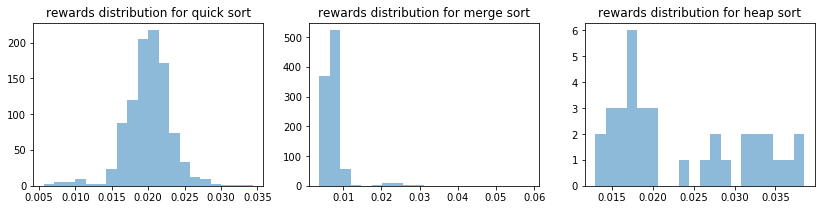

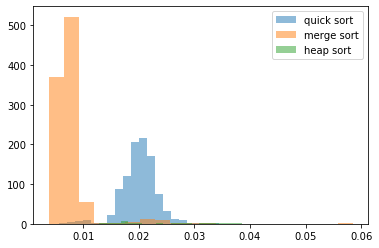

In [50]:
plot_rewards_distribution(arm_rewards_4)
plot_rewards_distribution_together(arm_rewards_4)

Restart at iteration: 503
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.020262452977386998, 'merge_sort': 0.023757537497658632, 'heap_sort': 0.034028599999146536}
Count per chosen algo {'quick_sort': 487, 'merge_sort': 8, 'heap_sort': 9}


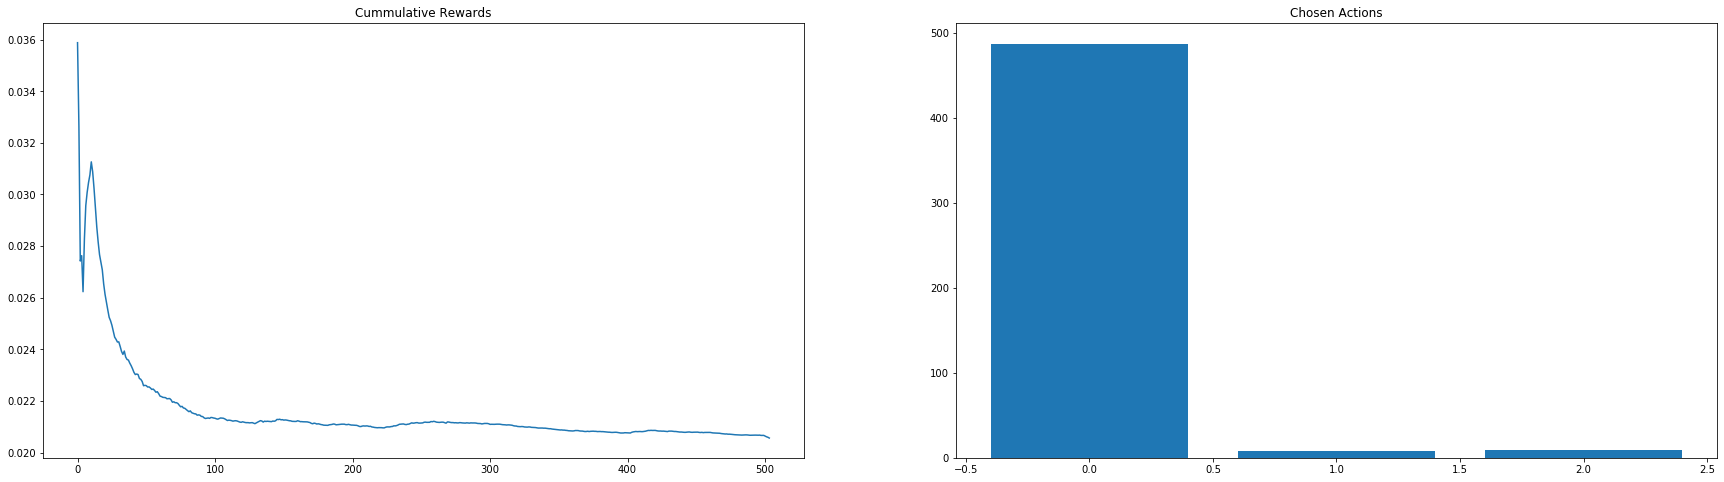

Restart at iteration: 1003
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00861803333342929, 'merge_sort': 0.006955013598245277, 'heap_sort': 0.0170048375002807}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 478, 'heap_sort': 16}


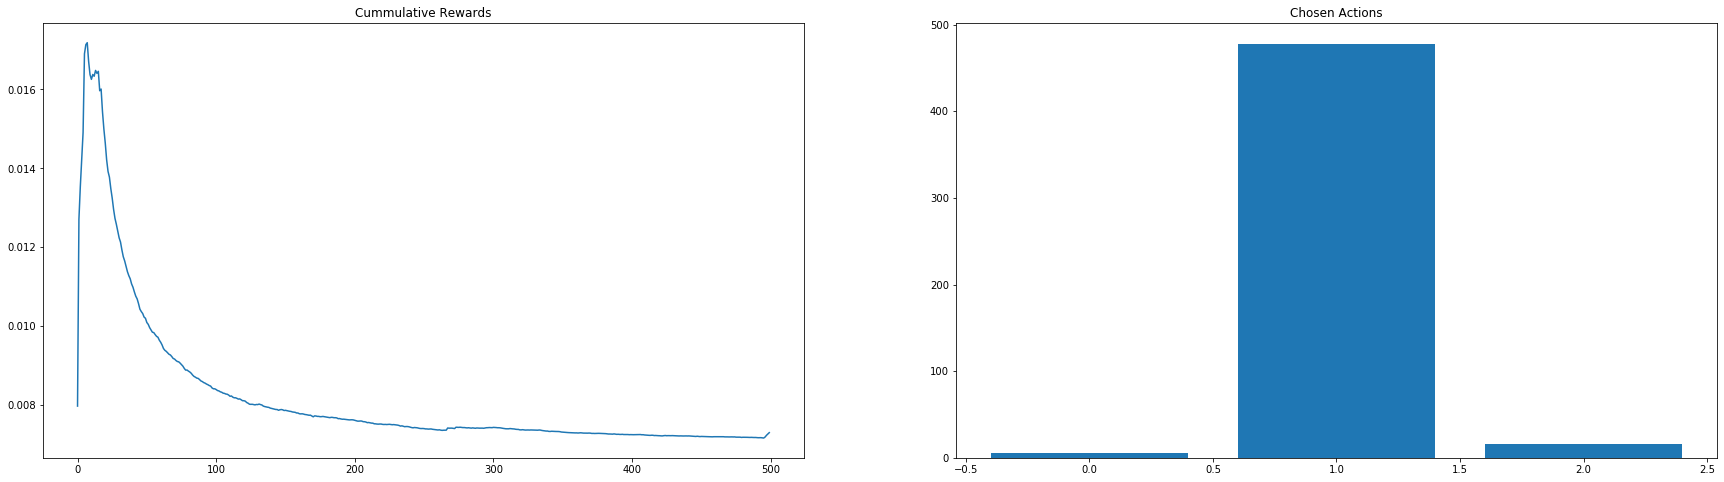

Restart at iteration: 1503
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.020183836325359267, 'merge_sort': 0.025493941175655517, 'heap_sort': 0.030521399996359833}
Count per chosen algo {'quick_sort': 479, 'merge_sort': 17, 'heap_sort': 4}


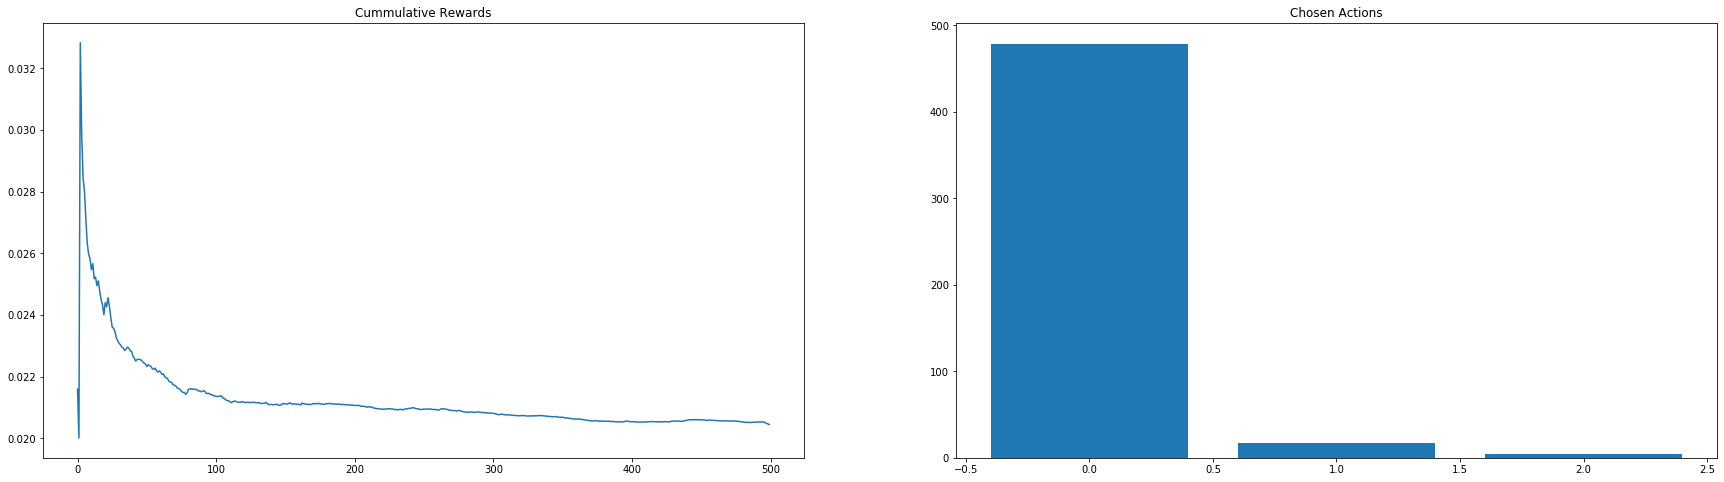

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.011560030769592581, 'merge_sort': 0.00733579916160664, 'heap_sort': 0.020085866662460223}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 477, 'heap_sort': 6}


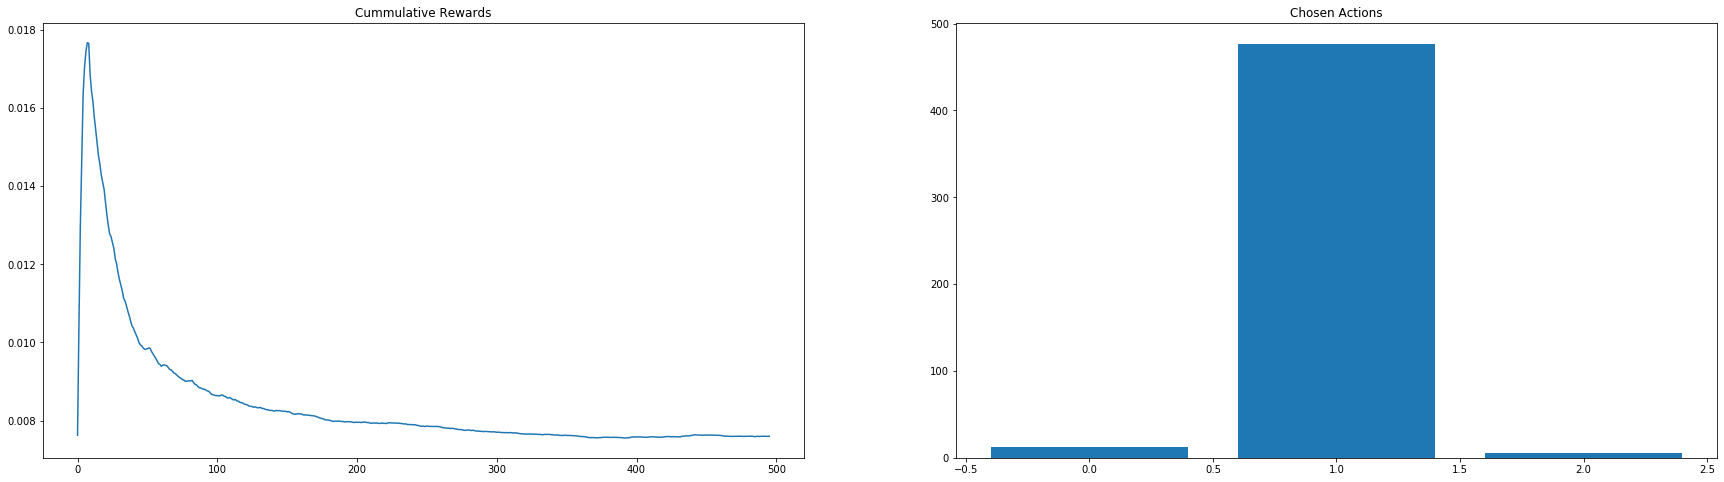

Total reward 28.0059


In [51]:
for elem in list_iteration_results_4:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_4,4))

## Five outliers in a row restart the expriment

In [52]:
list_iteration_results_5, total_reward_5, arm_rewards_5 = ts_quantile(list_distributions, n_samples, num_consec_elem=5)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.01781447394356115
Less than two values for merge_sort
merge_sort Theta 0.041917948987235276
Less than two values for heap_sort
heap_sort Theta 0.05970246055066623


Chosen algorithm is:  quick_sort with reward: 0.02873120000003837
Sample mean is:  0.02873120000003837 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.028327988560477135
Less than two values for merge_sort
merge_sort Theta 0.011069257146844293
Less than two values for heap_sort
heap_sort Theta 0.03908634606853372


Chosen algorithm is:  merge_sort with reward: 0.02488299999095034
Sample mean is:  0.02488299999095034 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.09755066159952806
Less than two values for merge_sort
merge_sort Theta 0.08384611184812316
Less than two values for heap_sort
heap_sort Theta 0.06716808908645965


Chosen algorithm is:  heap_sort with rewa



Iteration: 29
quick_sort Theta 0.027147578844534292
merge_sort Theta 0.027990582114582885
heap_sort Theta 0.0730790556513848


Chosen algorithm is:  quick_sort with reward: 0.02529369998956099
Sample mean is:  0.026276063636363357 Sample variance is: 1.674704622566532e-05


Iteration: 30
quick_sort Theta 0.02513437955467375
merge_sort Theta 0.0288502961652051
heap_sort Theta 0.045789530363719


Chosen algorithm is:  quick_sort with reward: 0.021083800005726516
Sample mean is:  0.026050313043726972 Sample variance is: 1.714010704273611e-05


Iteration: 31
quick_sort Theta 0.02597100981818654
merge_sort Theta 0.031915248155332726
heap_sort Theta 0.05847921664085425


Chosen algorithm is:  quick_sort with reward: 0.022136300001875497
Sample mean is:  0.02588722916698316 Sample variance is: 1.703765198559262e-05


Iteration: 32
quick_sort Theta 0.02528732040682484
merge_sort Theta 0.02051433288559621
heap_sort Theta 0.05402441285400552


Chosen algorithm is:  merge_sort with reward: 0.02


Iteration: 60
quick_sort Theta 0.025543343961329096
merge_sort Theta 0.029985338596469888
heap_sort Theta 0.05322747662739753


Chosen algorithm is:  quick_sort with reward: 0.025056500002392568
Sample mean is:  0.025365436957065907 Sample variance is: 2.140839040908393e-05


Iteration: 61
quick_sort Theta 0.024798847694195516
merge_sort Theta 0.02748117232501858
heap_sort Theta 0.043860947679007986


Chosen algorithm is:  quick_sort with reward: 0.020694599996204488
Sample mean is:  0.025266057447260345 Sample variance is: 2.1407201941388457e-05


Iteration: 62
quick_sort Theta 0.024538380002602157
merge_sort Theta 0.029712172164543405
heap_sort Theta 0.05433789886609867


Chosen algorithm is:  quick_sort with reward: 0.02149880000797566
Sample mean is:  0.025187572917275247 Sample variance is: 2.1250730175617674e-05


Iteration: 63
quick_sort Theta 0.0255085408840122
merge_sort Theta 0.024692394493447588
heap_sort Theta 0.03915455859316218


Chosen algorithm is:  merge_sort with rew



Chosen algorithm is:  quick_sort with reward: 0.022800799997639842
Sample mean is:  0.023520059740721164 Sample variance is: 1.9947661224660773e-05


Iteration: 93
quick_sort Theta 0.022778682540261413
merge_sort Theta 0.029048532333188305
heap_sort Theta 0.03975054699637576


Chosen algorithm is:  quick_sort with reward: 0.02022690000012517
Sample mean is:  0.023477839744046856 Sample variance is: 1.9829176643367515e-05


Iteration: 94
quick_sort Theta 0.02379760479346324
merge_sort Theta 0.0305481967387757
heap_sort Theta 0.03791631108288719


Chosen algorithm is:  quick_sort with reward: 0.020990999997593462
Sample mean is:  0.023446360759914534 Sample variance is: 1.9655466669851746e-05


Iteration: 95
quick_sort Theta 0.023535584161216806
merge_sort Theta 0.024358576142472322
heap_sort Theta -0.007820623694593236


Chosen algorithm is:  heap_sort with reward: 0.03286120000120718
Sample mean is:  0.04049079999967944 Sample variance is: 6.0495882262399296e-05


Iteration: 96
quick



Chosen algorithm is:  quick_sort with reward: 0.024288899992825463
Sample mean is:  0.023775886916163787 Sample variance is: 2.0467256027510857e-05


Iteration: 125
quick_sort Theta 0.024084031496235263
merge_sort Theta 0.029691467882865984
heap_sort Theta 0.03631247627131977


Chosen algorithm is:  quick_sort with reward: 0.01950090000173077
Sample mean is:  0.02373630370399311 Sample variance is: 2.0445395281001614e-05


Iteration: 126
quick_sort Theta 0.023417742298882056
merge_sort Theta 0.02635320344162348
heap_sort Theta 0.03704946245456826


Chosen algorithm is:  quick_sort with reward: 0.021783999996841885
Sample mean is:  0.023718392660808236 Sample variance is: 2.0292469837771758e-05


Iteration: 127
quick_sort Theta 0.02353458983934328
merge_sort Theta 0.0270607120016801
heap_sort Theta 0.04757706853841557


Chosen algorithm is:  quick_sort with reward: 0.024249800000688992
Sample mean is:  0.023723223636625334 Sample variance is: 2.0110536716927204e-05


Iteration: 128
qu


Iteration: 156
quick_sort Theta 0.023521974859634847
merge_sort Theta 0.024548304707683717
heap_sort Theta 0.045732423285435524


Chosen algorithm is:  quick_sort with reward: 0.025744800004758872
Sample mean is:  0.023152676259277208 Sample variance is: 1.8982505018592838e-05


Iteration: 157
quick_sort Theta 0.023340319202305695
merge_sort Theta 0.02735190050638254
heap_sort Theta 0.04315966572789176


Chosen algorithm is:  quick_sort with reward: 0.036680899997008964
Sample mean is:  0.023249306428832436 Sample variance is: 2.0144812860921252e-05


Iteration: 158
quick_sort Theta 0.02312431057734723
merge_sort Theta 0.024380044598609367
heap_sort Theta 0.041063726842358775


Chosen algorithm is:  quick_sort with reward: 0.04811380000319332
Sample mean is:  0.02342565035489173 Sample variance is: 2.435554708384419e-05


Iteration: 159
quick_sort Theta 0.02326677973937205
merge_sort Theta 0.03044763439075659
heap_sort Theta 0.0360964054079147


Chosen algorithm is:  quick_sort with r

Iteration: 186
quick_sort Theta 0.023262258466532515
merge_sort Theta 0.028739909509905834
heap_sort Theta 0.03263487864915187


Chosen algorithm is:  quick_sort with reward: 0.020083299998077564
Sample mean is:  0.023569311309637714 Sample variance is: 2.758322899222135e-05


Iteration: 187
quick_sort Theta 0.02401506673907319
merge_sort Theta 0.025039959124841648
heap_sort Theta 0.03371965858382447


Chosen algorithm is:  quick_sort with reward: 0.021419199998490512
Sample mean is:  0.023556588757500746 Sample variance is: 2.7447207659409782e-05


Iteration: 188
quick_sort Theta 0.023256662945922945
merge_sort Theta 0.02884032689281562
heap_sort Theta 0.04026694859983362


Chosen algorithm is:  quick_sort with reward: 0.02190939999127295
Sample mean is:  0.023546899411817052 Sample variance is: 2.730161979464987e-05


Iteration: 189
quick_sort Theta 0.023669858904591935
merge_sort Theta 0.028715464686057523
heap_sort Theta 0.036593012863098295


Chosen algorithm is:  quick_sort with 


Chosen algorithm is:  quick_sort with reward: 0.022785099994507618
Sample mean is:  0.02399941256257235 Sample variance is: 3.210151271437428e-05


Iteration: 219
quick_sort Theta 0.0238594771835202
merge_sort Theta 0.027479452682705376
heap_sort Theta 0.04027821223358381


Chosen algorithm is:  quick_sort with reward: 0.01672070000495296
Sample mean is:  0.023963018999784255 Sample variance is: 3.220457894187223e-05


Iteration: 220
quick_sort Theta 0.023659601498052532
merge_sort Theta 0.026292662404746227
heap_sort Theta 0.03974909505139571


Chosen algorithm is:  quick_sort with reward: 0.022216700002900325
Sample mean is:  0.0239543308455709 Sample variance is: 3.205945396081877e-05


Iteration: 221
quick_sort Theta 0.023811095168767654
merge_sort Theta 0.026961564823052783
heap_sort Theta 0.03780261370780881


Chosen algorithm is:  quick_sort with reward: 0.02087889998801984
Sample mean is:  0.0239391059403355 Sample variance is: 3.1947335138320725e-05


Iteration: 222
quick_sor


Chosen algorithm is:  quick_sort with reward: 0.023406000007526018
Sample mean is:  0.02415276916282475 Sample variance is: 3.155262653898068e-05


Iteration: 250
quick_sort Theta 0.024329387357981083
merge_sort Theta 0.030532661797695895
heap_sort Theta 0.040923571959585035


Chosen algorithm is:  quick_sort with reward: 0.03093510000326205
Sample mean is:  0.024182516227914386 Sample variance is: 3.161510737517891e-05


Iteration: 251
quick_sort Theta 0.024583760622109766
merge_sort Theta 0.022203271548412364
heap_sort Theta 0.04048111567992694


Chosen algorithm is:  merge_sort with reward: 0.025940499996067956
Sample mean is:  0.026944421050996568 Sample variance is: 4.324009781619029e-05


Iteration: 252
quick_sort Theta 0.024631138920856045
merge_sort Theta 0.025611188281568203
heap_sort Theta 0.03886654761499709


Chosen algorithm is:  quick_sort with reward: 0.026982900002622046
Sample mean is:  0.024194744978022282 Sample variance is: 3.1511145788790617e-05


Iteration: 253
q


Iteration: 280
quick_sort Theta 0.023916830282100267
merge_sort Theta 0.026530087202167138
heap_sort Theta 0.033332532543503435


Chosen algorithm is:  quick_sort with reward: 0.022214600001461804
Sample mean is:  0.023803424609297963 Sample variance is: 3.06531022823362e-05


Iteration: 281
quick_sort Theta 0.023333974847519277
merge_sort Theta 0.02631046071493556
heap_sort Theta 0.03516762684724129


Chosen algorithm is:  quick_sort with reward: 0.02065740000398364
Sample mean is:  0.023791183268421254 Sample variance is: 3.057219121998331e-05


Iteration: 282
quick_sort Theta 0.02413343058650308
merge_sort Theta 0.027278407932460398
heap_sort Theta 0.04023000880845185


Chosen algorithm is:  quick_sort with reward: 0.04233070000191219
Sample mean is:  0.023863041860411528 Sample variance is: 3.1780754266195553e-05


Iteration: 283
quick_sort Theta 0.02382955557608273
merge_sort Theta 0.025617684046596038
heap_sort Theta 0.03148950760486695


Chosen algorithm is:  quick_sort with re



Iteration: 310
quick_sort Theta 0.02428770067558389
merge_sort Theta 0.028450600159622648
heap_sort Theta 0.041726196072269586


Chosen algorithm is:  quick_sort with reward: 0.030618600008892827
Sample mean is:  0.023934558391431836 Sample variance is: 3.4998903136369366e-05


Iteration: 311
quick_sort Theta 0.02451737253193339
merge_sort Theta 0.025117091521494647
heap_sort Theta 0.03244434036346287


Chosen algorithm is:  quick_sort with reward: 0.02528149999852758
Sample mean is:  0.02393925156776318 Sample variance is: 3.4883255147247715e-05


Iteration: 312
quick_sort Theta 0.023914490632730868
merge_sort Theta 0.0295810828233914
heap_sort Theta 0.03634458709308928


Chosen algorithm is:  quick_sort with reward: 0.022992499987594783
Sample mean is:  0.023935964235887595 Sample variance is: 3.476523421363888e-05


Iteration: 313
quick_sort Theta 0.023667501638286625
merge_sort Theta 0.02922969737889451
heap_sort Theta 0.03602183327868432


Chosen algorithm is:  quick_sort with r



Iteration: 340
quick_sort Theta 0.024099058706843163
merge_sort Theta 0.028037728246835706
heap_sort Theta 0.03233500552825384


Chosen algorithm is:  quick_sort with reward: 0.031349900003988296
Sample mean is:  0.02405289715161301 Sample variance is: 3.385813388404002e-05


Iteration: 341
quick_sort Theta 0.023833326143274495
merge_sort Theta 0.026275753647047567
heap_sort Theta 0.03316042868502101


Chosen algorithm is:  quick_sort with reward: 0.029523999997763894
Sample mean is:  0.024070156151127682 Sample variance is: 3.3845453779017155e-05


Iteration: 342
quick_sort Theta 0.024623859245916715
merge_sort Theta 0.026312774809687096
heap_sort Theta 0.04442244217476513


Chosen algorithm is:  quick_sort with reward: 0.028981399998883717
Sample mean is:  0.024085600314170938 Sample variance is: 3.381463306298689e-05


Iteration: 343
quick_sort Theta 0.023854514006907118
merge_sort Theta 0.02265783359272871
heap_sort Theta 0.04264313318286649


Chosen algorithm is:  merge_sort wit


Iteration: 370
quick_sort Theta 0.02377804275620166
merge_sort Theta 0.02847750285693907
heap_sort Theta 0.03895265889384649


Chosen algorithm is:  quick_sort with reward: 0.02214570000069216
Sample mean is:  0.02384409999974288 Sample variance is: 3.222988051062144e-05


Iteration: 371
quick_sort Theta 0.023565517105955523
merge_sort Theta 0.02954046152341096
heap_sort Theta 0.0232912385484535


Chosen algorithm is:  heap_sort with reward: 0.029548499995144084
Sample mean is:  0.03780705714182529 Sample variance is: 6.190325397551847e-05


Iteration: 372
quick_sort Theta 0.023558200388292327
merge_sort Theta 0.028974610377820786
heap_sort Theta 0.03735074711559661


Chosen algorithm is:  quick_sort with reward: 0.026716799999121577
Sample mean is:  0.023852402600897153 Sample variance is: 3.2160512516093927e-05


Iteration: 373
quick_sort Theta 0.023736517571846596
merge_sort Theta 0.02411575234110446
heap_sort Theta 0.03882408547359964


Chosen algorithm is:  quick_sort with reward


Chosen algorithm is:  quick_sort with reward: 0.018244799997773953
Sample mean is:  0.023633027005144445 Sample variance is: 3.096812319317723e-05


Iteration: 401
quick_sort Theta 0.02371976886339519
merge_sort Theta 0.027599378121171657
heap_sort Theta 0.04030138530486497


Chosen algorithm is:  quick_sort with reward: 0.02105670000310056
Sample mean is:  0.02362615679980566 Sample variance is: 3.090319422713125e-05


Iteration: 402
quick_sort Theta 0.02363301012096863
merge_sort Theta 0.028877883566444187
heap_sort Theta 0.034434677708943644


Chosen algorithm is:  quick_sort with reward: 0.02116230000683572
Sample mean is:  0.02361960398918606 Sample variance is: 3.083710712841363e-05


Iteration: 403
quick_sort Theta 0.023783337578295708
merge_sort Theta 0.028525257980881215
heap_sort Theta 0.03427994720899905


Chosen algorithm is:  quick_sort with reward: 0.018710999996983446
Sample mean is:  0.02360658381944547 Sample variance is: 3.081905242063296e-05


Iteration: 404
quick_s



Iteration: 431
quick_sort Theta 0.023637363198097817
merge_sort Theta 0.0274226019409808
heap_sort Theta 0.03860611909412207


Chosen algorithm is:  quick_sort with reward: 0.027112799987662584
Sample mean is:  0.02352460024664236 Sample variance is: 3.025381427809659e-05


Iteration: 432
quick_sort Theta 0.02353600614785594
merge_sort Theta 0.027323632868124084
heap_sort Theta 0.04640944788727639


Chosen algorithm is:  quick_sort with reward: 0.020621900010155514
Sample mean is:  0.023517450738670717 Sample variance is: 3.0199999257176204e-05


Iteration: 433
quick_sort Theta 0.02351439292755998
merge_sort Theta 0.027818768516746233
heap_sort Theta 0.04117951244104308


Chosen algorithm is:  quick_sort with reward: 0.019662299993797205
Sample mean is:  0.023507978623818447 Sample variance is: 3.016222449446833e-05


Iteration: 434
quick_sort Theta 0.02370493775128515
merge_sort Theta 0.025523307003525484
heap_sort Theta 0.03701436796288232


Chosen algorithm is:  quick_sort with re


Chosen algorithm is:  quick_sort with reward: 0.02154770000197459
Sample mean is:  0.023288507568653954 Sample variance is: 2.937378537527501e-05


Iteration: 463
quick_sort Theta 0.023314678369112593
merge_sort Theta 0.025678017660138268
heap_sort Theta 0.039142915926611364


Chosen algorithm is:  quick_sort with reward: 0.018519599994760938
Sample mean is:  0.023277594736677083 Sample variance is: 2.9358491672268128e-05


Iteration: 464
quick_sort Theta 0.022859306546546214
merge_sort Theta 0.027193088464269738
heap_sort Theta 0.0364425200558839


Chosen algorithm is:  quick_sort with reward: 0.02100750000681728
Sample mean is:  0.023272411871997037 Sample variance is: 2.9303201884177883e-05


Iteration: 465
quick_sort Theta 0.023229933581472965
merge_sort Theta 0.02848511512917605
heap_sort Theta 0.03750334133028383


Chosen algorithm is:  quick_sort with reward: 0.019964000006439164
Sample mean is:  0.023264875626289615 Sample variance is: 2.9261328203501953e-05


Iteration: 466
q


Chosen algorithm is:  quick_sort with reward: 0.022035300004063174
Sample mean is:  0.02310288950737453 Sample variance is: 2.8205082952118314e-05


Iteration: 495
quick_sort Theta 0.023149426755230358
merge_sort Theta 0.0270678874230686
heap_sort Theta 0.039110219268821536


Chosen algorithm is:  quick_sort with reward: 0.01734299999952782
Sample mean is:  0.023090582051161185 Sample variance is: 2.8215553795286206e-05


Iteration: 496
quick_sort Theta 0.02325692167905211
merge_sort Theta 0.02629442537531443
heap_sort Theta 0.0384419855996874


Chosen algorithm is:  quick_sort with reward: 0.02067660000466276
Sample mean is:  0.02308543496790639 Sample variance is: 2.8167791173876742e-05


Iteration: 497
quick_sort Theta 0.023034619408689196
merge_sort Theta 0.025001638560663647
heap_sort Theta 0.03660279571315919


Chosen algorithm is:  quick_sort with reward: 0.02020319999428466
Sample mean is:  0.023079302553068896 Sample variance is: 2.8125497157299665e-05


Iteration: 498
quick_


Iteration: 522
quick_sort Theta 0.009162185672953644
merge_sort Theta 0.012148561534351308
heap_sort Theta 0.01625076481821844


Chosen algorithm is:  quick_sort with reward: 0.009668800004874356
Sample mean is:  0.008854724999764585 Sample variance is: 1.0059818467380327e-06


Iteration: 523
quick_sort Theta 0.008271645436970813
merge_sort Theta 0.012663761662727292
heap_sort Theta 0.015932804155472664


Chosen algorithm is:  quick_sort with reward: 0.007233099997392856
Sample mean is:  0.008674544443945505 Sample variance is: 1.1539263475515464e-06


Iteration: 524
quick_sort Theta 0.008613889028161957
merge_sort Theta 0.010450416475722292
heap_sort Theta 0.016323803242446415


Chosen algorithm is:  quick_sort with reward: 0.008362100008525886
Sample mean is:  0.008643300000403541 Sample variance is: 1.0473196500666133e-06


Iteration: 525
quick_sort Theta 0.008362698937696143
merge_sort Theta 0.011495176618483016
heap_sort Theta 0.01623204579443434


Chosen algorithm is:  quick_sor


Iteration: 555
quick_sort Theta 0.008588116586524497
merge_sort Theta 0.00802871223290672
heap_sort Theta 0.0163948630108358


Chosen algorithm is:  merge_sort with reward: 0.008210600004531443
Sample mean is:  0.008261099999468901 Sample variance is: 8.03678247231911e-06


Iteration: 556
quick_sort Theta 0.008229451890037933
merge_sort Theta 0.009042608654381157
heap_sort Theta 0.01572204696249906


Chosen algorithm is:  quick_sort with reward: 0.010069800002384
Sample mean is:  0.008674271999625489 Sample variance is: 2.103716419719531e-06


Iteration: 557
quick_sort Theta 0.008828786667734255
merge_sort Theta 0.008860803523677538
heap_sort Theta 0.016995748199191852


Chosen algorithm is:  quick_sort with reward: 0.010035300001618452
Sample mean is:  0.008726619230471373 Sample variance is: 2.091310064161123e-06


Iteration: 558
quick_sort Theta 0.008957828552814701
merge_sort Theta 0.008012569143054768
heap_sort Theta 0.016029449539222747


Chosen algorithm is:  merge_sort with re


Iteration: 588
quick_sort Theta 0.00873522127632431
merge_sort Theta 0.007327637293479764
heap_sort Theta 0.01600246311272523


Chosen algorithm is:  merge_sort with reward: 0.0087311000097543
Sample mean is:  0.00781280000024708 Sample variance is: 4.520194751652534e-06


Iteration: 589
quick_sort Theta 0.008620612120463002
merge_sort Theta 0.008144747824942752
heap_sort Theta 0.015548135761085276


Chosen algorithm is:  merge_sort with reward: 0.007412999999360181
Sample mean is:  0.007804960784543415 Sample variance is: 4.434636147154716e-06


Iteration: 590
quick_sort Theta 0.00914891027781002
merge_sort Theta 0.007670628689015163
heap_sort Theta 0.016120608339650882


Chosen algorithm is:  merge_sort with reward: 0.006872999991173856
Sample mean is:  0.0077870384615940005 Sample variance is: 4.365736375441415e-06


Iteration: 591
quick_sort Theta 0.009145017310194884
merge_sort Theta 0.007836618349976922
heap_sort Theta 0.016005992147144044


Chosen algorithm is:  merge_sort with


Iteration: 618
quick_sort Theta 0.008415207757214101
merge_sort Theta 0.007927296096185296
heap_sort Theta 0.016477378013682265


Chosen algorithm is:  merge_sort with reward: 0.0110877000115579
Sample mean is:  0.007746137499452743 Sample variance is: 4.065729524272132e-06


Iteration: 619
quick_sort Theta 0.008842739344591193
merge_sort Theta 0.0076535635021735375
heap_sort Theta 0.01683245443797866


Chosen algorithm is:  merge_sort with reward: 0.006002099995384924
Sample mean is:  0.007724606172242029 Sample variance is: 4.052623176730838e-06


Iteration: 620
quick_sort Theta 0.008883775448803628
merge_sort Theta 0.007971845765341512
heap_sort Theta 0.01678410755260506


Chosen algorithm is:  merge_sort with reward: 0.007421799993608147
Sample mean is:  0.007720913413966007 Sample variance is: 4.004305496426763e-06


Iteration: 621
quick_sort Theta 0.008790028654171169
merge_sort Theta 0.007865423941152645
heap_sort Theta 0.015908112081484595


Chosen algorithm is:  merge_sort wi


Iteration: 651
quick_sort Theta 0.008625631024685025
merge_sort Theta 0.007367083625411462
heap_sort Theta 0.015913797238738345


Chosen algorithm is:  merge_sort with reward: 0.00852810000651516
Sample mean is:  0.007480245131991013 Sample variance is: 3.5279669208276535e-06


Iteration: 652
quick_sort Theta 0.00874565051075606
merge_sort Theta 0.0074076524753807415
heap_sort Theta 0.016607668666133883


Chosen algorithm is:  merge_sort with reward: 0.0070389999891631305
Sample mean is:  0.007476374560562698 Sample variance is: 3.49871273209431e-06


Iteration: 653
quick_sort Theta 0.0087538614812687
merge_sort Theta 0.007824287501363256
heap_sort Theta 0.01571591212877235


Chosen algorithm is:  merge_sort with reward: 0.006801700001233257
Sample mean is:  0.007470507825264181 Sample variance is: 3.4722128615887433e-06


Iteration: 654
quick_sort Theta 0.008707571477741026
merge_sort Theta 0.00749277382279912
heap_sort Theta 0.016161039992465716


Chosen algorithm is:  merge_sort wi



Iteration: 681
quick_sort Theta 0.009124132731753552
merge_sort Theta 0.007497341309992524
heap_sort Theta 0.016110067095973922


Chosen algorithm is:  merge_sort with reward: 0.008773800000199117
Sample mean is:  0.0076753706286638535 Sample variance is: 7.440646456290513e-06


Iteration: 682
quick_sort Theta 0.008666472043533833
merge_sort Theta 0.008076235416121347
heap_sort Theta 0.01642173994000763


Chosen algorithm is:  merge_sort with reward: 0.006649000002653338
Sample mean is:  0.007668243054872114 Sample variance is: 7.396240030410461e-06


Iteration: 683
quick_sort Theta 0.008877668655404581
merge_sort Theta 0.007154723220959122
heap_sort Theta 0.016628762822960365


Chosen algorithm is:  merge_sort with reward: 0.0065260999981546775
Sample mean is:  0.0076603662062050965 Sample variance is: 7.3541659217455205e-06


Iteration: 684
quick_sort Theta 0.008370066991983555
merge_sort Theta 0.007949664746069302
heap_sort Theta 0.016181446245992884


Chosen algorithm is:  merge_


Iteration: 711
quick_sort Theta 0.009091955857310673
merge_sort Theta 0.007564182951974405
heap_sort Theta 0.016453362515684713


Chosen algorithm is:  merge_sort with reward: 0.008348100003786385
Sample mean is:  0.007602997109390839 Sample variance is: 6.483245253367888e-06


Iteration: 712
quick_sort Theta 0.00848557927853981
merge_sort Theta 0.0076151518035959525
heap_sort Theta 0.014808786709424385


Chosen algorithm is:  merge_sort with reward: 0.006723999991663732
Sample mean is:  0.007597945401817694 Sample variance is: 6.450400139823109e-06


Iteration: 713
quick_sort Theta 0.00908571974101981
merge_sort Theta 0.00736471518523846
heap_sort Theta 0.01609143305476019


Chosen algorithm is:  merge_sort with reward: 0.006532300001708791
Sample mean is:  0.007591855999531358 Sample variance is: 6.4199927731683345e-06


Iteration: 714
quick_sort Theta 0.008681733577600777
merge_sort Theta 0.007368712000612828
heap_sort Theta 0.015999447865816346


Chosen algorithm is:  merge_sort w



Chosen algorithm is:  merge_sort with reward: 0.007808399997884408
Sample mean is:  0.007561573039114877 Sample variance is: 5.650925119835488e-06


Iteration: 743
quick_sort Theta 0.008489097934960577
merge_sort Theta 0.007672619544716383
heap_sort Theta 0.01567111354958185


Chosen algorithm is:  merge_sort with reward: 0.006791300009354018
Sample mean is:  0.007557815609701409 Sample variance is: 5.626239759708672e-06


Iteration: 744
quick_sort Theta 0.008318769718266054
merge_sort Theta 0.007565063700932341
heap_sort Theta 0.01621026013849281


Chosen algorithm is:  merge_sort with reward: 0.008119699996314012
Sample mean is:  0.007560543203811179 Sample variance is: 5.600453068988609e-06


Iteration: 745
quick_sort Theta 0.009176943436470365
merge_sort Theta 0.007596261738115681
heap_sort Theta 0.01717529705593841


Chosen algorithm is:  merge_sort with reward: 0.006608299998333678
Sample mean is:  0.007555942995089065 Sample variance is: 5.577757095732039e-06


Iteration: 746


Chosen algorithm is:  merge_sort with reward: 0.008179000011296012
Sample mean is:  0.007500133898232026 Sample variance is: 5.004709409570423e-06


Iteration: 775
quick_sort Theta 0.009161282629964724
merge_sort Theta 0.007522217079307631
heap_sort Theta 0.016109999541366864


Chosen algorithm is:  merge_sort with reward: 0.006241700000828132
Sample mean is:  0.007494824050563655 Sample variance is: 4.9902463900441304e-06


Iteration: 776
quick_sort Theta 0.008506147384084416
merge_sort Theta 0.007588919371687295
heap_sort Theta 0.01602739287149483


Chosen algorithm is:  merge_sort with reward: 0.006593900005100295
Sample mean is:  0.007491038655414649 Sample variance is: 4.9726749925321075e-06


Iteration: 777
quick_sort Theta 0.008601097845647394
merge_sort Theta 0.007292534840976988
heap_sort Theta 0.016137785555803648


Chosen algorithm is:  merge_sort with reward: 0.0073745999980019405
Sample mean is:  0.00749055146437945 Sample variance is: 4.9519253115301765e-06


Iteration: 7


Iteration: 804
quick_sort Theta 0.008937931972409208
merge_sort Theta 0.007478655289640378
heap_sort Theta 0.017013659360963076


Chosen algorithm is:  merge_sort with reward: 0.00776209999457933
Sample mean is:  0.007468913157772066 Sample variance is: 4.525246795256209e-06


Iteration: 805
quick_sort Theta 0.008729041253636587
merge_sort Theta 0.007269867240516345
heap_sort Theta 0.01615010874813868


Chosen algorithm is:  merge_sort with reward: 0.005513500000233762
Sample mean is:  0.007461589512987279 Sample variance is: 4.522565420986711e-06


Iteration: 806
quick_sort Theta 0.00841319797061315
merge_sort Theta 0.007626557580853808
heap_sort Theta 0.0169287237690363


Chosen algorithm is:  merge_sort with reward: 0.004960899997968227
Sample mean is:  0.0074522585819610885 Sample variance is: 4.528936871987298e-06


Iteration: 807
quick_sort Theta 0.009079605850929708
merge_sort Theta 0.007478611612417436
heap_sort Theta 0.01628201220218564


Chosen algorithm is:  merge_sort with


Iteration: 838
quick_sort Theta 0.008494148886533378
merge_sort Theta 0.007461934311491398
heap_sort Theta 0.016292833245534377


Chosen algorithm is:  merge_sort with reward: 0.006512100007967092
Sample mean is:  0.0074019989998002226 Sample variance is: 4.228242147003717e-06


Iteration: 839
quick_sort Theta 0.00839822055028863
merge_sort Theta 0.007471232914863822
heap_sort Theta 0.016222687405013286


Chosen algorithm is:  merge_sort with reward: 0.004170400003204122
Sample mean is:  0.007391262790509206 Sample variance is: 4.248774687882869e-06


Iteration: 840
quick_sort Theta 0.00891887655117621
merge_sort Theta 0.007407579878872762
heap_sort Theta 0.015876647830887883


Chosen algorithm is:  merge_sort with reward: 0.008726000000024214
Sample mean is:  0.007395682450143362 Sample variance is: 4.240585448301459e-06


Iteration: 841
quick_sort Theta 0.008403531132060606
merge_sort Theta 0.007359823775957846
heap_sort Theta 0.016016693058824378


Chosen algorithm is:  merge_sort 


Iteration: 868
quick_sort Theta 0.008693830015090881
merge_sort Theta 0.0072785216127357385
heap_sort Theta 0.016207660174089165


Chosen algorithm is:  merge_sort with reward: 0.007085399993229657
Sample mean is:  0.00736942393916913 Sample variance is: 4.190275817613569e-06


Iteration: 869
quick_sort Theta 0.008920866282099786
merge_sort Theta 0.007459763313415465
heap_sort Theta 0.01665902303674818


Chosen algorithm is:  merge_sort with reward: 0.006335799989756197
Sample mean is:  0.007366301208204137 Sample variance is: 4.180834352120136e-06


Iteration: 870
quick_sort Theta 0.008615706796424712
merge_sort Theta 0.007487078927324888
heap_sort Theta 0.01664619888270054


Chosen algorithm is:  merge_sort with reward: 0.006372300005750731
Sample mean is:  0.0073633072286786744 Sample variance is: 4.171208532900588e-06


Iteration: 871
quick_sort Theta 0.008579818890610571
merge_sort Theta 0.0074698551292525835
heap_sort Theta 0.016333450715382506


Chosen algorithm is:  merge_sort


Iteration: 898
quick_sort Theta 0.008624750588269394
merge_sort Theta 0.007264790372863256
heap_sort Theta 0.016135400701539515


Chosen algorithm is:  merge_sort with reward: 0.006702700004098006
Sample mean is:  0.007291605832950962 Sample variance is: 4.018160074349202e-06


Iteration: 899
quick_sort Theta 0.009234501790602558
merge_sort Theta 0.007370251034262741
heap_sort Theta 0.016025320054898522


Chosen algorithm is:  merge_sort with reward: 0.005763699999079108
Sample mean is:  0.007287373406818353 Sample variance is: 4.0134782721726115e-06


Iteration: 900
quick_sort Theta 0.008874572045414954
merge_sort Theta 0.007196893878387227
heap_sort Theta 0.01671291058798908


Chosen algorithm is:  merge_sort with reward: 0.006768199993530288
Sample mean is:  0.007285939226118663 Sample variance is: 4.0031338472345e-06


Iteration: 901
quick_sort Theta 0.008526665079613081
merge_sort Theta 0.007404478443725729
heap_sort Theta 0.01571152723010936


Chosen algorithm is:  merge_sort wi



Chosen algorithm is:  merge_sort with reward: 0.011955299996770918
Sample mean is:  0.007261948071729636 Sample variance is: 3.989094576590504e-06


Iteration: 928
quick_sort Theta 0.008960159602619325
merge_sort Theta 0.007304674264381537
heap_sort Theta 0.015818785124074124


Chosen algorithm is:  merge_sort with reward: 0.008185300001059659
Sample mean is:  0.0072643156407792 Sample variance is: 3.9810466230247544e-06


Iteration: 929
quick_sort Theta 0.009199294026400063
merge_sort Theta 0.007280262403455515
heap_sort Theta 0.016311047850815264


Chosen algorithm is:  merge_sort with reward: 0.008705000000190921
Sample mean is:  0.007268000255509153 Sample variance is: 3.976159708532727e-06


Iteration: 930
quick_sort Theta 0.009131048373851758
merge_sort Theta 0.007406094902895139
heap_sort Theta 0.016432764258823864


Chosen algorithm is:  merge_sort with reward: 0.011889900008100085
Sample mean is:  0.007279790816102498 Sample variance is: 4.020372215740324e-06


Iteration: 93


Iteration: 958
quick_sort Theta 0.008946651395606398
merge_sort Theta 0.007214500009694287
heap_sort Theta 0.016491142171605126


Chosen algorithm is:  merge_sort with reward: 0.006495100009487942
Sample mean is:  0.007291361428360688 Sample variance is: 3.922408699832815e-06


Iteration: 959
quick_sort Theta 0.008221517080358206
merge_sort Theta 0.007129007084178053
heap_sort Theta 0.016064776342984494


Chosen algorithm is:  merge_sort with reward: 0.005997500004014
Sample mean is:  0.007288288123314734 Sample variance is: 3.917058800200358e-06


Iteration: 960
quick_sort Theta 0.00905718535747754
merge_sort Theta 0.0073676442028243255
heap_sort Theta 0.01650498476097027


Chosen algorithm is:  merge_sort with reward: 0.007451400000718422
Sample mean is:  0.007288674644351235 Sample variance is: 3.907839567115471e-06


Iteration: 961
quick_sort Theta 0.008822340334897608
merge_sort Theta 0.007234855944120735
heap_sort Theta 0.016117838466076933


Chosen algorithm is:  merge_sort wit

heap_sort Theta 0.016816830981689623


Chosen algorithm is:  merge_sort with reward: 0.008639499996206723
Sample mean is:  0.007341024168270657 Sample variance is: 4.0429085482046965e-06


Iteration: 990
quick_sort Theta 0.00924385852942414
merge_sort Theta 0.00721594729171941
heap_sort Theta 0.01555138358346991


Chosen algorithm is:  merge_sort with reward: 0.009310899986303411
Sample mean is:  0.007345382300611437 Sample variance is: 4.042530046458581e-06


Iteration: 991
quick_sort Theta 0.008979932752571725
merge_sort Theta 0.007422850802633624
heap_sort Theta 0.016395247867399942


Chosen algorithm is:  merge_sort with reward: 0.006492100001196377
Sample mean is:  0.007343498675226415 Sample variance is: 4.035209855226432e-06


Iteration: 992
quick_sort Theta 0.008731099463976292
merge_sort Theta 0.007407883789481681
heap_sort Theta 0.016426609528263473


Chosen algorithm is:  merge_sort with reward: 0.012143400002969429
Sample mean is:  0.007354071145111311 Sample variance is: 4


Iteration: 1017
Less than two values for quick_sort
quick_sort Theta 0.04572073522329994
merge_sort Theta 0.02824061191797036
heap_sort Theta 0.033650102942395906


Chosen algorithm is:  merge_sort with reward: 0.02562309999484569
Sample mean is:  0.027062344444049004 Sample variance is: 1.8350227801767727e-05


Iteration: 1018
Less than two values for quick_sort
quick_sort Theta 0.07107464540000101
merge_sort Theta 0.028345507362463374
heap_sort Theta 0.029155713974744743


Chosen algorithm is:  merge_sort with reward: 0.027209800013224594
Sample mean is:  0.027077090000966565 Sample variance is: 1.6517161904630234e-05


Iteration: 1019
Less than two values for quick_sort
quick_sort Theta 0.06289862038712112
merge_sort Theta 0.024781780400019257
heap_sort Theta 0.03453144919341514


Chosen algorithm is:  merge_sort with reward: 0.024817900004563853
Sample mean is:  0.02687170909220268 Sample variance is: 1.5437414908328812e-05


Iteration: 1020
Less than two values for quick_sort
qui


Iteration: 1048
quick_sort Theta 0.019917740282269312
merge_sort Theta 0.026649219093113647
heap_sort Theta 0.03629973092909774


Chosen algorithm is:  quick_sort with reward: 0.01896110000961926
Sample mean is:  0.019996876667816348 Sample variance is: 6.027389303844965e-06


Iteration: 1049
quick_sort Theta 0.01924331644069216
merge_sort Theta 0.03128258469550549
heap_sort Theta 0.04160018564176288


Chosen algorithm is:  quick_sort with reward: 0.01805870000680443
Sample mean is:  0.01993435484004177 Sample variance is: 5.950226759265929e-06


Iteration: 1050
quick_sort Theta 0.019177184383664704
merge_sort Theta 0.027272354962207014
heap_sort Theta 0.025342991353912776


Chosen algorithm is:  quick_sort with reward: 0.02047290001064539
Sample mean is:  0.019951184376623132 Sample variance is: 5.773062405386714e-06


Iteration: 1051
quick_sort Theta 0.019233677488912016
merge_sort Theta 0.027989899509163734
heap_sort Theta 0.04844678706312071


Chosen algorithm is:  quick_sort with


Iteration: 1082
quick_sort Theta 0.019047798198409654
merge_sort Theta 0.026494375661874552
heap_sort Theta 0.02499211191849154


Chosen algorithm is:  quick_sort with reward: 0.020388100005220622
Sample mean is:  0.019581298413363077 Sample variance is: 4.837504767703899e-06


Iteration: 1083
quick_sort Theta 0.019586030367289575
merge_sort Theta 0.02758749657522962
heap_sort Theta 0.030308280804862787


Chosen algorithm is:  quick_sort with reward: 0.017116699993493967
Sample mean is:  0.019542789063052624 Sample variance is: 4.855345869572527e-06


Iteration: 1084
quick_sort Theta 0.019454865277817757
merge_sort Theta 0.027815593133731706
heap_sort Theta 0.035135907825707795


Chosen algorithm is:  quick_sort with reward: 0.01587410000502132
Sample mean is:  0.019486347692929066 Sample variance is: 4.984528449541042e-06


Iteration: 1085
quick_sort Theta 0.01940511595060911
merge_sort Theta 0.02613367796369127
heap_sort Theta 0.03777945991312586


Chosen algorithm is:  quick_sort w


Iteration: 1114
quick_sort Theta 0.020016416875329908
merge_sort Theta 0.02764307821741558
heap_sort Theta 0.03761506862645781


Chosen algorithm is:  quick_sort with reward: 0.036152800006675534
Sample mean is:  0.020558889474456297 Sample variance is: 1.1349288509411625e-05


Iteration: 1115
quick_sort Theta 0.02084392953598941
merge_sort Theta 0.027073927791902205
heap_sort Theta 0.03846766983441703


Chosen algorithm is:  quick_sort with reward: 0.024244200001703575
Sample mean is:  0.020597278125781788 Sample variance is: 1.1371067166411325e-05


Iteration: 1116
quick_sort Theta 0.021059290110207594
merge_sort Theta 0.02538559748959194
heap_sort Theta 0.032024907976998356


Chosen algorithm is:  quick_sort with reward: 0.02702809999755118
Sample mean is:  0.020663575258480442 Sample variance is: 1.1675789411040421e-05


Iteration: 1117
quick_sort Theta 0.020378242728221096
merge_sort Theta 0.02688767203969473
heap_sort Theta 0.028360699580092574


Chosen algorithm is:  quick_sort


Iteration: 1145
quick_sort Theta 0.02092643941961295
merge_sort Theta 0.027427309169108655
heap_sort Theta 0.03805349721697807


Chosen algorithm is:  quick_sort with reward: 0.019151899992721155
Sample mean is:  0.02088090400013607 Sample variance is: 1.2159892543680811e-05


Iteration: 1146
quick_sort Theta 0.02112060886347448
merge_sort Theta 0.025726640047036942
heap_sort Theta 0.03799981666868654


Chosen algorithm is:  quick_sort with reward: 0.021242899994831532
Sample mean is:  0.020883776984220954 Sample variance is: 1.2064417214694804e-05


Iteration: 1147
quick_sort Theta 0.02071098033027581
merge_sort Theta 0.02554206486671435
heap_sort Theta 0.03787495505451806


Chosen algorithm is:  quick_sort with reward: 0.021976999996695668
Sample mean is:  0.02089238503943729 Sample variance is: 1.197875822899602e-05


Iteration: 1148
quick_sort Theta 0.02105189600578852
merge_sort Theta 0.028485165394725204
heap_sort Theta 0.0374912000995554


Chosen algorithm is:  quick_sort with 


Iteration: 1176
quick_sort Theta 0.021188237027282012
merge_sort Theta 0.027253803588787078
heap_sort Theta 0.03711675034510602


Chosen algorithm is:  quick_sort with reward: 0.020412300000316463
Sample mean is:  0.021163440384369982 Sample variance is: 1.3102918343808117e-05


Iteration: 1177
quick_sort Theta 0.021413267837240783
merge_sort Theta 0.028496116940371317
heap_sort Theta 0.034884464386506726


Chosen algorithm is:  quick_sort with reward: 0.021011000004364178
Sample mean is:  0.02116246942653555 Sample variance is: 1.3019607335607272e-05


Iteration: 1178
quick_sort Theta 0.021476965537777306
merge_sort Theta 0.02690086392593386
heap_sort Theta 0.03555104548612043


Chosen algorithm is:  quick_sort with reward: 0.020534600000246428
Sample mean is:  0.02115849556940714 Sample variance is: 1.2939684029388701e-05


Iteration: 1179
quick_sort Theta 0.020929723433029842
merge_sort Theta 0.02793276327956227
heap_sort Theta 0.03856993866232396


Chosen algorithm is:  quick_sort

Chosen algorithm is:  quick_sort with reward: 0.027904999995371327
Sample mean is:  0.021519884864510213 Sample variance is: 1.5548788779770735e-05


Iteration: 1206
quick_sort Theta 0.0214269925782119
merge_sort Theta 0.028010813846987247
heap_sort Theta 0.03670912825114152


Chosen algorithm is:  quick_sort with reward: 0.023093399999197572
Sample mean is:  0.021528344623298855 Sample variance is: 1.5478433132140786e-05


Iteration: 1207
quick_sort Theta 0.02173873211175581
merge_sort Theta 0.026861566266353616
heap_sort Theta 0.04078982521261664


Chosen algorithm is:  quick_sort with reward: 0.026102000003447756
Sample mean is:  0.02155280267346008 Sample variance is: 1.550692525894034e-05


Iteration: 1208
quick_sort Theta 0.021563794395408016
merge_sort Theta 0.02766535803031837
heap_sort Theta 0.035001361814849336


Chosen algorithm is:  quick_sort with reward: 0.024410800004261546
Sample mean is:  0.02156800478692179 Sample variance is: 1.5467658109388385e-05


Iteration: 1209


heap_sort Theta 0.03325214094716282


Chosen algorithm is:  quick_sort with reward: 0.027621099987300113
Sample mean is:  0.021567017511246848 Sample variance is: 1.5037010651142784e-05


Iteration: 1238
quick_sort Theta 0.021098978877562933
merge_sort Theta 0.02878336270402004
heap_sort Theta 0.028064575296782506


Chosen algorithm is:  quick_sort with reward: 0.027283500006888062
Sample mean is:  0.021593239908015843 Sample variance is: 1.5117245796095565e-05


Iteration: 1239
quick_sort Theta 0.021254843649064138
merge_sort Theta 0.028148943657119473
heap_sort Theta 0.03634217716125533


Chosen algorithm is:  quick_sort with reward: 0.017951000001630746
Sample mean is:  0.021576608675566596 Sample variance is: 1.5108515617104924e-05


Iteration: 1240
quick_sort Theta 0.021552287675879533
merge_sort Theta 0.027718470462972437
heap_sort Theta 0.036512730858971026


Chosen algorithm is:  quick_sort with reward: 0.022610800006077625
Sample mean is:  0.021581309545250737 Sample variance 


Iteration: 1268
quick_sort Theta 0.021583349021879195
merge_sort Theta 0.026385508235529206
heap_sort Theta 0.035268753975162374


Chosen algorithm is:  quick_sort with reward: 0.019992300003650598
Sample mean is:  0.021771299193255066 Sample variance is: 1.5677241727732892e-05


Iteration: 1269
quick_sort Theta 0.022023802816905934
merge_sort Theta 0.027576330014517203
heap_sort Theta 0.03708985255751195


Chosen algorithm is:  quick_sort with reward: 0.01725379998970311
Sample mean is:  0.02175315662617253 Sample variance is: 1.5695910797186763e-05


Iteration: 1270
quick_sort Theta 0.021962183205810098
merge_sort Theta 0.02973597094116667
heap_sort Theta 0.038040197533341764


Chosen algorithm is:  quick_sort with reward: 0.0293048000021372
Sample mean is:  0.021783363199676387 Sample variance is: 1.5860323987626177e-05


Iteration: 1271
quick_sort Theta 0.021576382414755207
merge_sort Theta 0.028300408876314746
heap_sort Theta 0.04100820309075041


Chosen algorithm is:  quick_sort


Chosen algorithm is:  quick_sort with reward: 0.025256599998101592
Sample mean is:  0.02189025575526037 Sample variance is: 1.644370601043641e-05


Iteration: 1300
quick_sort Theta 0.021864331514971747
merge_sort Theta 0.02707058129648208
heap_sort Theta 0.03453210952311171


Chosen algorithm is:  quick_sort with reward: 0.022759400002541952
Sample mean is:  0.02189337096761622 Sample variance is: 1.638746586041221e-05


Iteration: 1301
quick_sort Theta 0.021818905311408184
merge_sort Theta 0.025310735126864783
heap_sort Theta 0.034165943108041295


Chosen algorithm is:  quick_sort with reward: 0.021379199999500997
Sample mean is:  0.021891534642730092 Sample variance is: 1.6329880009480412e-05


Iteration: 1302
quick_sort Theta 0.021837139872144487
merge_sort Theta 0.02573067152838578
heap_sort Theta 0.03613377992007345


Chosen algorithm is:  quick_sort with reward: 0.02429190000111703
Sample mean is:  0.021900076868204776 Sample variance is: 1.6292198049986285e-05


Iteration: 1303


Chosen algorithm is:  quick_sort with reward: 0.025045799993677065
Sample mean is:  0.02187474501588557 Sample variance is: 1.5409325411710224e-05


Iteration: 1333
quick_sort Theta 0.022187682557797926
merge_sort Theta 0.024775488575692884
heap_sort Theta 0.03868026028104472


Chosen algorithm is:  quick_sort with reward: 0.021117900003446266
Sample mean is:  0.021872319230589292 Sample variance is: 1.5361766607279587e-05


Iteration: 1334
quick_sort Theta 0.02184254227406756
merge_sort Theta 0.027930479108659912
heap_sort Theta 0.034298602153536105


Chosen algorithm is:  quick_sort with reward: 0.020242800004780293
Sample mean is:  0.02186711309887744 Sample variance is: 1.532114386864791e-05


Iteration: 1335
quick_sort Theta 0.021751589811361428
merge_sort Theta 0.026165970152661748
heap_sort Theta 0.03568529336666017


Chosen algorithm is:  quick_sort with reward: 0.02004389998910483
Sample mean is:  0.02186130668769982 Sample variance is: 1.5282903027405935e-05


Iteration: 133


Iteration: 1364
quick_sort Theta 0.021947235233421812
merge_sort Theta 0.026843485499613552
heap_sort Theta 0.03278715669762162


Chosen algorithm is:  quick_sort with reward: 0.02272770000854507
Sample mean is:  0.021853741399235155 Sample variance is: 1.4497106705281047e-05


Iteration: 1365
quick_sort Theta 0.021897804722886195
merge_sort Theta 0.02757041291360035
heap_sort Theta 0.0355623850997297


Chosen algorithm is:  quick_sort with reward: 0.023469200008548796
Sample mean is:  0.021858437499843623 Sample variance is: 1.4462528256028042e-05


Iteration: 1366
quick_sort Theta 0.02179819592055631
merge_sort Theta 0.026871841960192818
heap_sort Theta 0.03464592324299429


Chosen algorithm is:  quick_sort with reward: 0.022519200007081963
Sample mean is:  0.021860352753487793 Sample variance is: 1.4421869743874836e-05


Iteration: 1367
quick_sort Theta 0.021840910447841866
merge_sort Theta 0.024471628501079392
heap_sort Theta 0.024814554311783636


Chosen algorithm is:  quick_sort



Iteration: 1395
quick_sort Theta 0.022127426183402264
merge_sort Theta 0.024995037492502398
heap_sort Theta 0.037058856047119434


Chosen algorithm is:  quick_sort with reward: 0.023639599996386096
Sample mean is:  0.021895017914326468 Sample variance is: 1.4506912224347445e-05


Iteration: 1396
quick_sort Theta 0.021539188889112833
merge_sort Theta 0.025530675433063775
heap_sort Theta 0.033123304281522006


Chosen algorithm is:  quick_sort with reward: 0.031623999995645136
Sample mean is:  0.02192096186654332 Sample variance is: 1.4719962282662207e-05


Iteration: 1397
quick_sort Theta 0.02155758511903475
merge_sort Theta 0.027835348687669785
heap_sort Theta 0.04086930676024843


Chosen algorithm is:  quick_sort with reward: 0.024534600001061335
Sample mean is:  0.021927913031794696 Sample variance is: 1.4698932958686049e-05


Iteration: 1398
quick_sort Theta 0.0218682575442701
merge_sort Theta 0.02679260585779192
heap_sort Theta 0.04311813613176299


Chosen algorithm is:  quick_sor



Chosen algorithm is:  quick_sort with reward: 0.031652899997425266
Sample mean is:  0.02215939900715357 Sample variance is: 1.582604464620634e-05


Iteration: 1425
quick_sort Theta 0.022297578227203952
merge_sort Theta 0.028481413183852437
heap_sort Theta 0.03712965691577517


Chosen algorithm is:  quick_sort with reward: 0.021931099996436387
Sample mean is:  0.02215883391059239 Sample variance is: 1.578699996002095e-05


Iteration: 1426
quick_sort Theta 0.022182250636431852
merge_sort Theta 0.027046361243531842
heap_sort Theta 0.036097560920419595


Chosen algorithm is:  quick_sort with reward: 0.02135949999501463
Sample mean is:  0.022156860246603308 Sample variance is: 1.574959343442097e-05


Iteration: 1427
quick_sort Theta 0.022282821288838565
merge_sort Theta 0.026475908743541412
heap_sort Theta 0.03562983180727732


Chosen algorithm is:  quick_sort with reward: 0.022413399987271987
Sample mean is:  0.022157492117885744 Sample variance is: 1.571096303319936e-05


Iteration: 142



Chosen algorithm is:  quick_sort with reward: 0.0255953000014415
Sample mean is:  0.022166474884576303 Sample variance is: 1.5616179440211487e-05


Iteration: 1456
quick_sort Theta 0.02231336409536337
merge_sort Theta 0.02641138464105574
heap_sort Theta 0.030187913065618167


Chosen algorithm is:  quick_sort with reward: 0.018833900001482107
Sample mean is:  0.02215881379289103 Sample variance is: 1.560575264653216e-05


Iteration: 1457
quick_sort Theta 0.021950928130651613
merge_sort Theta 0.025028341167229018
heap_sort Theta 0.03286934913152434


Chosen algorithm is:  quick_sort with reward: 0.020502100000157952
Sample mean is:  0.02215501399061412 Sample variance is: 1.5576240382219448e-05


Iteration: 1458
quick_sort Theta 0.022090107305964984
merge_sort Theta 0.027616351474438066
heap_sort Theta 0.03551496122347052


Chosen algorithm is:  quick_sort with reward: 0.017450500003178604
Sample mean is:  0.022144248512382 Sample variance is: 1.559112725895362e-05


Iteration: 1459
qu


Chosen algorithm is:  quick_sort with reward: 0.018946500000311062
Sample mean is:  0.022088182440925763 Sample variance is: 1.612200086318183e-05


Iteration: 1489
quick_sort Theta 0.02203509193704136
merge_sort Theta 0.027194882599767437
heap_sort Theta 0.03803418002448809


Chosen algorithm is:  quick_sort with reward: 0.018287099999724887
Sample mean is:  0.022080060469897557 Sample variance is: 1.611835845843858e-05


Iteration: 1490
quick_sort Theta 0.0220602360509119
merge_sort Theta 0.02680431493853092
heap_sort Theta 0.034816114583874506


Chosen algorithm is:  quick_sort with reward: 0.02146340000035707
Sample mean is:  0.022078745628811115 Sample variance is: 1.6084800038109658e-05


Iteration: 1491
quick_sort Theta 0.022297303632601816
merge_sort Theta 0.02485120449218785
heap_sort Theta 0.038360198762593674


Chosen algorithm is:  quick_sort with reward: 0.021004399997764267
Sample mean is:  0.02207645978704293 Sample variance is: 1.6053027618349495e-05


Iteration: 1492



Chosen algorithm is:  merge_sort with reward: 0.006248699995921925
Sample mean is:  0.006700062500385684 Sample variance is: 1.8349982588013902e-06


Iteration: 1517
Less than two values for quick_sort
quick_sort Theta 0.08065070428834875
merge_sort Theta 0.007465495293728255
heap_sort Theta 0.018762186522090184


Chosen algorithm is:  merge_sort with reward: 0.008243700009188615
Sample mean is:  0.006871577779141565 Sample variance is: 1.8664494901526745e-06


Iteration: 1518
Less than two values for quick_sort
quick_sort Theta 0.030192587654400638
merge_sort Theta 0.006412427981098013
heap_sort Theta 0.016178916525125216


Chosen algorithm is:  merge_sort with reward: 0.007897399991634302
Sample mean is:  0.0069741600003908385 Sample variance is: 1.774512550185321e-06


Iteration: 1519
Less than two values for quick_sort
quick_sort Theta 0.06736472848425526
merge_sort Theta 0.0070322925227162885
heap_sort Theta 0.01819402216457792


Chosen algorithm is:  merge_sort with reward: 0.00


Iteration: 1543
Less than two values for quick_sort
quick_sort Theta 0.007852605039793015
merge_sort Theta 0.007925017649156945
heap_sort Theta 0.017312970469281885


Chosen algorithm is:  quick_sort with reward: 0.014217699994333088
Sample mean is:  0.012812299995857757 Sample variance is: 1.9751491557144626e-06


Iteration: 1544
quick_sort Theta 0.016902578948323078
merge_sort Theta 0.00721350114157539
heap_sort Theta 0.021856661969739597


Chosen algorithm is:  merge_sort with reward: 0.007727599993813783
Sample mean is:  0.007306532352659441 Sample variance is: 3.1780002413802892e-06


Iteration: 1545
quick_sort Theta 0.01507700630539807
merge_sort Theta 0.007771633952566771
heap_sort Theta 0.018320749841424382


Chosen algorithm is:  merge_sort with reward: 0.007393499996396713
Sample mean is:  0.007309017142480505 Sample variance is: 3.087410156619175e-06


Iteration: 1546
quick_sort Theta 0.012400719004670921
merge_sort Theta 0.007267074732675928
heap_sort Theta 0.0184010300535



Iteration: 1574
quick_sort Theta 0.012976245091533303
merge_sort Theta 0.007016385085997124
heap_sort Theta 0.02026998766199535


Chosen algorithm is:  merge_sort with reward: 0.011577699988265522
Sample mean is:  0.007463369840508445 Sample variance is: 3.523854609180526e-06


Iteration: 1575
quick_sort Theta 0.01451487068358101
merge_sort Theta 0.007567242870728066
heap_sort Theta 0.019188016569688528


Chosen algorithm is:  merge_sort with reward: 0.006683500003418885
Sample mean is:  0.007451184374303921 Sample variance is: 3.4781489728692413e-06


Iteration: 1576
quick_sort Theta 0.011471274630800724
merge_sort Theta 0.007498836865858426
heap_sort Theta 0.018581545563297663


Chosen algorithm is:  merge_sort with reward: 0.008134499992593192
Sample mean is:  0.007461696922277602 Sample variance is: 3.4317118632247852e-06


Iteration: 1577
quick_sort Theta 0.013275166652914904
merge_sort Theta 0.0071148529369361386
heap_sort Theta 0.01910012550855497


Chosen algorithm is:  merge


Iteration: 1605
quick_sort Theta 0.012422309887553794
merge_sort Theta 0.007328953248098542
heap_sort Theta 0.018680450531332403


Chosen algorithm is:  merge_sort with reward: 0.007661799987545237
Sample mean is:  0.0073761180842956625 Sample variance is: 2.898697489846066e-06


Iteration: 1606
quick_sort Theta 0.010932990797376013
merge_sort Theta 0.007781607717691347
heap_sort Theta 0.019401200342855033


Chosen algorithm is:  merge_sort with reward: 0.007564800005638972
Sample mean is:  0.007378104209783487 Sample variance is: 2.868555685968409e-06


Iteration: 1607
quick_sort Theta 0.012128888787683794
merge_sort Theta 0.007245194530770403
heap_sort Theta 0.01836930942834733


Chosen algorithm is:  merge_sort with reward: 0.006147300009615719
Sample mean is:  0.007365283332698406 Sample variance is: 2.8542905120498265e-06


Iteration: 1608
quick_sort Theta 0.010656928735136469
merge_sort Theta 0.0074919848974628715
heap_sort Theta 0.018337122169530495


Chosen algorithm is:  merg



Chosen algorithm is:  merge_sort with reward: 0.008603499998571351
Sample mean is:  0.007205726612042899 Sample variance is: 2.7347269029101935e-06


Iteration: 1636
quick_sort Theta 0.011295108839041277
merge_sort Theta 0.007188686986254673
heap_sort Theta 0.018225444057562757


Chosen algorithm is:  merge_sort with reward: 0.006314400001429021
Sample mean is:  0.007198595999157988 Sample variance is: 2.719153947061105e-06


Iteration: 1637
quick_sort Theta 0.013002363053459672
merge_sort Theta 0.006986149288699476
heap_sort Theta 0.0170277710664457


Chosen algorithm is:  merge_sort with reward: 0.005440200009616092
Sample mean is:  0.007184640475431465 Sample variance is: 2.721917940489861e-06


Iteration: 1638
quick_sort Theta 0.013635250779154838
merge_sort Theta 0.007287031140815282
heap_sort Theta 0.018044210094793827


Chosen algorithm is:  merge_sort with reward: 0.006859900007839315
Sample mean is:  0.007182083463875621 Sample variance is: 2.7013093425817804e-06


Iteration


Iteration: 1665
quick_sort Theta 0.012850259724381722
merge_sort Theta 0.007240166445927617
heap_sort Theta 0.02301623820412498


Chosen algorithm is:  merge_sort with reward: 0.00838669999211561
Sample mean is:  0.007142462744548752 Sample variance is: 2.5842640961313496e-06


Iteration: 1666
quick_sort Theta 0.012906751295389225
merge_sort Theta 0.007123625621911954
heap_sort Theta 0.01638125886372444


Chosen algorithm is:  merge_sort with reward: 0.00733689998742193
Sample mean is:  0.007143725324047929 Sample variance is: 2.5677270588119214e-06


Iteration: 1667
quick_sort Theta 0.00972138231212404
merge_sort Theta 0.006851837055107372
heap_sort Theta 0.023373313288960678


Chosen algorithm is:  merge_sort with reward: 0.005236500001046807
Sample mean is:  0.007131420644544696 Sample variance is: 2.57447746898963e-06


Iteration: 1668
quick_sort Theta 0.014772164551954377
merge_sort Theta 0.0072978998227141885
heap_sort Theta 0.018740147281065066


Chosen algorithm is:  merge_sor


Iteration: 1695
quick_sort Theta 0.011203330229904126
merge_sort Theta 0.0069645057327665525
heap_sort Theta 0.017578039772539363


Chosen algorithm is:  merge_sort with reward: 0.006355800011078827
Sample mean is:  0.007018693988376852 Sample variance is: 2.487500499400748e-06


Iteration: 1696
quick_sort Theta 0.011662007284118205
merge_sort Theta 0.007049120935291993
heap_sort Theta 0.02066873723404008


Chosen algorithm is:  merge_sort with reward: 0.00786520000838209
Sample mean is:  0.007023294564572532 Sample variance is: 2.477854725091287e-06


Iteration: 1697
quick_sort Theta 0.013493510875373331
merge_sort Theta 0.007002845014172261
heap_sort Theta 0.01870608189253075


Chosen algorithm is:  merge_sort with reward: 0.005808100002468564
Sample mean is:  0.0070167259453179165 Sample variance is: 2.472399919406298e-06


Iteration: 1698
quick_sort Theta 0.011612178768511531
merge_sort Theta 0.006756331899625538
heap_sort Theta 0.019210228871700534


Chosen algorithm is:  merge_s

quick_sort Theta 0.013117664964729053
merge_sort Theta 0.0068448419838206325
heap_sort Theta 0.019752631196573302


Chosen algorithm is:  merge_sort with reward: 0.0061338999948929995
Sample mean is:  0.007007885445223601 Sample variance is: 2.4564452685694647e-06


Iteration: 1726
quick_sort Theta 0.010741220511506564
merge_sort Theta 0.007107696861051477
heap_sort Theta 0.021035476092028393


Chosen algorithm is:  merge_sort with reward: 0.005194600002141669
Sample mean is:  0.006999412148760601 Sample variance is: 2.4602592607395216e-06


Iteration: 1727
quick_sort Theta 0.011083540950409192
merge_sort Theta 0.006775302962489808
heap_sort Theta 0.019573328211925672


Chosen algorithm is:  merge_sort with reward: 0.007569900000817142
Sample mean is:  0.007002065580630631 Sample variance is: 2.450322904357924e-06


Iteration: 1728
quick_sort Theta 0.011580000517821838
merge_sort Theta 0.006979976376081302
heap_sort Theta 0.01625888898970173


Chosen algorithm is:  merge_sort with rewa


Chosen algorithm is:  merge_sort with reward: 0.006313100006082095
Sample mean is:  0.00693496570181369 Sample variance is: 2.3104873951606676e-06


Iteration: 1756
quick_sort Theta 0.010892597370703788
merge_sort Theta 0.007036923368390079
heap_sort Theta 0.021909669604617432


Chosen algorithm is:  merge_sort with reward: 0.009215699988999404
Sample mean is:  0.006944351439621039 Sample variance is: 2.3222974985333265e-06


Iteration: 1757
quick_sort Theta 0.012597087174787134
merge_sort Theta 0.0069692825403862
heap_sort Theta 0.021369517918234847


Chosen algorithm is:  merge_sort with reward: 0.006123699989984743
Sample mean is:  0.006940988114007776 Sample variance is: 2.315528691915362e-06


Iteration: 1758
quick_sort Theta 0.013776792977327507
merge_sort Theta 0.007107179184231192
heap_sort Theta 0.022178659198924425


Chosen algorithm is:  merge_sort with reward: 0.004867499999818392
Sample mean is:  0.006932524897215166 Sample variance is: 2.3235543077861457e-06


Iteration:


Iteration: 1786
quick_sort Theta 0.011456118762827433
merge_sort Theta 0.006905313909806762
heap_sort Theta 0.018186190851459345


Chosen algorithm is:  merge_sort with reward: 0.007552900002337992
Sample mean is:  0.006895490475561838 Sample variance is: 2.212665514703655e-06


Iteration: 1787
quick_sort Theta 0.011073160072973723
merge_sort Theta 0.0070179210305164825
heap_sort Theta 0.01695993151435314


Chosen algorithm is:  merge_sort with reward: 0.004899199993815273
Sample mean is:  0.0068882047438766315 Sample variance is: 2.2190814480466936e-06


Iteration: 1788
quick_sort Theta 0.013190063805300817
merge_sort Theta 0.006881298733139271
heap_sort Theta 0.01761768313572085


Chosen algorithm is:  merge_sort with reward: 0.0062639999960083514
Sample mean is:  0.006885934908429838 Sample variance is: 2.2124237508727e-06


Iteration: 1789
quick_sort Theta 0.009788783154811749
merge_sort Theta 0.0069372343906639895
heap_sort Theta 0.022739028437965995


Chosen algorithm is:  merge


Iteration: 1817
quick_sort Theta 0.011888852480612676
merge_sort Theta 0.006825509237085352
heap_sort Theta 0.018063887657736803


Chosen algorithm is:  merge_sort with reward: 0.006676000004517846
Sample mean is:  0.006829668091564886 Sample variance is: 2.1559680926965517e-06


Iteration: 1818
quick_sort Theta 0.01152588435566162
merge_sort Theta 0.006749933659475517
heap_sort Theta 0.019152749811271488


Chosen algorithm is:  merge_sort with reward: 0.005684399991878308
Sample mean is:  0.006825913114188865 Sample variance is: 2.1531857008003527e-06


Iteration: 1819
quick_sort Theta 0.010928343749008513
merge_sort Theta 0.006820997903142077
heap_sort Theta 0.020619635939939263


Chosen algorithm is:  merge_sort with reward: 0.007320599994272925
Sample mean is:  0.006827529737979989 Sample variance is: 2.1469462553295927e-06


Iteration: 1820
quick_sort Theta 0.010691687977942276
merge_sort Theta 0.007008935295404681
heap_sort Theta 0.01843249037232416


Chosen algorithm is:  merge


Chosen algorithm is:  merge_sort with reward: 0.007243700005346909
Sample mean is:  0.006771856118705986 Sample variance is: 2.1398370042930986e-06


Iteration: 1849
quick_sort Theta 0.011777701959848043
merge_sort Theta 0.0067833848960936
heap_sort Theta 0.020456808087843358


Chosen algorithm is:  merge_sort with reward: 0.007390699989628047
Sample mean is:  0.006773697915940872 Sample variance is: 2.134604834493558e-06


Iteration: 1850
quick_sort Theta 0.011589448078841942
merge_sort Theta 0.0067940484966791705
heap_sort Theta 0.01981520772563158


Chosen algorithm is:  merge_sort with reward: 0.0046861000009812415
Sample mean is:  0.006767503263374227 Sample variance is: 2.1411642655804075e-06


Iteration: 1851
quick_sort Theta 0.010275400557556023
merge_sort Theta 0.006706448553778478
heap_sort Theta 0.019086999496660397


Chosen algorithm is:  merge_sort with reward: 0.005548000000999309
Sample mean is:  0.00676389526555655 Sample variance is: 2.1392164075219854e-06


Iteration

merge_sort Theta 0.006787519907384689
heap_sort Theta 0.018842778619375132


Chosen algorithm is:  merge_sort with reward: 0.0070291000010911375
Sample mean is:  0.006740479177415805 Sample variance is: 2.116739881212796e-06


Iteration: 1879
quick_sort Theta 0.010252264023960187
merge_sort Theta 0.006754474668262195
heap_sort Theta 0.020750555836101785


Chosen algorithm is:  merge_sort with reward: 0.007171599994762801
Sample mean is:  0.006741657103146261 Sample variance is: 2.111462879709062e-06


Iteration: 1880
quick_sort Theta 0.012151281089420497
merge_sort Theta 0.006683312795372206
heap_sort Theta 0.019629543650788346


Chosen algorithm is:  merge_sort with reward: 0.007058800008962862
Sample mean is:  0.006742521252753391 Sample variance is: 2.1059828870226405e-06


Iteration: 1881
quick_sort Theta 0.012178368142155626
merge_sort Theta 0.006769244257482943
heap_sort Theta 0.017336628314569016


Chosen algorithm is:  merge_sort with reward: 0.007243000000016764
Sample mean is



Chosen algorithm is:  merge_sort with reward: 0.010170199995627627
Sample mean is:  0.00683338291409698 Sample variance is: 2.2190388492505283e-06


Iteration: 1912
quick_sort Theta 0.011234464678344372
merge_sort Theta 0.006955103632259924
heap_sort Theta 0.019039392345169222


Chosen algorithm is:  merge_sort with reward: 0.007040300013613887
Sample mean is:  0.0068339015033188275 Sample variance is: 2.2135843844180577e-06


Iteration: 1913
quick_sort Theta 0.011658942737710587
merge_sort Theta 0.006782936168336325
heap_sort Theta 0.01744884349104574


Chosen algorithm is:  merge_sort with reward: 0.008988000001409091
Sample mean is:  0.006839286749564053 Sample variance is: 2.2196217734285783e-06


Iteration: 1914
quick_sort Theta 0.014138842665552914
merge_sort Theta 0.006709282521977868
heap_sort Theta 0.020156159372733278


Chosen algorithm is:  merge_sort with reward: 0.009434400009922683
Sample mean is:  0.006845758353704598 Sample variance is: 2.2308392210967567e-06


Iterat


Iteration: 1943
quick_sort Theta 0.011606463405285511
merge_sort Theta 0.006854113039807206
heap_sort Theta 0.017022384733762237


Chosen algorithm is:  merge_sort with reward: 0.006177100003696978
Sample mean is:  0.0068853106973070085 Sample variance is: 2.197972474794842e-06


Iteration: 1944
quick_sort Theta 0.01092072655110159
merge_sort Theta 0.006932485263145593
heap_sort Theta 0.018315826439030233


Chosen algorithm is:  merge_sort with reward: 0.008392800009460188
Sample mean is:  0.006888808352323606 Sample variance is: 2.1981332146414913e-06


Iteration: 1945
quick_sort Theta 0.0106942177086685
merge_sort Theta 0.006907041890037442
heap_sort Theta 0.01889081702584035


Chosen algorithm is:  merge_sort with reward: 0.00566489998891484
Sample mean is:  0.006885975231112011 Sample variance is: 2.1965043974809244e-06


Iteration: 1946
quick_sort Theta 0.011977973482734293
merge_sort Theta 0.006919796670123552
heap_sort Theta 0.017629360826723187


Chosen algorithm is:  merge_so


Chosen algorithm is:  merge_sort with reward: 0.006435500006773509
Sample mean is:  0.00691590130114736 Sample variance is: 2.2581382970447156e-06


Iteration: 1976
quick_sort Theta 0.010915956862560257
merge_sort Theta 0.006895626405135871
heap_sort Theta 0.023376577469679975


Chosen algorithm is:  merge_sort with reward: 0.006321900000330061
Sample mean is:  0.006914615584046023 Sample variance is: 2.254012616375229e-06


Iteration: 1977
quick_sort Theta 0.010183750568733512
merge_sort Theta 0.006808496771619208
heap_sort Theta 0.021810113817975273


Chosen algorithm is:  merge_sort with reward: 0.007919499999843538
Sample mean is:  0.006916785960754009 Sample variance is: 2.2513206057812922e-06


Iteration: 1978
quick_sort Theta 0.011620335097592523
merge_sort Theta 0.00689182617946234
heap_sort Theta 0.015124006507724976


Chosen algorithm is:  merge_sort with reward: 0.007155400002375245
Sample mean is:  0.0069173002151540555 Sample variance is: 2.2465910655803373e-06


Iteratio

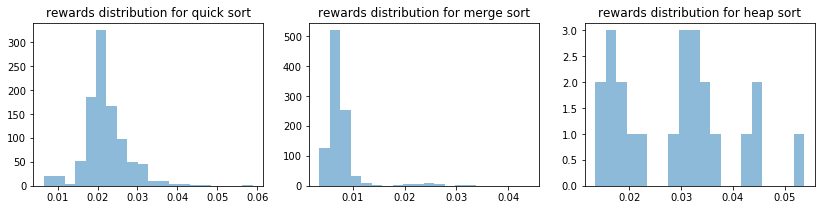

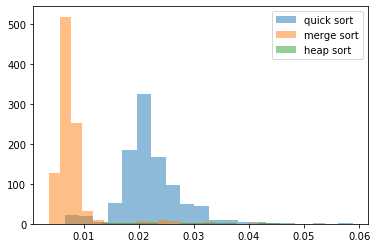

In [53]:
plot_rewards_distribution(arm_rewards_5)
plot_rewards_distribution_together(arm_rewards_5)

Restart at iteration: 504
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.022974983228366153, 'merge_sort': 0.027452659998380112, 'heap_sort': 0.03699349999806145}
Count per chosen algo {'quick_sort': 477, 'merge_sort': 20, 'heap_sort': 8}


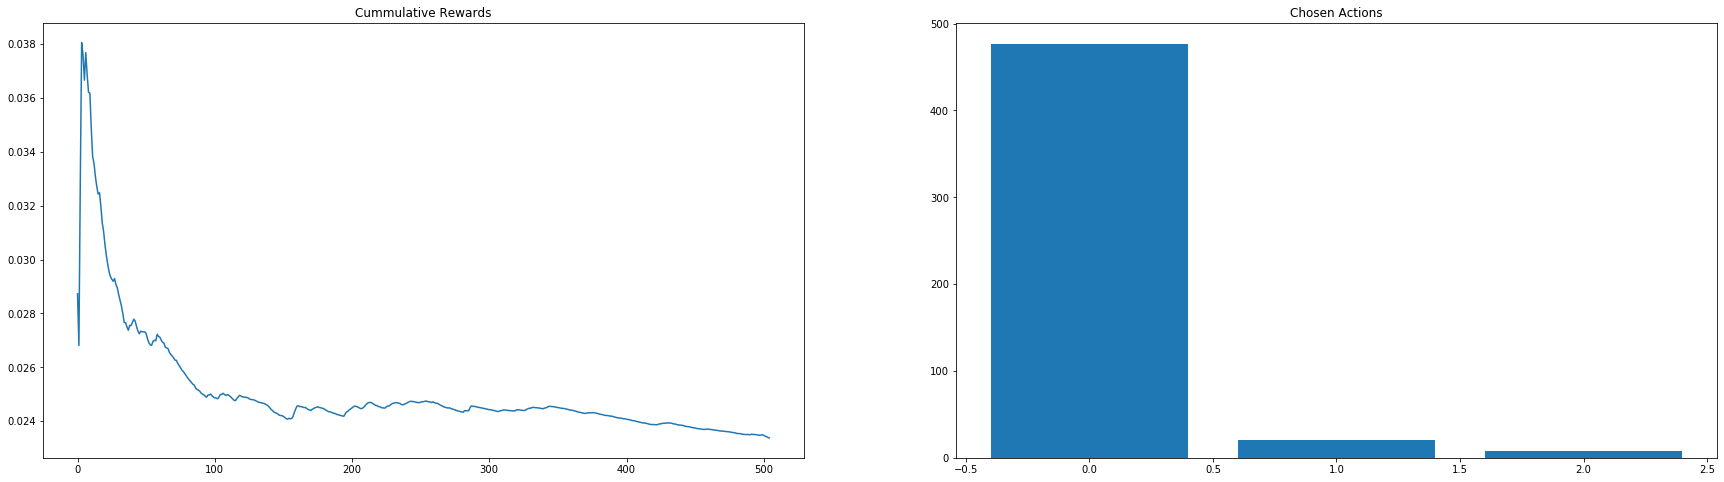

Restart at iteration: 1004
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008739189654769344, 'merge_sort': 0.007529530042647274, 'heap_sort': 0.01626692000136245}
Count per chosen algo {'quick_sort': 29, 'merge_sort': 466, 'heap_sort': 5}


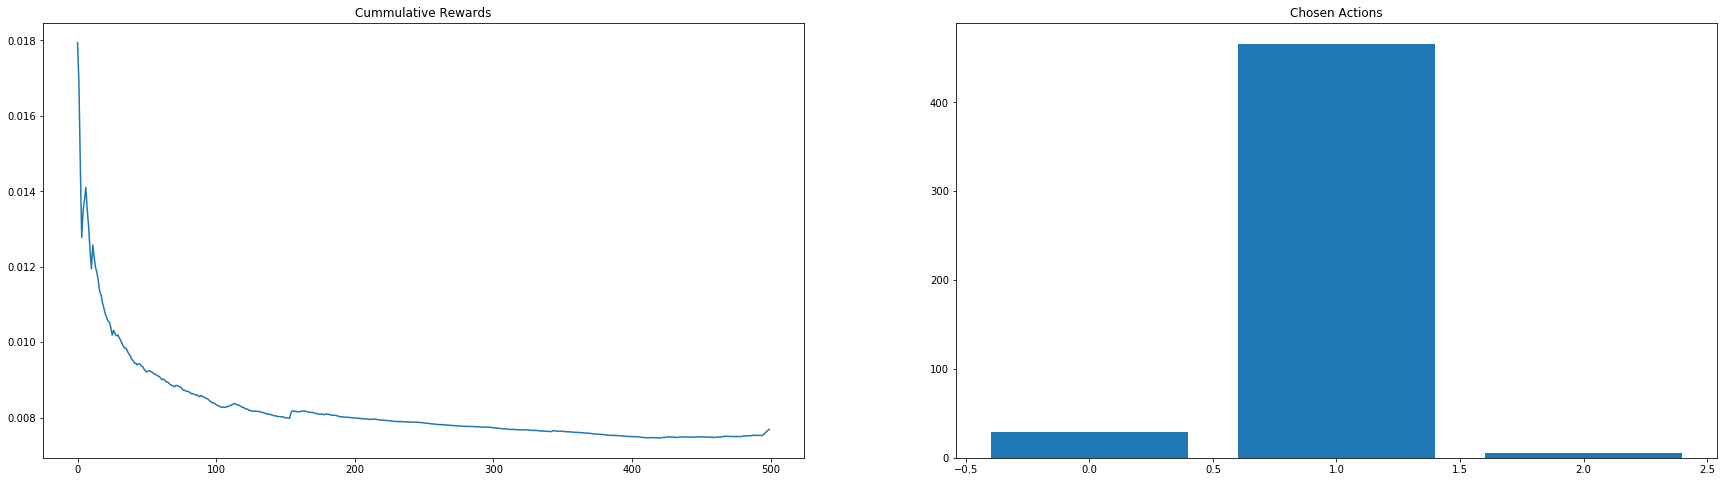

Restart at iteration: 1504
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.02190412111783677, 'merge_sort': 0.02687170909220268, 'heap_sort': 0.03593104999890784}
Count per chosen algo {'quick_sort': 483, 'merge_sort': 11, 'heap_sort': 6}


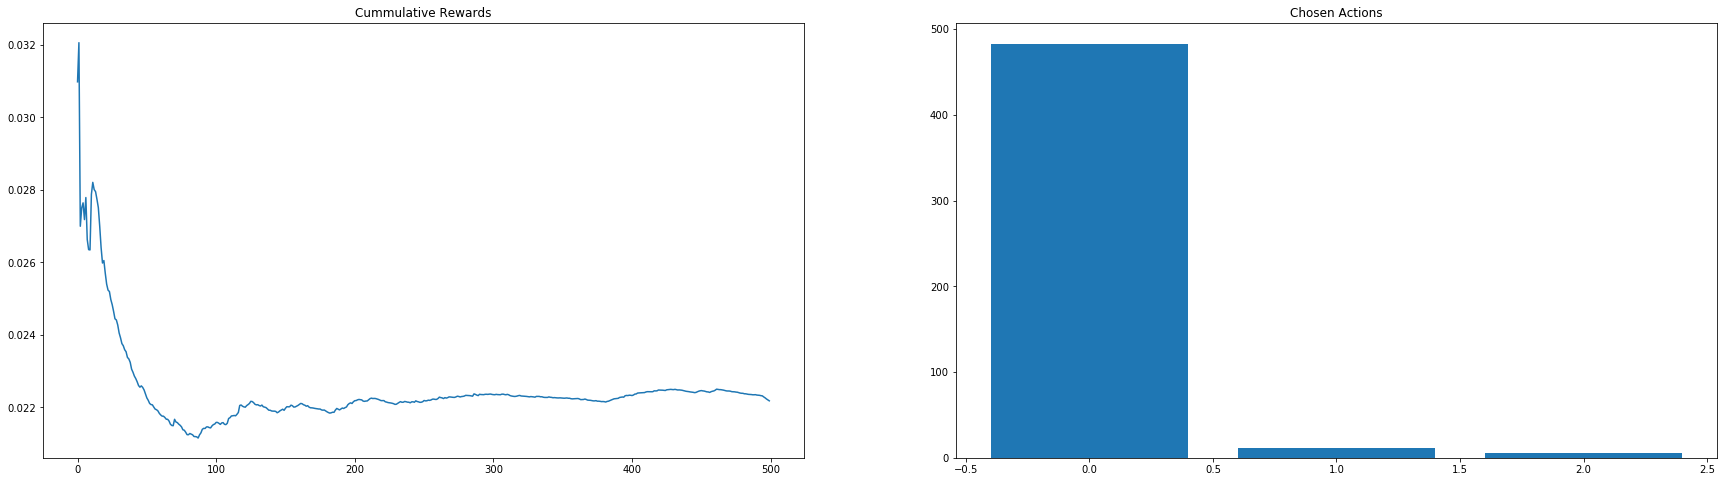

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.011190833329843978, 'merge_sort': 0.006960668659453357, 'heap_sort': 0.018756100002065068}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 485, 'heap_sort': 4}


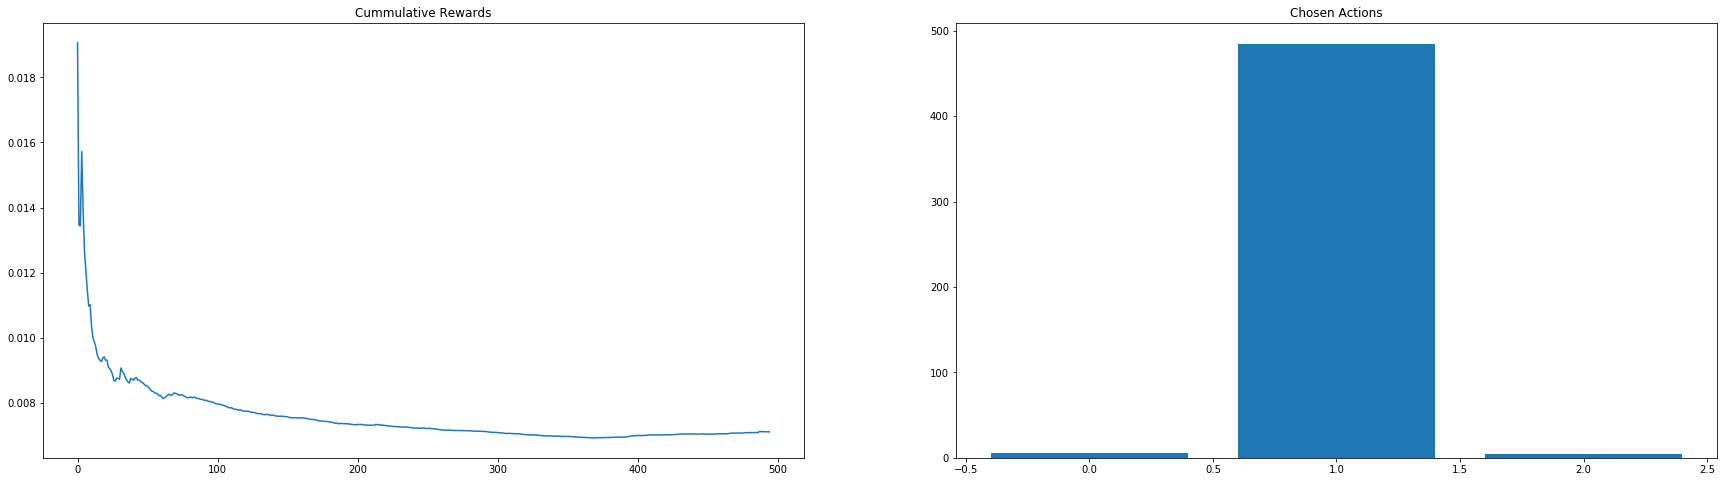

Total reward 30.2566


In [54]:
for elem in list_iteration_results_5:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_5,4))